<a href="https://colab.research.google.com/github/sofiammatias/tick-tick-bloom/blob/main/ticktickbloomCNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tick Tick Bloom Challenge (Driven Data)
The goal in this challenge is to use satellite imagery to detect and classify the severity of cyanobacteria blooms in small, inland water bodies. The resulting algorithm will help water quality managers better allocate resources for in situ sampling, and make more informed decisions around public health warnings for critical resources like drinking water reservoirs. Ultimately, more accurate and more timely detection of algal blooms helps keep both the human and marine life that rely on these water bodies safe and healthy.

## Imports

In [2]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 9.2 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [3]:
!pip install planetary_computer
!pip install pystac_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install rioxarray
!pip install odc-stac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 43.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 KB 6.7 MB/s eta 0:00:00


In [5]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 3.4 MB/s eta 0:00:00


In [6]:
%load_ext autoreload
%autoreload 2

In [211]:
import cv2
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import odc.stac
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import geopy.distance as distance
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage
import planetary_computer as pc
from pystac_client import Client

import tensorflow as tf
from keras.metrics import AUC
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

%matplotlib inline

# Data: Collection and EDA

## Load critical files

In [8]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
files_path = '/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/'
DATA_PATH = Path.cwd().parent.resolve() / files_path
MODEL_DIR = DATA_PATH / "model_CNN"

metadata_file = f'{files_path}metadata.csv'
train_labels_file = f'{files_path}/train_labels.csv'
submission_file = f"{files_path}/submission_format.csv"

In [10]:
metadata = pd.read_csv(metadata_file)
train_labels = pd.read_csv(train_labels_file)
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

## Metadata.csv

In [11]:
metadata = pd.read_csv(metadata_file)

### Location

In [12]:
display(metadata.head())
metadata.split.value_counts(dropna=False)

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


train    17060
test      6510
Name: split, dtype: int64

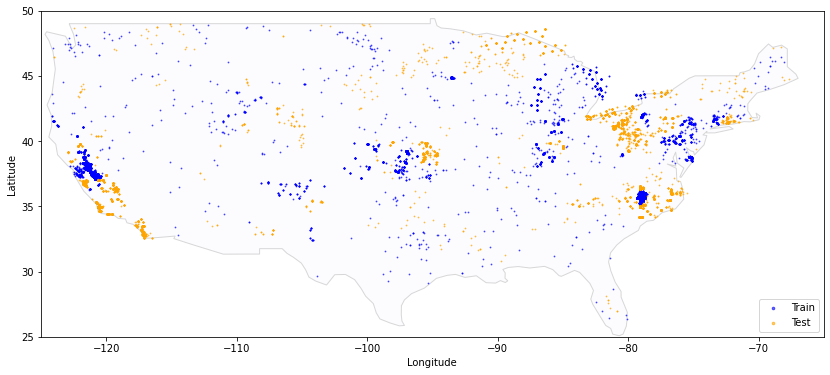

In [13]:
# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(15, 6))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

### Date

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


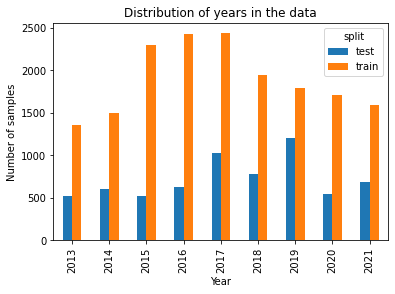

In [14]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
display (metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max)))

# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")
plt.show()

Seasons


summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

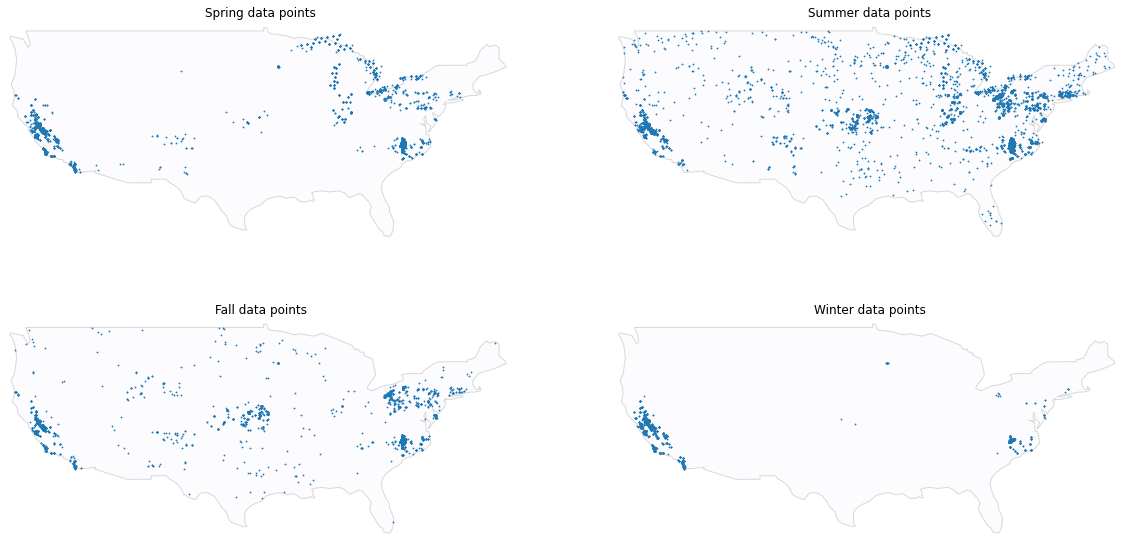

In [15]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
print ('Seasons')
display(metadata.season.value_counts())

# where is data from for each season?
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

## Train Labels.csv

In [16]:
train_labels = pd.read_csv(train_labels_file)

In [17]:
display(train_labels.head())
train_labels.shape

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


(17060, 4)

In [18]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)
train_labels_and_metadata

,uid,region,severity,density,latitude,longitude,date,split,season
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train,spring
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train,fall
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train,summer
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train,summer
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train,summer
...,...,...,...,...,...,...,...,...,...
17055,zzsv,south,3,113125.0,38.707825,-75.080867,2018-06-27,train,summer
17056,zzuq,south,3,175726.0,35.794000,-79.015368,2015-08-06,train,summer
17057,zzwo,midwest,2,48510.0,39.792190,-99.971050,2017-06-19,train,summer
17058,zzwq,south,1,1271.0,35.794000,-79.012551,2015-03-24,train,spring


[0.00339977 0.20791325 0.15937866 0.18985932 0.439449  ]


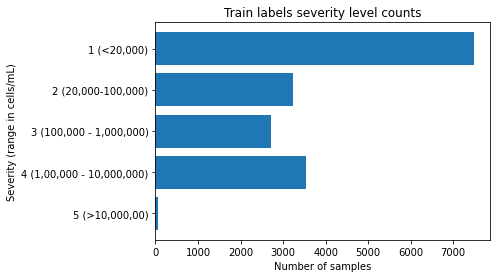

In [19]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")
weights = severity_counts.values /severity_counts.values.sum()
print (weights)

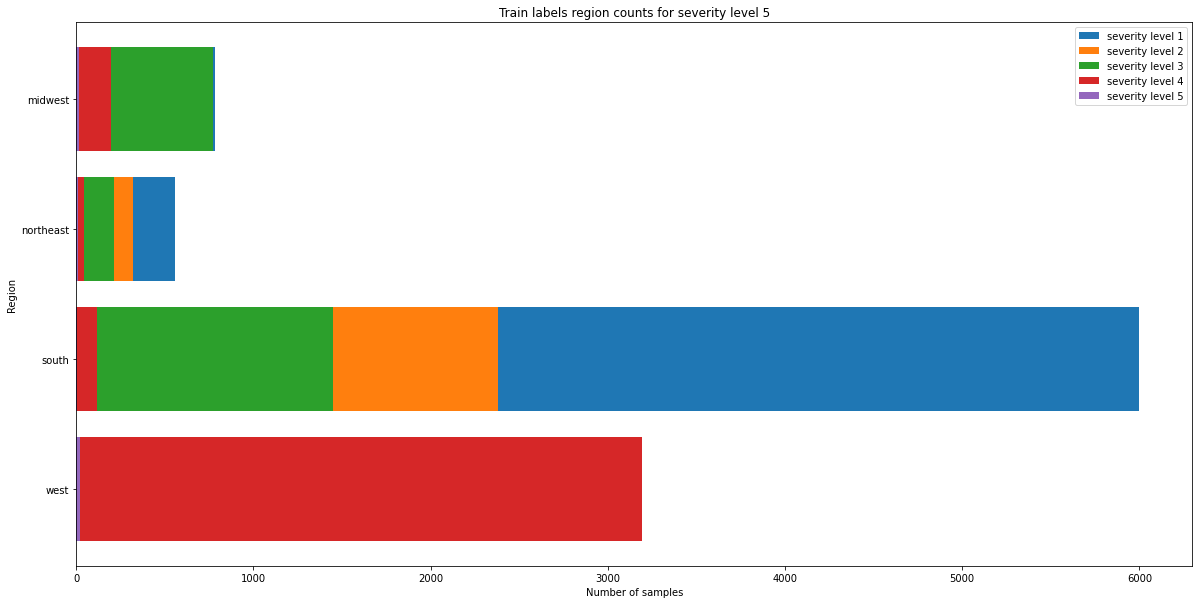

In [20]:
plt.figure (figsize=(20,10))

for severity_level in range(1, 6):
  region_counts = train_labels[train_labels.severity == severity_level].region.value_counts().sort_index(ascending=False)
  ax = plt.barh(region_counts.index, region_counts.values, label = f'severity level {severity_level}')

plt.xlabel("Number of samples")
plt.ylabel("Region")
plt.title(f'Train labels region counts for severity level {severity_level}')
plt.legend ()

In [21]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

# Process Feature Data

Feature data is not provided directly. Instead, access to all feature data can only be done through **external, publicly available APIs**. Relevant imagery can be identified using the location and date of each sample, listed in metadata.csv.

Pull in matching satellite imagery will be done using Microsoft's Planetary Computer. Use only **Sentinel-2 L2A** and **Landsat Level-2** satellite imagery. Sentinel-2 L1C and Landsat Level-1 imagery are also allowed.

In [22]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

## Location range: 
search an area with 50,000 meters on either side of our sample point (100,000 m x 100,000 m), to make sure we're pulling in all relevant imagery. This is just a starting point, and you can improve on how to best search for the correct location in the Planetary Computer.

## Time range: 
We want our feature data to be as close to the time of the sample as possible, because in algal blooms in small water bodies form and move very rapidly. Remember, you cannot use any data collected after the date of the sample.

Imagery taken with roughly 10 days of the sample will generally still be an accurate representation of environmental conditions at the time of the sample. For some data points you may not be able to get data within 10 days, and may have to use earlier data. We'll search the fifteen days up to the sample time, including the sample date.

# Select and Process one Image
We will get one example image to understand the process and change it if required. 

In [23]:
example_row = metadata[metadata.uid == "yeon"].iloc[0]
example_row

uid                         yeon
latitude                   36.08
longitude                 -78.37
date         2017-09-18 00:00:00
split                       test
season                      fall
Name: 21932, dtype: object

In [24]:
example_row_2 = train_labels[train_labels.uid == "garm"].iloc[0]
example_row_2

uid                garm
region             west
severity              5
density     12267752.74
Name: 3950, dtype: object

## Selection steps

In [25]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [26]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=45):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


In [27]:
#Get bounding box of interest area
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
print ('\nBounding box:\n\n',bbox)

# get our date range to search, and format correctly for query
date_range = get_date_range(example_row.date).replace('T', '')
print ('\nDate range:\n\n',date_range)

# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
print ('\nItems found:\n\n',len(items))

#Select best item



Bounding box:

 [-78.92510214344873, 35.629372185038925, -77.81489785655128, 36.530593861715936]

Date range:

 2017-08-04/2017-09-18

Items found:

 62


In [28]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 62 returned to 34 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
61,2017-08-04,Sentinel-2A,True,"[-78.72364076586805, 36.007451011934776, -77.5..."
60,2017-08-04,Sentinel-2A,True,"[-78.80191386287372, 35.10721816203458, -77.55..."
58,2017-08-04,Sentinel-2A,True,"[-78.37131820920371, 36.01049725766069, -77.11..."
56,2017-08-05,landsat-7,True,"[-80.64024447, 35.07019482, -77.91179152, 37.0..."
55,2017-08-06,landsat-8,True,"[-79.07858417, 34.92646493, -76.39235131, 37.1..."
51,2017-08-12,Sentinel-2B,True,"[-78.78052649213598, 36.015188412779594, -77.5..."
50,2017-08-12,Sentinel-2B,True,"[-78.80526871562567, 35.12051614226662, -77.86..."
48,2017-08-12,Sentinel-2B,True,"[-78.37131820920371, 36.01049725766069, -77.56..."
46,2017-08-13,landsat-8,True,"[-80.53879426, 34.96604482, -77.95883133, 37.0..."
45,2017-08-14,landsat-7,True,"[-79.17162437, 35.02585494, -76.3447515, 37.05..."


In [29]:
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])

In [30]:
#Select best item
# 1 - filter to sentinel
# 2 - take closest by date
best_item, item_platform, item_date = select_best_item(
                    items, example_row.date, example_row.latitude, example_row.longitude
                )

item = best_item

# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [31]:
item

ID: S2A_MSIL2A_20170913T154901_R054_T18STF_20201020T002819
"Bounding Box: [-78.37131820920371, 36.01049725766069, -77.11143123293884, 37.02730768000537]"
Datetime: 2017-09-13 15:49:01.026000+00:00
datetime: 2017-09-13T15:49:01.026000Z
platform: Sentinel-2A
proj:epsg: 32618
instruments: ['msi']
s2:mgrs_tile: 18STF
constellation: Sentinel 2
s2:granule_id: S2A_OPER_MSI_L2A_TL_ESRI_20201020T002821_A011634_T18STF_N02.12
eo:cloud_cover: 0.089014


## Visualizing Sentinel-2 imagery

To keep things simple, we'll just choose one image to input into our model. Keep in mind that it is possible to incorporate multiple images!

We'll narrow to one image in two steps:

- If any Sentinel imagery is available, filter to only Sentinel imagery. Sentinel-2 is higher resolution than Landsat, which is extremely helpful for blooms in small water bodies. In this case, two images are from Sentinel and contain the actual sample location.
- Select the item that is the closest time wise to the sampling date. This gives us a Sentinel-2A item that was captured on 10/20/2022 - two days before our sample was collected on 10/22.

This is a very simple way to choose the best image. 

Be aware that querying the Planetary Computer for all of the images is going to take a LONG time! You'll want to find ways to both save work as you go, and optimize your code for efficiency.

In [32]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    
    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [33]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [34]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3600
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

print ('Array shape:', zoomed_img_array[0].shape)
zoomed_img_array[0]

Array shape: (746, 27)


array([[27, 27, 22, ..., 25, 24, 24],
       [27, 24, 21, ..., 25, 24, 24],
       [24, 22, 23, ..., 24, 23, 24],
       ...,
       [22, 22, 23, ..., 17, 17, 21],
       [21, 20, 21, ..., 22, 21, 22],
       [20, 20, 20, ..., 18, 21, 22]], dtype=uint8)

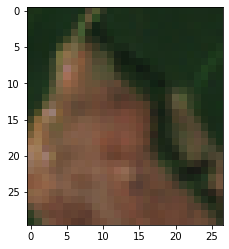

In [35]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array[:, :30, :30], axes=[1, 2, 0]))

## CNN for Sentinel images

In [36]:
def severity_ohe(severity_val):
  """
  One Hot Encode our Target for TensorFlow processing
  """
  severity_cat = to_categorical(severity_val - 1, num_classes=5)
  return severity_cat

In [37]:
severity = severity_ohe(5)
severity.shape

(5,)

In [38]:
def image_norm(img_array):
  """
  Changes the image array from sentinel imagery into a numpy array fitted to be 
  used in CNN
  """
  i1,i2,i3 = img_array.shape
  shape = (i2, i3, i1)
  image_array_final=img_array.reshape (i2,i3,i1)
  return image_array_final, shape

In [39]:
image_array_sent, img_sent_shape = image_norm(zoomed_img_array)
#model_sent = initiate_model_sent(img_sent_shape)
#model_sent, history_s = train_model_sent(model_sent, image_array_sent, np.array([severity]))
#prediction = model_sent.predict(image_array_sent)
#history_s.history


## Visualizing Landsat imagery

STAC items from Sentinel and from Landsat are slightly different, so we'll have to use slightly different methods to pull imagery based on its satellite 

In [40]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

In [41]:
landsat_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sample(n=1, random_state=3)
    .iloc[0]
)
print ('\nLandsat image data:\n\n', landsat_item)

minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=150
)
bbox = (minx, miny, maxx, maxy)

item = landsat_item.item_obj

# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
print ('\nRescaled numpy array image:\n\n', landsat_image_array[0].shape, landsat_image_array[0]) #numpy array

# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
print ('\nNot scaled image:\n\n', image_array[0])


Landsat image data:

 datetime                                                        2017-08-29
platform                                                         landsat-8
min_long                                                        -80.538794
max_long                                                        -77.955461
min_lat                                                          34.965965
max_lat                                                          37.097695
bbox                     [-80.53879426, 34.96596482, -77.95546133, 37.0...
item_obj                         <Item id=LC08_L2SP_016035_20170829_02_T2>
contains_sample_point                                                 True
Name: 24, dtype: object

Rescaled numpy array image:

 (11, 11) [[126 122 109 123 101 114 143 135 121 115 108]
 [117 120 110  95  91 114 132 116  96  82  86]
 [ 90  88  76  72  85 107 111  65  56  54  68]
 [ 75  73  66  85  98 105 100  59  48  53  63]
 [ 83  60  64  79  86  81  72  43  50  69  65]
 [ 

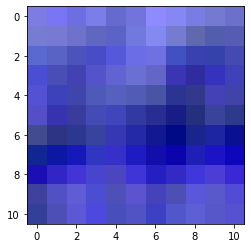

In [42]:
#Show rescaled image
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

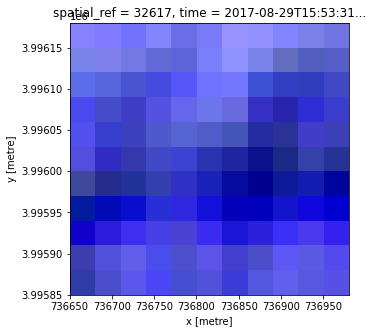

In [43]:
# image appears differently without rescaling
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)

## CNN model for landsat images

In [44]:
image_array_land = 0
landsat_image_array.shape

(3, 11, 11)

In [45]:
#image_array_land, img_land_shape = image_norm(landsat_image_array)
#model_land = initiate_model_land(img_land_shape)
#model_land, history_l = train_model_land(model_land, image_array_land, np.array([severity]))
#prediction = model_land.predict(image_array_land)
#history_l.history

# Getting All Images ("production")

We'll save out the processed features for each image as we go, to make sure we only have to run time-intensive parts of our code once.

For time, here we'll train on a randomly selected small subset of the training data. The cell below is highly time intensive, because for each row in the data we have to query the planetary computer catalog and process imagery.

We'll still include and predict on all of the test data.

In [398]:
# save image arrays in case we want to generate more features
IMAGE_ARRAY_SENT_DIR = DATA_PATH / "image_arrays_sentinel"
IMAGE_ARRAY_LAND_DIR = DATA_PATH / "image_arrays_landsat"
IMAGE_ARRAY_SENT_DIR.mkdir(exist_ok=True, parents=True)
IMAGE_ARRAY_LAND_DIR.mkdir(exist_ok=True, parents=True)

# Getting global params set
meter_buffer_init = 50000
meter_buffer_img = 400
enlarged_meter_buffer = 6000
cut_sentinel_image = 30
cut_landsat_image = 10
time_buffer = 45

# Splitting train dataset into 'train' and 'validation' for model evaluation
train_subset = train_labels_and_metadata[train_labels_and_metadata["split"] == "train"].copy()
rng = np.random.RandomState(30)
train_subset['split'] = rng.choice(
    ["train", "validation"], 
    size=len(metadata[metadata["split"] == "train"]), 
    replace=True, 
    p=[0.67, 0.33]
)

# take a random subset of the training/validation data. To better train the model,
# we don't define random_state to have different datasets.
train_subset = train_subset.sample(n=2500)#[train_subset.region == 'west']

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
print (metadata_subset.split.value_counts(dropna=False))
display (train_subset[:10])

test          6510
train         1680
validation     820
Name: split, dtype: int64


,uid,region,severity,density,latitude,longitude,date,split,season
3918,fzjh,west,4,4.242500e+06,37.436800,-121.133000,2017-01-10,train,winter
722,bcpr,south,3,1.875510e+05,35.686068,-79.200597,2020-08-13,validation,summer
5035,hrok,south,2,7.043700e+04,36.040000,-79.089420,2018-06-14,validation,summer
16428,yzlv,midwest,2,2.898000e+04,38.388890,-97.093060,2016-06-20,validation,summer
1281,bytv,south,1,2.820000e+02,35.635021,-79.295411,2015-02-11,validation,winter
2988,ensu,west,4,1.172105e+06,37.536800,-121.049000,2020-02-11,train,winter
8901,nnai,south,1,4.357000e+03,35.712177,-79.152103,2016-06-08,train,summer
13401,ukja,midwest,2,2.646000e+04,39.077750,-96.905900,2016-10-17,validation,fall
208,aijp,midwest,1,2.724761e+02,43.133333,-87.000000,2017-03-27,validation,spring
13974,vfzr,south,3,4.860990e+05,33.673330,-86.164530,2017-08-14,train,summer


In [399]:
# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items = {}
features_sent_dict = {}
features_land_dict = {}
errored_ids = []

i=0
for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
    # check if we've already saved the selected image array
    image_array_sent_pth = IMAGE_ARRAY_SENT_DIR / f"{row.uid}.npy"
    image_array_land_pth = IMAGE_ARRAY_LAND_DIR / f"{row.uid}.npy"
    print ('\nGetting image array nº', i,' from ',len(metadata_subset))

    if image_array_sent_pth.exists():
        with open(image_array_sent_pth, "rb") as f:
            image_array = np.load(f)
        print ('\nImage array nº',i,' from', image_array_sent_pth,'\n\n')
        image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
        print ('image sentinel shape:', image_feature[1])
        image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
        features_sent_dict[row.uid] = image_feature

    elif image_array_land_pth.exists():
        with open(image_array_land_pth, "rb") as f:
            image_array = np.load(f)
        print ('\nImage array nº',i,' from', image_array_land_pth,'\n\n')
        image_feature = image_norm(image_array[:, :cut_landsat_image, :cut_landsat_image])
        print ('image landsat shape:', image_feature[1])
        features_land_dict[row.uid] = image_feature
    
    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=meter_buffer_init
            )
            date_range = get_date_range(row.date, time_buffer_days=15).replace('T', '')

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=meter_buffer_img
            )

            # crop and normalize the image
            print ('\nImage array nº',i,' from STAC API\n\n')
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
                # convert image to be used in CNN
                image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
                print ('\nImage sentinel shape:', image_feature[1])
                # save image array so we don't have to rerun             
                with open(image_array_sent_pth, "wb") as f:
                  np.save(f, image_array)
                features_sent_dict[row.uid] = image_feature

            else:
                image_array = crop_landsat_image(best_item, feature_bbox)
                # save image array so we don't have to rerun
                with open(image_array_land_pth, "wb") as f:
                    np.save(f, image_array)
                # convert image to be used in CNN
                image_feature = image_norm(image_array[:, :cut_landsat_image, :cut_landsat_image])
                print ('\nImage landsat shape:', image_feature[1])
                features_land_dict[row.uid] = image_feature
            
        except Exception as e: 
          print(e)
          errored_ids.append(row.uid)
    i += 1

  0%|          | 1/9010 [00:00<24:46,  6.06it/s]


Getting image array nº 0  from  9010

Image array nº 0  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fzjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1  from  9010

Image array nº 1  from STAC API




  0%|          | 2/9010 [00:03<5:31:15,  2.21s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2  from  9010

Image array nº 2  from STAC API




  0%|          | 3/9010 [00:05<5:18:36,  2.12s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 3  from  9010


  0%|          | 5/9010 [00:06<2:19:40,  1.07it/s]


Image array nº 3  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4  from  9010

Image array nº 4  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bytv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5  from  9010


  0%|          | 6/9010 [00:06<1:42:31,  1.46it/s]


Image array nº 5  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ensu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6  from  9010

Image array nº 6  from STAC API




  0%|          | 7/9010 [00:09<3:20:54,  1.34s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 7  from  9010

Image array nº 7  from STAC API




  0%|          | 8/9010 [00:10<3:12:19,  1.28s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 8  from  9010

Image array nº 8  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aijp.npy 


image sentinel shape: (30, 17, 3)

Getting image array nº 9  from  9010

Image array nº 9  from STAC API




  0%|          | 10/9010 [00:11<2:16:54,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 10  from  9010

Image array nº 10  from STAC API




  0%|          | 11/9010 [00:13<2:55:24,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 11  from  9010

Image array nº 11  from STAC API




  0%|          | 12/9010 [00:14<2:57:45,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 12  from  9010

Image array nº 12  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hlzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 13  from  9010

Image array nº 13  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bvjb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 14  from  9010


  0%|          | 15/9010 [00:14<1:28:49,  1.69it/s]


Image array nº 14  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/leko.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 15  from  9010

Image array nº 15  from STAC API




  0%|          | 16/9010 [00:16<2:05:43,  1.19it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 16  from  9010

Image array nº 16  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hkmu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 17  from  9010


  0%|          | 18/9010 [00:16<1:25:39,  1.75it/s]


Image array nº 17  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 18  from  9010

Image array nº 18  from STAC API




  0%|          | 20/9010 [00:18<1:27:55,  1.70it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 19  from  9010

Image array nº 19  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 20  from  9010

Image array nº 20  from STAC API




  0%|          | 21/9010 [00:19<1:42:22,  1.46it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 21  from  9010

Image array nº 21  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gndo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 22  from  9010


  0%|          | 23/9010 [00:19<1:06:34,  2.25it/s]


Image array nº 22  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/argt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 23  from  9010


  0%|          | 24/9010 [00:19<59:10,  2.53it/s]  


Image array nº 23  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qumt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 24  from  9010

Image array nº 24  from STAC API




  0%|          | 25/9010 [00:21<2:00:54,  1.24it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 25  from  9010


  0%|          | 27/9010 [00:21<1:17:51,  1.92it/s]


Image array nº 25  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iktx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 26  from  9010

Image array nº 26  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ewwy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 27  from  9010

Image array nº 27  from STAC API




  0%|          | 28/9010 [00:22<1:38:55,  1.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 28  from  9010

Image array nº 28  from STAC API




  0%|          | 30/9010 [00:24<1:28:02,  1.70it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 29  from  9010

Image array nº 29  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/auqm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 30  from  9010


  0%|          | 31/9010 [00:24<1:12:50,  2.05it/s]


Image array nº 30  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cwuc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 31  from  9010

Image array nº 31  from STAC API




  0%|          | 32/9010 [00:25<1:35:03,  1.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 32  from  9010

Image array nº 32  from STAC API




  0%|          | 35/9010 [00:26<1:04:21,  2.32it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 33  from  9010

Image array nº 33  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kugl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 34  from  9010

Image array nº 34  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbbe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 35  from  9010

Image array nº 35  from STAC API




  0%|          | 36/9010 [00:27<1:28:58,  1.68it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 36  from  9010

Image array nº 36  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/irdp.npy 



  0%|          | 37/9010 [00:27<1:13:29,  2.03it/s]


image landsat shape: (10, 10, 3)

Getting image array nº 37  from  9010

Image array nº 37  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nfth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 38  from  9010

Image array nº 38  from STAC API




  0%|          | 41/9010 [00:29<1:07:03,  2.23it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 39  from  9010

Image array nº 39  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pyoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 40  from  9010

Image array nº 40  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gwij.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 41  from  9010


  0%|          | 43/9010 [00:30<50:15,  2.97it/s]


Image array nº 41  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gvyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 42  from  9010

Image array nº 42  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qfoo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 43  from  9010

Image array nº 43  from STAC API




  0%|          | 44/9010 [00:32<1:50:13,  1.36it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 44  from  9010

Image array nº 44  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzgp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 45  from  9010


  1%|          | 47/9010 [00:32<59:41,  2.50it/s]  


Image array nº 45  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 46  from  9010

Image array nº 46  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypmb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 47  from  9010


  1%|          | 49/9010 [00:32<44:34,  3.35it/s]


Image array nº 47  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shhd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 48  from  9010

Image array nº 48  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/feuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 49  from  9010

Image array nº 49  from STAC API




  1%|          | 51/9010 [00:35<1:36:30,  1.55it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 50  from  9010

Image array nº 50  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbsi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 51  from  9010

Image array nº 51  from STAC API




  1%|          | 53/9010 [00:36<1:20:07,  1.86it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 52  from  9010

Image array nº 52  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 53  from  9010

Image array nº 53  from STAC API




  1%|          | 54/9010 [00:38<2:26:09,  1.02it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 54  from  9010

Image array nº 54  from STAC API




  1%|          | 55/9010 [00:39<2:26:12,  1.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 55  from  9010


  1%|          | 56/9010 [00:39<1:51:31,  1.34it/s]


Image array nº 55  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqfe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 56  from  9010


  1%|          | 59/9010 [00:39<52:09,  2.86it/s]  


Image array nº 56  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkdu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 57  from  9010

Image array nº 57  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkya.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 58  from  9010

Image array nº 58  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hloe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 59  from  9010


  1%|          | 60/9010 [00:39<46:45,  3.19it/s]


Image array nº 59  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 60  from  9010

Image array nº 60  from STAC API




  1%|          | 62/9010 [00:41<1:03:19,  2.35it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 61  from  9010

Image array nº 61  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uaso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 62  from  9010

Image array nº 62  from STAC API




  1%|          | 63/9010 [00:42<1:26:54,  1.72it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 63  from  9010

Image array nº 63  from STAC API




  1%|          | 64/9010 [00:43<1:39:33,  1.50it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 64  from  9010

Image array nº 64  from STAC API




  1%|          | 66/9010 [00:44<1:28:57,  1.68it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 65  from  9010

Image array nº 65  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/chtc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 66  from  9010

Image array nº 66  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 67  from  9010

Image array nº 67  from STAC API




  1%|          | 69/9010 [00:46<1:27:13,  1.71it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 68  from  9010

Image array nº 68  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/idgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 69  from  9010

Image array nº 69  from STAC API




  1%|          | 70/9010 [00:47<1:39:44,  1.49it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 70  from  9010

Image array nº 70  from STAC API




  1%|          | 71/9010 [00:48<1:50:56,  1.34it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 71  from  9010


  1%|          | 73/9010 [00:48<1:13:27,  2.03it/s]


Image array nº 71  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 72  from  9010

Image array nº 72  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 73  from  9010

Image array nº 73  from STAC API




  1%|          | 75/9010 [00:49<1:10:50,  2.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 74  from  9010

Image array nº 74  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrcb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 75  from  9010


  1%|          | 76/9010 [00:49<56:15,  2.65it/s]  


Image array nº 75  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 76  from  9010

Image array nº 76  from STAC API




  1%|          | 78/9010 [00:51<1:10:41,  2.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 77  from  9010

Image array nº 77  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ukfm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 78  from  9010


  1%|          | 80/9010 [00:51<46:37,  3.19it/s]


Image array nº 78  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qmkz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 79  from  9010

Image array nº 79  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/njfv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 80  from  9010


  1%|          | 81/9010 [00:51<40:29,  3.67it/s]


Image array nº 80  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uoky.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 81  from  9010

Image array nº 81  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixvy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 82  from  9010

Image array nº 82  from STAC API




  1%|          | 84/9010 [00:52<46:19,  3.21it/s]


Image sentinel shape: (30, 18, 3)

Getting image array nº 83  from  9010

Image array nº 83  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rjks.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 84  from  9010

Image array nº 84  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fukn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 85  from  9010

Image array nº 85  from STAC API




  1%|          | 86/9010 [00:53<57:14,  2.60it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 86  from  9010


  1%|          | 87/9010 [00:53<50:54,  2.92it/s]


Image array nº 86  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kdbw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 87  from  9010

Image array nº 87  from STAC API




  1%|          | 88/9010 [00:54<1:11:18,  2.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 88  from  9010

Image array nº 88  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hypo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 89  from  9010

Image array nº 89  from STAC API




  1%|          | 90/9010 [00:55<1:12:25,  2.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 90  from  9010

Image array nº 90  from STAC API




  1%|          | 91/9010 [00:56<1:33:05,  1.60it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 91  from  9010

Image array nº 91  from STAC API




  1%|          | 93/9010 [01:00<2:17:32,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 92  from  9010

Image array nº 92  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fjri.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 93  from  9010

Image array nº 93  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 94  from  9010


  1%|          | 95/9010 [01:00<1:24:58,  1.75it/s]


Image array nº 94  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kmfi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 95  from  9010


  1%|          | 96/9010 [01:00<1:12:15,  2.06it/s]


Image array nº 95  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 96  from  9010

Image array nº 96  from STAC API




  1%|          | 97/9010 [01:02<2:11:52,  1.13it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 97  from  9010

Image array nº 97  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tipv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 98  from  9010


  1%|          | 99/9010 [01:02<1:24:37,  1.76it/s]


Image array nº 98  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 99  from  9010


  1%|          | 101/9010 [01:03<1:01:47,  2.40it/s]


Image array nº 99  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvwo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 100  from  9010

Image array nº 100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 101  from  9010


  1%|          | 102/9010 [01:03<51:39,  2.87it/s]  


Image array nº 101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xecx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 102  from  9010

Image array nº 102  from STAC API




  1%|          | 103/9010 [01:04<1:16:05,  1.95it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 103  from  9010

Image array nº 103  from STAC API




  1%|          | 105/9010 [01:07<2:04:57,  1.19it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 104  from  9010

Image array nº 104  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ioaz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 105  from  9010


  1%|          | 107/9010 [01:07<1:14:12,  2.00it/s]


Image array nº 105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmkw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 106  from  9010

Image array nº 106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 107  from  9010

Image array nº 107  from STAC API




  1%|          | 108/9010 [01:09<2:28:58,  1.00s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 108  from  9010


  1%|          | 109/9010 [01:09<1:53:59,  1.30it/s]


Image array nº 108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxiv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 109  from  9010


  1%|          | 111/9010 [01:10<1:11:46,  2.07it/s]


Image array nº 109  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 110  from  9010

Image array nº 110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vxwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 111  from  9010


  1%|          | 112/9010 [01:10<59:27,  2.49it/s]  


Image array nº 111  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/igrz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 112  from  9010

Image array nº 112  from STAC API




  1%|▏         | 113/9010 [01:12<2:04:01,  1.20it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 113  from  9010

Image array nº 113  from STAC API




  1%|▏         | 115/9010 [01:14<2:07:27,  1.16it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 114  from  9010

Image array nº 114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrhl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 115  from  9010


  1%|▏         | 117/9010 [01:14<1:15:36,  1.96it/s]


Image array nº 115  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 116  from  9010

Image array nº 116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kses.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 117  from  9010

Image array nº 117  from STAC API




  1%|▏         | 118/9010 [01:15<1:35:57,  1.54it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 118  from  9010

Image array nº 118  from STAC API




  1%|▏         | 119/9010 [01:16<1:46:48,  1.39it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 119  from  9010


  1%|▏         | 120/9010 [01:16<1:24:23,  1.76it/s]


Image array nº 119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqgh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 120  from  9010


  1%|▏         | 121/9010 [01:17<1:09:09,  2.14it/s]


Image array nº 120  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pnbv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 121  from  9010

Image array nº 121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aznr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 122  from  9010

Image array nº 122  from STAC API




  1%|▏         | 123/9010 [01:18<1:14:15,  1.99it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 123  from  9010

Image array nº 123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 124  from  9010

Image array nº 124  from STAC API




  1%|▏         | 125/9010 [01:19<1:14:59,  1.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 125  from  9010

Image array nº 125  from STAC API




  1%|▏         | 127/9010 [01:20<1:14:43,  1.98it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 126  from  9010

Image array nº 126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gabr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 127  from  9010


  1%|▏         | 129/9010 [01:20<53:36,  2.76it/s]  


Image array nº 127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 128  from  9010

Image array nº 128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tbrg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 129  from  9010


  1%|▏         | 130/9010 [01:20<45:58,  3.22it/s]


Image array nº 129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibnd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 130  from  9010

Image array nº 130  from STAC API




  1%|▏         | 132/9010 [01:21<55:43,  2.66it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 131  from  9010

Image array nº 131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzwd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 132  from  9010

Image array nº 132  from STAC API




  1%|▏         | 133/9010 [01:22<1:23:46,  1.77it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 133  from  9010

Image array nº 133  from STAC API




  1%|▏         | 135/9010 [01:24<1:19:15,  1.87it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 134  from  9010

Image array nº 134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbha.npy 


image sentinel shape: (30, 30, 3)


  2%|▏         | 136/9010 [01:24<1:01:19,  2.41it/s]


Getting image array nº 135  from  9010

Image array nº 135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/roty.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 136  from  9010

Image array nº 136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dysm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 137  from  9010


  2%|▏         | 139/9010 [01:24<34:22,  4.30it/s]


Image array nº 137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xzcm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 138  from  9010

Image array nº 138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bolx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 139  from  9010


  2%|▏         | 140/9010 [01:24<37:20,  3.96it/s]


Image array nº 139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 140  from  9010

Image array nº 140  from STAC API




  2%|▏         | 141/9010 [01:26<1:44:37,  1.41it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 141  from  9010

Image array nº 141  from STAC API




  2%|▏         | 144/9010 [01:27<1:08:20,  2.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 142  from  9010

Image array nº 142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wozb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 143  from  9010

Image array nº 143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsbj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 144  from  9010


  2%|▏         | 145/9010 [01:28<59:02,  2.50it/s]  


Image array nº 144  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvzy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 145  from  9010


  2%|▏         | 147/9010 [01:28<47:06,  3.14it/s]


Image array nº 145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wffq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 146  from  9010

Image array nº 146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gihz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 147  from  9010

Image array nº 147  from STAC API




  2%|▏         | 148/9010 [01:29<1:14:47,  1.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 148  from  9010

Image array nº 148  from STAC API




  2%|▏         | 149/9010 [01:31<2:15:07,  1.09it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 149  from  9010

Image array nº 149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 150  from  9010


  2%|▏         | 152/9010 [01:31<1:08:59,  2.14it/s]


Image array nº 150  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/imww.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 151  from  9010

Image array nº 151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wmnp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 152  from  9010


  2%|▏         | 154/9010 [01:32<49:01,  3.01it/s]


Image array nº 152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgrr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 153  from  9010

Image array nº 153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myhh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 154  from  9010

Image array nº 154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ojna.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 155  from  9010


  2%|▏         | 157/9010 [01:32<30:38,  4.81it/s]


Image array nº 155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/prfz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 156  from  9010

Image array nº 156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oksh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 157  from  9010


  2%|▏         | 159/9010 [01:32<26:59,  5.47it/s]


Image array nº 157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jyjq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 158  from  9010

Image array nº 158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbdd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 159  from  9010


  2%|▏         | 160/9010 [01:33<29:02,  5.08it/s]


Image array nº 159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibax.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 160  from  9010

Image array nº 160  from STAC API




  2%|▏         | 162/9010 [01:34<53:15,  2.77it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 161  from  9010

Image array nº 161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 162  from  9010


  2%|▏         | 164/9010 [01:34<36:18,  4.06it/s]


Image array nº 162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oblt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 163  from  9010

Image array nº 163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/foyn.npy 


image sentinel shape: (30, 30, 3)


  2%|▏         | 165/9010 [01:34<32:32,  4.53it/s]


Getting image array nº 164  from  9010

Image array nº 164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iokk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 165  from  9010

Image array nº 165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgnp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 166  from  9010

Image array nº 166  from STAC API




  2%|▏         | 167/9010 [01:35<46:24,  3.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 167  from  9010


  2%|▏         | 169/9010 [01:35<38:15,  3.85it/s]


Image array nº 167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzeq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 168  from  9010

Image array nº 168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oime.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 169  from  9010


  2%|▏         | 171/9010 [01:36<32:07,  4.58it/s]


Image array nº 169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/udia.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 170  from  9010

Image array nº 170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zper.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 171  from  9010


  2%|▏         | 172/9010 [01:36<31:38,  4.66it/s]


Image array nº 171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jlsi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 172  from  9010

Image array nº 172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qbng.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 173  from  9010

Image array nº 173  from STAC API




  2%|▏         | 175/9010 [01:37<45:05,  3.27it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 174  from  9010

Image array nº 174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwug.npy 


image sentinel shape: (30, 30, 3)


  2%|▏         | 176/9010 [01:37<38:57,  3.78it/s]


Getting image array nº 175  from  9010

Image array nº 175  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yqll.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 176  from  9010

Image array nº 176  from STAC API




  2%|▏         | 177/9010 [01:38<1:07:36,  2.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 177  from  9010


  2%|▏         | 178/9010 [01:39<1:02:47,  2.34it/s]


Image array nº 177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/danb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 178  from  9010

Image array nº 178  from STAC API




  2%|▏         | 179/9010 [01:40<1:42:21,  1.44it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 179  from  9010

Image array nº 179  from STAC API




  2%|▏         | 180/9010 [01:41<1:52:33,  1.31it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 180  from  9010

Image array nº 180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 181  from  9010

Image array nº 181  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fcwr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 182  from  9010

Image array nº 182  from STAC API




  2%|▏         | 184/9010 [01:43<1:27:00,  1.69it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 183  from  9010

Image array nº 183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/innk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 184  from  9010

Image array nº 184  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 185  from  9010

Image array nº 185  from STAC API




  2%|▏         | 187/9010 [01:44<1:02:54,  2.34it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 186  from  9010

Image array nº 186  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dweg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 187  from  9010


  2%|▏         | 189/9010 [01:44<48:23,  3.04it/s]


Image array nº 187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kdhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 188  from  9010

Image array nº 188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhtg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 189  from  9010

Image array nº 189  from STAC API




  2%|▏         | 190/9010 [01:45<1:14:55,  1.96it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 190  from  9010

Image array nº 190  from STAC API




  2%|▏         | 191/9010 [01:47<2:10:48,  1.12it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 191  from  9010

Image array nº 191  from STAC API




  2%|▏         | 194/9010 [01:48<1:18:26,  1.87it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 192  from  9010

Image array nº 192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bpki.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 193  from  9010

Image array nº 193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gkwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 194  from  9010


  2%|▏         | 196/9010 [01:49<54:22,  2.70it/s]  


Image array nº 194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/obff.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 195  from  9010

Image array nº 195  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rapd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 196  from  9010


  2%|▏         | 197/9010 [01:49<50:10,  2.93it/s]


Image array nº 196  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 197  from  9010


  2%|▏         | 199/9010 [01:49<38:52,  3.78it/s]


Image array nº 197  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ysya.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 198  from  9010

Image array nº 198  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tejy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 199  from  9010


  2%|▏         | 200/9010 [01:49<35:14,  4.17it/s]


Image array nº 199  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlmj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 200  from  9010


  2%|▏         | 201/9010 [01:50<35:50,  4.10it/s]


Image array nº 200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lswr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 201  from  9010

Image array nº 201  from STAC API




  2%|▏         | 204/9010 [01:52<1:07:03,  2.19it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 202  from  9010

Image array nº 202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 203  from  9010

Image array nº 203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tsbo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 204  from  9010

Image array nº 204  from STAC API




  2%|▏         | 205/9010 [01:54<2:08:30,  1.14it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 205  from  9010


  2%|▏         | 206/9010 [01:55<1:58:17,  1.24it/s]


Image array nº 205  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 206  from  9010

Image array nº 206  from STAC API




  2%|▏         | 207/9010 [01:56<1:59:15,  1.23it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 207  from  9010

Image array nº 207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nica.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 208  from  9010

Image array nº 208  from STAC API




  2%|▏         | 210/9010 [01:58<1:48:55,  1.35it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 209  from  9010

Image array nº 209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kgqh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 210  from  9010

Image array nº 210  from STAC API




  2%|▏         | 212/9010 [01:59<1:33:44,  1.56it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 211  from  9010

Image array nº 211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 212  from  9010


  2%|▏         | 213/9010 [01:59<1:16:37,  1.91it/s]


Image array nº 212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fzfa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 213  from  9010

Image array nº 213  from STAC API




  2%|▏         | 216/9010 [02:01<1:22:58,  1.77it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 214  from  9010

Image array nº 214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iazj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 215  from  9010

Image array nº 215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cwmb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 216  from  9010

Image array nº 216  from STAC API




  2%|▏         | 218/9010 [02:03<1:20:39,  1.82it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 217  from  9010

Image array nº 217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xxea.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 218  from  9010


  2%|▏         | 220/9010 [02:03<52:07,  2.81it/s]  


Image array nº 218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbky.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 219  from  9010

Image array nº 219  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/phrt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 220  from  9010


  2%|▏         | 221/9010 [02:03<45:53,  3.19it/s]


Image array nº 220  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unwd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 221  from  9010


  2%|▏         | 222/9010 [02:03<43:25,  3.37it/s]


Image array nº 221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 222  from  9010

Image array nº 222  from STAC API




  2%|▏         | 224/9010 [02:05<1:24:58,  1.72it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 223  from  9010

Image array nº 223  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pwmq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 224  from  9010

Image array nº 224  from STAC API




  2%|▏         | 225/9010 [02:08<2:34:07,  1.05s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 225  from  9010

Image array nº 225  from STAC API




  3%|▎         | 226/9010 [02:09<2:30:26,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 226  from  9010

Image array nº 226  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rvzo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 227  from  9010


  3%|▎         | 229/9010 [02:09<1:12:00,  2.03it/s]


Image array nº 227  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 228  from  9010

Image array nº 228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wqtd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 229  from  9010


  3%|▎         | 232/9010 [02:09<39:39,  3.69it/s]  


Image array nº 229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/esdj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 230  from  9010

Image array nº 230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aboc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 231  from  9010

Image array nº 231  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 232  from  9010

Image array nº 232  from STAC API




  3%|▎         | 233/9010 [02:10<1:01:27,  2.38it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 233  from  9010


  3%|▎         | 234/9010 [02:10<53:56,  2.71it/s]  


Image array nº 233  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixfn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 234  from  9010


  3%|▎         | 235/9010 [02:11<48:53,  2.99it/s]


Image array nº 234  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aaqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 235  from  9010

Image array nº 235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 236  from  9010


  3%|▎         | 237/9010 [02:11<35:29,  4.12it/s]


Image array nº 236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jwor.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 237  from  9010

Image array nº 237  from STAC API




  3%|▎         | 238/9010 [02:12<1:07:59,  2.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 238  from  9010

Image array nº 238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fzzf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 239  from  9010


  3%|▎         | 241/9010 [02:12<39:48,  3.67it/s]


Image array nº 239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xvku.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 240  from  9010

Image array nº 240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jnnq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 241  from  9010

Image array nº 241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hpnb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 242  from  9010


  3%|▎         | 243/9010 [02:13<30:22,  4.81it/s]


Image array nº 242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 243  from  9010


  3%|▎         | 244/9010 [02:13<30:45,  4.75it/s]


Image array nº 243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aglm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 244  from  9010

Image array nº 244  from STAC API




  3%|▎         | 245/9010 [02:14<1:05:08,  2.24it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 245  from  9010


  3%|▎         | 246/9010 [02:14<56:08,  2.60it/s]  


Image array nº 245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkgu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 246  from  9010

Image array nº 246  from STAC API




  3%|▎         | 248/9010 [02:16<1:32:51,  1.57it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 247  from  9010

Image array nº 247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/baky.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 248  from  9010

Image array nº 248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zvay.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 249  from  9010


  3%|▎         | 251/9010 [02:17<49:15,  2.96it/s]


Image array nº 249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wxwc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 250  from  9010

Image array nº 250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iyjn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 251  from  9010


  3%|▎         | 252/9010 [02:17<45:34,  3.20it/s]


Image array nº 251  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 252  from  9010


  3%|▎         | 253/9010 [02:17<42:34,  3.43it/s]


Image array nº 252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlcw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 253  from  9010

Image array nº 253  from STAC API




  3%|▎         | 255/9010 [02:19<1:00:51,  2.40it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 254  from  9010

Image array nº 254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dhxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 255  from  9010


  3%|▎         | 257/9010 [02:19<40:23,  3.61it/s]


Image array nº 255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wyke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 256  from  9010

Image array nº 256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fklt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 257  from  9010

Image array nº 257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kehw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 258  from  9010


  3%|▎         | 260/9010 [02:19<25:57,  5.62it/s]


Image array nº 258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ayhg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 259  from  9010

Image array nº 259  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 260  from  9010


  3%|▎         | 261/9010 [02:19<28:19,  5.15it/s]


Image array nº 260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/joxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 261  from  9010

Image array nº 261  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tbjv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 262  from  9010


  3%|▎         | 264/9010 [02:20<26:46,  5.44it/s]


Image array nº 262  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 263  from  9010

Image array nº 263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mssj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 264  from  9010

Image array nº 264  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zgkw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 265  from  9010

Image array nº 265  from STAC API




  3%|▎         | 266/9010 [02:21<42:16,  3.45it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 266  from  9010


  3%|▎         | 268/9010 [02:21<35:36,  4.09it/s]


Image array nº 266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 267  from  9010

Image array nº 267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pyed.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 268  from  9010

Image array nº 268  from STAC API




  3%|▎         | 270/9010 [02:22<51:26,  2.83it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 269  from  9010

Image array nº 269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vbms.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 270  from  9010


  3%|▎         | 271/9010 [02:23<45:55,  3.17it/s]


Image array nº 270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cizi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 271  from  9010


  3%|▎         | 272/9010 [02:23<43:23,  3.36it/s]


Image array nº 271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ejli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 272  from  9010

Image array nº 272  from STAC API




  3%|▎         | 273/9010 [02:24<1:13:57,  1.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 273  from  9010


  3%|▎         | 274/9010 [02:24<1:01:29,  2.37it/s]


Image array nº 273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qofh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 274  from  9010

Image array nº 274  from STAC API




  3%|▎         | 276/9010 [02:26<1:35:37,  1.52it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 275  from  9010

Image array nº 275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxkj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 276  from  9010

Image array nº 276  from STAC API




  3%|▎         | 277/9010 [02:27<1:53:12,  1.29it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 277  from  9010

Image array nº 277  from STAC API




  3%|▎         | 279/9010 [02:28<1:30:57,  1.60it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 278  from  9010

Image array nº 278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlhd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 279  from  9010


  3%|▎         | 281/9010 [02:29<57:43,  2.52it/s]  


Image array nº 279  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 280  from  9010

Image array nº 280  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vdkj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 281  from  9010

Image array nº 281  from STAC API




  3%|▎         | 282/9010 [02:30<1:23:01,  1.75it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 282  from  9010


  3%|▎         | 283/9010 [02:30<1:18:04,  1.86it/s]


Image array nº 282  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 283  from  9010

Image array nº 283  from STAC API




  3%|▎         | 285/9010 [02:31<1:13:38,  1.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 284  from  9010

Image array nº 284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ehqy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 285  from  9010


  3%|▎         | 286/9010 [02:31<59:32,  2.44it/s]  


Image array nº 285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 286  from  9010

Image array nº 286  from STAC API




  3%|▎         | 288/9010 [02:33<1:06:58,  2.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 287  from  9010

Image array nº 287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dsca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 288  from  9010

Image array nº 288  from STAC API




  3%|▎         | 290/9010 [02:35<1:36:45,  1.50it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 289  from  9010

Image array nº 289  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zibd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 290  from  9010

Image array nº 290  from STAC API




  3%|▎         | 293/9010 [02:35<58:34,  2.48it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 291  from  9010

Image array nº 291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 292  from  9010

Image array nº 292  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nqjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 293  from  9010


  3%|▎         | 295/9010 [02:36<43:03,  3.37it/s]


Image array nº 293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xwqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 294  from  9010

Image array nº 294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwsm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 295  from  9010

Image array nº 295  from STAC API




  3%|▎         | 296/9010 [02:37<1:15:32,  1.92it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 296  from  9010


  3%|▎         | 297/9010 [02:37<1:05:11,  2.23it/s]


Image array nº 296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ottg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 297  from  9010


  3%|▎         | 299/9010 [02:38<45:26,  3.20it/s]


Image array nº 297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/trhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 298  from  9010

Image array nº 298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cahs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 299  from  9010


  3%|▎         | 303/9010 [02:38<19:06,  7.59it/s]


Image array nº 299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ngwu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 300  from  9010

Image array nº 300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fppv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 301  from  9010

Image array nº 301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pntd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 302  from  9010

Image array nº 302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 303  from  9010

Image array nº 303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhlu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 304  from  9010


  3%|▎         | 307/9010 [02:38<14:27, 10.04it/s]


Image array nº 304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jcgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 305  from  9010

Image array nº 305  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eacl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 306  from  9010

Image array nº 306  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 307  from  9010

Image array nº 307  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 308  from  9010


  3%|▎         | 310/9010 [02:40<54:07,  2.68it/s]  


Image array nº 308  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oqck.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 309  from  9010

Image array nº 309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pkfu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 310  from  9010


  3%|▎         | 312/9010 [02:41<45:37,  3.18it/s]


Image array nº 310  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 311  from  9010

Image array nº 311  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fqts.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 312  from  9010


  3%|▎         | 314/9010 [02:41<37:59,  3.81it/s]


Image array nº 312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lppa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 313  from  9010

Image array nº 313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xwvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 314  from  9010


  4%|▎         | 316/9010 [02:42<31:02,  4.67it/s]


Image array nº 314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/buld.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 315  from  9010

Image array nº 315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hlsf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 316  from  9010


  4%|▎         | 317/9010 [02:42<29:43,  4.87it/s]


Image array nº 316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pphw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 317  from  9010


  4%|▎         | 318/9010 [02:42<30:10,  4.80it/s]


Image array nº 317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xzrp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 318  from  9010

Image array nº 318  from STAC API




  4%|▎         | 319/9010 [02:44<1:52:30,  1.29it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 319  from  9010

Image array nº 319  from STAC API




  4%|▎         | 320/9010 [02:45<2:00:46,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 320  from  9010


  4%|▎         | 322/9010 [02:45<1:12:44,  1.99it/s]


Image array nº 320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lhad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 321  from  9010

Image array nº 321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 322  from  9010


  4%|▎         | 324/9010 [02:46<54:32,  2.65it/s]  


Image array nº 322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixll.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 323  from  9010

Image array nº 323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hydu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 324  from  9010


  4%|▎         | 325/9010 [02:46<49:08,  2.95it/s]


Image array nº 324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cixl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 325  from  9010


  4%|▎         | 326/9010 [02:46<43:17,  3.34it/s]


Image array nº 325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcsi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 326  from  9010

Image array nº 326  from STAC API




  4%|▎         | 327/9010 [02:47<1:11:38,  2.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 327  from  9010


  4%|▎         | 329/9010 [02:48<47:05,  3.07it/s]


Image array nº 327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fllh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 328  from  9010

Image array nº 328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 329  from  9010

Image array nº 329  from STAC API




  4%|▎         | 330/9010 [02:49<1:23:24,  1.73it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 330  from  9010

Image array nº 330  from STAC API




  4%|▎         | 331/9010 [02:50<1:50:09,  1.31it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 331  from  9010

Image array nº 331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ileu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 332  from  9010

Image array nº 332  from STAC API




  4%|▎         | 333/9010 [02:52<2:16:48,  1.06it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 333  from  9010

Image array nº 333  from STAC API




  4%|▎         | 335/9010 [02:54<1:47:00,  1.35it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 334  from  9010

Image array nº 334  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 335  from  9010


  4%|▎         | 336/9010 [02:54<1:25:44,  1.69it/s]


Image array nº 335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fspt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 336  from  9010

Image array nº 336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umdv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 337  from  9010

Image array nº 337  from STAC API




  4%|▍         | 338/9010 [02:54<1:07:15,  2.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 338  from  9010


  4%|▍         | 340/9010 [02:55<49:22,  2.93it/s]


Image array nº 338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tcuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 339  from  9010

Image array nº 339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/adjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 340  from  9010


  4%|▍         | 341/9010 [02:55<43:44,  3.30it/s]


Image array nº 340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/apoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 341  from  9010

Image array nº 341  from STAC API




  4%|▍         | 342/9010 [02:56<1:12:42,  1.99it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 342  from  9010

Image array nº 342  from STAC API




  4%|▍         | 343/9010 [02:58<2:07:31,  1.13it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 343  from  9010

Image array nº 343  from STAC API




  4%|▍         | 344/9010 [03:00<2:50:58,  1.18s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 344  from  9010

Image array nº 344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 345  from  9010

Image array nº 345  from STAC API




  4%|▍         | 346/9010 [03:01<2:04:07,  1.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 346  from  9010


  4%|▍         | 348/9010 [03:01<1:20:23,  1.80it/s]


Image array nº 346  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkhq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 347  from  9010

Image array nº 347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/syxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 348  from  9010


  4%|▍         | 349/9010 [03:01<1:03:21,  2.28it/s]


Image array nº 348  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 349  from  9010


  4%|▍         | 350/9010 [03:01<54:17,  2.66it/s]  


Image array nº 349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xnvt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 350  from  9010

Image array nº 350  from STAC API




  4%|▍         | 351/9010 [03:02<1:18:16,  1.84it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 351  from  9010

Image array nº 351  from STAC API




  4%|▍         | 353/9010 [03:04<1:40:16,  1.44it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 352  from  9010

Image array nº 352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/blvv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 353  from  9010

Image array nº 353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 354  from  9010


  4%|▍         | 356/9010 [03:05<50:31,  2.85it/s]


Image array nº 354  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qloj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 355  from  9010

Image array nº 355  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wiok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 356  from  9010


  4%|▍         | 358/9010 [03:05<38:16,  3.77it/s]


Image array nº 356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 357  from  9010

Image array nº 357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ekvi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 358  from  9010


  4%|▍         | 359/9010 [03:05<34:45,  4.15it/s]


Image array nº 358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lalw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 359  from  9010

Image array nº 359  from STAC API




  4%|▍         | 360/9010 [03:06<1:01:11,  2.36it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 360  from  9010

Image array nº 360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/txre.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 361  from  9010


  4%|▍         | 362/9010 [03:06<40:25,  3.57it/s]  


Image array nº 361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ktdj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 362  from  9010

Image array nº 362  from STAC API




  4%|▍         | 363/9010 [03:07<1:09:18,  2.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 363  from  9010

Image array nº 363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/maou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 364  from  9010


  4%|▍         | 365/9010 [03:08<47:46,  3.02it/s]  


Image array nº 364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 365  from  9010

Image array nº 365  from STAC API




  4%|▍         | 366/9010 [03:09<1:11:12,  2.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 366  from  9010

Image array nº 366  from STAC API




  4%|▍         | 367/9010 [03:11<2:08:53,  1.12it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 367  from  9010

Image array nº 367  from STAC API




  4%|▍         | 369/9010 [03:13<2:13:05,  1.08it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 368  from  9010

Image array nº 368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmbx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 369  from  9010


  4%|▍         | 371/9010 [03:13<1:23:06,  1.73it/s]


Image array nº 369  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ylpm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 370  from  9010

Image array nº 370  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mogx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 371  from  9010


  4%|▍         | 373/9010 [03:14<56:20,  2.56it/s]  


Image array nº 371  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 372  from  9010

Image array nº 372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cswv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 373  from  9010

Image array nº 373  from STAC API




  4%|▍         | 374/9010 [03:15<1:13:40,  1.95it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 374  from  9010


  4%|▍         | 376/9010 [03:15<49:48,  2.89it/s]  


Image array nº 374  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwka.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 375  from  9010

Image array nº 375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xcvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 376  from  9010

Image array nº 376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rpha.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 377  from  9010


  4%|▍         | 379/9010 [03:15<28:15,  5.09it/s]


Image array nº 377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 378  from  9010

Image array nº 378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 379  from  9010


  4%|▍         | 380/9010 [03:16<27:49,  5.17it/s]


Image array nº 379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 380  from  9010

Image array nº 380  from STAC API




  4%|▍         | 381/9010 [03:16<52:03,  2.76it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 381  from  9010


  4%|▍         | 383/9010 [03:17<41:27,  3.47it/s]


Image array nº 381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dkij.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 382  from  9010

Image array nº 382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hfdg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 383  from  9010

Image array nº 383  from STAC API




  4%|▍         | 385/9010 [03:19<1:23:45,  1.72it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 384  from  9010

Image array nº 384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aotx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 385  from  9010


  4%|▍         | 387/9010 [03:19<55:52,  2.57it/s]  


Image array nº 385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlvb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 386  from  9010

Image array nº 386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vlsf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 387  from  9010


  4%|▍         | 388/9010 [03:19<48:50,  2.94it/s]


Image array nº 387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rbgs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 388  from  9010

Image array nº 388  from STAC API




  4%|▍         | 390/9010 [03:22<1:28:29,  1.62it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 389  from  9010

Image array nº 389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrdk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 390  from  9010


  4%|▍         | 392/9010 [03:22<56:42,  2.53it/s]  


Image array nº 390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lbby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 391  from  9010

Image array nº 391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tenj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 392  from  9010


  4%|▍         | 394/9010 [03:22<40:51,  3.51it/s]


Image array nº 392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rpag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 393  from  9010

Image array nº 393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 394  from  9010

Image array nº 394  from STAC API




  4%|▍         | 395/9010 [03:23<1:08:38,  2.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 395  from  9010


  4%|▍         | 397/9010 [03:24<48:13,  2.98it/s]


Image array nº 395  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 396  from  9010

Image array nº 396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nkbe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 397  from 

  4%|▍         | 398/9010 [03:24<39:35,  3.63it/s]

 9010

Image array nº 397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hxex.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 398  from  9010

Image array nº 398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/chwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 399  from  9010


  4%|▍         | 400/9010 [03:24<27:44,  5.17it/s]


Image array nº 399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 400  from  9010

Image array nº 400  from STAC API




  4%|▍         | 402/9010 [03:25<45:34,  3.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 401  from  9010

Image array nº 401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cpbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 402  from  9010

Image array nº 402  from STAC API




  4%|▍         | 404/9010 [03:27<1:30:00,  1.59it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 403  from  9010

Image array nº 403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xzfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 404  from  9010

Image array nº 404  from STAC API




  4%|▍         | 405/9010 [03:28<1:43:07,  1.39it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 405  from  9010


  5%|▍         | 406/9010 [03:28<1:21:46,  1.75it/s]


Image array nº 405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hgef.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 406  from  9010


  5%|▍         | 408/9010 [03:29<58:52,  2.43it/s]  


Image array nº 406  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 407  from  9010

Image array nº 407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bgwz.npy 


image landsat shape: (10, 10, 3)


  5%|▍         | 410/9010 [03:29<41:03,  3.49it/s]


Getting image array nº 408  from  9010

Image array nº 408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 409  from  9010

Image array nº 409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 410  from  9010

Image array nº 410  from STAC API




  5%|▍         | 411/9010 [03:31<1:59:13,  1.20it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 411  from  9010


  5%|▍         | 412/9010 [03:32<1:32:22,  1.55it/s]


Image array nº 411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cwcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 412  from  9010

Image array nº 412  from STAC API




  5%|▍         | 414/9010 [03:34<1:54:11,  1.25it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 413  from  9010

Image array nº 413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rytb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 414  from  9010


  5%|▍         | 415/9010 [03:34<1:29:13,  1.61it/s]


Image array nº 414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhax.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 415  from  9010


  5%|▍         | 416/9010 [03:34<1:12:24,  1.98it/s]


Image array nº 415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fniq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 416  from  9010

Image array nº 416  from STAC API




  5%|▍         | 417/9010 [03:35<1:30:47,  1.58it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 417  from  9010


  5%|▍         | 418/9010 [03:36<1:12:30,  1.97it/s]


Image array nº 417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ofte.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 418  from  9010

Image array nº 418  from STAC API




  5%|▍         | 419/9010 [03:36<1:28:58,  1.61it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 419  from  9010


  5%|▍         | 420/9010 [03:37<1:11:36,  2.00it/s]


Image array nº 419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gcyg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 420  from  9010


  5%|▍         | 422/9010 [03:37<50:11,  2.85it/s]


Image array nº 420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frrv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 421  from  9010

Image array nº 421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 422  from  9010


  5%|▍         | 425/9010 [03:37<28:14,  5.07it/s]


Image array nº 422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmqp.npy 


image sentinel shape: (30, 10, 3)

Getting image array nº 423  from  9010

Image array nº 423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/auty.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 424  from  9010

Image array nº 424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zoao.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 425  from  9010


  5%|▍         | 426/9010 [03:38<28:15,  5.06it/s]


Image array nº 425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 426  from  9010

Image array nº 426  from STAC API




  5%|▍         | 427/9010 [03:39<57:37,  2.48it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 427  from  9010


  5%|▍         | 429/9010 [03:39<43:33,  3.28it/s]


Image array nº 427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 428  from  9010

Image array nº 428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ngkm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 429  from  9010


  5%|▍         | 430/9010 [03:40<54:48,  2.61it/s]


Image array nº 429  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxga.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 430  from  9010

Image array nº 430  from STAC API




  5%|▍         | 431/9010 [03:41<1:35:21,  1.50it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 431  from  9010

Image array nº 431  from STAC API




  5%|▍         | 432/9010 [03:42<1:42:52,  1.39it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 432  from  9010

Image array nº 432  from STAC API




  5%|▍         | 434/9010 [03:45<2:15:04,  1.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 433  from  9010

Image array nº 433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 434  from  9010

Image array nº 434  from STAC API




  5%|▍         | 436/9010 [03:46<1:49:44,  1.30it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 435  from  9010

Image array nº 435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udfr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 436  from  9010

Image array nº 436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ymup.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 437  from  9010

Image array nº 437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ayuc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 438  from  9010

Image array nº 438  from STAC API




  5%|▍         | 440/9010 [03:47<59:39,  2.39it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 439  from  9010

Image array nº 439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kwfj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 440  from  9010


  5%|▍         | 442/9010 [03:47<45:35,  3.13it/s]


Image array nº 440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjnq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 441  from  9010

Image array nº 441  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 442  from  9010

Image array nº 442  from STAC API




  5%|▍         | 444/9010 [03:50<1:51:32,  1.28it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 443  from  9010

Image array nº 443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eegy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 444  from  9010

Image array nº 444  from STAC API




  5%|▍         | 445/9010 [03:53<2:46:45,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 445  from  9010

Image array nº 445  from STAC API




  5%|▍         | 446/9010 [06:35<112:14:25, 47.18s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 446  from  9010


  5%|▍         | 447/9010 [06:35<79:51:50, 33.58s/it] 


Image array nº 446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jviu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 447  from  9010

Image array nº 447  from STAC API




  5%|▍         | 448/9010 [06:36<57:19:38, 24.10s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 448  from  9010

Image array nº 448  from STAC API




  5%|▍         | 449/9010 [06:39<42:13:29, 17.76s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 449  from  9010

Image array nº 449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bgwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 450  from  9010


  5%|▌         | 451/9010 [06:39<23:01:48,  9.69s/it]


Image array nº 450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 451  from  9010

Image array nº 451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/halo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 452  from  9010


  5%|▌         | 453/9010 [06:39<14:02:20,  5.91s/it]


Image array nº 452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 453  from  9010

Image array nº 453  from STAC API




  5%|▌         | 454/9010 [06:41<12:06:05,  5.09s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 454  from  9010

Image array nº 454  from STAC API




  5%|▌         | 455/9010 [06:43<10:03:27,  4.23s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 455  from  9010


  5%|▌         | 456/9010 [06:43<7:37:01,  3.21s/it] 


Image array nº 455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mslb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 456  from  9010

Image array nº 456  from STAC API




  5%|▌         | 457/9010 [06:44<6:10:01,  2.60s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 457  from  9010

Image array nº 457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gxdi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 458  from  9010


  5%|▌         | 459/9010 [06:44<3:36:17,  1.52s/it]


Image array nº 458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wtfx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 459  from  9010

Image array nº 459  from STAC API




  5%|▌         | 460/9010 [06:46<3:52:40,  1.63s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 460  from  9010

Image array nº 460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rfnn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 461  from  9010

Image array nº 461  from STAC API




  5%|▌         | 462/9010 [06:47<2:49:51,  1.19s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 462  from  9010

Image array nº 462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pciv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 463  from  9010


  5%|▌         | 465/9010 [06:48<1:33:38,  1.52it/s]


Image array nº 463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxeq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 464  from  9010

Image array nº 464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yixc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 465  from  9010


  5%|▌         | 467/9010 [06:48<1:05:54,  2.16it/s]


Image array nº 465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orjn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 466  from  9010

Image array nº 466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 467  from  9010

Image array nº 467  from STAC API




  5%|▌         | 469/9010 [06:49<1:10:35,  2.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 468  from  9010

Image array nº 468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/acwx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 469  from  9010


  5%|▌         | 470/9010 [06:49<57:38,  2.47it/s]  


Image array nº 469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ayfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 470  from  9010

Image array nº 470  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fihs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 471  from  9010


  5%|▌         | 473/9010 [06:50<33:15,  4.28it/s]


Image array nº 471  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qjyz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 472  from  9010

Image array nº 472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eyxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 473  from  9010

Image array nº 473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kkse.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 474  from  9010


  5%|▌         | 476/9010 [06:50<24:38,  5.77it/s]


Image array nº 474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ustf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 475  from  9010

Image array nº 475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mdbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 476  from  9010

Image array nº 476  from STAC API




  5%|▌         | 477/9010 [06:52<1:08:21,  2.08it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 477  from  9010

Image array nº 477  from STAC API




  5%|▌         | 479/9010 [06:54<1:42:09,  1.39it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 478  from  9010

Image array nº 478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qicg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 479  from  9010

Image array nº 479  from STAC API




  5%|▌         | 480/9010 [06:55<1:53:19,  1.25it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 480  from  9010


  5%|▌         | 481/9010 [06:55<1:36:13,  1.48it/s]


Image array nº 480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kdfv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 481  from  9010


  5%|▌         | 483/9010 [06:56<1:02:52,  2.26it/s]


Image array nº 481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebfx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 482  from  9010

Image array nº 482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wvub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 483  from  9010


  5%|▌         | 485/9010 [06:56<42:54,  3.31it/s]


Image array nº 483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 484  from  9010

Image array nº 484  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ykdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 485  from  9010

Image array nº 485  from STAC API




  5%|▌         | 486/9010 [06:57<1:21:28,  1.74it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 486  from  9010


  5%|▌         | 489/9010 [06:58<40:42,  3.49it/s]  


Image array nº 486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 487  from  9010

Image array nº 487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlci.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 488  from  9010

Image array nº 488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xifs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 489  from  9010


  5%|▌         | 493/9010 [06:58<21:12,  6.69it/s]


Image array nº 489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/csos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 490  from  9010

Image array nº 490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 491  from  9010

Image array nº 491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kswb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 492  from  9010

Image array nº 492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mfnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 493  from  9010

Image array nº 493  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 494  from  9010


  5%|▌         | 495/9010 [06:59<50:56,  2.79it/s]


Image array nº 494  from STAC API



Image sentinel shape: (30, 30, 3)


  6%|▌         | 496/9010 [07:00<45:45,  3.10it/s]


Getting image array nº 495  from  9010

Image array nº 495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lhml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 496  from  9010


  6%|▌         | 497/9010 [07:00<40:01,  3.54it/s]


Image array nº 496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cegm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 497  from  9010

Image array nº 497  from STAC API




  6%|▌         | 498/9010 [07:02<1:40:39,  1.41it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 498  from  9010

Image array nº 498  from STAC API




  6%|▌         | 499/9010 [07:04<2:22:28,  1.00s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 499  from  9010

Image array nº 499  from STAC API




  6%|▌         | 500/9010 [07:05<2:22:35,  1.01s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 500  from  9010

Image array nº 500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tlqc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 501  from  9010


  6%|▌         | 502/9010 [07:05<1:28:07,  1.61it/s]


Image array nº 501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ccrp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 502  from  9010

Image array nº 502  from STAC API




  6%|▌         | 504/9010 [07:06<1:14:52,  1.89it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 503  from  9010

Image array nº 503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/frjn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 504  from  9010


  6%|▌         | 505/9010 [07:06<1:00:05,  2.36it/s]


Image array nº 504  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmny.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 505  from  9010


  6%|▌         | 508/9010 [07:06<33:03,  4.29it/s]


Image array nº 505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jzwu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 506  from  9010

Image array nº 506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfly.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 507  from  9010

Image array nº 507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eycz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 508  from  9010


  6%|▌         | 510/9010 [07:07<28:28,  4.98it/s]


Image array nº 508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dacv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 509  from  9010

Image array nº 509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tafk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 510  from  9010

Image array nº 510  from STAC API




  6%|▌         | 511/9010 [07:07<47:38,  2.97it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 511  from  9010

Image array nº 511  from STAC API




  6%|▌         | 513/9010 [07:08<55:10,  2.57it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 512  from  9010

Image array nº 512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hpfx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 513  from  9010


  6%|▌         | 515/9010 [07:09<41:23,  3.42it/s]


Image array nº 513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/meyv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 514  from  9010

Image array nº 514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ghzx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 515  from  9010


  6%|▌         | 516/9010 [07:09<42:43,  3.31it/s]


Image array nº 515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kixf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 516  from  9010

Image array nº 516  from STAC API




  6%|▌         | 517/9010 [07:10<1:09:59,  2.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 517  from  9010

Image array nº 517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/arus.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 518  from  9010

Image array nº 518  from STAC API




  6%|▌         | 520/9010 [07:11<56:09,  2.52it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 519  from  9010

Image array nº 519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bzmq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 520  from  9010

Image array nº 520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ynis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 521  from  9010

Image array nº 521  from STAC API




  6%|▌         | 522/9010 [07:13<1:15:48,  1.87it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 522  from  9010

Image array nº 522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/exhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 523  from  9010

Image array nº 523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kimv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 524  from  9010


  6%|▌         | 527/9010 [07:13<34:53,  4.05it/s]


Image array nº 524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mvmo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 525  from  9010

Image array nº 525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qamb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 526  from  9010

Image array nº 526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wtpk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 527  from  9010


  6%|▌         | 529/9010 [07:13<29:06,  4.86it/s]


Image array nº 527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lrjj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 528  from  9010

Image array nº 528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vydh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 529  from  9010


  6%|▌         | 531/9010 [07:14<25:33,  5.53it/s]


Image array nº 529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uawv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 530  from  9010

Image array nº 530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zdze.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 531  from  9010


  6%|▌         | 532/9010 [07:14<25:30,  5.54it/s]


Image array nº 531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fhbd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 532  from  9010


  6%|▌         | 533/9010 [07:14<29:12,  4.84it/s]


Image array nº 532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsni.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 533  from  9010

Image array nº 533  from STAC API




  6%|▌         | 534/9010 [07:15<1:18:14,  1.81it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 534  from  9010


  6%|▌         | 536/9010 [07:16<54:38,  2.59it/s]  


Image array nº 534  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 535  from  9010

Image array nº 535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qapg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 536  from  9010

Image array nº 536  from STAC API




  6%|▌         | 539/9010 [07:17<47:58,  2.94it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 537  from  9010

Image array nº 537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsau.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 538  from  9010

Image array nº 538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bjyr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 539  from  9010


  6%|▌         | 541/9010 [07:17<38:16,  3.69it/s]


Image array nº 539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zurp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 540  from  9010

Image array nº 540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lnfr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 541  from  9010

Image array nº 541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xvzt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 542  from  9010

Image array nº 542  from STAC API




  6%|▌         | 543/9010 [07:19<53:03,  2.66it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 543  from  9010


  6%|▌         | 544/9010 [07:19<47:22,  2.98it/s]


Image array nº 543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 544  from  9010

Image array nº 544  from STAC API




  6%|▌         | 545/9010 [07:20<1:08:34,  2.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 545  from  9010


  6%|▌         | 546/9010 [07:20<58:13,  2.42it/s]  


Image array nº 545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ghjg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 546  from  9010


  6%|▌         | 548/9010 [07:20<41:57,  3.36it/s]


Image array nº 546  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zers.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 547  from  9010

Image array nº 547  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 548  from  9010


  6%|▌         | 550/9010 [07:21<33:00,  4.27it/s]


Image array nº 548  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkas.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 549  from  9010

Image array nº 549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nuvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 550  from  9010

Image array nº 550  from STAC API




  6%|▌         | 552/9010 [07:22<1:08:16,  2.06it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 551  from  9010

Image array nº 551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwoi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 552  from  9010

Image array nº 552  from STAC API




  6%|▌         | 553/9010 [07:23<1:25:07,  1.66it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 553  from  9010

Image array nº 553  from STAC API




  6%|▌         | 554/9010 [07:25<2:21:30,  1.00s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 554  from  9010

Image array nº 554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnnu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 555  from  9010


  6%|▌         | 557/9010 [07:25<1:07:31,  2.09it/s]


Image array nº 555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rdyz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 556  from  9010

Image array nº 556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nzki.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 557  from  9010

Image array nº 557  from STAC API




  6%|▌         | 559/9010 [07:27<1:11:04,  1.98it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 558  from  9010

Image array nº 558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kewf.npy 


image sentinel shape: (30, 30, 3)


  6%|▌         | 561/9010 [07:27<47:50,  2.94it/s]


Getting image array nº 559  from  9010

Image array nº 559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dywm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 560  from  9010

Image array nº 560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uwlo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 561  from  9010


  6%|▌         | 562/9010 [07:27<38:55,  3.62it/s]


Image array nº 561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 562  from  9010

Image array nº 562  from STAC API




  6%|▌         | 563/9010 [07:28<1:09:05,  2.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 563  from  9010

Image array nº 563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/odpu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 564  from  9010


  6%|▋         | 565/9010 [07:28<45:14,  3.11it/s]  


Image array nº 564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ejay.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 565  from  9010

Image array nº 565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pdbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 566  from  9010


  6%|▋         | 568/9010 [07:29<32:06,  4.38it/s]


Image array nº 566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eikg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 567  from  9010

Image array nº 567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lxxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 568  from  9010


  6%|▋         | 570/9010 [07:29<29:25,  4.78it/s]


Image array nº 568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cnmt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 569  from  9010

Image array nº 569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgdd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 570  from  9010


  6%|▋         | 571/9010 [07:29<29:23,  4.79it/s]


Image array nº 570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vbzu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 571  from  9010

Image array nº 571  from STAC API




  6%|▋         | 573/9010 [07:31<48:27,  2.90it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 572  from  9010

Image array nº 572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sstq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 573  from  9010

Image array nº 573  from STAC API




  6%|▋         | 575/9010 [07:33<1:22:51,  1.70it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 574  from  9010

Image array nº 574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/grxk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 575  from  9010


  6%|▋         | 576/9010 [07:33<1:05:56,  2.13it/s]


Image array nº 575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 576  from  9010

Image array nº 576  from STAC API




  6%|▋         | 578/9010 [07:35<1:38:29,  1.43it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 577  from  9010

Image array nº 577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uohm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 578  from  9010


  6%|▋         | 580/9010 [07:35<59:38,  2.36it/s]  


Image array nº 578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fhdz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 579  from  9010

Image array nº 579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/njko.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 580  from  9010

Image array nº 580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sskz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 581  from  9010


  6%|▋         | 583/9010 [07:35<34:19,  4.09it/s]


Image array nº 581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztjl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 582  from  9010

Image array nº 582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mnpt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 583  from  9010

Image array nº 583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrdk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 584  from  9010


  6%|▋         | 585/9010 [07:35<27:11,  5.16it/s]


Image array nº 584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 585  from  9010


  7%|▋         | 587/9010 [07:36<27:30,  5.10it/s]


Image array nº 585  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ppel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 586  from  9010

Image array nº 586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 587  from  9010


  7%|▋         | 588/9010 [07:36<24:38,  5.69it/s]


Image array nº 587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yqhc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 588  from  9010

Image array nº 588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nstg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 589  from  9010


  7%|▋         | 590/9010 [07:36<22:02,  6.37it/s]


Image array nº 589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pliy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 590  from  9010

Image array nº 590  from STAC API




  7%|▋         | 591/9010 [07:37<44:02,  3.19it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 591  from  9010

Image array nº 591  from STAC API




  7%|▋         | 594/9010 [07:39<55:50,  2.51it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 592  from  9010

Image array nº 592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ohak.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 593  from  9010

Image array nº 593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 594  from  9010


  7%|▋         | 596/9010 [07:39<41:54,  3.35it/s]


Image array nº 594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/syyq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 595  from  9010

Image array nº 595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 596  from  9010

Image array nº 596  from STAC API




  7%|▋         | 597/9010 [07:40<1:06:46,  2.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 597  from  9010


  7%|▋         | 599/9010 [07:40<46:56,  2.99it/s]


Image array nº 597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvsy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 598  from  9010

Image array nº 598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 599  from  9010


  7%|▋         | 600/9010 [07:41<37:48,  3.71it/s]


Image array nº 599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 600  from  9010

Image array nº 600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mqba.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 601  from  9010

Image array nº 601  from STAC API




  7%|▋         | 602/9010 [07:42<1:18:33,  1.78it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 602  from  9010

Image array nº 602  from STAC API




  7%|▋         | 603/9010 [07:43<1:24:26,  1.66it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 603  from  9010

Image array nº 603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgtg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 604  from  9010

Image array nº 604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/flae.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 605  from  9010

Image array nº 605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 606  from  9010


  7%|▋         | 607/9010 [07:44<47:57,  2.92it/s]  


Image array nº 606  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 607  from  9010

Image array nº 607  from STAC API




  7%|▋         | 609/9010 [07:46<1:22:41,  1.69it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 608  from  9010

Image array nº 608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xzek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 609  from  9010


  7%|▋         | 611/9010 [07:47<58:09,  2.41it/s]  


Image array nº 609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olda.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 610  from  9010

Image array nº 610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/acmt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 611  from  9010

Image array nº 611  from STAC API




  7%|▋         | 612/9010 [07:47<1:13:22,  1.91it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 612  from  9010

Image array nº 612  from STAC API




  7%|▋         | 614/9010 [07:49<1:10:53,  1.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 613  from  9010

Image array nº 613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/epqz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 614  from  9010


  7%|▋         | 615/9010 [07:49<55:56,  2.50it/s]  


Image array nº 614  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 615  from  9010

Image array nº 615  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nidf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 616  from  9010

Image array nº 616  from STAC API




  7%|▋         | 618/9010 [07:50<53:57,  2.59it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 617  from  9010

Image array nº 617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ccnt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 618  from  9010

Image array nº 618  from STAC API




  7%|▋         | 619/9010 [07:51<1:05:54,  2.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 619  from  9010

Image array nº 619  from STAC API




  7%|▋         | 620/9010 [07:52<1:49:37,  1.28it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 620  from  9010


  7%|▋         | 622/9010 [07:53<1:06:48,  2.09it/s]


Image array nº 620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ycct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 621  from  9010

Image array nº 621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 622  from  9010


  7%|▋         | 623/9010 [07:53<56:07,  2.49it/s]  


Image array nº 622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lnqo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 623  from  9010


  7%|▋         | 624/9010 [07:53<56:35,  2.47it/s]


Image array nº 623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ykjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 624  from  9010

Image array nº 624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 625  from  9010

Image array nº 625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znqk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 626  from  9010

Image array nº 626  from STAC API




  7%|▋         | 627/9010 [07:55<1:19:27,  1.76it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 627  from  9010

Image array nº 627  from STAC API




  7%|▋         | 628/9010 [07:56<1:29:48,  1.56it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 628  from  9010

Image array nº 628  from STAC API




  7%|▋         | 630/9010 [07:57<1:19:19,  1.76it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 629  from  9010

Image array nº 629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zbmn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 630  from  9010


  7%|▋         | 631/9010 [07:57<1:03:45,  2.19it/s]


Image array nº 630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sssq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 631  from  9010

Image array nº 

  7%|▋         | 633/9010 [07:58<46:57,  2.97it/s]

631  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 632  from  9010

Image array nº 632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwhb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 633  from  9010


  7%|▋         | 634/9010 [07:58<40:56,  3.41it/s]


Image array nº 633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qtud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 634  from  9010

Image array nº 634  from STAC API




  7%|▋         | 635/9010 [08:00<1:42:21,  1.36it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 635  from  9010

Image array nº 635  from STAC API




  7%|▋         | 636/9010 [08:01<1:52:55,  1.24it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 636  from  9010


  7%|▋         | 637/9010 [08:01<1:30:08,  1.55it/s]


Image array nº 636  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 637  from  9010


  7%|▋         | 638/9010 [08:01<1:12:08,  1.93it/s]


Image array nº 637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfvh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 638  from  9010

Image array nº 638  from STAC API




  7%|▋         | 639/9010 [08:02<1:29:26,  1.56it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 639  from  9010

Image array nº 639  from STAC API




  7%|▋         | 640/9010 [08:03<1:39:40,  1.40it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 640  from  9010

Image array nº 640  from STAC API




  7%|▋         | 641/9010 [08:04<1:47:57,  1.29it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 641  from  9010

Image array nº 641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lqxg.npy 




  7%|▋         | 644/9010 [08:04<51:27,  2.71it/s]  

image sentinel shape: (30, 30, 3)

Getting image array nº 642  from  9010

Image array nº 642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 643  from  9010

Image array nº 643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iriz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 644  from  9010

Image array nº 644  from STAC API




  7%|▋         | 646/9010 [08:06<1:05:07,  2.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 645  from  9010

Image array nº 645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbuf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 646  from  9010

Image array nº 646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 647  from  9010

Image array nº 647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lkvr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 648  from  9010

Image array nº 648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cmau.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 649  from  9010

Image array nº 649  from STAC API




  7%|▋         | 651/9010 [08:08<54:28,  2.56it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 650  from  9010

Image array nº 650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhjb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 651  from  9010


  7%|▋         | 653/9010 [08:08<41:03,  3.39it/s]


Image array nº 651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ruzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 652  from  9010

Image array nº 652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jqrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 653  from  9010


  7%|▋         | 654/9010 [08:08<36:29,  3.82it/s]


Image array nº 653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/krmw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 654  from  9010


  7%|▋         | 656/9010 [08:09<31:20,  4.44it/s]


Image array nº 654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/idoe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 655  from  9010

Image array nº 655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/shfz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 656  from  9010

Image array nº 656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wmkj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 657  from  9010


  7%|▋         | 659/9010 [08:09<22:06,  6.30it/s]


Image array nº 657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/avfl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 658  from  9010

Image array nº 658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 659  from  9010


  7%|▋         | 661/9010 [08:09<22:30,  6.18it/s]


Image array nº 659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hkiq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 660  from  9010

Image array nº 660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vyle.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 661  from  9010


  7%|▋         | 663/9010 [08:09<22:21,  6.22it/s]


Image array nº 661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvoa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 662  from  9010

Image array nº 662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zjsa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 663  from  9010

Image array nº 663  from STAC API




  7%|▋         | 665/9010 [08:11<45:31,  3.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 664  from  9010

Image array nº 664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jzzo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 665  from  9010


  7%|▋         | 666/9010 [08:11<45:30,  3.06it/s]


Image array nº 665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/deig.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 666  from  9010

Image array nº 666  from STAC API




  7%|▋         | 667/9010 [08:12<1:05:51,  2.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 667  from  9010


  7%|▋         | 668/9010 [08:12<59:22,  2.34it/s]  


Image array nº 667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgfc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 668  from  9010

Image array nº 668  from STAC API




  7%|▋         | 670/9010 [08:13<1:02:49,  2.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 669  from  9010

Image array nº 669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gztz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 670  from  9010


  7%|▋         | 671/9010 [08:13<51:57,  2.67it/s]  


Image array nº 670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xfmj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 671  from  9010

Image array nº 671  from STAC API




  7%|▋         | 673/9010 [08:14<58:10,  2.39it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 672  from  9010

Image array nº 672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/acxn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 673  from  9010


  7%|▋         | 674/9010 [08:15<48:23,  2.87it/s]


Image array nº 673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 674  from  9010


  7%|▋         | 675/9010 [08:15<43:07,  3.22it/s]


Image array nº 674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wsyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 675  from  9010


  8%|▊         | 676/9010 [08:15<38:54,  3.57it/s]


Image array nº 675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krkf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 676  from  9010

Image array nº 676  from STAC API




  8%|▊         | 677/9010 [08:17<1:43:39,  1.34it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 677  from  9010

Image array nº 677  from STAC API




  8%|▊         | 678/9010 [08:18<1:49:21,  1.27it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 678  from  9010


  8%|▊         | 680/9010 [08:18<1:07:31,  2.06it/s]


Image array nº 678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rowm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 679  from  9010

Image array nº 679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 680  from  9010


  8%|▊         | 682/9010 [08:18<43:41,  3.18it/s]


Image array nº 680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mdmo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 681  from  9010

Image array nº 681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 682  from  9010


  8%|▊         | 684/9010 [08:19<32:49,  4.23it/s]


Image array nº 682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubmc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 683  from  9010

Image array nº 683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/itmj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 684  from  9010

Image array nº 684  from STAC API




  8%|▊         | 686/9010 [08:20<1:04:54,  2.14it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 685  from  9010

Image array nº 685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jckp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 686  from  9010


  8%|▊         | 687/9010 [08:21<54:40,  2.54it/s]  


Image array nº 686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jagw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 687  from  9010

Image array nº 687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/krxc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 688  from  9010

Image array nº 688  from STAC API




  8%|▊         | 689/9010 [08:22<1:17:07,  1.80it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 689  from  9010

Image array nº 689  from STAC API




  8%|▊         | 690/9010 [08:23<1:32:32,  1.50it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 690  from  9010


  8%|▊         | 692/9010 [08:23<58:43,  2.36it/s]  


Image array nº 690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wnrq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 691  from  9010

Image array nº 691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ejyb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 692  from  9010

Image array nº 692  from STAC API




  8%|▊         | 693/9010 [08:26<2:06:09,  1.10it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 693  from  9010

Image array nº 693  from STAC API




  8%|▊         | 695/9010 [08:27<1:51:35,  1.24it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 694  from  9010

Image array nº 694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zotd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 695  from  9010

Image array nº 695  from STAC API




  8%|▊         | 696/9010 [08:28<1:58:04,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 696  from  9010


  8%|▊         | 698/9010 [08:29<1:14:25,  1.86it/s]


Image array nº 696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ifwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 697  from  9010

Image array nº 697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jgbu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 698  from  9010


  8%|▊         | 699/9010 [08:29<1:00:13,  2.30it/s]


Image array nº 698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/txxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 699  from  9010


  8%|▊         | 700/9010 [08:29<51:25,  2.69it/s]  


Image array nº 699  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 700  from  9010

Image array nº 700  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qsze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 701  from  9010

Image array nº 701  from STAC API




  8%|▊         | 702/9010 [08:30<1:01:21,  2.26it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 702  from  9010

Image array nº 702  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/liei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 703  from  9010


  8%|▊         | 704/9010 [08:30<42:41,  3.24it/s]  


Image array nº 703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huwe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 704  from  9010


  8%|▊         | 705/9010 [08:31<39:52,  3.47it/s]


Image array nº 704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pglc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 705  from  9010


  8%|▊         | 706/9010 [08:31<38:25,  3.60it/s]


Image array nº 705  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dltt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 706  from  9010

Image array nº 706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsme.npy 


image sentinel shape: (21, 30, 3)

Getting image array nº 707  from  9010

Image array nº 707  from STAC API




  8%|▊         | 708/9010 [08:32<1:08:08,  2.03it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 708  from  9010

Image array nº 708  from STAC API




  8%|▊         | 709/9010 [08:33<1:12:52,  1.90it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 709  from  9010

Image array nº 709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ewad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 710  from  9010

Image array nº 710  from STAC API




  8%|▊         | 711/9010 [08:35<1:40:20,  1.38it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 711  from  9010


  8%|▊         | 713/9010 [08:35<1:09:07,  2.00it/s]


Image array nº 711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mrto.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 712  from  9010

Image array nº 712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jezt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 713  from  9010


  8%|▊         | 716/9010 [08:36<38:26,  3.60it/s]


Image array nº 713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eswq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 714  from  9010

Image array nº 714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gskc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 715  from  9010

Image array nº 715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 716  from  9010


  8%|▊         | 718/9010 [08:36<29:59,  4.61it/s]


Image array nº 716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/admo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 717  from  9010

Image array nº 717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sijf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 718  from  9010


  8%|▊         | 719/9010 [08:36<30:46,  4.49it/s]


Image array nº 718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gepx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 719  from  9010

Image array nº 719  from STAC API




  8%|▊         | 721/9010 [08:37<47:20,  2.92it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 720  from  9010

Image array nº 720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hcxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 721  from  9010


  8%|▊         | 722/9010 [08:38<40:54,  3.38it/s]


Image array nº 721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ridr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 722  from  9010

Image array nº 722  from STAC API




  8%|▊         | 723/9010 [08:38<38:43,  3.57it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 723  from  9010


  8%|▊         | 725/9010 [08:38<32:15,  4.28it/s]


Image array nº 723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 724  from  9010

Image array nº 724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxnz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 725  from  9010

Image array nº 725  from STAC API




  8%|▊         | 726/9010 [08:39<1:05:53,  2.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 726  from  9010

Image array nº 726  from STAC API




  8%|▊         | 727/9010 [08:40<1:29:02,  1.55it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 727  from  9010


  8%|▊         | 728/9010 [08:41<1:11:07,  1.94it/s]


Image array nº 727  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/onui.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 728  from  9010

Image array nº 728  from STAC API




  8%|▊         | 733/9010 [08:42<36:52,  3.74it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 729  from  9010

Image array nº 729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vueu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 730  from  9010

Image array nº 730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rold.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 731  from  9010

Image array nº 731  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pljt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 732  from  9010

Image array nº 732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cube.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 733  from  9010

Image array nº 733  from STAC API




  8%|▊         | 734/9010 [08:42<44:51,  3.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 734  from  9010


  8%|▊         | 736/9010 [08:43<35:58,  3.83it/s]


Image array nº 734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xzxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 735  from  9010

Image array nº 735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cuyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 736  from  9010


  8%|▊         | 737/9010 [08:43<30:58,  4.45it/s]


Image array nº 736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 737  from  9010

Image array nº 737  from STAC API




  8%|▊         | 738/9010 [08:44<1:02:15,  2.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 738  from  9010

Image array nº 738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 739  from  9010

Image array nº 739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qhlk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 740  from  9010


  8%|▊         | 742/9010 [08:44<32:30,  4.24it/s]


Image array nº 740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 741  from  9010

Image array nº 741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 742  from  9010


  8%|▊         | 743/9010 [08:44<28:41,  4.80it/s]


Image array nº 742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 743  from  9010

Image array nº 743  from STAC API




  8%|▊         | 744/9010 [08:46<1:21:53,  1.68it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 744  from  9010

Image array nº 744  from STAC API




  8%|▊         | 745/9010 [08:47<1:36:41,  1.42it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 745  from  9010

Image array nº 745  from STAC API




  8%|▊         | 746/9010 [08:48<1:48:31,  1.27it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 746  from  9010

Image array nº 746  from STAC API




  8%|▊         | 750/9010 [08:50<1:16:51,  1.79it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 747  from  9010

Image array nº 747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/crqf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 748  from  9010

Image array nº 748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/plrq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 749  from  9010

Image array nº 749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jexi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 750  from  9010

Image array nº 750  from STAC API




  8%|▊         | 752/9010 [08:52<1:16:54,  1.79it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 751  from  9010

Image array nº 751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vesp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 752  from  9010

Image array nº 752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzrg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 753  from  9010

Image array nº 753  from STAC API




  8%|▊         | 754/9010 [08:53<1:18:43,  1.75it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 754  from  9010

Image array nº 754  from STAC API




  8%|▊         | 755/9010 [08:54<1:34:20,  1.46it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 755  from  9010

Image array nº 755  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rvva.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 756  from  9010

Image array nº 756  from STAC API




  8%|▊         | 757/9010 [08:56<1:55:00,  1.20it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 757  from  9010

Image array nº 757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 758  from  9010

Image array nº 758  from STAC API




  8%|▊         | 760/9010 [08:57<1:20:37,  1.71it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 759  from  9010

Image array nº 759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vokh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 760  from  9010


  8%|▊         | 762/9010 [08:58<57:59,  2.37it/s]  


Image array nº 760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 761  from  9010

Image array nº 761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvdj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 762  from  9010


  8%|▊         | 763/9010 [08:58<50:01,  2.75it/s]


Image array nº 762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzqj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 763  from  9010

Image array nº 763  from STAC API




  8%|▊         | 765/9010 [08:59<59:59,  2.29it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 764  from  9010

Image array nº 764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oomk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 765  from  9010

Image array nº 765  from STAC API




  9%|▊         | 766/9010 [09:01<1:49:35,  1.25it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 766  from  9010

Image array nº 766  from STAC API




  9%|▊         | 767/9010 [09:02<1:57:07,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 767  from  9010


  9%|▊         | 769/9010 [09:02<1:11:57,  1.91it/s]


Image array nº 767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uumt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 768  from  9010

Image array nº 768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eszp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 769  from  9010


  9%|▊         | 772/9010 [09:02<38:22,  3.58it/s]  


Image array nº 769  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iyuv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 770  from  9010

Image array nº 770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 771  from  9010

Image array nº 771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/astc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 772  from  9010

Image array nº 772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/quho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 773  from  9010


  9%|▊         | 774/9010 [09:03<29:27,  4.66it/s]


Image array nº 773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hnnb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 774  from  9010

Image array nº 774  from STAC API




  9%|▊         | 775/9010 [09:03<44:06,  3.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 775  from  9010

Image array nº 775  from STAC API




  9%|▊         | 777/9010 [09:04<51:50,  2.65it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 776  from  9010

Image array nº 776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hplw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 777  from  9010


  9%|▊         | 778/9010 [09:05<43:07,  3.18it/s]


Image array nº 777  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eamz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 778  from  9010


  9%|▊         | 780/9010 [09:05<33:42,  4.07it/s]


Image array nº 778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fakq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 779  from  9010

Image array nº 779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zxqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 780  from  9010


  9%|▊         | 781/9010 [09:05<28:28,  4.82it/s]


Image array nº 780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nvux.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 781  from  9010

Image array nº 781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 782  from  9010

Image array nº 782  from STAC API




  9%|▊         | 784/9010 [09:06<40:25,  3.39it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 783  from  9010

Image array nº 783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxkz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 784  from  9010

Image array nº 784  from STAC API




  9%|▊         | 786/9010 [09:07<51:04,  2.68it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 785  from  9010

Image array nº 785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 786  from  9010


  9%|▊         | 787/9010 [09:08<56:35,  2.42it/s]


Image array nº 786  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 787  from  9010


  9%|▊         | 788/9010 [09:08<45:18,  3.02it/s]


Image array nº 787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/enxh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 788  from  9010


  9%|▉         | 789/9010 [09:08<41:13,  3.32it/s]


Image array nº 788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xdfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 789  from  9010


  9%|▉         | 791/9010 [09:08<33:06,  4.14it/s]


Image array nº 789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnxg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 790  from  9010

Image array nº 790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tmsl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 791  from  9010


  9%|▉         | 793/9010 [09:09<27:37,  4.96it/s]


Image array nº 791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hbal.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 792  from  9010

Image array nº 792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/brea.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 793  from  9010


  9%|▉         | 794/9010 [09:09<25:46,  5.31it/s]


Image array nº 793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yklj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 794  from  9010

Image array nº 794  from STAC API




  9%|▉         | 795/9010 [09:10<1:10:47,  1.93it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 795  from  9010

Image array nº 795  from STAC API




  9%|▉         | 796/9010 [09:11<1:30:25,  1.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 796  from  9010

Image array nº 796  from STAC API




  9%|▉         | 798/9010 [09:12<1:18:01,  1.75it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 797  from  9010

Image array nº 797  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ewcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 798  from  9010

Image array nº 798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fecy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 799  from  9010


  9%|▉         | 802/9010 [09:13<32:30,  4.21it/s]


Image array nº 799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 800  from  9010

Image array nº 800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubme.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 801  from  9010

Image array nº 801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 802  from  9010


  9%|▉         | 803/9010 [09:13<33:30,  4.08it/s]


Image array nº 802  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 803  from  9010

Image array nº 803  from STAC API




  9%|▉         | 804/9010 [09:14<55:03,  2.48it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 804  from  9010

Image array nº 804  from STAC API




  9%|▉         | 805/9010 [09:15<1:11:01,  1.93it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 805  from  9010


  9%|▉         | 806/9010 [09:15<58:36,  2.33it/s]  


Image array nº 805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzed.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 806  from  9010

Image array nº 806  from STAC API




  9%|▉         | 808/9010 [09:17<1:41:18,  1.35it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 807  from  9010

Image array nº 807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkbi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 808  from  9010

Image array nº 808  from STAC API




  9%|▉         | 810/9010 [09:19<1:36:08,  1.42it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 809  from  9010

Image array nº 809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 810  from  9010

Image array nº 810  from STAC API




  9%|▉         | 811/9010 [09:22<3:11:52,  1.40s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 811  from  9010


  9%|▉         | 812/9010 [09:22<2:23:32,  1.05s/it]


Image array nº 811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whnb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 812  from  9010

Image array nº 812  from STAC API




  9%|▉         | 814/9010 [09:24<1:52:47,  1.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 813  from  9010

Image array nº 813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iati.npy 


image sentinel shape: (30, 30, 3)


  9%|▉         | 816/9010 [09:24<1:07:03,  2.04it/s]


Getting image array nº 814  from  9010

Image array nº 814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/keuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 815  from  9010

Image array nº 815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jtec.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 816  from  9010


  9%|▉         | 818/9010 [09:24<44:34,  3.06it/s]


Image array nº 816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 817  from  9010

Image array nº 817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pmqr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 818  from  9010

Image array nº 818  from STAC API




  9%|▉         | 820/9010 [09:25<1:00:14,  2.27it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 819  from  9010

Image array nº 819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mawm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 820  from  9010


  9%|▉         | 822/9010 [09:26<43:55,  3.11it/s]


Image array nº 820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kyou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 821  from  9010

Image array nº 821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vmzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 822  from  9010


  9%|▉         | 824/9010 [09:26<30:57,  4.41it/s]


Image array nº 822  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrvr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 823  from  9010

Image array nº 823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jdgc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 824  from  9010

Image array nº 824  from STAC API




  9%|▉         | 825/9010 [09:27<1:04:54,  2.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 825  from  9010

Image array nº 825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcjw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 826  from  9010

Image array nº 826  from STAC API




  9%|▉         | 828/9010 [09:28<50:12,  2.72it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 827  from  9010

Image array nº 827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gvzl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 828  from  9010

Image array nº 828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 829  from  9010


  9%|▉         | 831/9010 [09:29<32:25,  4.20it/s]


Image array nº 829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vuvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 830  from  9010

Image array nº 830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 831  from  9010


  9%|▉         | 832/9010 [09:29<31:18,  4.35it/s]


Image array nº 831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yaqj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 832  from  9010

Image array nº 832  from STAC API




  9%|▉         | 833/9010 [09:30<57:52,  2.35it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 833  from  9010

Image array nº 833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 834  from  9010


  9%|▉         | 835/9010 [09:30<54:15,  2.51it/s]


Image array nº 834  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 835  from  9010

Image array nº 835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uics.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 836  from  9010


  9%|▉         | 838/9010 [09:31<34:32,  3.94it/s]


Image array nº 836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/apva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 837  from  9010

Image array nº 837  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tnrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 838  from  9010


  9%|▉         | 839/9010 [09:31<31:21,  4.34it/s]


Image array nº 838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pksh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 839  from  9010

Image array nº 839  from STAC API




  9%|▉         | 840/9010 [09:32<54:59,  2.48it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 840  from  9010

Image array nº 840  from STAC API




  9%|▉         | 842/9010 [09:33<1:01:55,  2.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 841  from  9010

Image array nº 841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gxxv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 842  from  9010


  9%|▉         | 844/9010 [09:33<42:22,  3.21it/s]


Image array nº 842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xkjl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 843  from  9010

Image array nº 843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghpb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 844  from  9010

Image array nº 844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ltmn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 845  from  9010


  9%|▉         | 846/9010 [09:33<27:25,  4.96it/s]


Image array nº 845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jorx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 846  from  9010


  9%|▉         | 847/9010 [09:34<27:28,  4.95it/s]


Image array nº 846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tmyz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 847  from  9010


  9%|▉         | 848/9010 [09:34<28:03,  4.85it/s]


Image array nº 847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncma.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 848  from  9010

Image array nº 848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uttk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 849  from  9010

Image array nº 849  from STAC API




  9%|▉         | 850/9010 [09:35<45:14,  3.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 850  from  9010

Image array nº 850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vscf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 851  from  9010

Image array nº 851  from STAC API




  9%|▉         | 853/9010 [09:36<45:54,  2.96it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 852  from  9010

Image array nº 852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yysi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 853  from  9010


  9%|▉         | 854/9010 [09:36<44:03,  3.09it/s]


Image array nº 853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oiiv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 854  from  9010

Image array nº 854  from STAC API




  9%|▉         | 855/9010 [09:37<1:03:14,  2.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 855  from  9010

Image array nº 855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zqcz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 856  from  9010


 10%|▉         | 857/9010 [09:37<43:25,  3.13it/s]  


Image array nº 856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mflh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 857  from  9010

Image array nº 857  from STAC API




 10%|▉         | 858/9010 [09:38<56:08,  2.42it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 858  from  9010


 10%|▉         | 859/9010 [09:38<52:33,  2.58it/s]


Image array nº 858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 859  from  9010


 10%|▉         | 861/9010 [09:39<37:39,  3.61it/s]


Image array nº 859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 860  from  9010

Image array nº 860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pmvd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 861  from  9010


 10%|▉         | 862/9010 [09:39<37:04,  3.66it/s]


Image array nº 861  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 862  from  9010

Image array nº 862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvmj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 863  from  9010

Image array nº 863  from STAC API




 10%|▉         | 864/9010 [09:42<1:43:15,  1.31it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 864  from  9010

Image array nº 864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/phdt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 865  from  9010

Image array nº 865  from STAC API




 10%|▉         | 866/9010 [09:43<1:30:55,  1.49it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 866  from  9010


 10%|▉         | 867/9010 [09:43<1:19:49,  1.70it/s]


Image array nº 866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eybt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 867  from  9010

Image array nº 867  from STAC API




 10%|▉         | 868/9010 [09:44<1:25:37,  1.58it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 868  from  9010

Image array nº 868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbdk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 869  from  9010

Image array nº 869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/agem.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 870  from  9010


 10%|▉         | 872/9010 [09:44<42:08,  3.22it/s]


Image array nº 870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ilve.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 871  from  9010

Image array nº 871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dqss.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 872  from  9010

Image array nº 872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qwqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 873  from  9010


 10%|▉         | 875/9010 [09:45<29:13,  4.64it/s]


Image array nº 873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/agxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 874  from  9010

Image array nº 874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjnr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 875  from  9010


 10%|▉         | 876/9010 [09:45<30:45,  4.41it/s]


Image array nº 875  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 876  from  9010


 10%|▉         | 877/9010 [09:45<29:53,  4.54it/s]


Image array nº 876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/voaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 877  from  9010

Image array nº 877  from STAC API




 10%|▉         | 878/9010 [09:46<53:52,  2.52it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 878  from  9010

Image array nº 878  from STAC API




 10%|▉         | 880/9010 [09:48<1:30:50,  1.49it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 879  from  9010

Image array nº 879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xyta.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 880  from  9010


 10%|▉         | 882/9010 [09:49<56:14,  2.41it/s]  


Image array nº 880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikhd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 881  from  9010

Image array nº 881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dtdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 882  from  9010

Image array nº 882  from STAC API




 10%|▉         | 883/9010 [09:49<1:15:25,  1.80it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 883  from  9010

Image array nº 883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fwjq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 884  from  9010

Image array nº 884  from STAC API




 10%|▉         | 885/9010 [09:50<1:10:46,  1.91it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 885  from  9010

Image array nº 885  from STAC API




 10%|▉         | 887/9010 [09:52<1:12:58,  1.86it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 886  from  9010

Image array nº 886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 887  from  9010


 10%|▉         | 888/9010 [09:52<1:07:43,  2.00it/s]


Image array nº 887  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 888  from  9010

Image array nº 888  from STAC API




 10%|▉         | 889/9010 [09:53<1:21:54,  1.65it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 889  from  9010

Image array nº 889  from STAC API




 10%|▉         | 890/9010 [09:54<1:24:12,  1.61it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 890  from  9010

Image array nº 890  from STAC API




 10%|▉         | 892/9010 [09:55<1:14:53,  1.81it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 891  from  9010

Image array nº 891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzlj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 892  from  9010

Image array nº 892  from STAC API




 10%|▉         | 893/9010 [09:57<2:14:27,  1.01it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 893  from  9010

Image array nº 893  from STAC API




 10%|▉         | 895/9010 [09:58<1:36:06,  1.41it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 894  from  9010

Image array nº 894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwor.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 895  from  9010


 10%|▉         | 897/9010 [09:58<1:00:32,  2.23it/s]


Image array nº 895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/toof.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 896  from  9010

Image array nº 896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clsf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 897  from  9010


 10%|▉         | 899/9010 [09:59<41:29,  3.26it/s]


Image array nº 897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nbzh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 898  from  9010

Image array nº 898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oieb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 899  from  9010

Image array nº 899  from STAC API




 10%|█         | 901/9010 [09:59<46:19,  2.92it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 900  from  9010

Image array nº 900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfbp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 901  from  9010


 10%|█         | 903/9010 [10:00<33:27,  4.04it/s]


Image array nº 901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sdfd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 902  from  9010

Image array nº 902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vcqd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 903  from  9010


 10%|█         | 905/9010 [10:00<25:12,  5.36it/s]


Image array nº 903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 904  from  9010

Image array nº 904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myhp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 905  from  9010

Image array nº 905  from STAC API




 10%|█         | 906/9010 [10:01<53:49,  2.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 906  from  9010

Image array nº 906  from STAC API




 10%|█         | 908/9010 [10:02<1:03:02,  2.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 907  from  9010

Image array nº 907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qagn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 908  from  9010


 10%|█         | 909/9010 [10:02<48:56,  2.76it/s]  


Image array nº 908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yvlp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 909  from  9010

Image array nº 909  from STAC API




 10%|█         | 911/9010 [10:04<1:14:19,  1.82it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 910  from  9010

Image array nº 910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iczg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 911  from  9010


 10%|█         | 912/9010 [10:04<58:57,  2.29it/s]  


Image array nº 911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 912  from  9010


 10%|█         | 913/9010 [10:05<1:01:09,  2.21it/s]


Image array nº 912  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 913  from  9010

Image array nº 913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 914  from  9010

Image array nº 914  from STAC API




 10%|█         | 915/9010 [10:07<1:33:55,  1.44it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 915  from  9010


 10%|█         | 917/9010 [10:07<1:07:52,  1.99it/s]


Image array nº 915  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jmsk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 916  from  9010

Image array nº 916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qiao.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 917  from  9010

Image array nº 917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sofd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 918  from  9010

Image array nº 918  from STAC API




 10%|█         | 919/9010 [10:08<1:08:18,  1.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 919  from  9010


 10%|█         | 920/9010 [10:08<58:38,  2.30it/s]  


Image array nº 919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iczr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 920  from  9010

Image array nº 920  from STAC API




 10%|█         | 921/9010 [10:10<1:47:29,  1.25it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 921  from  9010


 10%|█         | 923/9010 [10:11<1:09:29,  1.94it/s]


Image array nº 921  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 922  from  9010

Image array nº 922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjte.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 923  from  9010

Image array nº 923  from STAC API




 10%|█         | 924/9010 [10:12<1:24:49,  1.59it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 924  from  9010

Image array nº 924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wtha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 925  from  9010

Image array nº 925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 926  from  9010


 10%|█         | 928/9010 [10:12<39:44,  3.39it/s]


Image array nº 926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rqkv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 927  from  9010

Image array nº 927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oiwr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 928  from  9010


 10%|█         | 929/9010 [10:12<36:34,  3.68it/s]


Image array nº 928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/onfe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 929  from  9010

Image array nº 929  from STAC API




 10%|█         | 930/9010 [10:14<1:35:47,  1.41it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 930  from  9010

Image array nº 930  from STAC API




 10%|█         | 931/9010 [10:15<1:48:02,  1.25it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 931  from  9010


 10%|█         | 933/9010 [10:16<1:06:52,  2.01it/s]


Image array nº 931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 932  from  9010

Image array nº 932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qygd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 933  from  9010


 10%|█         | 934/9010 [10:16<55:00,  2.45it/s]  


Image array nº 933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rdvy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 934  from  9010

Image array nº 934  from STAC API




 10%|█         | 936/9010 [10:17<59:05,  2.28it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 935  from  9010

Image array nº 935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ubka.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 936  from  9010


 10%|█         | 938/9010 [10:17<38:37,  3.48it/s]


Image array nº 936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 937  from  9010

Image array nº 937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 938  from  9010

Image array nº 938  from STAC API




 10%|█         | 940/9010 [10:18<42:49,  3.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 939  from  9010

Image array nº 939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 940  from  9010

Image array nº 940  from STAC API




 10%|█         | 942/9010 [10:19<54:31,  2.47it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 941  from  9010

Image array nº 941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvju.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 942  from  9010

Image array nº 942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orcn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 943  from  9010


 10%|█         | 944/9010 [10:19<36:48,  3.65it/s]


Image array nº 943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unni.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 944  from  9010

Image array nº 944  from STAC API




 10%|█         | 946/9010 [10:20<48:42,  2.76it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 945  from  9010

Image array nº 945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uprb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 946  from  9010


 11%|█         | 947/9010 [10:21<47:12,  2.85it/s]


Image array nº 946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkgz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 947  from  9010


 11%|█         | 948/9010 [10:21<44:25,  3.02it/s]


Image array nº 947  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 948  from  9010


 11%|█         | 949/9010 [10:21<41:59,  3.20it/s]


Image array nº 948  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 949  from  9010


 11%|█         | 951/9010 [10:22<34:08,  3.93it/s]


Image array nº 949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pahf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 950  from  9010

Image array nº 950  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jyou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 951  from  9010

Image array nº 951  from STAC API




 11%|█         | 952/9010 [10:23<1:04:59,  2.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 952  from  9010

Image array nº 952  from STAC API




 11%|█         | 953/9010 [10:24<1:25:38,  1.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 953  from  9010

Image array nº 953  from STAC API




 11%|█         | 955/9010 [10:25<1:11:52,  1.87it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 954  from  9010

Image array nº 954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qyuh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 955  from  9010


 11%|█         | 956/9010 [10:25<57:19,  2.34it/s]  


Image array nº 955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfji.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 956  from  9010

Image array nº 956  from STAC API




 11%|█         | 958/9010 [10:26<57:48,  2.32it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 957  from  9010

Image array nº 957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/doud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 958  from  9010


 11%|█         | 959/9010 [10:26<45:15,  2.96it/s]


Image array nº 958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 959  from  9010

Image array nº 959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lxot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 960  from  9010

Image array nº 960  from STAC API




 11%|█         | 961/9010 [10:27<53:42,  2.50it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 961  from  9010

Image array nº 961  from STAC API




 11%|█         | 962/9010 [10:29<1:41:52,  1.32it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 962  from  9010

Image array nº 962  from STAC API




 11%|█         | 963/9010 [10:30<1:41:51,  1.32it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 963  from  9010


 11%|█         | 965/9010 [10:30<1:05:51,  2.04it/s]


Image array nº 963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgfk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 964  from  9010

Image array nº 964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 965  from  9010


 11%|█         | 967/9010 [10:30<45:22,  2.95it/s]


Image array nº 965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/coqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 966  from  9010

Image array nº 966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/alwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 967  from  9010

Image array nº 967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jitt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 968  from  9010


 11%|█         | 969/9010 [10:31<36:13,  3.70it/s]


Image array nº 968  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 969  from  9010

Image array nº 969  from STAC API




 11%|█         | 970/9010 [10:33<1:30:04,  1.49it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 970  from  9010

Image array nº 970  from STAC API




 11%|█         | 971/9010 [10:34<1:40:49,  1.33it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 971  from  9010

Image array nº 971  from STAC API




 11%|█         | 972/9010 [10:35<1:50:04,  1.22it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 972  from  9010

Image array nº 972  from STAC API




 11%|█         | 974/9010 [10:35<1:22:45,  1.62it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 973  from  9010

Image array nº 973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szaf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 974  from  9010

Image array nº 974  from STAC API




 11%|█         | 975/9010 [10:36<1:37:41,  1.37it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 975  from  9010


 11%|█         | 976/9010 [10:37<1:18:26,  1.71it/s]


Image array nº 975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/abcx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 976  from  9010

Image array nº 976  from STAC API




 11%|█         | 977/9010 [10:38<1:35:12,  1.41it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 977  from  9010


 11%|█         | 979/9010 [10:38<1:00:15,  2.22it/s]


Image array nº 977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jeqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 978  from  9010

Image array nº 978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/edhl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 979  from  9010


 11%|█         | 981/9010 [10:39<42:01,  3.18it/s]


Image array nº 979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 980  from  9010

Image array nº 980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iehx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 981  from  9010

Image array nº 981  from STAC API




 11%|█         | 982/9010 [13:40<121:36:06, 54.53s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 982  from  9010

Image array nº 982  from STAC API




 11%|█         | 983/9010 [13:42<86:44:16, 38.90s/it] 


Image sentinel shape: (30, 30, 3)

Getting image array nº 983  from  9010

Image array nº 983  from STAC API




 11%|█         | 986/9010 [13:45<33:32:13, 15.05s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 984  from  9010

Image array nº 984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nqlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 985  from  9010

Image array nº 985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mqva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 986  from  9010

Image array nº 986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mowu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 987  from  9010


 11%|█         | 989/9010 [13:45<15:58:12,  7.17s/it]


Image array nº 987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yukj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 988  from  9010

Image array nº 988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oczc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 989  from  9010

Image array nº 989  from STAC API




 11%|█         | 991/9010 [13:46<9:28:40,  4.25s/it] 


Image sentinel shape: (30, 30, 3)

Getting image array nº 990  from  9010

Image array nº 990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oaom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 991  from  9010


 11%|█         | 992/9010 [13:46<7:00:57,  3.15s/it]


Image array nº 991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ywhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 992  from  9010

Image array nº 992  from STAC API




 11%|█         | 993/9010 [13:48<6:06:33,  2.74s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 993  from  9010


 11%|█         | 995/9010 [13:48<3:19:55,  1.50s/it]


Image array nº 993  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mssp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 994  from  9010

Image array nº 994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikzu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 995  from  9010

Image array nº 995  from STAC API




 11%|█         | 996/9010 [13:50<3:05:45,  1.39s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 996  from  9010

Image array nº 996  from STAC API




 11%|█         | 998/9010 [13:51<2:20:22,  1.05s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 997  from  9010

Image array nº 997  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gheh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 998  from  9010


 11%|█         | 999/9010 [13:51<1:47:24,  1.24it/s]


Image array nº 998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujas.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 999  from  9010

Image array nº 999  from STAC API




 11%|█         | 1001/9010 [13:53<1:31:03,  1.47it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1000  from  9010

Image array nº 1000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/avdo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1001  from  9010

Image array nº 1001  from STAC API




 11%|█         | 1002/9010 [13:54<1:39:43,  1.34it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1002  from  9010


 11%|█         | 1003/9010 [13:54<1:17:58,  1.71it/s]


Image array nº 1002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1003  from  9010


 11%|█         | 1004/9010 [13:54<1:03:23,  2.11it/s]


Image array nº 1003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pozq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1004  from  9010

Image array nº 1004  from STAC API




 11%|█         | 1007/9010 [13:56<1:13:48,  1.81it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1005  from  9010

Image array nº 1005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vcry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1006  from  9010

Image array nº 1006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/muqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1007  from  9010

Image array nº 1007  from STAC API




 11%|█         | 1008/9010 [13:58<1:54:02,  1.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1008  from  9010

Image array nº 1008  from STAC API




 11%|█         | 1011/9010 [13:59<1:16:00,  1.75it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1009  from  9010

Image array nº 1009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgwd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1010  from  9010

Image array nº 1010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unju.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1011  from  9010

Image array nº 1011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjjw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1012  from  9010

Image array nº 1012  from STAC API




 11%|█▏        | 1014/9010 [14:01<1:00:13,  2.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1013  from  9010

Image array nº 1013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fhcz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1014  from  9010


 11%|█▏        | 1016/9010 [14:01<44:13,  3.01it/s]


Image array nº 1014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ezsp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1015  from  9010

Image array nº 1015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1016  from  9010

Image array nº 1016  from STAC API




 11%|█▏        | 1017/9010 [14:03<1:41:43,  1.31it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1017  from  9010

Image array nº 1017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1018  from  9010

Image array nº 1018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rihk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1019  from  9010

Image array nº 1019  from STAC API




 11%|█▏        | 1020/9010 [14:05<1:40:14,  1.33it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1020  from  9010

Image array nº 1020  from STAC API




 11%|█▏        | 1021/9010 [14:06<1:41:32,  1.31it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1021  from  9010


 11%|█▏        | 1023/9010 [14:06<1:09:29,  1.92it/s]


Image array nº 1021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wctu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1022  from  9010

Image array nº 1022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydhc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1023  from  9010


 11%|█▏        | 1024/9010 [14:06<57:04,  2.33it/s]  


Image array nº 1023  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ybbg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1024  from  9010


 11%|█▏        | 1025/9010 [14:07<50:10,  2.65it/s]


Image array nº 1024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xstz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1025  from  9010


 11%|█▏        | 1026/9010 [14:07<45:19,  2.94it/s]


Image array nº 1025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dikf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1026  from  9010

Image array nº 1026  from STAC API




 11%|█▏        | 1029/9010 [14:09<59:14,  2.25it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 1027  from  9010

Image array nº 1027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/drdb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1028  from  9010

Image array nº 1028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1029  from  9010


 11%|█▏        | 1030/9010 [14:09<51:03,  2.60it/s]


Image array nº 1029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1030  from  9010

Image array nº 1030  from STAC API




 11%|█▏        | 1032/9010 [14:10<53:08,  2.50it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1031  from  9010

Image array nº 1031  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rjah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1032  from  9010

Image array nº 1032  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vodu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1033  from  9010

Image array nº 1033  from STAC API




 11%|█▏        | 1035/9010 [14:11<43:42,  3.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1034  from  9010

Image array nº 1034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1035  from  9010


 11%|█▏        | 1036/9010 [14:11<40:05,  3.31it/s]


Image array nº 1035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1036  from  9010

Image array nº 1036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cytr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1037  from  9010

Image array nº 1037  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nlma.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1038  from  9010


 12%|█▏        | 1039/9010 [14:11<25:33,  5.20it/s]


Image array nº 1038  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rsrv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1039  from  9010


 12%|█▏        | 1042/9010 [14:12<20:51,  6.36it/s]


Image array nº 1039  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1040  from  9010

Image array nº 1040  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yshw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1041  from  9010

Image array nº 1041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/stjp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1042  from  9010

Image array nº 1042  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lexs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1043  from  9010

Image array nº 1043  from STAC API




 12%|█▏        | 1045/9010 [14:13<29:04,  4.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1044  from  9010

Image array nº 1044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmoa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1045  from  9010

Image array nº 1045  from STAC API




 12%|█▏        | 1047/9010 [14:13<33:51,  3.92it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1046  from  9010

Image array nº 1046  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xpkh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1047  from  9010

Image array nº 1047  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/paps.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1048  from  9010

Image array nº 1048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fseq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1049  from  9010


 12%|█▏        | 1051/9010 [14:14<23:56,  5.54it/s]


Image array nº 1049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1050  from  9010

Image array nº 1050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kszj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1051  from  9010


 12%|█▏        | 1053/9010 [14:14<23:27,  5.65it/s]


Image array nº 1051  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1052  from  9010

Image array nº 1052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnkk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1053  from  9010


 12%|█▏        | 1056/9010 [14:15<19:10,  6.91it/s]


Image array nº 1053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cwtt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1054  from  9010

Image array nº 1054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xspw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1055  from  9010

Image array nº 1055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1056  from  9010

Image array nº 1056  from STAC API




 12%|█▏        | 1057/9010 [14:16<46:14,  2.87it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1057  from  9010

Image array nº 1057  from

 12%|█▏        | 1058/9010 [14:16<41:14,  3.21it/s]

 /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ymhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1058  from  9010


 12%|█▏        | 1059/9010 [14:16<39:06,  3.39it/s]


Image array nº 1058  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1059  from  9010

Image array nº 1059  from STAC API




 12%|█▏        | 1060/9010 [14:17<55:42,  2.38it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1060  from  9010


 12%|█▏        | 1061/9010 [14:17<48:28,  2.73it/s]


Image array nº 1060  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/thyu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1061  from  9010


 12%|█▏        | 1062/9010 [14:17<43:05,  3.07it/s]


Image array nº 1061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nahr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1062  from  9010

Image array nº 1062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1063  from  9010

Image array nº 1063  from STAC API




 12%|█▏        | 1064/9010 [14:19<1:07:48,  1.95it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1064  from  9010

Image array nº 1064  from STAC API




 12%|█▏        | 1066/9010 [14:20<1:11:03,  1.86it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1065  from  9010

Image array nº 1065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pbyj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1066  from  9010

Image array nº 1066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1067  from  9010

Image array nº 1067  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1068  from  9010

Image array nº 1068  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bazp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1069  from  9010


 12%|█▏        | 1070/9010 [14:20<33:50,  3.91it/s]  


Image array nº 1069  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/orso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1070  from  9010

Image array nº 1070  from STAC API




 12%|█▏        | 1071/9010 [14:23<1:19:53,  1.66it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1071  from  9010


 12%|█▏        | 1072/9010 [14:23<1:10:18,  1.88it/s]


Image array nº 1071  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1072  from  9010

Image array nº 1072  from STAC API




 12%|█▏        | 1074/9010 [14:25<1:26:17,  1.53it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1073  from  9010

Image array nº 1073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olbb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1074  from  9010

Image array nº 1074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqzy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1075  from  9010

Image array nº 1075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpcx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1076  from  9010


 12%|█▏        | 1078/9010 [14:25<40:55,  3.23it/s]


Image array nº 1076  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1077  from  9010

Image array nº 1077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ywqb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1078  from  9010

Image array nº 1078  from STAC API




 12%|█▏        | 1080/9010 [14:26<49:47,  2.65it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1079  from  9010

Image array nº 1079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/apsz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1080  from  9010

Image array nº 1080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vsqo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1081  from  9010

Image array nº 1081  from STAC API




 12%|█▏        | 1082/9010 [14:28<1:11:24,  1.85it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1082  from  9010


 12%|█▏        | 1086/9010 [14:28<36:08,  3.65it/s]  


Image array nº 1082  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dleg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1083  from  9010

Image array nº 1083  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vivf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1084  from  9010

Image array nº 1084  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1085  from  9010

Image array nº 1085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1086  from  9010


 12%|█▏        | 1087/9010 [14:28<35:15,  3.75it/s]


Image array nº 1086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cxcs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1087  from  9010

Image array nº 1087  from STAC API




 12%|█▏        | 1088/9010 [14:29<50:02,  2.64it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1088  from  9010


 12%|█▏        | 1091/9010 [14:30<31:28,  4.19it/s]


Image array nº 1088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdjl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1089  from  9010

Image array nº 1089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ipia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1090  from  9010

Image array nº 1090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uubk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1091  from  9010


 12%|█▏        | 1092/9010 [14:30<28:10,  4.68it/s]


Image array nº 1091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gdlj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1092  from  9010

Image array nº 1092  from STAC API




 12%|█▏        | 1094/9010 [14:31<43:44,  3.02it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1093  from  9010

Image array nº 1093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/quam.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1094  from  9010

Image array nº 1094  from STAC API




 12%|█▏        | 1095/9010 [14:32<1:06:58,  1.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1095  from  9010


 12%|█▏        | 1096/9010 [14:32<58:22,  2.26it/s]  


Image array nº 1095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gvwd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1096  from  9010

Image array nº 1096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wpel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1097  from  9010

Image array nº 1097  from STAC API




 12%|█▏        | 1098/9010 [14:33<1:14:13,  1.78it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1098  from  9010

Image array nº 1098  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihch.npy 


image sentinel shape:

 12%|█▏        | 1099/9010 [14:34<1:02:36,  2.11it/s]

 (30, 30, 3)

Getting image array nº 1099  from  9010

Image array nº 1099  from STAC API




 12%|█▏        | 1101/9010 [14:35<1:07:57,  1.94it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1100  from  9010

Image array nº 1100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vqaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1101  from  9010


 12%|█▏        | 1103/9010 [14:35<44:50,  2.94it/s]


Image array nº 1101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hesf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1102  from  9010

Image array nº 1102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1103  from  9010


 12%|█▏        | 1104/9010 [14:36<41:21,  3.19it/s]


Image array nº 1103  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gynj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1104  from  9010

Image array nº 1104  from STAC API




 12%|█▏        | 1105/9010 [14:38<1:46:42,  1.23it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1105  from  9010

Image array nº 1105  from STAC API




 12%|█▏        | 1106/9010 [14:39<1:54:13,  1.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1106  from  9010

Image array nº 1106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blpr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1107  from  9010

Image array nº 1107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1108  from  9010

Image array nº 1108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/inqd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1109  from  9010


 12%|█▏        | 1110/9010 [14:39<47:17,  2.78it/s]  


Image array nº 1109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lytt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1110  from  9010


 12%|█▏        | 1111/9010 [14:39<44:05,  2.99it/s]


Image array nº 1110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrgy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1111  from  9010

Image array nº 1111  from STAC API




 12%|█▏        | 1112/9010 [14:41<1:22:59,  1.59it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1112  from  9010

Image array nº 1112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1113  from  9010

Image array nº 1113  from STAC API




 12%|█▏        | 1114/9010 [14:43<1:43:09,  1.28it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1114  from  9010


 12%|█▏        | 1115/9010 [14:43<1:36:43,  1.36it/s]


Image array nº 1114  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1115  from  9010

Image array nº 1115  from STAC API




 12%|█▏        | 1116/9010 [14:44<1:46:01,  1.24it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1116  from  9010

Image array nº 1116  from STAC API




 12%|█▏        | 1117/9010 [14:45<1:50:30,  1.19it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1117  from  9010

Image array nº 1117  from STAC API




 12%|█▏        | 1118/9010 [14:47<2:00:03,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1118  from  9010


 12%|█▏        | 1119/9010 [14:47<1:46:13,  1.24it/s]


Image array nº 1118  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1119  from  9010


 12%|█▏        | 1121/9010 [14:47<1:06:18,  1.98it/s]


Image array nº 1119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hobx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1120  from  9010

Image array nº 1120  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lawu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1121  from  9010


 12%|█▏        | 1123/9010 [14:48<42:58,  3.06it/s]


Image array nº 1121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cuaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1122  from  9010

Image array nº 1122  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zypv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1123  from  9010


 12%|█▏        | 1124/9010 [14:48<35:46,  3.67it/s]


Image array nº 1123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rlmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1124  from  9010


 12%|█▏        | 1125/9010 [14:48<33:12,  3.96it/s]


Image array nº 1124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1125  from  9010

Image array nº 1125  from STAC API




 13%|█▎        | 1128/9010 [14:50<55:29,  2.37it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 1126  from  9010

Image array nº 1126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1127  from  9010

Image array nº 1127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cyza.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1128  from  9010


 13%|█▎        | 1132/9010 [14:50<25:33,  5.14it/s]


Image array nº 1128  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwlr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1129  from  9010

Image array nº 1129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dqfq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1130  from  9010

Image array nº 1130  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzeg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1131  from  9010

Image array nº 1131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1132  from  9010

Image array nº 1132  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yevg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1133  from  9010

Image array nº 1133  from STAC API




 13%|█▎        | 1134/9010 [14:51<35:18,  3.72it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1134  from  9010

Image array nº 1134  from STAC API




 13%|█▎        | 1136/9010 [14:52<42:10,  3.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1135  from  9010

Image array nº 1135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1136  from  9010

Image array nº 1136  from STAC API




 13%|█▎        | 1137/9010 [14:55<2:01:02,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1137  from  9010


 13%|█▎        | 1138/9010 [14:55<1:36:36,  1.36it/s]


Image array nº 1137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/inla.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1138  from  9010

Image array nº 1138  from STAC API




 13%|█▎        | 1140/9010 [14:57<1:44:22,  1.26it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1139  from  9010

Image array nº 1139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wccb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1140  from  9010


 13%|█▎        | 1141/9010 [14:57<1:20:19,  1.63it/s]


Image array nº 1140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/czfr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1141  from  9010

Image array nº 1141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1142  from  9010


 13%|█▎        | 1143/9010 [14:57<50:34,  2.59it/s]  


Image array nº 1142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrla.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1143  from  9010

Image array nº 1143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qezo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1144  from  9010

Image array nº 1144  from STAC API




 13%|█▎        | 1145/9010 [14:59<1:16:05,  1.72it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1145  from  9010


 13%|█▎        | 1146/9010 [14:59<1:05:06,  2.01it/s]


Image array nº 1145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vthz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1146  from  9010


 13%|█▎        | 1149/9010 [15:00<38:23,  3.41it/s]


Image array nº 1146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/saui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1147  from  9010

Image array nº 1147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jtpo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1148  from  9010

Image array nº 1148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fpxs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1149  from  9010


 13%|█▎        | 1150/9010 [15:00<35:04,  3.73it/s]


Image array nº 1149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xctj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1150  from  9010

Image array nº 1150  from STAC API




 13%|█▎        | 1151/9010 [15:02<1:26:21,  1.52it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1151  from  9010

Image array nº 1151  from STAC API




 13%|█▎        | 1154/9010 [15:04<1:18:22,  1.67it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1152  from  9010

Image array nº 1152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udhs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1153  from  9010

Image array nº 1153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cysw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1154  from  9010


 13%|█▎        | 1155/9010 [15:04<1:04:37,  2.03it/s]


Image array nº 1154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ikcx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1155  from  9010

Image array nº 1155  from STAC API




 13%|█▎        | 1156/9010 [15:06<1:50:02,  1.19it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1156  from  9010


 13%|█▎        | 1157/9010 [15:06<1:29:10,  1.47it/s]


Image array nº 1156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kewe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1157  from  9010


 13%|█▎        | 1159/9010 [15:07<1:01:08,  2.14it/s]


Image array nº 1157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qfqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1158  from  9010

Image array nº 1158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dgif.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1159  from  9010


 13%|█▎        | 1160/9010 [15:07<50:10,  2.61it/s]  


Image array nº 1159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yncd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1160  from  9010


 13%|█▎        | 1161/9010 [15:07<44:01,  2.97it/s]


Image array nº 1160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eyeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1161  from  9010


 13%|█▎        | 1162/9010 [15:07<39:29,  3.31it/s]


Image array nº 1161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/crac.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1162  from  9010

Image array nº 1162  from STAC API




 13%|█▎        | 1163/9010 [15:09<1:12:56,  1.79it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1163  from  9010


 13%|█▎        | 1165/9010 [15:09<47:37,  2.75it/s]


Image array nº 1163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ewaq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1164  from  9010

Image array nº 1164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svfv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1165  from  9010


 13%|█▎        | 1167/9010 [15:09<36:42,  3.56it/s]


Image array nº 1165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rgdj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1166  from  9010

Image array nº 1166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lxic.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1167  from  9010


 13%|█▎        | 1168/9010 [15:09<30:11,  4.33it/s]


Image array nº 1167  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ncio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1168  from  9010

Image array nº 1168  from STAC API




 13%|█▎        | 1170/9010 [15:11<47:50,  2.73it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1169  from  9010

Image array nº 1169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/swnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1170  from  9010


 13%|█▎        | 1172/9010 [15:11<32:10,  4.06it/s]


Image array nº 1170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzzu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1171  from  9010

Image array nº 1171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvzn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1172  from  9010


 13%|█▎        | 1173/9010 [15:11<27:59,  4.67it/s]


Image array nº 1172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uitz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1173  from  9010

Image array nº 1173  from STAC API




 13%|█▎        | 1175/9010 [15:12<42:13,  3.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1174  from  9010

Image array nº 1174  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/file.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1175  from  9010

Image array nº 1175  from STAC API




 13%|█▎        | 1176/9010 [15:13<1:06:37,  1.96it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1176  from  9010


 13%|█▎        | 1177/9010 [15:13<55:04,  2.37it/s]  


Image array nº 1176  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/imgg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1177  from  9010

Image array nº 1177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tpnj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1178  from  9010


 13%|█▎        | 1179/9010 [15:13<35:51,  3.64it/s]


Image array nº 1178  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ifbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1179  from  9010

Image array nº 1179  from STAC API




 13%|█▎        | 1181/9010 [15:14<44:31,  2.93it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1180  from  9010

Image array nº 1180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1181  from  9010


 13%|█▎        | 1182/9010 [15:15<52:47,  2.47it/s]


Image array nº 1181  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1182  from  9010

Image array nº 1182  from STAC API




 13%|█▎        | 1183/9010 [15:16<1:03:35,  2.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1183  from  9010


 13%|█▎        | 1184/9010 [15:16<52:37,  2.48it/s]  


Image array nº 1183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fubc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1184  from  9010


 13%|█▎        | 1185/9010 [15:16<54:35,  2.39it/s]


Image array nº 1184  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1185  from  9010

Image array nº 1185  from STAC API




 13%|█▎        | 1186/9010 [15:17<1:02:50,  2.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1186  from  9010

Image array nº 1186  from STAC API




 13%|█▎        | 1188/9010 [15:19<1:29:28,  1.46it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1187  from  9010

Image array nº 1187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kbpt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1188  from  9010

Image array nº 1188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vtgt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1189  from  9010


 13%|█▎        | 1191/9010 [15:19<47:02,  2.77it/s]


Image array nº 1189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zifi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1190  from  9010

Image array nº 1190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1191  from  9010


 13%|█▎        | 1192/9010 [15:19<38:45,  3.36it/s]


Image array nº 1191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qfbd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1192  from  9010


 13%|█▎        | 1194/9010 [15:20<30:49,  4.23it/s]


Image array nº 1192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgtf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1193  from  9010

Image array nº 1193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ctmo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1194  from  9010

Image array nº 1194  from STAC API




 13%|█▎        | 1196/9010 [15:21<1:01:17,  2.12it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1195  from  9010

Image array nº 1195  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zqtb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1196  from  9010

Image array nº 1196  from STAC API




 13%|█▎        | 1197/9010 [15:23<1:50:35,  1.18it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1197  from  9010


 13%|█▎        | 1198/9010 [15:24<1:48:27,  1.20it/s]


Image array nº 1197  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1198  from  9010


 13%|█▎        | 1199/9010 [15:24<1:23:32,  1.56it/s]


Image array nº 1198  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdno.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1199  from  9010

Image array nº 1199  from STAC API




 13%|█▎        | 1200/9010 [15:27<2:32:29,  1.17s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1200  from  9010

Image array nº 1200  from STAC API




 13%|█▎        | 1201/9010 [15:28<2:23:49,  1.11s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1201  from  9010


 13%|█▎        | 1203/9010 [15:28<1:37:49,  1.33it/s]


Image array nº 1201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/insq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1202  from  9010

Image array nº 1202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nwtl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1203  from  9010


 13%|█▎        | 1205/9010 [15:29<58:15,  2.23it/s]  


Image array nº 1203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfzu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1204  from  9010

Image array nº 1204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krvs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1205  from  9010


 13%|█▎        | 1206/9010 [15:29<46:43,  2.78it/s]


Image array nº 1205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1206  from  9010

Image array nº 1206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nxys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1207  from  9010

Image array nº 1207  from STAC API




 13%|█▎        | 1208/9010 [15:30<49:00,  2.65it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1208  from  9010


 13%|█▎        | 1210/9010 [15:30<38:42,  3.36it/s]


Image array nº 1208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mjgw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1209  from  9010

Image array nº 1209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/doqa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1210  from  9010


 13%|█▎        | 1211/9010 [15:30<36:11,  3.59it/s]


Image array nº 1210  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xhzo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1211  from  9010


 13%|█▎        | 1212/9010 [15:31<34:22,  3.78it/s]


Image array nº 1211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uzys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1212  from  9010


 13%|█▎        | 1215/9010 [15:31<26:14,  4.95it/s]


Image array nº 1212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1213  from  9010

Image array nº 1213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vvtu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1214  from  9010

Image array nº 1214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eicp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1215  from  9010


 14%|█▎        | 1217/9010 [15:31<22:20,  5.81it/s]


Image array nº 1215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1216  from  9010

Image array nº 1216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yain.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1217  from  9010


 14%|█▎        | 1218/9010 [15:32<36:36,  3.55it/s]


Image array nº 1217  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1218  from  9010

Image array nº 1218  from STAC API




 14%|█▎        | 1219/9010 [15:34<1:36:37,  1.34it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1219  from  9010


 14%|█▎        | 1221/9010 [15:34<1:01:49,  2.10it/s]


Image array nº 1219  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cgcf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1220  from  9010

Image array nº 1220  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kxjx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1221  from  9010


 14%|█▎        | 1223/9010 [15:35<40:28,  3.21it/s]


Image array nº 1221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rido.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1222  from  9010

Image array nº 1222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qaln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1223  from  9010


<ipython-input-29-3b4c9f9b0315>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
<ipython-input-29-3b4c9f9b0315>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["sentinel"] = item_details.platform.str.lower().str.contains(



Image array nº 1223  from STAC API




 14%|█▎        | 1224/9010 [15:36<1:10:18,  1.85it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1224  from  9010


 14%|█▎        | 1225/9010 [15:36<59:13,  2.19it/s]  


Image array nº 1224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eool.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1225  from  9010


 14%|█▎        | 1226/9010 [15:36<49:38,  2.61it/s]


Image array nº 1225  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xnlz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1226  from  9010

Image array nº 1226  from STAC API




 14%|█▎        | 1228/9010 [15:38<1:27:45,  1.48it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1227  from  9010

Image array nº 1227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pegs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1228  from  9010

Image array nº 1228  from STAC API




 14%|█▎        | 1229/9010 [15:40<2:09:09,  1.00it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1229  from  9010

Image array nº 1229  from STAC API




 14%|█▎        | 1231/9010 [15:41<1:34:38,  1.37it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1230  from  9010

Image array nº 1230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hkge.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1231  from  9010

Image array nº 1231  from STAC API




 14%|█▎        | 1233/9010 [15:42<1:12:46,  1.78it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1232  from  9010

Image array nº 1232  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/otkg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1233  from  9010

Image array nº 1233  from STAC API




 14%|█▎        | 1234/9010 [15:43<1:20:20,  1.61it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1234  from  9010

Image array nº 1234  from STAC API




 14%|█▎        | 1235/9010 [15:44<1:19:46,  1.62it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1235  from  9010


 14%|█▎        | 1237/9010 [15:44<49:21,  2.62it/s]  


Image array nº 1235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/speu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1236  from  9010

Image array nº 1236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uykm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1237  from  9010


 14%|█▎        | 1238/9010 [15:44<50:53,  2.55it/s]


Image array nº 1237  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1238  from  9010

Image array nº 1238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igkh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1239  from  9010


 14%|█▍        | 1241/9010 [15:45<28:16,  4.58it/s]


Image array nº 1239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wokw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1240  from  9010

Image array nº 1240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oluw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1241  from  9010


 14%|█▍        | 1243/9010 [15:45<25:05,  5.16it/s]


Image array nº 1241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bgbl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1242  from  9010

Image array nº 1242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kugq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1243  from  9010


 14%|█▍        | 1245/9010 [15:45<23:14,  5.57it/s]


Image array nº 1243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/grns.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1244  from  9010

Image array nº 1244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zmnw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1245  from  9010


 14%|█▍        | 1247/9010 [15:46<23:23,  5.53it/s]


Image array nº 1245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzrp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1246  from  9010

Image array nº 1246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwvz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1247  from  9010

Image array nº 1247  from STAC API




 14%|█▍        | 1248/9010 [15:46<46:40,  2.77it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1248  from  9010

Image array nº 1248  from STAC API




 14%|█▍        | 1250/9010 [15:48<56:08,  2.30it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1249  from  9010

Image array nº 1249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hhon.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1250  from  9010

Image array nº 1250  from STAC API




 14%|█▍        | 1252/9010 [15:49<1:00:49,  2.13it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1251  from  9010

Image array nº 1251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vazu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1252  from  9010

Image array nº 1252  from STAC API




 14%|█▍        | 1253/9010 [15:50<1:30:38,  1.43it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1253  from  9010

Image array nº 1253  from STAC API




 14%|█▍        | 1255/9010 [15:51<1:15:06,  1.72it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1254  from  9010

Image array nº 1254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ifxv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1255  from  9010


 14%|█▍        | 1256/9010 [15:51<59:16,  2.18it/s]  


Image array nº 1255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgmq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1256  from  9010

Image array nº 1256  from STAC API




 14%|█▍        | 1258/9010 [15:52<1:01:57,  2.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1257  from  9010

Image array nº 1257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huae.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1258  from  9010


 14%|█▍        | 1259/9010 [15:53<50:06,  2.58it/s]  


Image array nº 1258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dkxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1259  from  9010

Image array nº 1259  from STAC API




 14%|█▍        | 1260/9010 [15:54<1:18:59,  1.64it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1260  from  9010


 14%|█▍        | 1261/9010 [15:54<1:04:29,  2.00it/s]


Image array nº 1260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qeba.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1261  from  9010

Image array nº 1261  from STAC API




 14%|█▍        | 1262/9010 [15:55<1:22:29,  1.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1262  from  9010


 14%|█▍        | 1263/9010 [15:55<1:06:32,  1.94it/s]


Image array nº 1262  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/myhv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1263  from  9010

Image array nº 1263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mdqk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1264  from  9010

Image array nº 1264  from STAC API




 14%|█▍        | 1265/9010 [15:56<1:07:27,  1.91it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1265  from  9010

Image array nº 1265  from STAC API




 14%|█▍        | 1266/9010 [15:57<1:22:12,  1.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1266  from  9010

Image array nº 1266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kivk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1267  from  9010


 14%|█▍        | 1268/9010 [15:57<54:31,  2.37it/s]  


Image array nº 1267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1268  from  9010

Image array nº 1268  from STAC API




 14%|█▍        | 1270/9010 [15:59<1:17:36,  1.66it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1269  from  9010

Image array nº 1269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1270  from  9010


 14%|█▍        | 1271/9010 [16:00<1:04:14,  2.01it/s]


Image array nº 1270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mewl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1271  from  9010


 14%|█▍        | 1273/9010 [16:00<46:43,  2.76it/s]


Image array nº 1271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1272  from  9010

Image array nº 1272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/igvs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1273  from  9010

Image array nº 1273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1274  from  9010

Image array nº 1274  from STAC API




 14%|█▍        | 1276/9010 [16:01<40:45,  3.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1275  from  9010

Image array nº 1275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1276  from  9010


 14%|█▍        | 1277/9010 [16:01<37:34,  3.43it/s]


Image array nº 1276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwcc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1277  from  9010

Image array nº 1277  from STAC API




 14%|█▍        | 1278/9010 [16:02<1:06:52,  1.93it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1278  from  9010

Image array nº 1278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uklg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1279  from  9010

Image array nº 1279  from STAC API




 14%|█▍        | 1280/9010 [16:04<1:20:32,  1.60it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1280  from  9010

Image array nº 1280  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tecn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1281  from  9010


 14%|█▍        | 1282/9010 [16:04<59:18,  2.17it/s]  


Image array nº 1281  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1282  from  9010

Image array nº 1282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lqag.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1283  from  9010

Image array nº 1283  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hken.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1284  from  9010


 14%|█▍        | 1285/9010 [16:05<45:32,  2.83it/s]


Image array nº 1284  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1285  from  9010

Image array nº 1285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/beiw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1286  from  9010

Image array nº 1286  from STAC API




 14%|█▍        | 1287/9010 [16:06<49:10,  2.62it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1287  from  9010

Image array nº 1287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jljl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1288  from  9010

Image array nº 1288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1289  from  9010

Image array nº 1289  from STAC API




 14%|█▍        | 1291/9010 [16:07<47:23,  2.71it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1290  from  9010

Image array nº 1290  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bscc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1291  from  9010

Image array nº 1291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qese.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1292  from  9010

Image array nº 1292  from STAC API




 14%|█▍        | 1293/9010 [16:09<1:02:39,  2.05it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1293  from  9010


 14%|█▍        | 1295/9010 [16:09<49:12,  2.61it/s]


Image array nº 1293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qizd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1294  from  9010

Image array nº 1294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qrbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1295  from  9010


 14%|█▍        | 1296/9010 [16:09<44:08,  2.91it/s]


Image array nº 1295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cogr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1296  from  9010


 14%|█▍        | 1297/9010 [16:10<41:13,  3.12it/s]


Image array nº 1296  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1297  from  9010

Image array nº 1297  from STAC API




 14%|█▍        | 1299/9010 [16:10<41:24,  3.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1298  from  9010

Image array nº 1298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hpci.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1299  from  9010


 14%|█▍        | 1300/9010 [16:10<34:33,  3.72it/s]


Image array nº 1299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwds.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1300  from  9010

Image array nº 1300  from STAC API




 14%|█▍        | 1302/9010 [16:12<52:47,  2.43it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1301  from  9010

Image array nº 1301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yebj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1302  from  9010

Image array nº 1302  from STAC API




 14%|█▍        | 1303/9010 [16:13<1:30:40,  1.42it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1303  from  9010


 14%|█▍        | 1305/9010 [16:14<55:14,  2.32it/s]  


Image array nº 1303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1304  from  9010

Image array nº 1304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvfp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1305  from  9010

Image array nº 1305  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nhxr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1306  from  9010


 15%|█▍        | 1308/9010 [16:14<30:51,  4.16it/s]


Image array nº 1306  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klsy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1307  from  9010

Image array nº 1307  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ccut.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1308  from  9010


 15%|█▍        | 1310/9010 [16:14<28:11,  4.55it/s]


Image array nº 1308  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pryg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1309  from  9010

Image array nº 1309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1310  from  9010

Image array nº 1310  from STAC API




 15%|█▍        | 1311/9010 [16:15<53:34,  2.40it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1311  from  9010

Image array nº 1311  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zfzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1312  from  9010


 15%|█▍        | 1314/9010 [16:16<32:25,  3.96it/s]


Image array nº 1312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zjhi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1313  from  9010

Image array nº 1313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/apsd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1314  from  9010


 15%|█▍        | 1316/9010 [16:16<26:23,  4.86it/s]


Image array nº 1314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tmil.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1315  from  9010

Image array nº 1315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/csnn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1316  from  9010

Image array nº 1316  from STAC API




 15%|█▍        | 1318/9010 [16:17<45:44,  2.80it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1317  from  9010

Image array nº 1317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/schw.npy 


image landsat shape: (10, 10, 3)


 15%|█▍        | 1319/9010 [16:17<39:37,  3.23it/s]


Getting image array nº 1318  from  9010

Image array nº 1318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1319  from  9010

Image array nº 1319  from STAC API




 15%|█▍        | 1322/9010 [16:18<40:05,  3.20it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1320  from  9010

Image array nº 1320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1321  from  9010

Image array nº 1321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crja.npy 


image sentinel shape: (30, 30, 3)


 15%|█▍        | 1323/9010 [16:19<35:53,  3.57it/s]


Getting image array nº 1322  from  9010

Image array nº 1322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xhaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1323  from  9010


 15%|█▍        | 1325/9010 [16:19<30:14,  4.24it/s]


Image array nº 1323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rqqw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1324  from  9010

Image array nº 1324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfgt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1325  from  9010


 15%|█▍        | 1326/9010 [16:19<27:23,  4.68it/s]


Image array nº 1325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1326  from  9010


 15%|█▍        | 1328/9010 [16:19<26:07,  4.90it/s]


Image array nº 1326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rgyj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1327  from  9010

Image array nº 1327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1328  from  9010

Image array nº 1328  from STAC API




 15%|█▍        | 1329/9010 [16:20<54:26,  2.35it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1329  from  9010

Image array nº 1329  from STAC API




 15%|█▍        | 1330/9010 [16:21<1:09:56,  1.83it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1330  from  9010


 15%|█▍        | 1331/9010 [16:21<55:41,  2.30it/s]  


Image array nº 1330  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fiiy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1331  from  9010

Image array nº 1331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bggp.npy 




 15%|█▍        | 1333/9010 [16:22<39:22,  3.25it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 1332  from  9010

Image array nº 1332  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ovcn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1333  from  9010

Image array nº 1333  from STAC API




 15%|█▍        | 1334/9010 [16:23<1:01:43,  2.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1334  from  9010

Image array nº 1334  from STAC API




 15%|█▍        | 1336/9010 [16:25<1:24:09,  1.52it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1335  from  9010

Image array nº 1335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ozae.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1336  from  9010

Image array nº 1336  from STAC API




 15%|█▍        | 1337/9010 [16:25<1:23:08,  1.54it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1337  from  9010

Image array nº 1337  from STAC API




 15%|█▍        | 1340/9010 [16:27<1:17:05,  1.66it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1338  from  9010

Image array nº 1338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bwjk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1339  from  9010

Image array nº 1339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwtl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1340  from  9010

Image array nº 1340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ynme.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1341  from  9010

Image array nº 1341  from STAC API




 15%|█▍        | 1342/9010 [16:28<1:12:59,  1.75it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1342  from  9010


 15%|█▍        | 1343/9010 [16:29<1:02:32,  2.04it/s]


Image array nº 1342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/buap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1343  from  9010


 15%|█▍        | 1345/9010 [16:29<48:04,  2.66it/s]


Image array nº 1343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1344  from  9010

Image array nº 1344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qboe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1345  from  9010


 15%|█▍        | 1346/9010 [16:29<42:05,  3.03it/s]


Image array nº 1345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xodu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1346  from  9010


 15%|█▍        | 1348/9010 [16:30<31:21,  4.07it/s]


Image array nº 1346  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/opbj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1347  from  9010

Image array nº 1347  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jjzx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1348  from  9010


 15%|█▍        | 1349/9010 [16:30<26:33,  4.81it/s]


Image array nº 1348  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgeu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1349  from  9010

Image array nº 1349  from STAC API




 15%|█▍        | 1350/9010 [16:31<1:20:00,  1.60it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1350  from  9010


 15%|█▍        | 1351/9010 [16:32<1:04:32,  1.98it/s]


Image array nº 1350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1351  from  9010


 15%|█▌        | 1352/9010 [16:32<54:16,  2.35it/s]  


Image array nº 1351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dyoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1352  from  9010

Image array nº 1352  from STAC API




 15%|█▌        | 1354/9010 [16:33<59:20,  2.15it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1353  from  9010

Image array nº 1353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wexy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1354  from  9010

Image array nº 1354  from STAC API




 15%|█▌        | 1355/9010 [16:35<1:45:37,  1.21it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1355  from  9010


 15%|█▌        | 1356/9010 [16:35<1:36:51,  1.32it/s]


Image array nº 1355  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1356  from  9010


 15%|█▌        | 1359/9010 [16:36<45:39,  2.79it/s]  


Image array nº 1356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gfmu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1357  from  9010

Image array nº 1357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mlmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1358  from  9010

Image array nº 1358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/phbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1359  from  9010


 15%|█▌        | 1360/9010 [16:36<39:52,  3.20it/s]


Image array nº 1359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xplw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1360  from  9010

Image array nº 1360  from STAC API




 15%|█▌        | 1363/9010 [16:37<40:00,  3.19it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1361  from  9010

Image array nº 1361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afbi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1362  from  9010

Image array nº 1362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqrt.npy 


image sentinel shape: (30, 30, 3)


 15%|█▌        | 1364/9010 [16:37<35:01,  3.64it/s]


Getting image array nº 1363  from  9010

Image array nº 1363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nwee.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1364  from  9010

Image array nº 1364  from STAC API




 15%|█▌        | 1365/9010 [16:38<1:00:59,  2.09it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1365  from  9010

Image array nº 1365  from STAC API




 15%|█▌        | 1367/9010 [16:40<1:10:14,  1.81it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1366  from  9010

Image array nº 1366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nqla.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1367  from  9010

Image array nº 1367  from STAC API




 15%|█▌        | 1368/9010 [16:42<1:57:26,  1.08it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1368  from  9010

Image array nº 1368  from STAC API




 15%|█▌        | 1369/9010 [16:43<2:31:34,  1.19s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1369  from  9010

Image array nº 1369  from STAC API




 15%|█▌        | 1370/9010 [16:44<2:24:48,  1.14s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1370  from  9010

Image array nº 1370  from STAC API




 15%|█▌        | 1371/9010 [16:46<2:54:43,  1.37s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1371  from  9010

Image array nº 1371  from STAC API




 15%|█▌        | 1373/9010 [16:47<1:52:32,  1.13it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1372  from  9010

Image array nº 1372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctzo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1373  from  9010


 15%|█▌        | 1374/9010 [16:47<1:25:03,  1.50it/s]


Image array nº 1373  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cijk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1374  from  9010

Image array nº 1374  from STAC API




 15%|█▌        | 1376/9010 [16:49<1:11:58,  1.77it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1375  from  9010

Image array nº 1375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xbbx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1376  from  9010


 15%|█▌        | 1377/9010 [16:49<55:21,  2.30it/s]  


Image array nº 1376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hjtq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1377  from  9010

Image array nº 1377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xtny.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1378  from  9010


 15%|█▌        | 1380/9010 [16:49<32:52,  3.87it/s]


Image array nº 1378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mabb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1379  from  9010

Image array nº 1379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahhw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1380  from  9010

Image array nº 1380  from STAC API




 15%|█▌        | 1382/9010 [16:50<45:45,  2.78it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1381  from  9010

Image array nº 1381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/izep.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1382  from  9010

Image array nº 1382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/croc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1383  from  9010


 15%|█▌        | 1384/9010 [16:50<33:17,  3.82it/s]


Image array nº 1383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sofx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1384  from  9010

Image array nº 1384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1385  from  9010

Image array nº 1385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1386  from  9010


 15%|█▌        | 1388/9010 [16:51<21:40,  5.86it/s]


Image array nº 1386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yelq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1387  from  9010

Image array nº 1387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ewkt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1388  from  9010


 15%|█▌        | 1390/9010 [16:51<19:57,  6.36it/s]


Image array nº 1388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tftg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1389  from  9010

Image array nº 1389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/avrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1390  from  9010


 15%|█▌        | 1392/9010 [16:51<17:42,  7.17it/s]


Image array nº 1390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1391  from  9010

Image array nº 1391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mspe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1392  from  9010

Image array nº 1392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdoc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1393  from  9010


 15%|█▌        | 1394/9010 [16:51<14:04,  9.02it/s]


Image array nº 1393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/woim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1394  from  9010


 15%|█▌        | 1395/9010 [16:52<36:43,  3.46it/s]


Image array nº 1394  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1395  from  9010


 15%|█▌        | 1396/9010 [16:53<34:10,  3.71it/s]


Image array nº 1395  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmfa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1396  from  9010


 16%|█▌        | 1397/9010 [16:53<32:13,  3.94it/s]


Image array nº 1396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/asbi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1397  from  9010


 16%|█▌        | 1400/9010 [16:53<24:01,  5.28it/s]


Image array nº 1397  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/afvu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1398  from  9010

Image array nº 1398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/usru.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1399  from  9010

Image array nº 1399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wrpv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1400  from  9010


 16%|█▌        | 1402/9010 [16:53<18:05,  7.01it/s]


Image array nº 1400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1401  from  9010

Image array nº 1401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xstl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1402  from  9010


 16%|█▌        | 1403/9010 [16:54<19:55,  6.36it/s]


Image array nº 1402  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vfrj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1403  from  9010

Image array nº 1403  from STAC API




 16%|█▌        | 1405/9010 [16:56<1:00:33,  2.09it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1404  from  9010

Image array nº 1404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uods.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1405  from  9010


 16%|█▌        | 1406/9010 [16:56<48:24,  2.62it/s]  


Image array nº 1405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iafu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1406  from  9010

Image array nº 1406  from STAC API




 16%|█▌        | 1407/9010 [16:57<1:07:57,  1.86it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1407  from  9010


 16%|█▌        | 1408/9010 [16:57<55:43,  2.27it/s]  


Image array nº 1407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1408  from  9010

Image array nº 1408  from STAC API




 16%|█▌        | 1409/9010 [16:58<1:12:10,  1.76it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1409  from  9010

Image array nº 1409  from STAC API




 16%|█▌        | 1410/9010 [17:00<2:12:17,  1.04s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1410  from  9010


 16%|█▌        | 1411/9010 [17:00<1:42:42,  1.23it/s]


Image array nº 1410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/elsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1411  from  9010

Image array nº 1411  from STAC API




 16%|█▌        | 1412/9010 [17:01<1:45:12,  1.20it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1412  from  9010


 16%|█▌        | 1413/9010 [17:01<1:23:47,  1.51it/s]


Image array nº 1412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/usrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1413  from  9010

Image array nº 1413  from STAC API




 16%|█▌        | 1414/9010 [17:03<2:04:39,  1.02it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1414  from  9010

Image array nº 1414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1415  from  9010

Image array nº 1415  from STAC API




 16%|█▌        | 1417/9010 [17:04<1:11:13,  1.78it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1416  from  9010

Image array nº 1416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwky.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1417  from  9010


 16%|█▌        | 1419/9010 [17:04<48:01,  2.63it/s]


Image array nº 1417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rhzv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1418  from  9010

Image array nº 1418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rqsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1419  from  9010

Image array nº 1419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gczk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1420  from  9010


 16%|█▌        | 1422/9010 [17:05<34:15,  3.69it/s]


Image array nº 1420  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1421  from  9010

Image array nº 1421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jthm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1422  from  9010

Image array nº 1422  from STAC API




 16%|█▌        | 1423/9010 [17:07<1:39:36,  1.27it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1423  from  9010


 16%|█▌        | 1424/9010 [17:08<1:20:28,  1.57it/s]


Image array nº 1423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ashi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1424  from  9010

Image array nº 1424  from STAC API




 16%|█▌        | 1426/9010 [17:09<1:13:18,  1.72it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1425  from  9010

Image array nº 1425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wiaw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1426  from  9010


 16%|█▌        | 1427/9010 [17:09<1:00:26,  2.09it/s]


Image array nº 1426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bsgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1427  from  9010


 16%|█▌        | 1429/9010 [17:09<40:18,  3.13it/s]


Image array nº 1427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ticw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1428  from  9010

Image array nº 1428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1429  from  9010

Image array nº 1429  from STAC API




 16%|█▌        | 1430/9010 [17:10<53:59,  2.34it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1430  from  9010

Image array nº 1430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1431  from  9010


 16%|█▌        | 1433/9010 [17:10<30:31,  4.14it/s]


Image array nº 1431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oszz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1432  from  9010

Image array nº 1432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bjgf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1433  from  9010


 16%|█▌        | 1435/9010 [17:11<24:43,  5.11it/s]


Image array nº 1433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/irwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1434  from  9010

Image array nº 1434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zamw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1435  from  9010

Image array nº 1435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oaan.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1436  from  9010


 16%|█▌        | 1438/9010 [17:11<20:16,  6.22it/s]


Image array nº 1436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1437  from  9010

Image array nº 1437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wpfv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1438  from  9010


 16%|█▌        | 1439/9010 [17:11<21:54,  5.76it/s]


Image array nº 1438  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uexo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1439  from  9010

Image array nº 1439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivlr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1440  from  9010

Image array nº 1440  from STAC API




 16%|█▌        | 1441/9010 [17:13<1:03:56,  1.97it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1441  from  9010

Image array nº 1441  from STAC API




 16%|█▌        | 1443/9010 [17:14<57:50,  2.18it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1442  from  9010

Image array nº 1442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rhqk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1443  from  9010


 16%|█▌        | 1444/9010 [17:14<47:00,  2.68it/s]


Image array nº 1443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lxhv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1444  from  9010


 16%|█▌        | 1445/9010 [17:14<43:29,  2.90it/s]


Image array nº 1444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fttx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1445  from  9010


 16%|█▌        | 1446/9010 [17:15<40:17,  3.13it/s]


Image array nº 1445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfqw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1446  from  9010

Image array nº 1446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jskq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1447  from  9010

Image array nº 1447  from STAC API




 16%|█▌        | 1448/9010 [17:15<45:52,  2.75it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1448  from  9010


 16%|█▌        | 1450/9010 [17:16<36:22,  3.46it/s]


Image array nº 1448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hbua.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1449  from  9010

Image array nº 1449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pzaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1450  from  9010

Image array nº 1450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1451  from  9010


 16%|█▌        | 1452/9010 [17:16<26:32,  4.75it/s]


Image array nº 1451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/thvt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1452  from  9010

Image array nº 1452  from STAC API




 16%|█▌        | 1454/9010 [17:17<42:48,  2.94it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1453  from  9010

Image array nº 1453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tmmw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1454  from  9010

Image array nº 1454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1455  from  9010

Image array nº 1455  from STAC API




 16%|█▌        | 1456/9010 [17:18<50:12,  2.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1456  from  9010


 16%|█▌        | 1457/9010 [17:18<44:33,  2.83it/s]


Image array nº 1456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dqjc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1457  from  9010


 16%|█▌        | 1458/9010 [17:19<40:38,  3.10it/s]


Image array nº 1457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1458  from  9010

Image array nº 1458  from STAC API




 16%|█▌        | 1460/9010 [17:20<51:03,  2.46it/s]  

No data found in bounds.

Getting image array nº 1459  from  9010

Image array nº 1459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltrt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1460  from  9010


 16%|█▌        | 1461/9010 [17:20<55:11,  2.28it/s]


Image array nº 1460  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1461  from  9010


 16%|█▌        | 1462/9010 [17:21<45:33,  2.76it/s]


Image array nº 1461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1462  from  9010

Image array nº 1462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qfcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1463  from  9010


 16%|█▌        | 1464/9010 [17:21<32:28,  3.87it/s]


Image array nº 1463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwrz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1464  from  9010

Image array nº 1464  from STAC API




 16%|█▋        | 1465/9010 [17:22<1:14:16,  1.69it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1465  from  9010

Image array nº 1465  from STAC API




 16%|█▋        | 1468/9010 [17:23<51:05,  2.46it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1466  from  9010

Image array nº 1466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjyb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1467  from  9010

Image array nº 1467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1468  from  9010

Image array nº 1468  from STAC API




 16%|█▋        | 1469/9010 [17:24<1:07:23,  1.87it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1469  from  9010

Image array nº 1469  from STAC API




 16%|█▋        | 1470/9010 [17:25<1:23:27,  1.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1470  from  9010


 16%|█▋        | 1471/9010 [17:26<1:09:18,  1.81it/s]


Image array nº 1470  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jyld.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1471  from  9010


 16%|█▋        | 1472/9010 [17:26<1:10:11,  1.79it/s]


Image array nº 1471  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1472  from  9010

Image array nº 1472  from STAC API




 16%|█▋        | 1475/9010 [17:27<46:13,  2.72it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1473  from  9010

Image array nº 1473  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pbtv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1474  from  9010

Image array nº 1474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uqii.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1475  from  9010


 16%|█▋        | 1477/9010 [17:27<35:35,  3.53it/s]


Image array nº 1475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlzi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1476  from  9010

Image array nº 1476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oins.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1477  from  9010


 16%|█▋        | 1479/9010 [17:28<29:02,  4.32it/s]


Image array nº 1477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvdr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1478  from  9010

Image array nº 1478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/voqm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1479  from  9010


 16%|█▋        | 1481/9010 [17:28<23:07,  5.42it/s]


Image array nº 1479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/daqy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1480  from  9010

Image array nº 1480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxkb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1481  from  9010

Image array nº 1481  from STAC API




 16%|█▋        | 1483/9010 [17:29<33:52,  3.70it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1482  from  9010

Image array nº 1482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjjy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1483  from  9010

Image array nº 1483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcyb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1484  from  9010


 16%|█▋        | 1486/9010 [17:29<22:59,  5.45it/s]


Image array nº 1484  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1485  from  9010

Image array nº 1485  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/finx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1486  from  9010

Image array nº 1486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1487  from  9010

Image array nº 1487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/buxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1488  from  9010

Image array nº 1488  from STAC API




 17%|█▋        | 1489/9010 [17:31<49:14,  2.55it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1489  from  9010


 17%|█▋        | 1490/9010 [17:31<44:44,  2.80it/s]


Image array nº 1489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tyfv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1490  from  9010

Image array nº 1490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/onai.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1491  from  9010

Image array nº 1491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iseg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1492  from  9010


 17%|█▋        | 1493/9010 [17:31<28:13,  4.44it/s]


Image array nº 1492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dqhv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1493  from  9010

Image array nº 1493  from STAC API




 17%|█▋        | 1494/9010 [17:33<56:01,  2.24it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1494  from  9010

Image array nº 1494  from STAC API




 17%|█▋        | 1495/9010 [17:34<1:10:18,  1.78it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1495  from  9010


 17%|█▋        | 1497/9010 [17:34<51:05,  2.45it/s]


Image array nº 1495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1496  from  9010

Image array nº 1496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zspg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1497  from  9010

Image array nº 1497  from STAC API




 17%|█▋        | 1499/9010 [17:36<1:22:11,  1.52it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1498  from  9010

Image array nº 1498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zupq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1499  from  9010


 17%|█▋        | 1500/9010 [17:37<1:06:01,  1.90it/s]


Image array nº 1499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/twjp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1500  from  9010


 17%|█▋        | 1501/9010 [17:37<56:15,  2.22it/s]  


Image array nº 1500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmsz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1501  from  9010

Image array nº 1501  from STAC API




 17%|█▋        | 1502/9010 [17:38<1:02:12,  2.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1502  from  9010

Image array nº 1502  from STAC API




 17%|█▋        | 1503/9010 [17:40<2:02:05,  1.02it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1503  from  9010

Image array nº 1503  from STAC API




 17%|█▋        | 1504/9010 [17:42<2:35:03,  1.24s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1504  from  9010

Image array nº 1504  from STAC API




 17%|█▋        | 1506/9010 [17:43<1:47:58,  1.16it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1505  from  9010

Image array nº 1505  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ghks.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1506  from  9010

Image array nº 1506  from STAC API




 17%|█▋        | 1508/9010 [17:44<1:23:48,  1.49it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1507  from  9010

Image array nº 1507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sqmt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1508  from  9010


 17%|█▋        | 1509/9010 [17:44<1:03:15,  1.98it/s]


Image array nº 1508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1509  from  9010

Image array nº 1509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmvc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1510  from  9010

Image array nº 1510  from STAC API




 17%|█▋        | 1512/9010 [17:45<46:51,  2.67it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1511  from  9010

Image array nº 1511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/plhf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1512  from  9010

Image array nº 1512  from STAC API




 17%|█▋        | 1514/9010 [17:46<47:07,  2.65it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1513  from  9010

Image array nº 1513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1514  from  9010

Image array nº 1514  from STAC API




 17%|█▋        | 1515/9010 [17:47<1:20:08,  1.56it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1515  from  9010

Image array nº 1515  from STAC API




 17%|█▋        | 1516/9010 [17:48<1:21:14,  1.54it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1516  from  9010

Image array nº 1516  from STAC API




 17%|█▋        | 1518/9010 [17:49<1:08:57,  1.81it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1517  from  9010

Image array nº 1517  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/luzm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1518  from  9010

Image array nº 1518  from STAC API




 17%|█▋        | 1519/9010 [17:50<1:19:45,  1.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1519  from  9010

Image array nº 1519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mjdx.npy 


image sentinel shape: (30, 30, 3)


 17%|█▋        | 1520/9010 [17:50<1:03:23,  1.97it/s]


Getting image array nº 1520  from  9010


 17%|█▋        | 1521/9010 [17:50<1:03:37,  1.96it/s]


Image array nº 1520  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1521  from  9010

Image array nº 1521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/odbc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1522  from  9010

Image array nº 1522  from STAC API




 17%|█▋        | 1523/9010 [17:51<57:28,  2.17it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1523  from  9010


 17%|█▋        | 1524/9010 [17:51<50:08,  2.49it/s]


Image array nº 1523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tddl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1524  from  9010

Image array nº 1524  from STAC API




 17%|█▋        | 1526/9010 [17:53<1:18:10,  1.60it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1525  from  9010

Image array nº 1525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rwrn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1526  from  9010

Image array nº 1526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qrfo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1527  from  9010


 17%|█▋        | 1528/9010 [17:54<49:48,  2.50it/s]  


Image array nº 1527  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqoy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1528  from  9010


 17%|█▋        | 1529/9010 [17:54<44:37,  2.79it/s]


Image array nº 1528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1529  from  9010

Image array nº 1529  from STAC API




 17%|█▋        | 1531/9010 [18:00<2:38:05,  1.27s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1530  from  9010

Image array nº 1530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1531  from  9010


 17%|█▋        | 1533/9010 [18:00<1:33:46,  1.33it/s]


Image array nº 1531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wjpg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1532  from  9010

Image array nº 1532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/inhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1533  from  9010


 17%|█▋        | 1535/9010 [18:00<54:44,  2.28it/s]  


Image array nº 1533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1534  from  9010

Image array nº 1534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gogw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1535  from  9010


 17%|█▋        | 1536/9010 [18:00<44:53,  2.77it/s]


Image array nº 1535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvfn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1536  from  9010

Image array nº 1536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1537  from  9010


 17%|█▋        | 1539/9010 [18:01<30:02,  4.15it/s]


Image array nº 1537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/garm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1538  from  9010

Image array nº 1538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsrp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1539  from  9010


 17%|█▋        | 1541/9010 [18:01<27:47,  4.48it/s]


Image array nº 1539  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jimo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1540  from  9010

Image array nº 1540  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1541  from  9010


 17%|█▋        | 1542/9010 [18:01<28:10,  4.42it/s]


Image array nº 1541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/svte.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1542  from  9010


 17%|█▋        | 1543/9010 [18:02<39:29,  3.15it/s]


Image array nº 1542  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1543  from  9010


 17%|█▋        | 1544/9010 [18:02<34:22,  3.62it/s]


Image array nº 1543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqng.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1544  from  9010

Image array nº 1544  from STAC API




 17%|█▋        | 1545/9010 [18:04<1:35:22,  1.30it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1545  from  9010

Image array nº 1545  from STAC API




 17%|█▋        | 1546/9010 [18:05<1:45:46,  1.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1546  from  9010

Image array nº 1546  from STAC API




 17%|█▋        | 1547/9010 [18:06<1:50:32,  1.13it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1547  from  9010

Image array nº 1547  from STAC API




 17%|█▋        | 1548/9010 [18:07<1:44:05,  1.19it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1548  from  9010

Image array nº 1548  from STAC API




 17%|█▋        | 1551/9010 [18:08<1:02:43,  1.98it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1549  from  9010

Image array nº 1549  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/goiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1550  from  9010

Image array nº 1550  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xjbq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1551  from  9010


 17%|█▋        | 1553/9010 [18:08<46:15,  2.69it/s]


Image array nº 1551  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/apec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1552  from  9010

Image array nº 1552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fztf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1553  from  9010


 17%|█▋        | 1554/9010 [18:09<38:30,  3.23it/s]


Image array nº 1553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jsqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1554  from  9010

Image array nº 1554  from STAC API




 17%|█▋        | 1555/9010 [18:10<1:03:02,  1.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1555  from  9010

Image array nº 1555  from STAC API




 17%|█▋        | 1556/9010 [18:10<1:14:04,  1.68it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1556  from  9010

Image array nº 1556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1557  from  9010

Image array nº 1557  from STAC API




 17%|█▋        | 1558/9010 [18:11<1:07:42,  1.83it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1558  from  9010

Image array nº 1558  from STAC API




 17%|█▋        | 1560/9010 [18:13<1:04:37,  1.92it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1559  from  9010

Image array nº 1559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pged.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1560  from  9010


 17%|█▋        | 1563/9010 [18:13<35:09,  3.53it/s]


Image array nº 1560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1561  from  9010

Image array nº 1561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmxg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1562  from  9010

Image array nº 1562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fdrl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1563  from  9010


 17%|█▋        | 1564/9010 [18:13<32:59,  3.76it/s]


Image array nº 1563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxlw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1564  from  9010

Image array nº 1564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbmm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1565  from  9010


 17%|█▋        | 1566/9010 [18:13<25:37,  4.84it/s]


Image array nº 1565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1566  from  9010

Image array nº 1566  from STAC API




 17%|█▋        | 1567/9010 [18:14<37:59,  3.27it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1567  from  9010


<ipython-input-29-3b4c9f9b0315>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(



Image array nº 1567  from STAC API




 17%|█▋        | 1568/9010 [18:15<49:03,  2.53it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1568  from  9010

Image array nº 1568  from STAC API




 17%|█▋        | 1569/9010 [18:16<1:05:47,  1.88it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1569  from  9010


 17%|█▋        | 1571/9010 [18:16<44:29,  2.79it/s]


Image array nº 1569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vdht.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1570  from  9010

Image array nº 1570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mgla.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1571  from  9010


 17%|█▋        | 1572/9010 [18:16<36:22,  3.41it/s]


Image array nº 1571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xuzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1572  from  9010

Image array nº 1572  from STAC API




 17%|█▋        | 1573/9010 [18:17<56:04,  2.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1573  from  9010

Image array nº 1573  from STAC API




 17%|█▋        | 1574/9010 [18:19<1:55:07,  1.08it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1574  from  9010


 17%|█▋        | 1575/9010 [18:25<4:47:15,  2.32s/it]

('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

Getting image array nº 1575  from  9010

Image array nº 1575  from STAC API




 18%|█▊        | 1577/9010 [18:27<3:24:45,  1.65s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1576  from  9010

Image array nº 1576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1577  from  9010


 18%|█▊        | 1578/9010 [18:27<2:28:42,  1.20s/it]


Image array nº 1577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pkqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1578  from  9010

Image array nº 1578  from STAC API




 18%|█▊        | 1579/9010 [18:29<2:58:47,  1.44s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1579  from  9010

Image array nº 1579  from STAC API




 18%|█▊        | 1581/9010 [18:30<1:52:21,  1.10it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1580  from  9010

Image array nº 1580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jzym.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1581  from  9010


 18%|█▊        | 1583/9010 [18:30<1:05:34,  1.89it/s]


Image array nº 1581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdih.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1582  from  9010

Image array nº 1582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1583  from  9010


 18%|█▊        | 1585/9010 [18:31<41:17,  3.00it/s]


Image array nº 1583  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1584  from  9010

Image array nº 1584  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qiws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1585  from  9010

Image array nº 1585  from STAC API




 18%|█▊        | 1586/9010 [18:32<1:07:20,  1.84it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1586  from  9010

Image array nº 1586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/itlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1587  from  9010

Image array nº 1587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xkct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1588  from  9010


 18%|█▊        | 1590/9010 [18:32<31:49,  3.89it/s]


Image array nº 1588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ymae.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1589  from  9010

Image array nº 1589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qzvj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1590  from  9010


 18%|█▊        | 1592/9010 [18:33<29:04,  4.25it/s]


Image array nº 1590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1591  from  9010

Image array nº 1591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aufi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1592  from  9010

Image array nº 1592  from STAC API




 18%|█▊        | 1594/9010 [18:35<1:14:58,  1.65it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1593  from  9010

Image array nº 1593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pbxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1594  from  9010

Image array nº 1594  from STAC API




 18%|█▊        | 1595/9010 [18:37<1:59:28,  1.03it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1595  from  9010


 18%|█▊        | 1596/9010 [18:37<1:33:59,  1.31it/s]


Image array nº 1595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/derv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1596  from  9010

Image array nº 1596  from STAC API




 18%|█▊        | 1598/9010 [18:38<1:14:37,  1.66it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1597  from  9010

Image array nº 1597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogmw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1598  from  9010

Image array nº 1598  from STAC API




 18%|█▊        | 1599/9010 [18:40<2:07:28,  1.03s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1599  from  9010

Image array nº 1599  from STAC API




 18%|█▊        | 1600/9010 [18:41<2:02:41,  1.01it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1600  from  9010


 18%|█▊        | 1602/9010 [18:41<1:11:03,  1.74it/s]


Image array nº 1600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uycd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1601  from  9010

Image array nº 1601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ovmo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1602  from  9010


 18%|█▊        | 1604/9010 [18:42<43:15,  2.85it/s]


Image array nº 1602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1603  from  9010

Image array nº 1603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brih.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1604  from  9010


 18%|█▊        | 1606/9010 [18:42<30:36,  4.03it/s]


Image array nº 1604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/auvo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1605  from  9010

Image array nº 1605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nxru.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1606  from  9010

Image array nº 1606  from STAC API




 18%|█▊        | 1608/9010 [18:43<41:11,  2.99it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1607  from  9010

Image array nº 1607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bsvr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1608  from  9010

Image array nº 1608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kwmb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1609  from  9010


 18%|█▊        | 1611/9010 [18:43<26:27,  4.66it/s]


Image array nº 1609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uqtf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1610  from  9010

Image array nº 1610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhhv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1611  from  9010

Image array nº 1611  from STAC API




 18%|█▊        | 1613/9010 [18:45<56:23,  2.19it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 1612  from  9010

Image array nº 1612  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zfcj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1613  from  9010

Image array nº 1613  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsaq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1614  from  9010

Image array nº 1614  from STAC API




 18%|█▊        | 1615/9010 [18:47<1:32:45,  1.33it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1615  from  9010

Image array nº 1615  from STAC API




 18%|█▊        | 1617/9010 [18:49<1:29:01,  1.38it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1616  from  9010

Image array nº 1616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hovw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1617  from  9010

Image array nº 1617  from STAC API




 18%|█▊        | 1619/9010 [18:50<1:21:05,  1.52it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1618  from  9010

Image array nº 1618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mgxx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1619  from  9010


 18%|█▊        | 1620/9010 [18:50<1:04:33,  1.91it/s]


Image array nº 1619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/voar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1620  from  9010

Image array nº 1620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ttyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1621  from  9010

Image array nº 1621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1622  from  9010


 18%|█▊        | 1623/9010 [18:51<34:07,  3.61it/s]  


Image array nº 1622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djlr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1623  from  9010


 18%|█▊        | 1627/9010 [18:51<20:19,  6.05it/s]


Image array nº 1623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1624  from  9010

Image array nº 1624  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fdvn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1625  from  9010

Image array nº 1625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cgdz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1626  from  9010

Image array nº 1626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nysm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1627  from  9010

Image array nº 1627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qvie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1628  from  9010

Image array nº 1628  from /content/drive/MyDrive

 18%|█▊        | 1630/9010 [18:51<16:18,  7.54it/s]


Image array nº 1629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/trxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1630  from  9010

Image array nº 1630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1631  from  9010


 18%|█▊        | 1632/9010 [18:52<17:47,  6.91it/s]


Image array nº 1631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/icye.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1632  from  9010


 18%|█▊        | 1633/9010 [18:52<20:19,  6.05it/s]


Image array nº 1632  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1633  from  9010


 18%|█▊        | 1634/9010 [18:52<22:40,  5.42it/s]


Image array nº 1633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rrfz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1634  from  9010

Image array nº 1634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hahm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1635  from  9010

Image array nº 1635  from STAC API




 18%|█▊        | 1636/9010 [18:54<55:28,  2.22it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1636  from  9010


 18%|█▊        | 1637/9010 [18:54<49:42,  2.47it/s]


Image array nº 1636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xewk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1637  from  9010

Image array nº 1637  from STAC API




 18%|█▊        | 1638/9010 [18:55<1:08:06,  1.80it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1638  from  9010

Image array nº 1638  from STAC API




 18%|█▊        | 1640/9010 [18:57<1:08:14,  1.80it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1639  from  9010

Image array nº 1639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nkgl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1640  from  9010


 18%|█▊        | 1643/9010 [18:57<34:56,  3.51it/s]


Image array nº 1640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sykq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1641  from  9010

Image array nº 1641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xfzx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1642  from  9010

Image array nº 1642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1643  from  9010

Image array nº 1643  from STAC API




 18%|█▊        | 1644/9010 [18:59<1:14:04,  1.66it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1644  from  9010


 18%|█▊        | 1645/9010 [18:59<1:10:07,  1.75it/s]


Image array nº 1644  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1645  from  9010

Image array nº 1645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/twkl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1646  from  9010

Image array nº 1646  from STAC API




 18%|█▊        | 1647/9010 [19:00<1:10:32,  1.74it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1647  from  9010

Image array nº 1647  from STAC API




 18%|█▊        | 1648/9010 [19:01<1:21:43,  1.50it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1648  from  9010

Image array nº 1648  from STAC API




 18%|█▊        | 1649/9010 [19:02<1:28:11,  1.39it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1649  from  9010

Image array nº 1649  from STAC API




 18%|█▊        | 1651/9010 [19:03<1:12:25,  1.69it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1650  from  9010

Image array nº 1650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkcm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1651  from  9010

Image array nº 1651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zaem.npy 


image sentinel shape: (21, 30, 3)

Getting image array nº 1652  from  9010

Image array nº 1652  from STAC API




 18%|█▊        | 1655/9010 [19:04<45:00,  2.72it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1653  from  9010

Image array nº 1653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1654  from  9010

Image array nº 1654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqmt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1655  from  9010

Image array nº 1655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rwwc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1656  from  9010

Image array nº 1656  from STAC API




 18%|█▊        | 1657/9010 [19:05<47:19,  2.59it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1657  from  9010


 18%|█▊        | 1659/9010 [19:05<38:47,  3.16it/s]


Image array nº 1657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dvzt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1658  from  9010

Image array nº 1658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rehy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1659  from  9010


 18%|█▊        | 1661/9010 [19:06<30:51,  3.97it/s]


Image array nº 1659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gtoa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1660  from  9010

Image array nº 1660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/knjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1661  from  9010


 18%|█▊        | 1662/9010 [19:06<30:59,  3.95it/s]


Image array nº 1661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jico.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1662  from  9010

Image array nº 1662  from STAC API




 18%|█▊        | 1663/9010 [19:07<46:34,  2.63it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1663  from  9010

Image array nº 1663  from STAC API




 18%|█▊        | 1664/9010 [19:08<58:54,  2.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1664  from  9010


 18%|█▊        | 1666/9010 [19:08<38:24,  3.19it/s]


Image array nº 1664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wsgr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1665  from  9010

Image array nº 1665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gtur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1666  from  9010

Image array nº 1666  from STAC API




 19%|█▊        | 1667/9010 [19:10<1:43:23,  1.18it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1667  from  9010

Image array nº 1667  from STAC API




 19%|█▊        | 1668/9010 [19:11<2:04:11,  1.01s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1668  from  9010

Image array nº 1668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vfkh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1669  from  9010


 19%|█▊        | 1670/9010 [19:12<1:13:08,  1.67it/s]


Image array nº 1669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uzqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1670  from  9010

Image array nº 1670  from STAC API




 19%|█▊        | 1671/9010 [19:12<1:16:47,  1.59it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1671  from  9010

Image array nº 1671  from STAC API




 19%|█▊        | 1673/9010 [19:13<1:06:35,  1.84it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1672  from  9010

Image array nº 1672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1673  from  9010


 19%|█▊        | 1674/9010 [19:14<56:20,  2.17it/s]  


Image array nº 1673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kcja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1674  from  9010

Image array nº 1674  from STAC API




 19%|█▊        | 1676/9010 [19:14<52:25,  2.33it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1675  from  9010

Image array nº 1675  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fosp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1676  from  9010


 19%|█▊        | 1678/9010 [19:15<32:20,  3.78it/s]


Image array nº 1676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ueqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1677  from  9010

Image array nº 1677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kadl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1678  from  9010


 19%|█▊        | 1680/9010 [19:15<26:48,  4.56it/s]


Image array nº 1678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yoqt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1679  from  9010

Image array nº 1679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dmnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1680  from  9010


 19%|█▊        | 1681/9010 [19:15<22:59,  5.31it/s]


Image array nº 1680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vaai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1681  from  9010

Image array nº 1681  from STAC API




 19%|█▊        | 1683/9010 [19:17<1:08:26,  1.78it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1682  from  9010

Image array nº 1682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/skbo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1683  from  9010


 19%|█▊        | 1684/9010 [19:17<53:49,  2.27it/s]  


Image array nº 1683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwow.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1684  from  9010

Image array nº 1684  from STAC API




 19%|█▊        | 1686/9010 [19:18<53:37,  2.28it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1685  from  9010

Image array nº 1685  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bsku.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1686  from  9010

Image array nº 1686  from STAC API




 19%|█▊        | 1688/9010 [19:19<49:46,  2.45it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1687  from  9010

Image array nº 1687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1688  from  9010


 19%|█▉        | 1690/9010 [19:20<33:10,  3.68it/s]


Image array nº 1688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/obow.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1689  from  9010

Image array nº 1689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfsw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1690  from  9010

Image array nº 1690  from STAC API




 19%|█▉        | 1693/9010 [19:21<44:23,  2.75it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 1691  from  9010

Image array nº 1691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzbl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1692  from  9010

Image array nº 1692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ycfn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1693  from  9010

Image array nº 1693  from STAC API




 19%|█▉        | 1694/9010 [19:22<55:14,  2.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1694  from  9010

Image array nº 1694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zhxb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1695  from  9010


 19%|█▉        | 1697/9010 [19:22<34:33,  3.53it/s]


Image array nº 1695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pitj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1696  from  9010

Image array nº 1696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/moiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1697  from  9010


 19%|█▉        | 1698/9010 [19:22<31:18,  3.89it/s]


Image array nº 1697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1698  from  9010

Image array nº 1698  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/usbc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1699  from  9010

Image array nº 1699  from STAC API




 19%|█▉        | 1700/9010 [19:24<55:06,  2.21it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1700  from  9010

Image array nº 1700  from STAC API




 19%|█▉        | 1702/9010 [19:25<57:55,  2.10it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1701  from  9010

Image array nº 1701  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ntcn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1702  from  9010

Image array nº 1702  from STAC API




 19%|█▉        | 1703/9010 [19:26<1:14:28,  1.64it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1703  from  9010


 19%|█▉        | 1704/9010 [19:26<1:01:50,  1.97it/s]


Image array nº 1703  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zrcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1704  from  9010

Image array nº 1704  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1705  from  9010

Image array nº 1705  from STAC API




 19%|█▉        | 1707/9010 [19:28<1:03:12,  1.93it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1706  from  9010

Image array nº 1706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwmo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1707  from  9010


 19%|█▉        | 1708/9010 [19:28<50:20,  2.42it/s]  


Image array nº 1707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/obal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1708  from  9010

Image array nº 1708  from STAC API




 19%|█▉        | 1709/9010 [19:29<1:07:37,  1.80it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1709  from  9010


 19%|█▉        | 1710/9010 [19:30<1:09:25,  1.75it/s]


Image array nº 1709  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1710  from  9010


 19%|█▉        | 1711/9010 [19:30<53:57,  2.25it/s]  


Image array nº 1710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ykwn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1711  from  9010

Image array nº 1711  from STAC API




 19%|█▉        | 1713/9010 [19:31<55:21,  2.20it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1712  from  9010

Image array nº 1712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rrrt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1713  from  9010

Image array nº 1713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcpj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1714  from  9010


 19%|█▉        | 1715/9010 [19:31<42:48,  2.84it/s]


Image array nº 1714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvyt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1715  from  9010


 19%|█▉        | 1717/9010 [19:32<35:21,  3.44it/s]


Image array nº 1715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wnmp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1716  from  9010

Image array nº 1716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1717  from  9010

Image array nº 1717  from STAC API




 19%|█▉        | 1718/9010 [19:32<46:26,  2.62it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1718  from  9010


 19%|█▉        | 1719/9010 [19:33<41:46,  2.91it/s]


Image array nº 1718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gczu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1719  from  9010

Image array nº 1719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eath.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1720  from  9010


 19%|█▉        | 1721/9010 [19:33<29:11,  4.16it/s]


Image array nº 1720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1721  from  9010

Image array nº 1721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dadr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1722  from  9010


 19%|█▉        | 1724/9010 [19:33<22:41,  5.35it/s]


Image array nº 1722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wxqh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1723  from  9010

Image array nº 1723  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pruh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1724  from  9010

Image array nº 1724  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kige.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1725  from  9010

Image array nº 1725  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xyco.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1726  from  9010


 19%|█▉        | 1727/9010 [19:33<15:14,  7.96it/s]


Image array nº 1726  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fhyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1727  from  9010

Image array nº 1727  from STAC API




 19%|█▉        | 1728/9010 [19:36<1:03:00,  1.93it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1728  from  9010

Image array nº 1728  from STAC API




 19%|█▉        | 1729/9010 [19:36<1:07:51,  1.79it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1729  from  9010

Image array nº 1729  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qsmn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1730  from  9010


 19%|█▉        | 1731/9010 [19:37<48:43,  2.49it/s]  


Image array nº 1730  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gwmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1731  from  9010

Image array nº 1731  from STAC API




 19%|█▉        | 1732/9010 [19:38<1:04:28,  1.88it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1732  from  9010

Image array nº 1732  from STAC API




 19%|█▉        | 1733/9010 [19:39<1:19:51,  1.52it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1733  from  9010

Image array nº 1733  from STAC API




 19%|█▉        | 1734/9010 [19:40<1:30:49,  1.34it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1734  from  9010


 19%|█▉        | 1736/9010 [19:40<59:52,  2.02it/s]  


Image array nº 1734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnvh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1735  from  9010

Image array nº 1735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/csvb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1736  from  9010

Image array nº 1736  from STAC API




 19%|█▉        | 1737/9010 [19:41<1:04:41,  1.87it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1737  from  9010


 19%|█▉        | 1739/9010 [19:41<44:42,  2.71it/s]


Image array nº 1737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1738  from  9010

Image array nº 1738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pyqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1739  from  9010

Image array nº 1739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajlw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1740  from  9010


 19%|█▉        | 1741/9010 [19:41<31:17,  3.87it/s]


Image array nº 1740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1741  from  9010

Image array nº 1741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kchr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1742  from  9010


 19%|█▉        | 1743/9010 [19:42<24:44,  4.90it/s]


Image array nº 1742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rkhp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1743  from  9010

Image array nº 1743  from STAC API




 19%|█▉        | 1744/9010 [19:42<37:28,  3.23it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1744  from  9010

Image array nº 1744  from STAC API




 19%|█▉        | 1746/9010 [19:45<1:22:29,  1.47it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1745  from  9010

Image array nº 1745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hvgs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1746  from  9010


 19%|█▉        | 1747/9010 [19:45<1:06:47,  1.81it/s]


Image array nº 1746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xwjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1747  from  9010


 19%|█▉        | 1749/9010 [19:46<45:51,  2.64it/s]


Image array nº 1747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrlt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1748  from  9010

Image array nº 1748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1749  from  9010

Image array nº 1749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wxer.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1750  from  9010


 19%|█▉        | 1751/9010 [19:46<29:11,  4.14it/s]


Image array nº 1750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kavv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1751  from  9010

Image array nº 1751  from STAC API




 19%|█▉        | 1752/9010 [19:47<55:24,  2.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1752  from  9010

Image array nº 1752  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/znpj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1753  from  9010


 19%|█▉        | 1754/9010 [19:47<38:20,  3.15it/s]


Image array nº 1753  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gagn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1754  from  9010

Image array nº 1754  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nryw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1755  from  9010

Image array nº 1755  from STAC API




 19%|█▉        | 1756/9010 [19:48<46:28,  2.60it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1756  from  9010


 20%|█▉        | 1758/9010 [19:49<37:02,  3.26it/s]


Image array nº 1756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gmwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1757  from  9010

Image array nº 1757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikfx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1758  from  9010


 20%|█▉        | 1761/9010 [19:49<24:18,  4.97it/s]


Image array nº 1758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1759  from  9010

Image array nº 1759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hnam.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1760  from  9010

Image array nº 1760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vkpb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1761  from  9010

Image array nº 1761  from STAC API




 20%|█▉        | 1762/9010 [19:50<41:22,  2.92it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1762  from  9010


 20%|█▉        | 1764/9010 [19:50<32:45,  3.69it/s]


Image array nº 1762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jqvd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1763  from  9010

Image array nº 1763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qpot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1764  from  9010

Image array nº 1764  from STAC API




 20%|█▉        | 1765/9010 [19:51<54:36,  2.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1765  from  9010

Image array nº 1765  from STAC API




 20%|█▉        | 1767/9010 [19:52<56:08,  2.15it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 1766  from  9010

Image array nº 1766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upwp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1767  from  9010


 20%|█▉        | 1769/9010 [19:52<35:22,  3.41it/s]


Image array nº 1767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jggf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1768  from  9010

Image array nº 1768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oosq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1769  from  9010

Image array nº 1769  from STAC API




 20%|█▉        | 1770/9010 [19:53<57:10,  2.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1770  from  9010

Image array nº 1770  from STAC API




 20%|█▉        | 1772/9010 [19:54<57:35,  2.09it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1771  from  9010

Image array nº 1771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xmtr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1772  from  9010

Image array nº 1772  from STAC API




 20%|█▉        | 1773/9010 [19:57<1:56:27,  1.04it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1773  from  9010


 20%|█▉        | 1774/9010 [19:57<1:30:35,  1.33it/s]


Image array nº 1773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jsxz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1774  from  9010

Image array nº 1774  from STAC API




 20%|█▉        | 1775/9010 [19:59<2:04:03,  1.03s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1775  from  9010


 20%|█▉        | 1776/9010 [19:59<1:37:03,  1.24it/s]


Image array nº 1775  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1776  from  9010


 20%|█▉        | 1777/9010 [19:59<1:16:10,  1.58it/s]


Image array nº 1776  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/onrq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1777  from  9010

Image array nº 1777  from STAC API




 20%|█▉        | 1778/9010 [20:01<1:46:41,  1.13it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1778  from  9010


 20%|█▉        | 1780/9010 [20:01<1:01:55,  1.95it/s]


Image array nº 1778  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pwmg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1779  from  9010

Image array nº 1779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/luyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1780  from  9010

Image array nº 1780  from STAC API




 20%|█▉        | 1782/9010 [20:02<1:00:12,  2.00it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1781  from  9010

Image array nº 1781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/stln.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1782  from  9010

Image array nº 1782  from STAC API




 20%|█▉        | 1784/9010 [20:03<1:02:10,  1.94it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1783  from  9010

Image array nº 1783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgoi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1784  from  9010


 20%|█▉        | 1785/9010 [20:03<47:46,  2.52it/s]  


Image array nº 1784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/unjm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1785  from  9010

Image array nº 1785  from STAC API




 20%|█▉        | 1786/9010 [20:04<1:05:31,  1.84it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1786  from  9010

Image array nº 1786  from STAC API




 20%|█▉        | 1787/9010 [20:07<2:16:00,  1.13s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1787  from  9010


 20%|█▉        | 1788/9010 [20:07<1:42:31,  1.17it/s]


Image array nº 1787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwni.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1788  from  9010


 20%|█▉        | 1790/9010 [20:07<1:02:05,  1.94it/s]


Image array nº 1788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dtxz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1789  from  9010

Image array nº 1789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/degz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1790  from  9010


 20%|█▉        | 1791/9010 [20:08<56:18,  2.14it/s]  


Image array nº 1790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cedw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1791  from  9010

Image array nº 1791  from STAC API




 20%|█▉        | 1793/9010 [20:08<51:28,  2.34it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1792  from  9010

Image array nº 1792  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mkus.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1793  from  9010


 20%|█▉        | 1796/9010 [20:09<28:29,  4.22it/s]


Image array nº 1793  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1794  from  9010

Image array nº 1794  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/assl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1795  from  9010

Image array nº 1795  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aagm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1796  from  9010

Image array nº 1796  from STAC API




 20%|█▉        | 1797/9010 [20:10<42:53,  2.80it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1797  from  9010

Image array nº 1797  from STAC API




 20%|█▉        | 1799/9010 [20:10<44:26,  2.70it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1798  from  9010

Image array nº 1798  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/chjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1799  from  9010

Image array nº 1799  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1800  from  9010


 20%|█▉        | 1801/9010 [20:11<28:55,  4.15it/s]


Image array nº 1800  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/quth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1801  from  9010

Image array nº 1801  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iscg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1802  from  9010

Image array nº 1802  from STAC API




 20%|██        | 1803/9010 [20:12<39:25,  3.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1803  from  9010


 20%|██        | 1804/9010 [20:12<49:13,  2.44it/s]


Image array nº 1803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxgg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1804  from  9010

Image array nº 1804  from STAC API




 20%|██        | 1806/9010 [20:13<51:45,  2.32it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1805  from  9010

Image array nº 1805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1806  from  9010

Image array nº 1806  from STAC API




 20%|██        | 1807/9010 [20:14<1:03:42,  1.88it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1807  from  9010

Image array nº 1807  from STAC API




 20%|██        | 1809/9010 [20:15<55:07,  2.18it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 1808  from  9010

Image array nº 1808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1809  from  9010

Image array nº 1809  from STAC API




 20%|██        | 1810/9010 [20:16<1:11:06,  1.69it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1810  from  9010

Image array nº 1810  from STAC API




 20%|██        | 1813/9010 [20:17<47:24,  2.53it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1811  from  9010

Image array nº 1811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hfqp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1812  from  9010

Image array nº 1812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gjys.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1813  from  9010

Image array nº 1813  from STAC API




 20%|██        | 1815/9010 [20:18<53:11,  2.25it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 1814  from  9010

Image array nº 1814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjjc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1815  from  9010

Image array nº 1815  from STAC API




 20%|██        | 1816/9010 [20:19<1:02:15,  1.93it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1816  from  9010


 20%|██        | 1818/9010 [20:19<43:23,  2.76it/s]


Image array nº 1816  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jljr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1817  from  9010

Image array nº 1817  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/szva.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1818  from  9010


 20%|██        | 1820/9010 [20:19<28:29,  4.21it/s]


Image array nº 1818  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlif.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1819  from  9010

Image array nº 1819  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dxtp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1820  from  9010


 20%|██        | 1822/9010 [20:20<24:30,  4.89it/s]


Image array nº 1820  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/samc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1821  from  9010

Image array nº 1821  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fhza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1822  from  9010

Image array nº 1822  from STAC API




 20%|██        | 1824/9010 [20:20<35:03,  3.42it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1823  from  9010

Image array nº 1823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/myfe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1824  from  9010


 20%|██        | 1825/9010 [20:21<40:17,  2.97it/s]


Image array nº 1824  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 1825  from  9010

Image array nº 1825  from STAC API




 20%|██        | 1826/9010 [20:22<1:03:35,  1.88it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1826  from  9010

Image array nº 1826  from STAC API




 20%|██        | 1827/9010 [20:24<2:02:56,  1.03s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 1827  from  9010


 20%|██        | 1828/9010 [20:25<1:38:38,  1.21it/s]


Image array nº 1827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eqxz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1828  from  9010


 20%|██        | 1830/9010 [20:25<58:32,  2.04it/s]  


Image array nº 1828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wart.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1829  from  9010

Image array nº 1829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pbbj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1830  from  9010


 20%|██        | 1832/9010 [20:25<39:19,  3.04it/s]


Image array nº 1830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jway.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1831  from  9010

Image array nº 1831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwkt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1832  from  9010

Image array nº 1832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cxzf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1833  from  9010


 20%|██        | 1835/9010 [20:26<26:06,  4.58it/s]


Image array nº 1833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zkox.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1834  from  9010

Image array nº 1834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aetj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1835  from  9010

Image array nº 1835  from STAC API




 20%|██        | 1837/9010 [20:28<1:03:00,  1.90it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1836  from  9010

Image array nº 1836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ifmg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1837  from  9010

Image array nº 1837  from STAC API




 20%|██        | 1838/9010 [20:29<1:16:05,  1.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1838  from  9010


 20%|██        | 1840/9010 [20:29<47:40,  2.51it/s]  


Image array nº 1838  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/czaj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1839  from  9010

Image array nº 1839  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mowq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1840  from  9010

Image array nº 1840  from STAC API




 20%|██        | 1842/9010 [20:30<47:39,  2.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1841  from  9010

Image array nº 1841  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/btmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1842  from  9010


 20%|██        | 1844/9010 [20:30<32:42,  3.65it/s]


Image array nº 1842  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kgue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1843  from  9010

Image array nº 1843  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ksxs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1844  from  9010


 20%|██        | 1845/9010 [20:30<29:08,  4.10it/s]


Image array nº 1844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqid.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1845  from  9010


 20%|██        | 1847/9010 [20:31<26:43,  4.47it/s]


Image array nº 1845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ipio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1846  from  9010

Image array nº 1846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gfcy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1847  from  9010


 21%|██        | 1848/9010 [20:31<24:39,  4.84it/s]


Image array nº 1847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jldr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1848  from  9010

Image array nº 1848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vmdt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1849  from  9010

Image array nº 1849  from STAC API




 21%|██        | 1851/9010 [20:32<30:10,  3.95it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1850  from  9010

Image array nº 1850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwci.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1851  from  9010

Image array nº 1851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mcgz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1852  from  9010


 21%|██        | 1855/9010 [20:32<16:00,  7.45it/s]


Image array nº 1852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rlmn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1853  from  9010

Image array nº 1853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mebw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1854  from  9010

Image array nº 1854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xrxo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1855  from  9010


 21%|██        | 1857/9010 [20:32<16:12,  7.36it/s]


Image array nº 1855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zdaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1856  from  9010

Image array nº 1856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1857  from  9010


 21%|██        | 1859/9010 [20:33<16:37,  7.17it/s]


Image array nº 1857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsww.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1858  from  9010

Image array nº 1858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gjvr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1859  from  9010

Image array nº 1859  from STAC API




 21%|██        | 1861/9010 [20:34<34:01,  3.50it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1860  from  9010

Image array nº 1860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wgof.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1861  from  9010


 21%|██        | 1863/9010 [20:34<27:27,  4.34it/s]


Image array nº 1861  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bqzw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1862  from  9010

Image array nº 1862  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/saie.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1863  from  9010


 21%|██        | 1864/9010 [20:34<24:27,  4.87it/s]


Image array nº 1863  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1864  from  9010

Image array nº 1864  from STAC API




 21%|██        | 1865/9010 [20:35<54:18,  2.19it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1865  from  9010

Image array nº 1865  from STAC API




 21%|██        | 1866/9010 [20:36<1:14:16,  1.60it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1866  from  9010


 21%|██        | 1869/9010 [20:37<38:04,  3.13it/s]  


Image array nº 1866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmun.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1867  from  9010

Image array nº 1867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gkyl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1868  from  9010

Image array nº 1868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nsyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1869  from  9010


 21%|██        | 1870/9010 [20:37<34:24,  3.46it/s]


Image array nº 1869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbht.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1870  from  9010

Image array nº 1870  from STAC API




 21%|██        | 1872/9010 [20:38<44:37,  2.67it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1871  from  9010

Image array nº 1871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llzx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1872  from  9010


 21%|██        | 1874/9010 [20:38<30:00,  3.96it/s]


Image array nº 1872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ggzn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1873  from  9010

Image array nº 1873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gdas.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1874  from  9010


 21%|██        | 1875/9010 [20:38<26:53,  4.42it/s]


Image array nº 1874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tbll.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1875  from  9010

Image array nº 1875  from STAC API




 21%|██        | 1876/9010 [20:39<49:55,  2.38it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1876  from  9010


 21%|██        | 1877/9010 [20:40<43:38,  2.72it/s]


Image array nº 1876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgco.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1877  from  9010

Image array nº 1877  from STAC API




 21%|██        | 1878/9010 [20:41<1:08:31,  1.73it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1878  from  9010

Image array nº 1878  from STAC API




 21%|██        | 1880/9010 [20:43<1:30:46,  1.31it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1879  from  9010

Image array nº 1879  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nnqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1880  from  9010


 21%|██        | 1881/9010 [20:43<1:11:40,  1.66it/s]


Image array nº 1880  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ytmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1881  from  9010


 21%|██        | 1883/9010 [20:43<44:03,  2.70it/s]


Image array nº 1881  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/comt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1882  from  9010

Image array nº 1882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nspc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1883  from  9010


 21%|██        | 1885/9010 [20:44<30:06,  3.94it/s]


Image array nº 1883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/foug.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1884  from  9010

Image array nº 1884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1885  from  9010


 21%|██        | 1886/9010 [20:44<27:26,  4.33it/s]


Image array nº 1885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crcs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1886  from  9010

Image array nº 1886  from STAC API




 21%|██        | 1887/9010 [20:45<45:25,  2.61it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1887  from  9010

Image array nº 1887  from STAC API




 21%|██        | 1889/9010 [20:47<1:31:26,  1.30it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1888  from  9010

Image array nº 1888  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ccbq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1889  from  9010

Image array nº 1889  from STAC API




 21%|██        | 1891/9010 [20:48<1:12:40,  1.63it/s]

No data found in bounds.

Getting image array nº 1890  from  9010

Image array nº 1890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uuce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1891  from  9010


 21%|██        | 1892/9010 [20:48<58:38,  2.02it/s]  


Image array nº 1891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/psbj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1892  from  9010


 21%|██        | 1894/9010 [20:49<39:52,  2.97it/s]


Image array nº 1892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hqdo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1893  from  9010

Image array nº 1893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/udbm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1894  from  9010


 21%|██        | 1895/9010 [20:49<31:52,  3.72it/s]


Image array nº 1894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jgik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1895  from  9010

Image array nº 1895  from STAC API




 21%|██        | 1896/9010 [20:50<48:11,  2.46it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1896  from  9010

Image array nº 1896  from STAC API




 21%|██        | 1897/9010 [20:51<1:08:01,  1.74it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1897  from  9010


 21%|██        | 1899/9010 [20:51<44:20,  2.67it/s]


Image array nº 1897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cift.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1898  from  9010

Image array nº 1898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1899  from  9010


 21%|██        | 1901/9010 [20:51<31:46,  3.73it/s]


Image array nº 1899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ehlo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1900  from  9010

Image array nº 1900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hgvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1901  from  9010

Image array nº 1901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tyqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1902  from  9010

Image array nº 1902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzlq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1903  from  9010


 21%|██        | 1906/9010 [20:52<16:09,  7.32it/s]


Image array nº 1903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etsi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1904  from  9010

Image array nº 1904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kaft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1905  from  9010

Image array nº 1905  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xvln.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1906  from  9010


 21%|██        | 1907/9010 [20:52<16:06,  7.35it/s]


Image array nº 1906  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yubl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1907  from  9010

Image array nº 1907  from STAC API




 21%|██        | 1910/9010 [20:53<25:38,  4.61it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1908  from  9010

Image array nº 1908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rspq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1909  from  9010

Image array nº 1909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pywd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1910  from  9010


 21%|██        | 1911/9010 [20:53<22:41,  5.22it/s]


Image array nº 1910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfby.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1911  from  9010


 21%|██        | 1912/9010 [20:53<23:27,  5.04it/s]


Image array nº 1911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rnli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1912  from  9010

Image array nº 1912  from STAC API




 21%|██        | 1913/9010 [20:54<51:30,  2.30it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1913  from  9010

Image array nº 1913  from STAC API




 21%|██        | 1914/9010 [20:56<1:14:27,  1.59it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1914  from  9010

Image array nº 1914  from STAC API




 21%|██▏       | 1915/9010 [20:57<1:41:59,  1.16it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1915  from  9010

Image array nº 1915  from STAC API




 21%|██▏       | 1917/9010 [20:58<1:19:56,  1.48it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1916  from  9010

Image array nº 1916  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hqub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1917  from  9010


 21%|██▏       | 1919/9010 [20:59<52:43,  2.24it/s]  


Image array nº 1917  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fcru.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1918  from  9010

Image array nº 1918  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nksl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1919  from  9010

Image array nº 1919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dnsm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1920  from  9010


 21%|██▏       | 1921/9010 [20:59<36:05,  3.27it/s]


Image array nº 1920  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1921  from  9010

Image array nº 1921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/afje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1922  from  9010


 21%|██▏       | 1923/9010 [20:59<26:38,  4.43it/s]


Image array nº 1922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gjzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1923  from  9010


 21%|██▏       | 1925/9010 [20:59<23:23,  5.05it/s]


Image array nº 1923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nnzl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1924  from  9010

Image array nº 1924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1925  from  9010

Image array nº 1925  from STAC API




 21%|██▏       | 1927/9010 [21:01<48:54,  2.41it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 1926  from  9010

Image array nº 1926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1927  from  9010

Image array nº 1927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qbnq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1928  from  9010


 21%|██▏       | 1930/9010 [21:01<29:55,  3.94it/s]


Image array nº 1928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jfsn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1929  from  9010

Image array nº 1929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sjjs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1930  from  9010

Image array nº 1930  from STAC API




 21%|██▏       | 1931/9010 [21:03<54:04,  2.18it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1931  from  9010

Image array nº 1931  from STAC API




 21%|██▏       | 1932/9010 [21:03<1:08:00,  1.73it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1932  from  9010

Image array nº 1932  from STAC API




 21%|██▏       | 1933/9010 [21:04<1:22:30,  1.43it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1933  from  9010


 21%|██▏       | 1937/9010 [21:05<33:15,  3.54it/s]  


Image array nº 1933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lkug.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1934  from  9010

Image array nº 1934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ukpi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1935  from  9010

Image array nº 1935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tzpt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1936  from  9010

Image array nº 1936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/huon.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1937  from  9010


 22%|██▏       | 1939/9010 [21:05<27:43,  4.25it/s]


Image array nº 1937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uiia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1938  from  9010

Image array nº 1938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1939  from  9010

Image array nº 1939  from STAC API




 22%|██▏       | 1941/9010 [21:08<1:18:12,  1.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1940  from  9010

Image array nº 1940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xroz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1941  from  9010


 22%|██▏       | 1944/9010 [21:08<38:42,  3.04it/s]  


Image array nº 1941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ygcr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1942  from  9010

Image array nº 1942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dlsr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1943  from  9010

Image array nº 1943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xpry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1944  from  9010


 22%|██▏       | 1946/9010 [21:09<30:56,  3.81it/s]


Image array nº 1944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uiyh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1945  from  9010

Image array nº 1945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dstq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1946  from  9010


 22%|██▏       | 1948/9010 [21:09<25:56,  4.54it/s]


Image array nº 1946  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1947  from  9010

Image array nº 1947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bimj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1948  from  9010

Image array nº 1948  from STAC API




 22%|██▏       | 1950/9010 [21:11<1:02:07,  1.89it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1949  from  9010

Image array nº 1949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcee.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1950  from  9010

Image array nº 1950  from STAC API




 22%|██▏       | 1951/9010 [21:12<1:09:28,  1.69it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1951  from  9010


 22%|██▏       | 1952/9010 [21:12<58:43,  2.00it/s]  


Image array nº 1951  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 1952  from  9010


 22%|██▏       | 1954/9010 [21:12<40:15,  2.92it/s]


Image array nº 1952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cejs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1953  from  9010

Image array nº 1953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfrm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1954  from  9010


 22%|██▏       | 1955/9010 [21:13<34:04,  3.45it/s]


Image array nº 1954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1955  from  9010


 22%|██▏       | 1956/9010 [21:13<31:04,  3.78it/s]


Image array nº 1955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/veiu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1956  from  9010

Image array nº 1956  from STAC API




 22%|██▏       | 1957/9010 [21:14<59:29,  1.98it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1957  from  9010

Image array nº 1957  from STAC API




 22%|██▏       | 1958/9010 [21:15<1:19:34,  1.48it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1958  from  9010

Image array nº 1958  from STAC API




 22%|██▏       | 1959/9010 [21:16<1:20:04,  1.47it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1959  from  9010

Image array nº 1959  from STAC API




 22%|██▏       | 1960/9010 [21:17<1:53:08,  1.04it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 1960  from  9010

Image array nº 1960  from STAC API




 22%|██▏       | 1961/9010 [21:18<1:44:40,  1.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1961  from  9010


 22%|██▏       | 1963/9010 [21:18<1:01:11,  1.92it/s]


Image array nº 1961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/thgu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1962  from  9010

Image array nº 1962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eadu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1963  from  9010


 22%|██▏       | 1965/9010 [21:19<41:03,  2.86it/s]


Image array nº 1963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wpjp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1964  from  9010

Image array nº 1964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gvja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1965  from  9010


 22%|██▏       | 1967/9010 [21:19<29:27,  3.99it/s]


Image array nº 1965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bagu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1966  from  9010

Image array nº 1966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fhgl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1967  from  9010


 22%|██▏       | 1968/9010 [21:19<25:02,  4.69it/s]


Image array nº 1967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/avap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1968  from  9010


 22%|██▏       | 1969/9010 [21:19<25:35,  4.58it/s]


Image array nº 1968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdda.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1969  from  9010

Image array nº 1969  from STAC API




 22%|██▏       | 1970/9010 [21:20<47:26,  2.47it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1970  from  9010

Image array nº 1970  from STAC API




 22%|██▏       | 1971/9010 [21:21<1:09:12,  1.70it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1971  from  9010

Image array nº 1971  from STAC API




 22%|██▏       | 1973/9010 [21:22<1:03:41,  1.84it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1972  from  9010

Image array nº 1972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ftaz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1973  from  9010


 22%|██▏       | 1974/9010 [21:23<51:36,  2.27it/s]  


Image array nº 1973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/chxv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1974  from  9010


 22%|██▏       | 1976/9010 [21:23<35:08,  3.34it/s]


Image array nº 1974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bios.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1975  from  9010

Image array nº 1975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vjym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1976  from  9010

Image array nº 1976  from STAC API




 22%|██▏       | 1980/9010 [21:25<42:38,  2.75it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 1977  from  9010

Image array nº 1977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1978  from  9010

Image array nº 1978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1979  from  9010

Image array nº 1979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/funh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1980  from  9010


 22%|██▏       | 1982/9010 [21:25<32:36,  3.59it/s]


Image array nº 1980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cgna.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1981  from  9010

Image array nº 1981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ucef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1982  from  9010

Image array nº 1982  from STAC API




 22%|██▏       | 1984/9010 [21:26<35:45,  3.28it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1983  from  9010

Image array nº 1983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tsoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1984  from  9010


 22%|██▏       | 1988/9010 [21:26<18:42,  6.26it/s]


Image array nº 1984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pbde.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1985  from  9010

Image array nº 1985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pztu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1986  from  9010

Image array nº 1986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vwso.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1987  from  9010

Image array nº 1987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fqlt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1988  from  9010


 22%|██▏       | 1989/9010 [21:26<17:27,  6.70it/s]


Image array nº 1988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1989  from  9010

Image array nº 1989  from STAC API




 22%|██▏       | 1990/9010 [21:27<40:28,  2.89it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1990  from  9010

Image array nº 1990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iwjh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1991  from  9010


 22%|██▏       | 1992/9010 [21:28<29:18,  3.99it/s]


Image array nº 1991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cuyr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1992  from  9010


 22%|██▏       | 1993/9010 [21:28<28:25,  4.12it/s]


Image array nº 1992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1993  from  9010

Image array nº 1993  from STAC API




 22%|██▏       | 1995/9010 [21:29<35:55,  3.25it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1994  from  9010

Image array nº 1994  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kioz.npy 


image sentinel shape: (30, 30, 3)


 22%|██▏       | 1997/9010 [21:29<23:54,  4.89it/s]


Getting image array nº 1995  from  9010

Image array nº 1995  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lmqm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 1996  from  9010

Image array nº 1996  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kpmy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1997  from  9010

Image array nº 1997  from STAC API




 22%|██▏       | 1999/9010 [21:30<35:13,  3.32it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 1998  from  9010

Image array nº 1998  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/icoa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 1999  from  9010


 22%|██▏       | 2001/9010 [21:30<28:37,  4.08it/s]


Image array nº 1999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/agjr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2000  from  9010

Image array nº 2000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kpcl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2001  from  9010

Image array nº 2001  from STAC API




 22%|██▏       | 2003/9010 [21:31<38:20,  3.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2002  from  9010

Image array nº 2002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnte.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2003  from  9010


 22%|██▏       | 2004/9010 [21:31<32:19,  3.61it/s]


Image array nº 2003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2004  from  9010

Image array nº 2004  from STAC API




 22%|██▏       | 2006/9010 [21:33<1:03:09,  1.85it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2005  from  9010

Image array nº 2005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gueg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2006  from  9010

Image array nº 2006  from STAC API




 22%|██▏       | 2009/9010 [21:35<57:01,  2.05it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 2007  from  9010

Image array nº 2007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgpo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2008  from  9010

Image array nº 2008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/irzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2009  from  9010


 22%|██▏       | 2011/9010 [21:35<40:40,  2.87it/s]


Image array nº 2009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bwyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2010  from  9010

Image array nº 2010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2011  from  9010


 22%|██▏       | 2015/9010 [21:36<19:16,  6.05it/s]


Image array nº 2011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iwsq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2012  from  9010

Image array nº 2012  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivpi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2013  from  9010

Image array nº 2013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2014  from  9010

Image array nº 2014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2015  from  9010

Image array nº 2015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pryz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2016  from  9010

Image array nº 2016  from STAC API




 22%|██▏       | 2017/9010 [21:38<52:54,  2.20it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2017  from  9010

Image array nº 2017  from STAC API




 22%|██▏       | 2021/9010 [21:39<38:06,  3.06it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2018  from  9010

Image array nº 2018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lzbu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2019  from  9010

Image array nº 2019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umgg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2020  from  9010

Image array nº 2020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jxfb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2021  from  9010


 22%|██▏       | 2023/9010 [21:39<32:01,  3.64it/s]


Image array nº 2021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2022  from  9010

Image array nº 2022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qukt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2023  from  9010

Image array nº 2023  from STAC API




 22%|██▏       | 2024/9010 [21:40<42:59,  2.71it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2024  from  9010

Image array nº 2024  from STAC API




 22%|██▏       | 2026/9010 [21:41<48:28,  2.40it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2025  from  9010

Image array nº 2025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tper.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2026  from  9010

Image array nº 2026  from STAC API




 22%|██▏       | 2027/9010 [21:42<1:05:58,  1.76it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2027  from  9010

Image array nº 2027  from STAC API




 23%|██▎       | 2028/9010 [21:43<1:15:05,  1.55it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2028  from  9010


 23%|██▎       | 2030/9010 [21:43<47:38,  2.44it/s]  


Image array nº 2028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uhpo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2029  from  9010

Image array nº 2029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lgkv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2030  from  9010


 23%|██▎       | 2031/9010 [21:43<38:03,  3.06it/s]


Image array nº 2030  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/exoo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2031  from  9010

Image array nº 2031  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypbs.npy 




 23%|██▎       | 2034/9010 [21:44<22:20,  5.20it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 2032  from  9010

Image array nº 2032  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nxjq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2033  from  9010

Image array nº 2033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/upib.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2034  from  9010


 23%|██▎       | 2037/9010 [21:44<18:15,  6.36it/s]


Image array nº 2034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmun.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2035  from  9010

Image array nº 2035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mssz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2036  from  9010

Image array nº 2036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bleo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2037  from  9010


 23%|██▎       | 2041/9010 [21:44<11:35, 10.01it/s]


Image array nº 2037  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/htek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2038  from  9010

Image array nº 2038  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/woap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2039  from  9010

Image array nº 2039  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/clsi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2040  from  9010

Image array nº 2040  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vman.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2041  from  9010

Image array nº 2041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/icqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2042  from  9010

Image array nº 2042  from STAC API




 23%|██▎       | 2044/9010 [21:45<23:27,  4.95it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2043  from  9010

Image array nº 2043  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vwrj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2044  from  9010

Image array nº 2044  from STAC API




 23%|██▎       | 2046/9010 [21:46<31:21,  3.70it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2045  from  9010

Image array nº 2045  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cwgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2046  from  9010


 23%|██▎       | 2047/9010 [21:46<26:54,  4.31it/s]


Image array nº 2046  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hdte.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2047  from  9010


 23%|██▎       | 2048/9010 [21:47<27:11,  4.27it/s]


Image array nº 2047  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/azub.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2048  from  9010

Image array nº 2048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vkmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2049  from  9010

Image array nº 2049  from STAC API




 23%|██▎       | 2050/9010 [21:48<1:01:55,  1.87it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2050  from  9010


 23%|██▎       | 2051/9010 [21:49<54:11,  2.14it/s]  


Image array nº 2050  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2051  from  9010

Image array nº 2051  from STAC API




 23%|██▎       | 2052/9010 [21:51<1:39:03,  1.17it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2052  from  9010

Image array nº 2052  from STAC API




 23%|██▎       | 2054/9010 [21:52<1:34:11,  1.23it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2053  from  9010

Image array nº 2053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sshz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2054  from  9010


 23%|██▎       | 2056/9010 [21:53<57:22,  2.02it/s]  


Image array nº 2054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/krim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2055  from  9010

Image array nº 2055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2056  from  9010

Image array nº 2056  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tali.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2057  from  9010

Image array nº 2057  from STAC API




 23%|██▎       | 2058/9010 [21:53<49:16,  2.35it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2058  from  9010


 23%|██▎       | 2059/9010 [21:54<44:58,  2.58it/s]


Image array nº 2058  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2059  from  9010


 23%|██▎       | 2060/9010 [21:54<38:53,  2.98it/s]


Image array nº 2059  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eyzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2060  from  9010


 23%|██▎       | 2062/9010 [21:54<33:02,  3.51it/s]


Image array nº 2060  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/byxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2061  from  9010

Image array nº 2061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpdx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2062  from  9010


 23%|██▎       | 2064/9010 [21:55<25:39,  4.51it/s]


Image array nº 2062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yove.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2063  from  9010

Image array nº 2063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xmbl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2064  from  9010


 23%|██▎       | 2066/9010 [21:55<20:24,  5.67it/s]


Image array nº 2064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryjq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2065  from  9010

Image array nº 2065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmvo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2066  from  9010


 23%|██▎       | 2067/9010 [21:55<20:52,  5.54it/s]


Image array nº 2066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jued.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2067  from  9010

Image array nº 2067  from STAC API




 23%|██▎       | 2069/9010 [21:57<50:53,  2.27it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 2068  from  9010

Image array nº 2068  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kgyo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2069  from  9010


 23%|██▎       | 2070/9010 [21:57<43:36,  2.65it/s]


Image array nº 2069  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/itrf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2070  from  9010

Image array nº 2070  from STAC API



Image sentinel shape: (30, 30, 3)


 23%|██▎       | 2072/9010 [21:58<42:28,  2.72it/s]


Getting image array nº 2071  from  9010

Image array nº 2071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wein.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2072  from  9010

Image array nº 2072  from STAC API




 23%|██▎       | 2074/9010 [22:00<1:09:48,  1.66it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2073  from  9010

Image array nº 2073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iopw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2074  from  9010


 23%|██▎       | 2075/9010 [22:00<55:39,  2.08it/s]  


Image array nº 2074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ykgn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2075  from  9010

Image array nº 2075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pcxg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2076  from  9010

Image array nº 2076  from STAC API




 23%|██▎       | 2078/9010 [22:01<48:47,  2.37it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2077  from  9010

Image array nº 2077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iqls.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2078  from  9010


 23%|██▎       | 2080/9010 [22:02<34:47,  3.32it/s]


Image array nº 2078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pypt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2079  from  9010

Image array nº 2079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vuga.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2080  from  9010

Image array nº 2080  from STAC API




 23%|██▎       | 2082/9010 [22:03<44:39,  2.59it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2081  from  9010

Image array nº 2081  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kizr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2082  from  9010


 23%|██▎       | 2084/9010 [22:03<33:43,  3.42it/s]


Image array nº 2082  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lqtg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2083  from  9010

Image array nº 2083  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ypom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2084  from  9010


 23%|██▎       | 2086/9010 [22:03<26:48,  4.30it/s]


Image array nº 2084  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2085  from  9010

Image array nº 2085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qzhd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2086  from  9010

Image array nº 2086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vori.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2087  from  9010


 23%|██▎       | 2088/9010 [22:04<19:13,  6.00it/s]


Image array nº 2087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uail.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2088  from  9010

Image array nº 2088  from STAC API




 23%|██▎       | 2089/9010 [22:04<40:47,  2.83it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2089  from  9010

Image array nº 2089  from STAC API




 23%|██▎       | 2091/9010 [22:05<41:14,  2.80it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2090  from  9010

Image array nº 2090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uakp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2091  from  9010

Image array nº 2091  from STAC API




 23%|██▎       | 2092/9010 [22:06<57:35,  2.00it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2092  from  9010

Image array nº 2092  from STAC API




 23%|██▎       | 2093/9010 [22:07<1:14:39,  1.54it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2093  from  9010


 23%|██▎       | 2094/9010 [22:07<59:48,  1.93it/s]  


Image array nº 2093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmmu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2094  from  9010


 23%|██▎       | 2095/9010 [22:08<49:49,  2.31it/s]


Image array nº 2094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/onmr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2095  from  9010

Image array nº 2095  from STAC API




 23%|██▎       | 2097/9010 [22:10<1:17:55,  1.48it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2096  from  9010

Image array nº 2096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqdj.npy 


image sentinel shape: (30, 30, 3)


 23%|██▎       | 2100/9010 [22:10<37:03,  3.11it/s]  


Getting image array nº 2097  from  9010

Image array nº 2097  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgik.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2098  from  9010

Image array nº 2098  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/llcy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2099  from  9010

Image array nº 2099  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cgpe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2100  from  9010


 23%|██▎       | 2101/9010 [22:10<31:58,  3.60it/s]


Image array nº 2100  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uawf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2101  from  9010

Image array nº 2101  from STAC API




 23%|██▎       | 2103/9010 [22:11<41:48,  2.75it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2102  from  9010

Image array nº 2102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/thkr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2103  from  9010

Image array nº 2103  from STAC API




 23%|██▎       | 2104/9010 [22:12<55:44,  2.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2104  from  9010

Image array nº 2104  from STAC API




 23%|██▎       | 2106/9010 [22:13<51:27,  2.24it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2105  from  9010

Image array nº 2105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpgd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2106  from  9010


 23%|██▎       | 2107/9010 [22:13<43:23,  2.65it/s]


Image array nº 2106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cbkv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2107  from  9010

Image array nº 2107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cmft.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2108  from  9010

Image array nº 2108  from STAC API




 23%|██▎       | 2110/9010 [22:15<1:02:01,  1.85it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2109  from  9010

Image array nº 2109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jjtm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2110  from  9010


 23%|██▎       | 2111/9010 [22:15<49:28,  2.32it/s]  


Image array nº 2110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qraw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2111  from  9010

Image array nº 2111  from STAC API




 23%|██▎       | 2112/9010 [22:16<56:02,  2.05it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2112  from  9010

Image array nº 2112  from STAC API




 23%|██▎       | 2114/9010 [22:17<51:10,  2.25it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2113  from  9010

Image array nº 2113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ustk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2114  from  9010


 23%|██▎       | 2115/9010 [22:17<46:14,  2.49it/s]


Image array nº 2114  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2115  from  9010


 24%|██▎       | 2119/9010 [22:18<21:48,  5.26it/s]


Image array nº 2115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhcx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2116  from  9010

Image array nº 2116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xgvk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2117  from  9010

Image array nº 2117  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xhqy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2118  from  9010

Image array nº 2118  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/liod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2119  from  9010


 24%|██▎       | 2120/9010 [22:18<21:07,  5.44it/s]


Image array nº 2119  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kgfb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2120  from  9010

Image array nº 2120  from STAC API




 24%|██▎       | 2121/9010 [22:19<1:00:16,  1.90it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2121  from  9010

Image array nº 2121  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vseg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2122  from  9010

Image array nº 2122  from STAC API




 24%|██▎       | 2124/9010 [22:21<49:30,  2.32it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2123  from  9010

Image array nº 2123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/siea.npy 


image sentinel shape: (30, 30, 3)


 24%|██▎       | 2125/9010 [22:21<43:05,  2.66it/s]


Getting image array nº 2124  from  9010

Image array nº 2124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cugt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2125  from  9010

Image array nº 2125  from STAC API




 24%|██▎       | 2126/9010 [22:22<1:02:40,  1.83it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2126  from  9010

Image array nº 2126  from STAC API




 24%|██▎       | 2128/9010 [22:23<1:00:35,  1.89it/s]


Image sentinel shape: (30, 25, 3)

Getting image array nº 2127  from  9010

Image array nº 2127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2128  from  9010

Image array nº 2128  from STAC API




 24%|██▎       | 2129/9010 [22:24<1:16:00,  1.51it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2129  from  9010


 24%|██▎       | 2130/9010 [22:24<1:01:32,  1.86it/s]


Image array nº 2129  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yymz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2130  from  9010

Image array nº 2130  from STAC API




 24%|██▎       | 2133/9010 [22:25<41:43,  2.75it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2131  from  9010

Image array nº 2131  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2132  from  9010

Image array nº 2132  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº

 24%|██▎       | 2134/9010 [22:25<35:06,  3.26it/s]

 2133  from  9010

Image array nº 2133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rtgl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2134  from  9010

Image array nº 2134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tmjp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2135  from  9010

Image array nº 2135  from STAC API




 24%|██▎       | 2136/9010 [22:27<58:55,  1.94it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2136  from  9010


 24%|██▎       | 2137/9010 [22:27<52:05,  2.20it/s]


Image array nº 2136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/noij.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2137  from  9010

Image array nº 2137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwwk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2138  from  9010

Image array nº 2138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/flqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2139  from  9010

Image array nº 2139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rwgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2140  from  9010


 24%|██▍       | 2141/9010 [22:27<26:07,  4.38it/s]


Image array nº 2140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzyo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2141  from  9010


 24%|██▍       | 2143/9010 [22:28<24:44,  4.63it/s]


Image array nº 2141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2142  from  9010

Image array nº 2142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fupn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2143  from  9010


 24%|██▍       | 2144/9010 [22:28<26:31,  4.31it/s]


Image array nº 2143  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iyzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2144  from  9010

Image array nº 2144  from STAC API




 24%|██▍       | 2147/9010 [22:29<29:01,  3.94it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2145  from  9010

Image array nº 2145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xdun.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2146  from  9010

Image array nº 2146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mgbv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2147  from  9010


 24%|██▍       | 2149/9010 [22:29<24:01,  4.76it/s]


Image array nº 2147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whvv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2148  from  9010

Image array nº 2148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkwo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2149  from  9010


 24%|██▍       | 2150/9010 [22:29<23:39,  4.83it/s]


Image array nº 2149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kvqb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2150  from  9010

Image array nº 2150  from STAC API




 24%|██▍       | 2152/9010 [22:31<50:45,  2.25it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 2151  from  9010

Image array nº 2151  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yvne.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2152  from  9010

Image array nº 2152  from STAC API




 24%|██▍       | 2153/9010 [22:33<1:43:17,  1.11it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2153  from  9010

Image array nº 2153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgfn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2154  from  9010

Image array nº 2154  from STAC API




 24%|██▍       | 2156/9010 [22:35<1:15:01,  1.52it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2155  from  9010

Image array nº 2155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zvdq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2156  from  9010

Image array nº 2156  from STAC API




 24%|██▍       | 2158/9010 [22:37<1:23:11,  1.37it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2157  from  9010

Image array nº 2157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pvyk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2158  from  9010


 24%|██▍       | 2160/9010 [22:37<52:38,  2.17it/s]  


Image array nº 2158  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2159  from  9010

Image array nº 2159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/igat.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2160  from  9010

Image array nº 2160  from STAC API




 24%|██▍       | 2162/9010 [22:38<54:19,  2.10it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2161  from  9010

Image array nº 2161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gewb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2162  from  9010


 24%|██▍       | 2163/9010 [22:38<43:58,  2.60it/s]


Image array nº 2162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cima.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2163  from  9010

Image array nº 2163  from STAC API




 24%|██▍       | 2165/9010 [22:39<44:01,  2.59it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2164  from  9010

Image array nº 2164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jqiy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2165  from  9010


 24%|██▍       | 2167/9010 [22:40<32:20,  3.53it/s]


Image array nº 2165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sefk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2166  from  9010

Image array nº 2166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqpk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2167  from  9010

Image array nº 2167  from STAC API




 24%|██▍       | 2169/9010 [22:41<38:22,  2.97it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2168  from  9010

Image array nº 2168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qtxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2169  from  9010

Image array nº 2169  from STAC API




 24%|██▍       | 2172/9010 [22:42<37:55,  3.01it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2170  from  9010

Image array nº 2170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lavv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2171  from  9010

Image array nº 2171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rbhv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2172  from  9010


 24%|██▍       | 2174/9010 [22:42<30:14,  3.77it/s]


Image array nº 2172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bbbm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2173  from  9010

Image array nº 2173  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nrnl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2174  from  9010

Image array nº 2174  from STAC API




 24%|██▍       | 2175/9010 [22:43<46:53,  2.43it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2175  from  9010

Image array nº 2175  from STAC API




 24%|██▍       | 2176/9010 [22:44<1:19:25,  1.43it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2176  from  9010

Image array nº 2176  from STAC API




 24%|██▍       | 2177/9010 [22:45<1:17:31,  1.47it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2177  from  9010

Image array nº 2177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fyhb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2178  from  9010

Image array nº 2178  from STAC API




 24%|██▍       | 2180/9010 [22:46<53:41,  2.12it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2179  from  9010

Image array nº 2179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lsqs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2180  from  9010


 24%|██▍       | 2181/9010 [22:46<45:13,  2.52it/s]


Image array nº 2180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yekd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2181  from  9010

Image array nº 2181  from STAC API




 24%|██▍       | 2182/9010 [22:48<1:29:11,  1.28it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2182  from  9010

Image array nº 2182  from STAC API




 24%|██▍       | 2183/9010 [22:50<1:51:05,  1.02it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2183  from  9010


 24%|██▍       | 2184/9010 [22:50<1:31:28,  1.24it/s]


Image array nº 2183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wybl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2184  from  9010

Image array nº 2184  from STAC API




 24%|██▍       | 2185/9010 [22:51<1:44:59,  1.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2185  from  9010

Image array nº 2185  from STAC API




 24%|██▍       | 2186/9010 [22:59<5:39:30,  2.99s/it]


Image landsat shape: (10, 10, 3)

Getting image array nº 2186  from  9010


 24%|██▍       | 2188/9010 [22:59<2:58:28,  1.57s/it]


Image array nº 2186  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2187  from  9010

Image array nº 2187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uppg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2188  from  9010

Image array nº 2188  from STAC API




 24%|██▍       | 2189/9010 [23:00<2:28:21,  1.31s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2189  from  9010

Image array nº 2189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uoep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2190  from  9010

Image array nº 2190  from STAC API




 24%|██▍       | 2191/9010 [23:01<1:45:51,  1.07it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2191  from  9010


 24%|██▍       | 2192/9010 [23:01<1:25:51,  1.32it/s]


Image array nº 2191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brxn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2192  from  9010

Image array nº 2192  from STAC API




 24%|██▍       | 2194/9010 [23:02<1:10:40,  1.61it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2193  from  9010

Image array nº 2193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2194  from  9010


 24%|██▍       | 2195/9010 [23:03<56:52,  2.00it/s]  


Image array nº 2194  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nwpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2195  from  9010

Image array nº 2195  from STAC API




 24%|██▍       | 2196/9010 [23:04<1:26:34,  1.31it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2196  from  9010


 24%|██▍       | 2197/9010 [23:04<1:09:47,  1.63it/s]


Image array nº 2196  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2197  from  9010


 24%|██▍       | 2198/9010 [23:05<1:08:02,  1.67it/s]


Image array nº 2197  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 2198  from  9010

Image array nº 2198  from STAC API




 24%|██▍       | 2199/9010 [23:06<1:10:38,  1.61it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2199  from  9010

Image array nº 2199  from STAC API




 24%|██▍       | 2200/9010 [23:06<1:22:33,  1.37it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2200  from  9010


 24%|██▍       | 2201/9010 [23:07<1:04:40,  1.75it/s]


Image array nº 2200  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hvbh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2201  from  9010

Image array nº 2201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ppaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2202  from  9010


 24%|██▍       | 2203/9010 [23:07<44:11,  2.57it/s]  


Image array nº 2202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mdle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2203  from  9010


 24%|██▍       | 2204/9010 [23:07<39:31,  2.87it/s]


Image array nº 2203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrmx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2204  from  9010


 24%|██▍       | 2206/9010 [23:08<33:10,  3.42it/s]


Image array nº 2204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocnw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2205  from  9010

Image array nº 2205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/svbo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2206  from  9010


 25%|██▍       | 2208/9010 [23:08<25:03,  4.52it/s]


Image array nº 2206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tfua.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2207  from  9010

Image array nº 2207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2208  from  9010


 25%|██▍       | 2209/9010 [23:08<21:31,  5.27it/s]


Image array nº 2208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wotv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2209  from  9010

Image array nº 2209  from STAC API




 25%|██▍       | 2210/9010 [23:09<43:31,  2.60it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2210  from  9010

Image array nº 2210  from STAC API




 25%|██▍       | 2211/9010 [23:10<53:24,  2.12it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2211  from  9010


 25%|██▍       | 2213/9010 [23:10<37:27,  3.02it/s]


Image array nº 2211  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2212  from  9010

Image array nº 2212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ujxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2213  from  9010

Image array nº 2213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wsjp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2214  from  9010

Image array nº 2214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fecg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2215  from  9010

Image array nº 2215  from STAC API




 25%|██▍       | 2217/9010 [23:12<52:43,  2.15it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 2216  from  9010

Image array nº 2216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulnh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2217  from  9010

Image array nº 2217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rklj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2218  from  9010

Image array nº 2218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/spks.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2219  from  9010

Image array nº 2219  from STAC API




 25%|██▍       | 2220/9010 [23:14<56:37,  2.00it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2220  from  9010

Image array nº 2220  from STAC API




 25%|██▍       | 2222/9010 [23:16<1:09:18,  1.63it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2221  from  9010

Image array nº 2221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hkjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2222  from  9010

Image array nº 2222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2223  from  9010

Image array nº 2223  from STAC API




 25%|██▍       | 2224/9010 [23:17<1:10:55,  1.59it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2224  from  9010

Image array nº 2224  from STAC API




 25%|██▍       | 2225/9010 [23:18<1:13:44,  1.53it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2225  from  9010

Image array nº 2225  from STAC API




 25%|██▍       | 2226/9010 [23:19<1:19:42,  1.42it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2226  from  9010

Image array nº 2226  from STAC API




 25%|██▍       | 2227/9010 [23:20<1:25:00,  1.33it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2227  from  9010


 25%|██▍       | 2228/9010 [23:20<1:11:26,  1.58it/s]


Image array nº 2227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/utnn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2228  from  9010

Image array nº 2228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fmrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2229  from  9010

Image array nº 2229  from STAC API




 25%|██▍       | 2230/9010 [23:21<1:03:08,  1.79it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2230  from  9010

Image array nº 2230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/giqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2231  from  9010

Image array nº 2231  from STAC API




 25%|██▍       | 2234/9010 [23:22<37:38,  3.00it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2232  from  9010

Image array nº 2232  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lwqi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2233  from  9010

Image array nº 2233  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2234  from  9010

Image array nº 2234  from STAC API




 25%|██▍       | 2237/9010 [23:23<41:22,  2.73it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 2235  from  9010

Image array nº 2235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hcuj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2236  from  9010

Image array nº 2236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kbqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2237  from  9010


 25%|██▍       | 2239/9010 [23:24<32:53,  3.43it/s]


Image array nº 2237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ioan.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2238  from  9010

Image array nº 2238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2239  from  9010


 25%|██▍       | 2241/9010 [23:24<26:52,  4.20it/s]


Image array nº 2239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/toim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2240  from  9010

Image array nº 2240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uezj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2241  from  9010


 25%|██▍       | 2243/9010 [23:24<22:17,  5.06it/s]


Image array nº 2241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eozn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2242  from  9010

Image array nº 2242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cagn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2243  from  9010


 25%|██▍       | 2244/9010 [23:24<20:45,  5.43it/s]


Image array nº 2243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/idvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2244  from  9010

Image array nº 2244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/msnp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2245  from  9010

Image array nº 2245  from STAC API




 25%|██▍       | 2247/9010 [23:26<44:36,  2.53it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2246  from  9010

Image array nº 2246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xecr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2247  from  9010


 25%|██▍       | 2248/9010 [23:26<37:12,  3.03it/s]


Image array nº 2247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/axoz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2248  from  9010


 25%|██▍       | 2249/9010 [23:27<34:55,  3.23it/s]


Image array nº 2248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bopm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2249  from  9010

Image array nº 2249  from STAC API




 25%|██▍       | 2250/9010 [23:27<47:43,  2.36it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2250  from  9010


 25%|██▍       | 2251/9010 [23:28<46:13,  2.44it/s]


Image array nº 2250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gfgp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2251  from  9010

Image array nº 2251  from STAC API




 25%|██▌       | 2253/9010 [23:29<47:30,  2.37it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2252  from  9010

Image array nº 2252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bduj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2253  from  9010

Image array nº 2253  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/emqp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2254  from  9010


 25%|██▌       | 2257/9010 [23:29<20:58,  5.37it/s]


Image array nº 2254  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmur.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2255  from  9010

Image array nº 2255  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hcwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2256  from  9010

Image array nº 2256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2257  from  9010


 25%|██▌       | 2259/9010 [23:29<19:14,  5.85it/s]


Image array nº 2257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slmu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2258  from  9010

Image array nº 2258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wkrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2259  from  9010

Image array nº 2259  from STAC API




 25%|██▌       | 2260/9010 [23:30<37:03,  3.04it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2260  from  9010


 25%|██▌       | 2261/9010 [23:31<34:47,  3.23it/s]


Image array nº 2260  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2261  from  9010


 25%|██▌       | 2262/9010 [23:31<31:57,  3.52it/s]


Image array nº 2261  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yqhd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2262  from  9010

Image array nº 2262  from STAC API




 25%|██▌       | 2263/9010 [23:32<52:00,  2.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2263  from  9010


 25%|██▌       | 2265/9010 [23:32<36:48,  3.05it/s]


Image array nº 2263  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fevt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2264  from  9010

Image array nº 2264  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufck.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2265  from  9010

Image array nº 2265  from STAC API




 25%|██▌       | 2266/9010 [23:33<48:43,  2.31it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2266  from  9010


 25%|██▌       | 2270/9010 [23:33<21:15,  5.29it/s]


Image array nº 2266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tgcn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2267  from  9010

Image array nº 2267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wijw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2268  from  9010

Image array nº 2268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/blso.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2269  from  9010

Image array nº 2269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aebg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2270  from  9010


 25%|██▌       | 2272/9010 [23:33<19:05,  5.88it/s]


Image array nº 2270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mkrr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2271  from  9010

Image array nº 2271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oenb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2272  from  9010


 25%|██▌       | 2274/9010 [23:34<19:09,  5.86it/s]


Image array nº 2272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uhnn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2273  from  9010

Image array nº 2273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jxji.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2274  from  9010

Image array nº 2274  from STAC API




 25%|██▌       | 2276/9010 [23:35<45:40,  2.46it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2275  from  9010

Image array nº 2275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2276  from  9010

Image array nº 2276  from STAC API




 25%|██▌       | 2277/9010 [23:36<1:06:40,  1.68it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2277  from  9010

Image array nº 2277  from STAC API




 25%|██▌       | 2279/9010 [23:37<54:25,  2.06it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2278  from  9010

Image array nº 2278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wlld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2279  from  9010


 25%|██▌       | 2280/9010 [23:37<43:38,  2.57it/s]


Image array nº 2279  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dptd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2280  from  9010


 25%|██▌       | 2281/9010 [23:38<50:34,  2.22it/s]


Image array nº 2280  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 2281  from  9010


 25%|██▌       | 2282/9010 [23:38<39:39,  2.83it/s]


Image array nº 2281  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/itgz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2282  from  9010


 25%|██▌       | 2283/9010 [23:38<34:41,  3.23it/s]


Image array nº 2282  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qnqa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2283  from  9010

Image array nº 2283  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dvfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2284  from  9010

Image array nº 2284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2285  from  9010

Image array nº 2285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ccbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2286  from  9010

Image array nº 2286  from STAC API




 25%|██▌       | 2287/9010 [23:39<34:00,  3.29it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2287  from  9010

Image array nº 2287  from STAC API




 25%|██▌       | 2288/9010 [23:40<46:30,  2.41it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2288  from  9010


 25%|██▌       | 2289/9010 [23:41<42:01,  2.67it/s]


Image array nº 2288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tqes.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2289  from  9010

Image array nº 2289  from STAC API




 25%|██▌       | 2290/9010 [23:41<49:45,  2.25it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2290  from  9010

Image array nº 2290  from STAC API




 25%|██▌       | 2292/9010 [23:42<53:30,  2.09it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2291  from  9010

Image array nº 2291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyrv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2292  from  9010

Image array nº 2292  from STAC API




 25%|██▌       | 2293/9010 [23:44<1:22:26,  1.36it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2293  from  9010

Image array nº 2293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uriw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2294  from  9010


 25%|██▌       | 2295/9010 [23:44<52:31,  2.13it/s]  


Image array nº 2294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjjh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2295  from  9010

Image array nº 2295  from STAC API




 25%|██▌       | 2297/9010 [23:46<1:05:27,  1.71it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2296  from  9010

Image array nº 2296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pdgd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2297  from  9010

Image array nº 2297  from STAC API




 26%|██▌       | 2299/9010 [23:47<59:48,  1.87it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2298  from  9010

Image array nº 2298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xhot.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2299  from  9010


 26%|██▌       | 2300/9010 [23:47<50:19,  2.22it/s]


Image array nº 2299  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2300  from  9010


 26%|██▌       | 2301/9010 [23:47<43:57,  2.54it/s]


Image array nº 2300  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2301  from  9010


 26%|██▌       | 2302/9010 [23:48<38:42,  2.89it/s]


Image array nº 2301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/koar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2302  from  9010

Image array nº 2302  from STAC API




 26%|██▌       | 2304/9010 [23:49<43:07,  2.59it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2303  from  9010

Image array nº 2303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/axyt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2304  from  9010

Image array nº 2304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/riub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2305  from  9010

Image array nº 2305  from STAC API




 26%|██▌       | 2306/9010 [23:49<43:23,  2.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2306  from  9010

Image array nº 2306  from STAC API




 26%|██▌       | 2307/9010 [23:50<50:29,  2.21it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2307  from  9010

Image array nº 2307  from STAC API




 26%|██▌       | 2308/9010 [23:51<1:04:08,  1.74it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2308  from  9010

Image array nº 2308  from STAC API




 26%|██▌       | 2309/9010 [23:52<1:08:16,  1.64it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2309  from  9010

Image array nº 2309  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ojaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2310  from  9010


 26%|██▌       | 2311/9010 [23:52<51:18,  2.18it/s]  


Image array nº 2310  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 2311  from  9010

Image array nº 2311  from STAC API




 26%|██▌       | 2313/9010 [23:53<52:38,  2.12it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2312  from  9010

Image array nº 2312  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rwgc.npy 


image landsat shape: (10, 10, 3)


 26%|██▌       | 2314/9010 [23:53<41:54,  2.66it/s]


Getting image array nº 2313  from  9010

Image array nº 2313  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/veae.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2314  from  9010


 26%|██▌       | 2315/9010 [23:54<33:52,  3.29it/s]


Image array nº 2314  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jzgp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2315  from  9010

Image array nº 2315  from STAC API




 26%|██▌       | 2317/9010 [23:55<43:55,  2.54it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2316  from  9010

Image array nº 2316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vmpq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2317  from  9010


 26%|██▌       | 2318/9010 [23:55<50:17,  2.22it/s]


Image array nº 2317  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 2318  from  9010

Image array nº 2318  from STAC API




 26%|██▌       | 2319/9010 [23:57<1:41:41,  1.10it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2319  from  9010

Image array nº 2319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wqtj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2320  from  9010

Image array nº 2320  from STAC API




 26%|██▌       | 2322/9010 [23:58<1:03:47,  1.75it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2321  from  9010

Image array nº 2321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bnof.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2322  from  9010


 26%|██▌       | 2324/9010 [23:59<41:39,  2.68it/s]  


Image array nº 2322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2323  from  9010

Image array nº 2323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cxka.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2324  from  9010


 26%|██▌       | 2325/9010 [23:59<37:28,  2.97it/s]


Image array nº 2324  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcne.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2325  from  9010


 26%|██▌       | 2327/9010 [23:59<29:09,  3.82it/s]


Image array nº 2325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oyvf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2326  from  9010

Image array nº 2326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dwdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2327  from  9010


 26%|██▌       | 2329/9010 [23:59<23:09,  4.81it/s]


Image array nº 2327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sirp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2328  from  9010

Image array nº 2328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmgz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2329  from  9010


 26%|██▌       | 2330/9010 [24:00<23:07,  4.82it/s]


Image array nº 2329  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwwp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2330  from  9010


 26%|██▌       | 2331/9010 [24:00<23:58,  4.64it/s]


Image array nº 2330  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zzkb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2331  from  9010


 26%|██▌       | 2334/9010 [24:00<17:16,  6.44it/s]


Image array nº 2331  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhao.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2332  from  9010

Image array nº 2332  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dary.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2333  from  9010

Image array nº 2333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qgyj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2334  from  9010

Image array nº 2334  from STAC API




 26%|██▌       | 2335/9010 [24:01<31:02,  3.58it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2335  from  9010

Image array nº 2335  from STAC API




 26%|██▌       | 2337/9010 [24:02<41:00,  2.71it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2336  from  9010

Image array nº 2336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xtil.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2337  from  9010

Image array nº 2337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfyz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2338  from  9010


 26%|██▌       | 2339/9010 [24:02<27:31,  4.04it/s]


Image array nº 2338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ohpr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2339  from  9010

Image array nº 2339  from STAC API




 26%|██▌       | 2341/9010 [24:03<35:14,  3.15it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2340  from  9010

Image array nº 2340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgyt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2341  from  9010

Image array nº 2341  from STAC API




 26%|██▌       | 2342/9010 [24:05<1:11:30,  1.55it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2342  from  9010


 26%|██▌       | 2344/9010 [24:05<47:50,  2.32it/s]


Image array nº 2342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rawc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2343  from  9010

Image array nº 2343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rpir.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2344  from  9010


 26%|██▌       | 2345/9010 [24:05<37:59,  2.92it/s]


Image array nº 2344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gdxr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2345  from  9010

Image array nº 2345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnxq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2346  from  9010

Image array nº 2346  from STAC API




 26%|██▌       | 2347/9010 [24:07<55:46,  1.99it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2347  from  9010

Image array nº 2347  from STAC API




 26%|██▌       | 2348/9010 [24:07<1:04:45,  1.71it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2348  from  9010

Image array nº 2348  from STAC API




 26%|██▌       | 2350/9010 [24:08<59:34,  1.86it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2349  from  9010

Image array nº 2349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bdws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2350  from  9010

Image array nº 2350  from STAC API




 26%|██▌       | 2351/9010 [24:10<1:16:20,  1.45it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2351  from  9010

Image array nº 2351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skvt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2352  from  9010


 26%|██▌       | 2354/9010 [24:10<40:23,  2.75it/s]


Image array nº 2352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zxyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2353  from  9010

Image array nº 2353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tmsd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2354  from  9010

Image array nº 2354  from STAC API




 26%|██▌       | 2355/9010 [24:11<49:57,  2.22it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2355  from  9010

Image array nº 2355  from STAC API




 26%|██▌       | 2357/9010 [24:12<57:32,  1.93it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2356  from  9010

Image array nº 2356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcfk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2357  from  9010

Image array nº 2357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgpr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2358  from  9010

Image array nº 2358  from STAC API




 26%|██▌       | 2359/9010 [24:14<1:22:27,  1.34it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2359  from  9010


 26%|██▌       | 2360/9010 [24:14<1:08:11,  1.63it/s]


Image array nº 2359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/deou.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2360  from  9010

Image array nº 2360  from STAC API




 26%|██▌       | 2361/9010 [24:15<1:20:40,  1.37it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2361  from  9010


 26%|██▌       | 2363/9010 [24:16<51:28,  2.15it/s]  


Image array nº 2361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jedt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2362  from  9010

Image array nº 2362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xxgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2363  from  9010

Image array nº 2363  from STAC API




 26%|██▌       | 2364/9010 [24:17<1:21:42,  1.36it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2364  from  9010

Image array nº 2364  from STAC API




 26%|██▋       | 2366/9010 [24:20<1:56:22,  1.05s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2365  from  9010

Image array nº 2365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yrds.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2366  from  9010

Image array nº 2366  from STAC API




 26%|██▋       | 2367/9010 [24:21<1:53:42,  1.03s/it]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2367  from  9010


 26%|██▋       | 2369/9010 [24:22<1:06:58,  1.65it/s]


Image array nº 2367  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/baen.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2368  from  9010

Image array nº 2368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mupm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2369  from  9010

Image array nº 2369  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/szaw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2370  from  9010


 26%|██▋       | 2371/9010 [24:22<42:43,  2.59it/s]  


Image array nº 2370  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jfcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2371  from  9010

Image array nº 2371  from STAC API




 26%|██▋       | 2372/9010 [24:23<50:54,  2.17it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2372  from  9010

Image array nº 2372  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2373  from  9010


 26%|██▋       | 2374/9010 [24:23<35:01,  3.16it/s]


Image array nº 2373  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hbxf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2374  from  9010

Image array nº 2374  from STAC API




 26%|██▋       | 2375/9010 [24:24<1:06:47,  1.66it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2375  from  9010

Image array nº 2375  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/upnr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2376  from  9010


 26%|██▋       | 2378/9010 [24:25<38:00,  2.91it/s]


Image array nº 2376  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eafs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2377  from  9010

Image array nº 2377  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2378  from  9010


 26%|██▋       | 2379/9010 [24:25<31:36,  3.50it/s]


Image array nº 2378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlqw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2379  from  9010

Image array nº 2379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vcgs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2380  from  9010

Image array nº 2380  from STAC API




 26%|██▋       | 2381/9010 [24:27<55:50,  1.98it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2381  from  9010


 26%|██▋       | 2382/9010 [24:27<48:49,  2.26it/s]


Image array nº 2381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sgek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2382  from  9010

Image array nº 2382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2383  from  9010


 26%|██▋       | 2384/9010 [24:27<34:37,  3.19it/s]


Image array nº 2383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qyod.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2384  from  9010


 26%|██▋       | 2385/9010 [24:27<32:36,  3.39it/s]


Image array nº 2384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qyzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2385  from  9010


 26%|██▋       | 2386/9010 [24:28<36:44,  3.01it/s]


Image array nº 2385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkes.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2386  from  9010

Image array nº 2386  from STAC API




 26%|██▋       | 2387/9010 [24:29<52:58,  2.08it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2387  from  9010

Image array nº 2387  from STAC API




 27%|██▋       | 2390/9010 [24:30<44:25,  2.48it/s]  


Image sentinel shape: (30, 30, 3)

Getting image array nº 2388  from  9010

Image array nº 2388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nany.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2389  from  9010

Image array nº 2389  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kmyd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2390  from  9010


 27%|██▋       | 2392/9010 [24:30<34:22,  3.21it/s]


Image array nº 2390  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysrr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2391  from  9010

Image array nº 2391  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oyoj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2392  from  9010


 27%|██▋       | 2394/9010 [24:31<25:45,  4.28it/s]


Image array nº 2392  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxkm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2393  from  9010

Image array nº 2393  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slgq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2394  from  9010


 27%|██▋       | 2395/9010 [24:31<24:26,  4.51it/s]


Image array nº 2394  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2395  from  9010


 27%|██▋       | 2396/9010 [24:31<26:15,  4.20it/s]


Image array nº 2395  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2396  from  9010

Image array nº 2396  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2397  from  9010

Image array nº 2397  from STAC API




 27%|██▋       | 2398/9010 [24:32<32:37,  3.38it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2398  from  9010


 27%|██▋       | 2400/9010 [24:32<26:21,  4.18it/s]


Image array nº 2398  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ksna.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2399  from  9010

Image array nº 2399  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ufek.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2400  from  9010


 27%|██▋       | 2402/9010 [24:32<20:17,  5.43it/s]


Image array nº 2400  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gizx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2401  from  9010

Image array nº 2401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uogg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2402  from  9010

Image array nº 2402  from STAC API




 27%|██▋       | 2404/9010 [24:34<49:08,  2.24it/s]  


Image landsat shape: (10, 10, 3)

Getting image array nº 2403  from  9010

Image array nº 2403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aoxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2404  from  9010


 27%|██▋       | 2406/9010 [24:34<35:45,  3.08it/s]


Image array nº 2404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mkzv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2405  from  9010

Image array nº 2405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crdn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2406  from  9010


 27%|██▋       | 2407/9010 [24:35<31:09,  3.53it/s]


Image array nº 2406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lgny.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2407  from  9010

Image array nº 2407  from STAC API




 27%|██▋       | 2409/9010 [24:36<42:33,  2.58it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2408  from  9010

Image array nº 2408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mbow.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2409  from  9010


 27%|██▋       | 2410/9010 [24:36<33:47,  3.26it/s]


Image array nº 2409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ixeq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2410  from  9010

Image array nº 2410  from STAC API




 27%|██▋       | 2411/9010 [24:37<47:07,  2.33it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2411  from  9010

Image array nº 2411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xrnw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2412  from  9010

Image array nº 2412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iapo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2413  from  9010

Image array nº 2413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dumy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2414  from  9010

Image array nº 2414  from STAC API




 27%|██▋       | 2416/9010 [24:39<46:03,  2.39it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2415  from  9010

Image array nº 2415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nuqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2416  from  9010


 27%|██▋       | 2418/9010 [24:39<34:13,  3.21it/s]


Image array nº 2416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axtg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2417  from  9010

Image array nº 2417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/isbv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2418  from  9010


 27%|██▋       | 2420/9010 [24:39<26:12,  4.19it/s]


Image array nº 2418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kdjw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2419  from  9010

Image array nº 2419  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eufi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2420  from  9010

Image array nº 2420  from STAC API




 27%|██▋       | 2422/9010 [24:40<32:16,  3.40it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2421  from  9010

Image array nº 2421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/khtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2422  from  9010


 27%|██▋       | 2423/9010 [24:40<26:44,  4.11it/s]


Image array nº 2422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/awpd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2423  from  9010

Image array nº 2423  from STAC API




 27%|██▋       | 2424/9010 [24:41<40:57,  2.68it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2424  from  9010

Image array nº 2424  from STAC API




 27%|██▋       | 2425/9010 [24:42<50:46,  2.16it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2425  from  9010


 27%|██▋       | 2426/9010 [24:42<44:03,  2.49it/s]


Image array nº 2425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rqpz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2426  from  9010

Image array nº 2426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwnj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2427  from  9010

Image array nº 2427  from STAC API




 27%|██▋       | 2429/9010 [24:43<40:09,  2.73it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2428  from  9010

Image array nº 2428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mosb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2429  from  9010

Image array nº 2429  from STAC API




 27%|██▋       | 2431/9010 [24:45<1:02:59,  1.74it/s]


Image landsat shape: (10, 10, 3)

Getting image array nº 2430  from  9010

Image array nº 2430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wvzi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2431  from  9010

Image array nº 2431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cpxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2432  from  9010


 27%|██▋       | 2433/9010 [24:45<39:53,  2.75it/s]  


Image array nº 2432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pnlk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2433  from  9010


 27%|██▋       | 2434/9010 [24:45<39:08,  2.80it/s]


Image array nº 2433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2434  from  9010

Image array nº 2434  from STAC API




 27%|██▋       | 2437/9010 [24:47<35:45,  3.06it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2435  from  9010

Image array nº 2435  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hefx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2436  from  9010

Image array nº 2436  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qssw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2437  from  9010


 27%|██▋       | 2439/9010 [24:47<28:01,  3.91it/s]


Image array nº 2437  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bsgi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2438  from  9010

Image array nº 2438  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vnhs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2439  from  9010


 27%|██▋       | 2441/9010 [24:47<22:19,  4.90it/s]


Image array nº 2439  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tfra.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2440  from  9010

Image array nº 2440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmte.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2441  from  9010

Image array nº 2441  from STAC API




 27%|██▋       | 2442/9010 [24:48<41:12,  2.66it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2442  from  9010


 27%|██▋       | 2443/9010 [24:48<37:20,  2.93it/s]


Image array nº 2442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecbq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2443  from  9010


 27%|██▋       | 2446/9010 [24:49<22:18,  4.90it/s]


Image array nº 2443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/anke.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2444  from  9010

Image array nº 2444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pbnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2445  from  9010

Image array nº 2445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vbba.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2446  from  9010


 27%|██▋       | 2447/9010 [24:49<22:45,  4.81it/s]


Image array nº 2446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2447  from  9010

Image array nº 2447  from STAC API




 27%|██▋       | 2449/9010 [24:50<34:50,  3.14it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2448  from  9010

Image array nº 2448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ygxr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2449  from  9010


 27%|██▋       | 2451/9010 [24:50<27:45,  3.94it/s]


Image array nº 2449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cndf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2450  from  9010

Image array nº 2450  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2451  from  9010

Image array nº 2451  from STAC API




 27%|██▋       | 2454/9010 [24:51<26:35,  4.11it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2452  from  9010

Image array nº 2452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxbz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2453  from  9010

Image array nº 2453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2454  from  9010


 27%|██▋       | 2456/9010 [24:51<23:06,  4.73it/s]


Image array nº 2454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owov.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2455  from  9010

Image array nº 2455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ullh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2456  from  9010

Image array nº 2456  from STAC API




 27%|██▋       | 2458/9010 [24:52<29:56,  3.65it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2457  from  9010

Image array nº 2457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/givy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2458  from  9010


 27%|██▋       | 2459/9010 [24:52<25:21,  4.31it/s]


Image array nº 2458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oyiv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2459  from  9010

Image array nº 2459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/snle.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2460  from  9010


 27%|██▋       | 2461/9010 [24:53<19:32,  5.59it/s]


Image array nº 2460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zald.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2461  from  9010

Image array nº 2461  from STAC API




 27%|██▋       | 2464/9010 [24:54<27:31,  3.96it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2462  from  9010

Image array nº 2462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zjvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2463  from  9010

Image array nº 2463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crcr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2464  from  9010


 27%|██▋       | 2466/9010 [24:54<22:03,  4.94it/s]


Image array nº 2464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gevh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2465  from  9010

Image array nº 2465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jocm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2466  from  9010

Image array nº 2466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bhkt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2467  from  9010

Image array nº 2467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/adqc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2468  from  9010


 27%|██▋       | 2469/9010 [24:54<14:13,  7.67it/s]


Image array nº 2468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jqua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2469  from  9010

Image array nº 2469  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 2470  from  9010

Image array nº 2470  from STAC API




 27%|██▋       | 2471/9010 [24:56<38:50,  2.81it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2471  from  9010

Image array nº 2471  from STAC API




 27%|██▋       | 2472/9010 [24:56<45:38,  2.39it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2472  from  9010

Image array nº 2472  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tftt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2473  from  9010

Image array nº 2473  from STAC API




 27%|██▋       | 2475/9010 [24:57<37:49,  2.88it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2474  from  9010

Image array nº 2474  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tbwz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2475  from  9010


 27%|██▋       | 2476/9010 [24:57<33:23,  3.26it/s]


Image array nº 2475  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wkjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2476  from  9010


 28%|██▊       | 2478/9010 [24:58<29:13,  3.73it/s]


Image array nº 2476  from STAC API



Image landsat shape: (10, 10, 3)

Getting image array nº 2477  from  9010

Image array nº 2477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgaw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2478  from  9010

Image array nº 2478  from STAC API




 28%|██▊       | 2480/9010 [24:59<33:25,  3.26it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2479  from  9010

Image array nº 2479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lcph.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2480  from  9010


 28%|██▊       | 2481/9010 [24:59<28:50,  3.77it/s]


Image array nº 2480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kybv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2481  from  9010


 28%|██▊       | 2483/9010 [25:00<29:32,  3.68it/s]


Image array nº 2481  from STAC API



Image sentinel shape: (30, 30, 3)

Getting image array nº 2482  from  9010

Image array nº 2482  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kduy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2483  from  9010


 28%|██▊       | 2485/9010 [25:00<24:17,  4.48it/s]


Image array nº 2483  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ttcb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2484  from  9010

Image array nº 2484  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rytj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2485  from  9010


 28%|██▊       | 2487/9010 [25:00<23:37,  4.60it/s]


Image array nº 2485  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nipl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2486  from  9010

Image array nº 2486  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ksho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2487  from  9010


 28%|██▊       | 2490/9010 [25:01<13:40,  7.94it/s]


Image array nº 2487  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oxwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2488  from  9010

Image array nº 2488  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/defi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2489  from  9010

Image array nº 2489  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fzxo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2490  from  9010


 28%|██▊       | 2491/9010 [25:01<15:47,  6.88it/s]


Image array nº 2490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ftrz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2491  from  9010

Image array nº 2491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wzby.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2492  from  9010

Image array nº 2492  from STAC API




 28%|██▊       | 2494/9010 [25:02<30:27,  3.57it/s]


Image sentinel shape: (30, 30, 3)

Getting image array nº 2493  from  9010

Image array nº 2493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/puvx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2494  from  9010

Image array nº 2494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hblm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2495  from  9010


 28%|██▊       | 2497/9010 [25:02<17:57,  6.05it/s]


Image array nº 2495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mghh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2496  from  9010

Image array nº 2496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vdgn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2497  from  9010


 28%|██▊       | 2499/9010 [25:02<15:07,  7.17it/s]


Image array nº 2497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yneo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2498  from  9010

Image array nº 2498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/geol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2499  from  9010


 28%|██▊       | 2513/9010 [25:03<05:05, 21.28it/s]


Image array nº 2499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2500  from  9010

Image array nº 2500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aabn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2501  from  9010

Image array nº 2501  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aair.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2502  from  9010

Image array nº 2502  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aajw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2503  from  9010

Image array nº 2503  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aalr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2504  from  9010

Image array nº 2504  from /content/drive/MyDrive

 28%|██▊       | 2536/9010 [25:03<02:10, 49.47it/s]


Image array nº 2522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/absk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2523  from  9010

Image array nº 2523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/absx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2524  from  9010

Image array nº 2524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/abvn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2525  from  9010

Image array nº 2525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/abzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2526  from  9010

Image array nº 2526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/acex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2527  from  9010

Image array nº 2527  from /content/drive/MyDrive

 28%|██▊       | 2556/9010 [25:03<01:33, 69.28it/s]


Image array nº 2541  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aecj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2542  from  9010

Image array nº 2542  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aeea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2543  from  9010

Image array nº 2543  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aepe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2544  from  9010

Image array nº 2544  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aeud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2545  from  9010

Image array nº 2545  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aexm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2546  from  9010

Image array nº 2546  from /content/drive/MyDri

 29%|██▊       | 2581/9010 [25:03<01:12, 88.97it/s]


Image array nº 2568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahgg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2569  from  9010

Image array nº 2569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahgi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2570  from  9010

Image array nº 2570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahgo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2571  from  9010

Image array nº 2571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2572  from  9010

Image array nº 2572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ahst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2573  from  9010

Image array nº 2573  from /content/drive/MyD

 29%|██▉       | 2602/9010 [25:04<01:13, 87.13it/s]


Image array nº 2589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajkz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2590  from  9010

Image array nº 2590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2591  from  9010

Image array nº 2591  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2592  from  9010

Image array nº 2592  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2593  from  9010

Image array nº 2593  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ajxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2594  from  9010

Image array nº 2594  from /content/drive/MyD

 29%|██▉       | 2622/9010 [25:04<01:11, 89.73it/s]


Image array nº 2607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/algu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2608  from  9010

Image array nº 2608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/alhz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2609  from  9010

Image array nº 2609  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/allm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2610  from  9010

Image array nº 2610  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/alrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2611  from  9010

Image array nº 2611  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/alvh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2612  from  9010

Image array nº 2612  from /content/drive/MyDri

 29%|██▉       | 2634/9010 [25:04<01:06, 95.19it/s]


Image array nº 2630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anvn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2631  from  9010

Image array nº 2631  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anwv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2632  from  9010

Image array nº 2632  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/anxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2633  from  9010

Image array nº 2633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aoab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2634  from  9010

Image array nº 2634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aogk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2635  from  9010

Image array nº 2635  from /content/drive/MyD

 29%|██▉       | 2644/9010 [25:04<01:47, 59.36it/s]


image landsat shape: (10, 10, 3)

Getting image array nº 2636  from  9010

Image array nº 2636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aogz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2637  from  9010

Image array nº 2637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aold.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2638  from  9010

Image array nº 2638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aolg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2639  from  9010

Image array nº 2639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aoqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2640  from  9010

Image array nº 2640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aoqj.npy 


image landsat shape: (10, 10, 3)

Getting imag

 30%|██▉       | 2667/9010 [25:05<01:21, 78.25it/s]


Image array nº 2654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2655  from  9010

Image array nº 2655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqmh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2656  from  9010

Image array nº 2656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aqqd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2657  from  9010

Image array nº 2657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aqtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2658  from  9010

Image array nº 2658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/aqvn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2659  from  9010

Image array nº 2659  from /content/drive/MyDrive

 30%|██▉       | 2677/9010 [25:05<01:17, 82.04it/s]


Image array nº 2676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/asvb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2677  from  9010

Image array nº 2677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2678  from  9010

Image array nº 2678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/asyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2679  from  9010

Image array nº 2679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2680  from  9010


 30%|██▉       | 2696/9010 [25:05<01:31, 69.08it/s]


Image array nº 2680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/atdm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2681  from  9010

Image array nº 2681  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/atgo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2682  from  9010

Image array nº 2682  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atio.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2683  from  9010

Image array nº 2683  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/atlt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2684  from  9010

Image array nº 2684  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/atnn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2685  from  9010

Image array nº 2685  from /content/drive/MyDrive/C

 30%|███       | 2708/9010 [25:05<01:29, 70.26it/s]


Image array nº 2706  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2707  from  9010

Image array nº 2707  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awrj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2708  from  9010

Image array nº 2708  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/awsa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2709  from  9010

Image array nº 2709  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2710  from  9010

Image array nº 2710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/awwn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2711  from  9010

Image array nº 2711  from /content/drive/MyDri

 30%|███       | 2728/9010 [25:05<01:25, 73.47it/s]


Image array nº 2713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axlb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2714  from  9010

Image array nº 2714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axru.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2715  from  9010

Image array nº 2715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2716  from  9010

Image array nº 2716  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/axzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2717  from  9010

Image array nº 2717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/aybc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2718  from  9010

Image array nº 2718  from /content/drive/MyD

 31%|███       | 2754/9010 [25:06<01:07, 92.58it/s]


Image array nº 2739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azvj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2740  from  9010

Image array nº 2740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azwc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2741  from  9010

Image array nº 2741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/azza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2742  from  9010

Image array nº 2742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/baag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2743  from  9010

Image array nº 2743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bams.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2744  from  9010

Image array nº 2744  from /content/drive/MyD

 31%|███       | 2766/9010 [25:06<01:03, 98.74it/s]


Image array nº 2763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bckw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2764  from  9010

Image array nº 2764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2765  from  9010

Image array nº 2765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bcoz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2766  from  9010

Image array nº 2766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2767  from  9010

Image array nº 2767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2768  from  9010

Image array nº 2768  from /content/drive/MyDri

 31%|███       | 2777/9010 [25:06<01:27, 71.18it/s]

 /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bcym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2770  from  9010

Image array nº 2770  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bder.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2771  from  9010

Image array nº 2771  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bdof.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2772  from  9010

Image array nº 2772  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bdpx.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 2773  from  9010

Image array nº 2773  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/beac.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2774  from  9010

Image array nº 2774  from /content/drive/MyDrive/Colab_Notebooks/tick-ti

 31%|███       | 2797/9010 [25:06<01:31, 67.83it/s]


Image array nº 2787  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfea.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2788  from  9010

Image array nº 2788  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfes.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2789  from  9010

Image array nº 2789  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bffg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2790  from  9010

Image array nº 2790  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfgd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2791  from  9010

Image array nº 2791  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bfrc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2792  from  9010

Image array nº 2792  from /content/drive/MyDrive/Col

 31%|███▏      | 2826/9010 [25:07<01:16, 81.31it/s]


Image array nº 2805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2806  from  9010

Image array nº 2806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhfd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2807  from  9010

Image array nº 2807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bhff.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2808  from  9010

Image array nº 2808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bhfm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2809  from  9010

Image array nº 2809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bhos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2810  from  9010

Image array nº 2810  from /content/drive/MyDrive

 31%|███▏      | 2835/9010 [25:07<01:22, 75.28it/s]


Image array nº 2828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bkgt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2829  from  9010

Image array nº 2829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkgv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2830  from  9010

Image array nº 2830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkmd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2831  from  9010

Image array nº 2831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bkpj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2832  from  9010

Image array nº 2832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bkqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2833  from  9010

Image array nº 2833  from /content/drive/MyDrive

 32%|███▏      | 2873/9010 [25:07<00:59, 103.21it/s]


Image array nº 2847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bmac.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2848  from  9010

Image array nº 2848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bmdf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2849  from  9010

Image array nº 2849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmfm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2850  from  9010

Image array nº 2850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bmuh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2851  from  9010

Image array nº 2851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bmvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2852  from  9010

Image array nº 2852  from /content/drive/MyDrive/C

 32%|███▏      | 2898/9010 [25:07<00:57, 105.75it/s]


Image array nº 2874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpbp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2875  from  9010

Image array nº 2875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2876  from  9010

Image array nº 2876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bpcx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2877  from  9010

Image array nº 2877  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpdt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2878  from  9010

Image array nº 2878  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bpnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2879  from  9010

Image array nº 2879  from /content/drive/MyDri

 32%|███▏      | 2910/9010 [25:08<01:20, 75.47it/s] 


Image array nº 2907  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2908  from  9010

Image array nº 2908  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/brxt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2909  from  9010

Image array nº 2909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bsib.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2910  from  9010

Image array nº 2910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bsir.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2911  from  9010

Image array nº 2911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bsjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2912  from  9010

Image array nº 2912  from /content/drive/MyDrive

 33%|███▎      | 2934/9010 [25:08<01:22, 73.41it/s]


Image array nº 2924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/btye.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2925  from  9010

Image array nº 2925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/btyr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2926  from  9010

Image array nº 2926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/btzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2927  from  9010

Image array nº 2927  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bulc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2928  from  9010

Image array nº 2928  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/buol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2929  from  9010

Image array nº 2929  from /content/drive/MyDrive

 33%|███▎      | 2956/9010 [25:08<01:11, 84.98it/s]


Image array nº 2940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvoe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2941  from  9010

Image array nº 2941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2942  from  9010

Image array nº 2942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bvtv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2943  from  9010

Image array nº 2943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bvxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2944  from  9010

Image array nº 2944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bvyx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2945  from  9010

Image array nº 2945  from /content/drive/MyDrive

 33%|███▎      | 2978/9010 [25:08<01:07, 88.94it/s]


Image array nº 2963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2964  from  9010

Image array nº 2964  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxgy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2965  from  9010

Image array nº 2965  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxmo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2966  from  9010

Image array nº 2966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxnc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2967  from  9010

Image array nº 2967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bxno.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2968  from  9010

Image array nº 2968  from /content/drive/MyD

 33%|███▎      | 3004/9010 [25:09<01:00, 99.81it/s] 


Image array nº 2984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bzha.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2985  from  9010

Image array nº 2985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bzkh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2986  from  9010

Image array nº 2986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bzkq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2987  from  9010

Image array nº 2987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/bznp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 2988  from  9010

Image array nº 2988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/bznu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 2989  from  9010

Image array nº 2989  from /content/drive/MyDrive/Col

 34%|███▎      | 3026/9010 [25:09<00:59, 100.47it/s]


Image array nº 3006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3007  from  9010

Image array nº 3007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3008  from  9010

Image array nº 3008  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3009  from  9010

Image array nº 3009  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cbke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3010  from  9010

Image array nº 3010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cbkl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3011  from  9010

Image array nº 3011  from /content/drive/MyDri

 34%|███▍      | 3049/9010 [25:09<00:57, 103.73it/s]

 from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cdag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3027  from  9010

Image array nº 3027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cdci.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3028  from  9010

Image array nº 3028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cdkq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3029  from  9010

Image array nº 3029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cdpd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3030  from  9010

Image array nº 3030  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cdxy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3031  from  9010

Image array nº 3031  from /content/drive/MyDrive/Colab_Notebooks/tick-t

 34%|███▍      | 3060/9010 [25:09<00:57, 103.20it/s]


Image array nº 3050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3051  from  9010

Image array nº 3051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfwq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3052  from  9010

Image array nº 3052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cfyl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3053  from  9010

Image array nº 3053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cfzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3054  from  9010

Image array nº 3054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cgaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3055  from  9010

Image array nº 3055  from /content/drive/MyDrive/C

 34%|███▍      | 3082/9010 [25:09<01:00, 98.08it/s]


Image array nº 3070  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cigc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3071  from  9010

Image array nº 3071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cihn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3072  from  9010

Image array nº 3072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cijg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3073  from  9010

Image array nº 3073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cikk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3074  from  9010

Image array nº 3074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cimh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3075  from  9010

Image array nº 3075  from /content/drive/MyDri

 34%|███▍      | 3105/9010 [25:10<00:55, 105.47it/s]


Image array nº 3091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ckif.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3092  from  9010

Image array nº 3092  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ckim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3093  from  9010

Image array nº 3093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ckmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3094  from  9010

Image array nº 3094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cktl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3095  from  9010

Image array nº 3095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cktr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3096  from  9010

Image array nº 3096  from /content/drive/MyDri

 35%|███▍      | 3128/9010 [25:10<00:58, 101.38it/s]


Image array nº 3112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3113  from  9010

Image array nº 3113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cmxp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3114  from  9010

Image array nº 3114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cmze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3115  from  9010

Image array nº 3115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cnct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3116  from  9010

Image array nº 3116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cngx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3117  from  9010

Image array nº 3117  from /content/drive/MyDrive

 35%|███▌      | 3154/9010 [25:10<00:51, 114.13it/s]


Image array nº 3133  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cofy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3134  from  9010

Image array nº 3134  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cogu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3135  from  9010

Image array nº 3135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/coje.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3136  from  9010

Image array nº 3136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cojx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3137  from  9010

Image array nº 3137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cokv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3138  from  9010

Image array nº 3138  from /content/drive/MyD

 35%|███▌      | 3172/9010 [25:10<00:45, 129.34it/s]


Image array nº 3168  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3169  from  9010

Image array nº 3169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crub.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3170  from  9010

Image array nº 3170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/crzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3171  from  9010

Image array nº 3171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/csgl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3172  from  9010

Image array nº 3172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/csjz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3173  from  9010

Image array nº 3173  from /content/drive/MyDri

 35%|███▌      | 3197/9010 [25:10<00:57, 100.60it/s]


Image array nº 3183  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctnk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3184  from  9010

Image array nº 3184  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3185  from  9010

Image array nº 3185  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3186  from  9010

Image array nº 3186  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ctvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3187  from  9010

Image array nº 3187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/cubo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3188  from  9010

Image array nº 3188  from /content/drive/MyDri

 36%|███▌      | 3220/9010 [25:11<00:59, 96.70it/s]


Image array nº 3205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3206  from  9010

Image array nº 3206  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cvwz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3207  from  9010

Image array nº 3207  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cwev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3208  from  9010

Image array nº 3208  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cwrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3209  from  9010

Image array nº 3209  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cwup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3210  from  9010

Image array nº 3210  from /content/drive/MyD

 36%|███▌      | 3243/9010 [25:11<00:56, 101.60it/s]


Image array nº 3226  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3227  from  9010

Image array nº 3227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyyl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3228  from  9010

Image array nº 3228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/cyze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3229  from  9010

Image array nº 3229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/czdo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3230  from  9010

Image array nº 3230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/czdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3231  from  9010

Image array nº 3231  from /content/drive/MyDri

 36%|███▌      | 3266/9010 [25:11<00:55, 103.83it/s]


Image array nº 3249  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3250  from  9010

Image array nº 3250  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbpe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3251  from  9010

Image array nº 3251  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dbsi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3252  from  9010

Image array nº 3252  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbtx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3253  from  9010

Image array nº 3253  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dbuh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3254  from  9010

Image array nº 3254  from /content/drive/MyDri

 37%|███▋      | 3291/9010 [25:11<00:58, 98.49it/s] 


Image array nº 3273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddyg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3274  from  9010

Image array nº 3274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3275  from  9010

Image array nº 3275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddzs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3276  from  9010

Image array nº 3276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ddzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3277  from  9010

Image array nº 3277  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/deei.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3278  from  9010

Image array nº 3278  from /content/drive/MyDri

 37%|███▋      | 3308/9010 [25:11<00:49, 116.15it/s]


Image array nº 3293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfil.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3294  from  9010

Image array nº 3294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfol.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3295  from  9010

Image array nº 3295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3296  from  9010

Image array nº 3296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfxn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3297  from  9010

Image array nº 3297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dfzl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3298  from  9010

Image array nº 3298  from /content/drive/MyD

 37%|███▋      | 3332/9010 [25:12<01:00, 93.12it/s] 


Image array nº 3318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhpv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3319  from  9010

Image array nº 3319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dhpw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3320  from  9010

Image array nº 3320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3321  from  9010

Image array nº 3321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhsv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3322  from  9010

Image array nº 3322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dhtg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3323  from  9010

Image array nº 3323  from /content/drive/MyDri

 37%|███▋      | 3356/9010 [25:12<00:57, 97.53it/s]


Image array nº 3337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3338  from  9010

Image array nº 3338  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djmt.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 3339  from  9010

Image array nº 3339  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3340  from  9010

Image array nº 3340  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/djtw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3341  from  9010

Image array nº 3341  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/djxb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3342  from  9010

Image array nº 3342  from /content/drive/MyDri

 38%|███▊      | 3379/9010 [25:12<00:56, 100.14it/s]


Image array nº 3358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlom.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3359  from  9010

Image array nº 3359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlps.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3360  from  9010

Image array nº 3360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlwa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3361  from  9010

Image array nº 3361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dlwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3362  from  9010

Image array nº 3362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dmaa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3363  from  9010

Image array nº 3363  from /content/drive/MyD

 38%|███▊      | 3392/9010 [25:12<00:57, 97.33it/s] 


Image array nº 3381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3382  from  9010

Image array nº 3382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnqh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3383  from  9010

Image array nº 3383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3384  from  9010

Image array nº 3384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3385  from  9010

Image array nº 3385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dnuy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3386  from  9010

Image array nº 3386  from /content/drive/MyD

 38%|███▊      | 3414/9010 [25:13<00:56, 98.27it/s]


Image array nº 3401  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dpih.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3402  from  9010

Image array nº 3402  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3403  from  9010

Image array nº 3403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpmo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3404  from  9010

Image array nº 3404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpnd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3405  from  9010

Image array nº 3405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dpnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3406  from  9010

Image array nº 3406  from /content/drive/MyDri

 38%|███▊      | 3434/9010 [25:13<01:00, 92.75it/s]


Image array nº 3420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/drnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3421  from  9010

Image array nº 3421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drrp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3422  from  9010

Image array nº 3422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/drxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3423  from  9010

Image array nº 3423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/drzb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3424  from  9010

Image array nº 3424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dsbb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3425  from  9010

Image array nº 3425  from /content/drive/MyDrive

 38%|███▊      | 3459/9010 [25:13<00:50, 108.91it/s]


Image array nº 3440  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dufz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3441  from  9010

Image array nº 3441  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/duhk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3442  from  9010

Image array nº 3442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/duiw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3443  from  9010

Image array nº 3443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dupy.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 3444  from  9010

Image array nº 3444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/duxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3445  from  9010

Image array nº 3445  from /content/drive/MyDrive

 39%|███▊      | 3483/9010 [25:13<00:51, 107.24it/s]


Image array nº 3465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dwwk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3466  from  9010

Image array nº 3466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/dwxu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3467  from  9010

Image array nº 3467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3468  from  9010

Image array nº 3468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3469  from  9010

Image array nº 3469  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dxef.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3470  from  9010

Image array nº 3470  from /content/drive/MyDrive

 39%|███▉      | 3505/9010 [25:14<00:53, 102.69it/s]


Image array nº 3490  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzop.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3491  from  9010

Image array nº 3491  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzsc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3492  from  9010

Image array nº 3492  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3493  from  9010

Image array nº 3493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzxc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3494  from  9010

Image array nº 3494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/dzzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3495  from  9010

Image array nº 3495  from /content/drive/MyD

 39%|███▉      | 3529/9010 [25:14<00:52, 105.31it/s]


Image array nº 3511  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ebqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3512  from  9010

Image array nº 3512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ebrj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3513  from  9010

Image array nº 3513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ebua.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3514  from  9010

Image array nº 3514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ecac.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3515  from  9010

Image array nº 3515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ecem.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3516  from  9010

Image array nº 3516  from /content/drive/MyDrive/C

 39%|███▉      | 3555/9010 [25:14<00:53, 102.58it/s]


Image array nº 3533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3534  from  9010

Image array nº 3534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/edze.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3535  from  9010

Image array nº 3535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeee.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3536  from  9010

Image array nº 3536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3537  from  9010

Image array nº 3537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eeqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3538  from  9010

Image array nº 3538  from /content/drive/MyD

 40%|███▉      | 3568/9010 [25:14<00:49, 109.01it/s]


Image array nº 3555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3556  from  9010

Image array nº 3556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egdd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3557  from  9010

Image array nº 3557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egdu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3558  from  9010

Image array nº 3558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egjs.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 3559  from  9010

Image array nº 3559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/egle.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3560  from  9010

Image array nº 3560  from /content/drive/MyDr

 40%|███▉      | 3592/9010 [25:14<00:54, 98.63it/s]


Image array nº 3575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3576  from  9010

Image array nº 3576  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ehsm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3577  from  9010

Image array nº 3577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eidd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3578  from  9010

Image array nº 3578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eiec.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3579  from  9010

Image array nº 3579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eigt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3580  from  9010

Image array nº 3580  from /content/drive/MyD

 40%|████      | 3617/9010 [25:15<00:52, 103.63it/s]


Image array nº 3597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekbs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3598  from  9010

Image array nº 3598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ekdh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3599  from  9010

Image array nº 3599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekhg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3600  from  9010

Image array nº 3600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ekmt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3601  from  9010

Image array nº 3601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eknd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3602  from  9010

Image array nº 3602  from /content/drive/MyDri

 40%|████      | 3634/9010 [25:15<00:50, 107.18it/s]


Image array nº 3626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ensq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3627  from  9010

Image array nº 3627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/enzc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3628  from  9010

Image array nº 3628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/enzw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3629  from  9010

Image array nº 3629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eocj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3630  from  9010

Image array nº 3630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eohm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3631  from  9010

Image array nº 3631  from /content/drive/MyDri

 41%|████      | 3657/9010 [25:15<00:52, 102.54it/s]

  from  9010

Image array nº 3641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3642  from  9010

Image array nº 3642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/epqq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3643  from  9010

Image array nº 3643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eprv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3644  from  9010

Image array nº 3644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eprz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3645  from  9010

Image array nº 3645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eptj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3646  from  9010

Image array nº 3646  from /content/

 41%|████      | 3681/9010 [25:15<00:48, 110.19it/s]


Image array nº 3664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eqyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3665  from  9010

Image array nº 3665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eqza.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3666  from  9010

Image array nº 3666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eqzt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3667  from  9010

Image array nº 3667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/erdj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3668  from  9010

Image array nº 3668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/erdq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3669  from  9010

Image array nº 3669  from /content/drive/MyDrive/Col

 41%|████      | 3705/9010 [25:15<00:50, 105.47it/s]


Image array nº 3689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/esyl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3690  from  9010

Image array nº 3690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eszd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3691  from  9010

Image array nº 3691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3692  from  9010

Image array nº 3692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etbx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3693  from  9010

Image array nº 3693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/etei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3694  from  9010

Image array nº 3694  from /content/drive/MyD

 41%|████▏     | 3730/9010 [25:16<00:50, 105.11it/s]


Image array nº 3710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/evfp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3711  from  9010

Image array nº 3711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eviq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3712  from  9010

Image array nº 3712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/evjb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3713  from  9010

Image array nº 3713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/evjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3714  from  9010

Image array nº 3714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/evme.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3715  from  9010

Image array nº 3715  from /content/drive/MyDrive

 42%|████▏     | 3756/9010 [25:16<00:48, 108.24it/s]


Image array nº 3735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/eyly.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3736  from  9010

Image array nº 3736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eypv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3737  from  9010

Image array nº 3737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eytx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3738  from  9010

Image array nº 3738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eyut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3739  from  9010

Image array nº 3739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/eyzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3740  from  9010

Image array nº 3740  from /content/drive/MyDri

 42%|████▏     | 3767/9010 [25:16<00:50, 103.14it/s]


Image array nº 3756  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fasy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3757  from  9010

Image array nº 3757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fatt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3758  from  9010

Image array nº 3758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/faxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3759  from  9010

Image array nº 3759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fayb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3760  from  9010

Image array nº 3760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fbdj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3761  from  9010

Image array nº 3761  from /content/drive/MyDri

 42%|████▏     | 3796/9010 [25:16<00:47, 110.63it/s]


Image array nº 3780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdrf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3781  from  9010

Image array nº 3781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdst.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3782  from  9010

Image array nº 3782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fdtq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3783  from  9010

Image array nº 3783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fdvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3784  from  9010

Image array nº 3784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fdwe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3785  from  9010

Image array nº 3785  from /content/drive/MyDrive

 42%|████▏     | 3825/9010 [25:16<00:46, 111.08it/s]


Image array nº 3806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ffzu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3807  from  9010

Image array nº 3807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fgeh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3808  from  9010

Image array nº 3808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fgfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3809  from  9010

Image array nº 3809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fgfk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3810  from  9010

Image array nº 3810  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fghp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3811  from  9010

Image array nº 3811  from /content/drive/MyDrive/C

 43%|████▎     | 3849/9010 [25:17<00:47, 109.11it/s]


Image array nº 3828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fial.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3829  from  9010

Image array nº 3829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fide.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3830  from  9010

Image array nº 3830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fieo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3831  from  9010

Image array nº 3831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fimf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3832  from  9010

Image array nº 3832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fipu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3833  from  9010

Image array nº 3833  from /content/drive/MyDrive

 43%|████▎     | 3861/9010 [25:17<00:49, 103.71it/s]


Image array nº 3849  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3850  from  9010

Image array nº 3850  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fjvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3851  from  9010

Image array nº 3851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3852  from  9010

Image array nº 3852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkdm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3853  from  9010

Image array nº 3853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fkdo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3854  from  9010

Image array nº 3854  from /content/drive/MyD

 43%|████▎     | 3888/9010 [25:17<00:48, 105.75it/s]


Image array nº 3872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fmzk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3873  from  9010

Image array nº 3873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3874  from  9010

Image array nº 3874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fncp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3875  from  9010

Image array nº 3875  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnjq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3876  from  9010

Image array nº 3876  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fnnu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3877  from  9010

Image array nº 3877  from /content/drive/MyDri

 43%|████▎     | 3911/9010 [25:17<00:46, 109.11it/s]


Image array nº 3895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3896  from  9010

Image array nº 3896  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3897  from  9010

Image array nº 3897  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3898  from  9010

Image array nº 3898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fpjj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3899  from  9010

Image array nº 3899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fpjk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3900  from  9010

Image array nº 3900  from /content/drive/MyDri

 44%|████▎     | 3934/9010 [25:18<00:50, 100.55it/s]


Image array nº 3919  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frpg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3920  from  9010

Image array nº 3920  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/frpy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3921  from  9010

Image array nº 3921  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/frqs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3922  from  9010

Image array nº 3922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3923  from  9010

Image array nº 3923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/frti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3924  from  9010

Image array nº 3924  from /content/drive/MyDrive

 44%|████▍     | 3948/9010 [25:18<00:46, 109.01it/s]


Image array nº 3940  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ftzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3941  from  9010

Image array nº 3941  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fuah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3942  from  9010

Image array nº 3942  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fuai.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3943  from  9010

Image array nº 3943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fube.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3944  from  9010

Image array nº 3944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fubs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3945  from  9010

Image array nº 3945  from /content/drive/MyD

 44%|████▍     | 3960/9010 [25:18<00:51, 98.77it/s] 


Image array nº 3959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvft.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3960  from  9010

Image array nº 3960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvgk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3961  from  9010

Image array nº 3961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3962  from  9010

Image array nº 3962  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3963  from  9010

Image array nº 3963  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fvoy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3964  from  9010

Image array nº 3964  from /content/drive/MyD

 44%|████▍     | 3980/9010 [25:18<01:06, 76.03it/s]


Image array nº 3967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwcd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3968  from  9010

Image array nº 3968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fwcg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3969  from  9010

Image array nº 3969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fwci.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3970  from  9010

Image array nº 3970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fweb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3971  from  9010

Image array nº 3971  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/fwfw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 3972  from  9010

Image array nº 3972  from /content/drive/MyDrive/C

 44%|████▍     | 4002/9010 [25:18<00:55, 90.57it/s]


Image array nº 3985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxdc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3986  from  9010

Image array nº 3986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxdi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3987  from  9010

Image array nº 3987  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3988  from  9010

Image array nº 3988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxlo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3989  from  9010

Image array nº 3989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/fxnv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 3990  from  9010

Image array nº 3990  from /content/drive/MyD

 45%|████▍     | 4025/9010 [25:19<01:03, 78.06it/s]


Image array nº 4010  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gaog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4011  from  9010

Image array nº 4011  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gayk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4012  from  9010

Image array nº 4012  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbcj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4013  from  9010

Image array nº 4013  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gbhv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4014  from  9010

Image array nº 4014  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gbjc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4015  from  9010

Image array nº 4015  from /content/drive/MyDri

 45%|████▍     | 4053/9010 [25:19<00:49, 100.93it/s]


Getting image array nº 4025  from  9010

Image array nº 4025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gcnj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4026  from  9010

Image array nº 4026  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gcqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4027  from  9010

Image array nº 4027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gdaa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4028  from  9010

Image array nº 4028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4029  from  9010

Image array nº 4029  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gdlp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4030  from  9010

Image

 45%|████▌     | 4075/9010 [25:19<00:49, 99.97it/s] 


Image array nº 4054  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gfyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4055  from  9010

Image array nº 4055  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ggaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4056  from  9010

Image array nº 4056  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ggbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4057  from  9010

Image array nº 4057  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ggcq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4058  from  9010

Image array nº 4058  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gggp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4059  from  9010

Image array nº 4059  from /content/drive/MyDri

 45%|████▌     | 4099/9010 [25:19<00:46, 106.62it/s]


Image array nº 4076  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gikd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4077  from  9010

Image array nº 4077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/giox.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4078  from  9010

Image array nº 4078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gixw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4079  from  9010

Image array nº 4079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/giyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4080  from  9010

Image array nº 4080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gizr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4081  from  9010

Image array nº 4081  from /content/drive/MyD

 46%|████▌     | 4126/9010 [25:20<00:52, 93.11it/s]

 from  9010

Image array nº 4110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glgt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4111  from  9010

Image array nº 4111  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gljb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4112  from  9010

Image array nº 4112  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/glkd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4113  from  9010

Image array nº 4113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gllm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4114  from  9010

Image array nº 4114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/glmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4115  from  9010

Image array nº 4115  from /content

 46%|████▌     | 4151/9010 [25:20<00:47, 101.26it/s]


Image array nº 4138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnpt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4139  from  9010

Image array nº 4139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gnpz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4140  from  9010

Image array nº 4140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4141  from  9010

Image array nº 4141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gnrm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4142  from  9010

Image array nº 4142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gnwm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4143  from  9010

Image array nº 4143  from /content/drive/MyDrive

 46%|████▌     | 4162/9010 [25:20<01:14, 64.82it/s] 

image sentinel shape: (30, 30, 3)

Getting image array nº 4155  from  9010

Image array nº 4155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqhv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4156  from  9010

Image array nº 4156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqmw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4157  from  9010

Image array nº 4157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqnj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4158  from  9010

Image array nº 4158  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4159  from  9010

Image array nº 4159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gquc.npy 


image landsat shape: (10, 10, 3)

Getting imag

 46%|████▋     | 4183/9010 [25:21<01:08, 70.03it/s]


Image array nº 4162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gqzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4163  from  9010

Image array nº 4163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/graa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4164  from  9010

Image array nº 4164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/grnm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4165  from  9010

Image array nº 4165  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/grpd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4166  from  9010

Image array nº 4166  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/grwx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4167  from  9010

Image array nº 4167  from /content/drive/MyDri

 47%|████▋     | 4205/9010 [25:21<00:57, 83.11it/s]


Image array nº 4189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gutp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4190  from  9010

Image array nº 4190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4191  from  9010

Image array nº 4191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guwo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4192  from  9010

Image array nº 4192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/guxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4193  from  9010

Image array nº 4193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gvbo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4194  from  9010

Image array nº 4194  from /content/drive/MyDri

 47%|████▋     | 4227/9010 [25:21<00:53, 90.24it/s]


Image array nº 4214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxna.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4215  from  9010

Image array nº 4215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gxoa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4216  from  9010

Image array nº 4216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxrj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4217  from  9010

Image array nº 4217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gxsf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4218  from  9010

Image array nº 4218  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gxvj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4219  from  9010

Image array nº 4219  from /content/drive/MyDrive

 47%|████▋     | 4241/9010 [25:21<00:47, 101.13it/s]


Image array nº 4239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzin.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4240  from  9010

Image array nº 4240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzmu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4241  from  9010

Image array nº 4241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gznv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4242  from  9010

Image array nº 4242  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4243  from  9010

Image array nº 4243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzsw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº

 47%|████▋     | 4262/9010 [25:21<01:03, 74.91it/s]

 4244  from  9010

Image array nº 4244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzta.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4245  from  9010

Image array nº 4245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gztb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4246  from  9010

Image array nº 4246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/gzug.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4247  from  9010

Image array nº 4247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzxm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4248  from  9010

Image array nº 4248  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/gzzk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4249  from  9010

Image array nº 4249  from /con

 48%|████▊     | 4284/9010 [25:22<00:55, 85.75it/s]


Image array nº 4272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hdgk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4273  from  9010

Image array nº 4273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hdmt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4274  from  9010

Image array nº 4274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hdnx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4275  from  9010

Image array nº 4275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hdvw.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 4276  from  9010

Image array nº 4276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hean.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4277  from  9010

Image array nº 4277  from /content/drive/MyDriv

 48%|████▊     | 4308/9010 [25:22<00:59, 79.21it/s]

 


image sentinel shape: (30, 30, 3)

Getting image array nº 4289  from  9010

Image array nº 4289  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfpi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4290  from  9010

Image array nº 4290  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hftd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4291  from  9010

Image array nº 4291  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfui.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4292  from  9010

Image array nº 4292  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfvr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4293  from  9010

Image array nº 4293  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hfwk.npy 


image sentinel shape: (30, 30, 3)

Getting 

 48%|████▊     | 4332/9010 [25:22<00:49, 94.91it/s]


Image array nº 4319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hipx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4320  from  9010

Image array nº 4320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hisl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4321  from  9010

Image array nº 4321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hite.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4322  from  9010

Image array nº 4322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hivt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4323  from  9010

Image array nº 4323  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hiwv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4324  from  9010

Image array nº 4324  from /content/drive/MyDri

 48%|████▊     | 4353/9010 [25:23<01:03, 73.42it/s]



Image array nº 4333  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjwb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4334  from  9010

Image array nº 4334  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hjyi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4335  from  9010

Image array nº 4335  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hjzj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4336  from  9010

Image array nº 4336  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hjzs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4337  from  9010

Image array nº 4337  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hkcl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4338  from  9010

Image array nº 4338  from /content/drive/MyDrive/

 49%|████▊     | 4375/9010 [25:23<00:55, 82.94it/s]


Image array nº 4359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hmqq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4360  from  9010

Image array nº 4360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hmvr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4361  from  9010

Image array nº 4361  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hnbp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4362  from  9010

Image array nº 4362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hndl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4363  from  9010

Image array nº 4363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hnhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4364  from  9010

Image array nº 4364  from /content/drive/MyDrive/C

 49%|████▉     | 4398/9010 [25:23<00:57, 80.72it/s]



Getting image array nº 4378  from  9010

Image array nº 4378  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/howg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4379  from  9010

Image array nº 4379  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/howu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4380  from  9010

Image array nº 4380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/howw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4381  from  9010

Image array nº 4381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hoxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4382  from  9010

Image array nº 4382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hoxu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4383  from  9010

Imag

 49%|████▉     | 4421/9010 [25:23<00:48, 93.83it/s]


Image array nº 4406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4407  from  9010

Image array nº 4407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hrpl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4408  from  9010

Image array nº 4408  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4409  from  9010

Image array nº 4409  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hrsf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4410  from  9010

Image array nº 4410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hrsu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4411  from  9010

Image array nº 4411  from /content/drive/MyDrive

 49%|████▉     | 4441/9010 [25:24<01:04, 70.51it/s]

 /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsqr.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 4423  from  9010

Image array nº 4423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsra.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4424  from  9010

Image array nº 4424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4425  from  9010

Image array nº 4425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hsul.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4426  from  9010

Image array nº 4426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hsuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4427  from  9010

Image array nº 4427  from /content/drive/MyDrive/Colab_Notebooks/tick-tic

 50%|████▉     | 4462/9010 [25:24<00:57, 79.61it/s]


Image array nº 4442  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hugw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4443  from  9010

Image array nº 4443  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huhh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4444  from  9010

Image array nº 4444  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/huin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4445  from  9010

Image array nº 4445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hujm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4446  from  9010

Image array nº 4446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hunc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4447  from  9010

Image array nº 4447  from /content/drive/MyD

 50%|████▉     | 4490/9010 [25:24<00:43, 104.07it/s]


Image array nº 4464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hwmm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4465  from  9010

Image array nº 4465  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4466  from  9010

Image array nº 4466  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwqz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4467  from  9010

Image array nº 4467  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwsh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4468  from  9010

Image array nº 4468  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hwul.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4469  from  9010

Image array nº 4469  from /content/drive/MyDri

 50%|████▉     | 4502/9010 [25:24<00:43, 103.50it/s]


Image array nº 4495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzmm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4496  from  9010

Image array nº 4496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzqf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4497  from  9010

Image array nº 4497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/hzrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4498  from  9010

Image array nº 4498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hzsc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4499  from  9010

Image array nº 4499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/hztw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4500  from  9010

Image array nº 4500  from /content/drive/MyDrive

 50%|█████     | 4525/9010 [25:25<00:52, 86.04it/s]

 4512  from  9010

Image array nº 4512  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iboz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4513  from  9010

Image array nº 4513  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4514  from  9010

Image array nº 4514  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ibtz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4515  from  9010

Image array nº 4515  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ibur.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4516  from  9010

Image array nº 4516  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ibvw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4517  from  9010

Image array nº 4517  from /con

 50%|█████     | 4547/9010 [25:25<00:46, 95.96it/s]


Image array nº 4534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ieqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4535  from  9010

Image array nº 4535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iewm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4536  from  9010

Image array nº 4536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iewx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4537  from  9010

Image array nº 4537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iexl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4538  from  9010

Image array nº 4538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ifab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4539  from  9010

Image array nº 4539  from /content/drive/MyD

 51%|█████     | 4567/9010 [25:25<01:07, 66.21it/s]


Image array nº 4557  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ihib.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4558  from  9010

Image array nº 4558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4559  from  9010

Image array nº 4559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ihwj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4560  from  9010

Image array nº 4560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4561  from  9010

Image array nº 4561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ihyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4562  from  9010

Image array nº 4562  from /content/drive/MyDrive

 51%|█████     | 4598/9010 [25:26<00:44, 100.03it/s]


Image array nº 4578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ijvc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4579  from  9010

Image array nº 4579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ijyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4580  from  9010

Image array nº 4580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4581  from  9010

Image array nº 4581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ikjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4582  from  9010

Image array nº 4582  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iklj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4583  from  9010

Image array nº 4583  from /content/drive/MyD

 51%|█████▏    | 4621/9010 [25:26<00:47, 92.47it/s]


Image array nº 4604  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4605  from  9010

Image array nº 4605  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/impr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4606  from  9010

Image array nº 4606  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/imsg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4607  from  9010

Image array nº 4607  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/imsl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4608  from  9010

Image array nº 4608  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/imsv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4609  from  9010

Image array nº 4609  from /content/drive/MyDrive

 52%|█████▏    | 4644/9010 [25:26<00:44, 98.19it/s]


Image array nº 4625  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iogr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4626  from  9010

Image array nº 4626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iooe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4627  from  9010

Image array nº 4627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iooh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4628  from  9010

Image array nº 4628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iork.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4629  from  9010

Image array nº 4629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ioyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4630  from  9010

Image array nº 4630  from /content/drive/MyDri

 52%|█████▏    | 4656/9010 [25:26<00:45, 96.68it/s]


Image array nº 4645  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4646  from  9010

Image array nº 4646  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqma.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4647  from  9010

Image array nº 4647  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4648  from  9010

Image array nº 4648  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iqrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4649  from  9010

Image array nº 4649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iqrn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4650  from  9010

Image array nº 4650  from /content/drive/MyDri

 52%|█████▏    | 4681/9010 [25:26<00:40, 106.07it/s]


Image array nº 4666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ista.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4667  from  9010

Image array nº 4667  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/istp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4668  from  9010

Image array nº 4668  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iswm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4669  from  9010

Image array nº 4669  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/isxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4670  from  9010

Image array nº 4670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/itfz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4671  from  9010

Image array nº 4671  from /content/drive/MyD

 52%|█████▏    | 4706/9010 [25:27<00:42, 101.15it/s]


Image array nº 4693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4694  from  9010

Image array nº 4694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivqa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4695  from  9010

Image array nº 4695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ivqw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4696  from  9010

Image array nº 4696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivtr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4697  from  9010

Image array nº 4697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ivtx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4698  from  9010

Image array nº 4698  from /content/drive/MyDrive

 52%|█████▏    | 4729/9010 [25:27<00:43, 99.21it/s] 


Image array nº 4711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iwsx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4712  from  9010

Image array nº 4712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iwtp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4713  from  9010

Image array nº 4713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/iwva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4714  from  9010

Image array nº 4714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4715  from  9010

Image array nº 4715  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ixjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4716  from  9010

Image array nº 4716  from /content/drive/MyDrive/C

 53%|█████▎    | 4750/9010 [25:27<00:43, 98.00it/s]


Image array nº 4735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izlq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4736  from  9010

Image array nº 4736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/iznw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4737  from  9010

Image array nº 4737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4738  from  9010

Image array nº 4738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/izyv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4739  from  9010

Image array nº 4739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jadm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4740  from  9010

Image array nº 4740  from /content/drive/MyDri

 53%|█████▎    | 4779/9010 [25:27<00:35, 120.64it/s]


Image array nº 4757  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jcar.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4758  from  9010

Image array nº 4758  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jchw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4759  from  9010

Image array nº 4759  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jcir.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4760  from  9010

Image array nº 4760  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jcjd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4761  from  9010

Image array nº 4761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jcmp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4762  from  9010

Image array nº 4762  from /content/drive/MyDrive/Col

 53%|█████▎    | 4792/9010 [25:27<00:40, 105.41it/s]


Image array nº 4782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jeva.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4783  from  9010

Image array nº 4783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jewp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4784  from  9010

Image array nº 4784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jexn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4785  from  9010

Image array nº 4785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jexq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4786  from  9010

Image array nº 4786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jeza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4787  from  9010

Image array nº 4787  from /content/drive/MyDrive/C

 53%|█████▎    | 4818/9010 [25:28<00:39, 107.04it/s]


Image array nº 4803  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jgyy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4804  from  9010

Image array nº 4804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhee.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4805  from  9010

Image array nº 4805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4806  from  9010

Image array nº 4806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4807  from  9010

Image array nº 4807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jhiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4808  from  9010

Image array nº 4808  from /content/drive/MyDri

 54%|█████▎    | 4840/9010 [25:28<00:42, 99.10it/s] 


Image array nº 4827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjbb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4828  from  9010

Image array nº 4828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjde.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4829  from  9010

Image array nº 4829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4830  from  9010

Image array nº 4830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jjfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4831  from  9010

Image array nº 4831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jjod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4832  from  9010

Image array nº 4832  from /content/drive/MyDri

 54%|█████▍    | 4867/9010 [25:28<00:39, 105.27it/s]


Image array nº 4851  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jlmu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4852  from  9010

Image array nº 4852  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jloc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4853  from  9010

Image array nº 4853  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jlrw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4854  from  9010

Image array nº 4854  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmbl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4855  from  9010

Image array nº 4855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jmcw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4856  from  9010

Image array nº 4856  from /content/drive/MyDri

 54%|█████▍    | 4891/9010 [25:28<00:39, 103.32it/s]


Image array nº 4870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/joxb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4871  from  9010

Image array nº 4871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jozo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4872  from  9010

Image array nº 4872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpcg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4873  from  9010

Image array nº 4873  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jpck.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4874  from  9010

Image array nº 4874  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jpee.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4875  from  9010

Image array nº 4875  from /content/drive/MyDrive

 54%|█████▍    | 4909/9010 [25:29<00:33, 121.72it/s]


Getting image array nº 4891  from  9010

Image array nº 4891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jryu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4892  from  9010

Image array nº 4892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jrzp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4893  from  9010

Image array nº 4893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jspa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4894  from  9010

Image array nº 4894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jsqn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4895  from  9010

Image array nº 4895  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jsrr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4896  from  9010

Image

 55%|█████▍    | 4923/9010 [25:29<00:32, 126.25it/s]

 4922  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvgu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4923  from  9010

Image array nº 4923  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4924  from  9010

Image array nº 4924  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvjf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4925  from  9010

Image array nº 4925  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvlr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4926  from  9010

Image array nº 4926  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvmz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4927  from  9010

Image array nº 4927  from /content/drive/MyDrive/Colab_Note

 55%|█████▍    | 4951/9010 [25:29<00:40, 100.48it/s]


Image array nº 4932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jvwt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4933  from  9010

Image array nº 4933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwbg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4934  from  9010

Image array nº 4934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4935  from  9010

Image array nº 4935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jwlj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4936  from  9010

Image array nº 4936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jwnz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4937  from  9010

Image array nº 4937  from /content/drive/MyDri

 55%|█████▌    | 4979/9010 [25:29<00:37, 107.33it/s]


Image array nº 4957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jylh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4958  from  9010

Image array nº 4958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jylk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4959  from  9010

Image array nº 4959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/jysf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 4960  from  9010

Image array nº 4960  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jytd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4961  from  9010

Image array nº 4961  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/jytf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4962  from  9010

Image array nº 4962  from /content/drive/MyDrive

 56%|█████▌    | 5003/9010 [25:29<00:37, 107.67it/s]


Image array nº 4982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kags.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4983  from  9010

Image array nº 4983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kalj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4984  from  9010

Image array nº 4984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kals.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4985  from  9010

Image array nº 4985  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kanj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4986  from  9010

Image array nº 4986  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kaou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 4987  from  9010

Image array nº 4987  from /content/drive/MyD

 56%|█████▌    | 5015/9010 [25:30<00:38, 103.49it/s]


Image array nº 5003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kcwg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5004  from  9010

Image array nº 5004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kcxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5005  from  9010

Image array nº 5005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kdbm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5006  from  9010

Image array nº 5006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kdgp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5007  from  9010

Image array nº 5007  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kdms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5008  from  9010

Image array nº 5008  from /content/drive/MyDri

 56%|█████▌    | 5037/9010 [25:30<00:38, 102.65it/s]


Image array nº 5024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kfxr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5025  from  9010

Image array nº 5025  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kfyx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5026  from  9010

Image array nº 5026  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kfzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5027  from  9010

Image array nº 5027  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kgak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5028  from  9010

Image array nº 5028  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kgbz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5029  from  9010

Image array nº 5029  from /content/drive/MyDrive

 56%|█████▋    | 5069/9010 [25:30<00:34, 113.00it/s]


Image array nº 5049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kiaz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5050  from  9010

Image array nº 5050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kidl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5051  from  9010

Image array nº 5051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kieh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5052  from  9010

Image array nº 5052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kifk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5053  from  9010

Image array nº 5053  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kigv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5054  from  9010

Image array nº 5054  from /content/drive/MyDrive

 56%|█████▋    | 5081/9010 [25:30<00:37, 105.99it/s]


Image array nº 5071  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kjyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5072  from  9010

Image array nº 5072  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kkdw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5073  from  9010

Image array nº 5073  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kkho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5074  from  9010

Image array nº 5074  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kklm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5075  from  9010

Image array nº 5075  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kklt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5076  from  9010

Image array nº 5076  from /content/drive/MyD

 57%|█████▋    | 5105/9010 [25:30<00:36, 105.56it/s]


Image array nº 5093  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5094  from  9010

Image array nº 5094  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/klxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5095  from  9010

Image array nº 5095  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmbe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5096  from  9010

Image array nº 5096  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kmev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5097  from  9010

Image array nº 5097  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kmhi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5098  from  9010

Image array nº 5098  from /content/drive/MyDri

 57%|█████▋    | 5130/9010 [25:31<00:37, 102.84it/s]


Image array nº 5113  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/knvh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5114  from  9010

Image array nº 5114  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/knwr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5115  from  9010

Image array nº 5115  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/koah.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5116  from  9010

Image array nº 5116  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/koeq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5117  from  9010

Image array nº 5117  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kojm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5118  from  9010

Image array nº 5118  from /content/drive/MyDri

 57%|█████▋    | 5155/9010 [25:31<00:36, 105.56it/s]


Image array nº 5135  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqjc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5136  from  9010

Image array nº 5136  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kqlm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5137  from  9010

Image array nº 5137  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqlp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5138  from  9010

Image array nº 5138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kqmw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5139  from  9010

Image array nº 5139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kqpm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5140  from  9010

Image array nº 5140  from /content/drive/MyDrive/C

 57%|█████▋    | 5176/9010 [25:31<00:29, 131.57it/s]


Image array nº 5160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ksgr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5161  from  9010

Image array nº 5161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kshb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5162  from  9010

Image array nº 5162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ksuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5163  from  9010

Image array nº 5163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5164  from  9010

Image array nº 5164  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ktdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5165  from  9010

Image array nº 5165  from /content/drive/MyDrive

 58%|█████▊    | 5211/9010 [25:31<00:31, 121.51it/s]


Image array nº 5187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5188  from  9010

Image array nº 5188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvbn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5189  from  9010

Image array nº 5189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvbw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5190  from  9010

Image array nº 5190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvge.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5191  from  9010

Image array nº 5191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kvgj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5192  from  9010

Image array nº 5192  from /content/drive/MyD

 58%|█████▊    | 5224/9010 [25:31<00:33, 111.78it/s]


Image array nº 5213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kxip.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5214  from  9010

Image array nº 5214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxja.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5215  from  9010

Image array nº 5215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxka.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5216  from  9010

Image array nº 5216  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kxks.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5217  from  9010

Image array nº 5217  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kxli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5218  from  9010

Image array nº 5218  from /content/drive/MyDrive

 58%|█████▊    | 5248/9010 [25:32<00:33, 112.50it/s]


Image array nº 5235  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/kzag.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5236  from  9010

Image array nº 5236  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzcx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5237  from  9010

Image array nº 5237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzhm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5238  from  9010

Image array nº 5238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5239  from  9010

Image array nº 5239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/kzvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5240  from  9010

Image array nº 5240  from /content/drive/MyDri

 59%|█████▊    | 5282/9010 [25:32<00:32, 115.71it/s]


Image array nº 5268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ldcj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5269  from  9010

Image array nº 5269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lddu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5270  from  9010

Image array nº 5270  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ldfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5271  from  9010

Image array nº 5271  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ldku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5272  from  9010

Image array nº 5272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ldmk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5273  from  9010

Image array nº 5273  from /content/drive/MyDrive

 59%|█████▉    | 5309/9010 [25:32<00:32, 112.95it/s]


Image array nº 5294  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5295  from  9010

Image array nº 5295  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfpy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5296  from  9010

Image array nº 5296  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5297  from  9010

Image array nº 5297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lfvx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5298  from  9010

Image array nº 5298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lfym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5299  from  9010

Image array nº 5299  from /content/drive/MyDri

 59%|█████▉    | 5337/9010 [25:32<00:32, 113.43it/s]


Image array nº 5316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lhwj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5317  from  9010

Image array nº 5317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lhyo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5318  from  9010

Image array nº 5318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/liaf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5319  from  9010

Image array nº 5319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lial.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5320  from  9010

Image array nº 5320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/libw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5321  from  9010

Image array nº 5321  from /content/drive/MyDrive/Col

 60%|█████▉    | 5361/9010 [25:33<00:32, 111.68it/s]


Image array nº 5341  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ljwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5342  from  9010

Image array nº 5342  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkax.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5343  from  9010

Image array nº 5343  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5344  from  9010

Image array nº 5344  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lken.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5345  from  9010

Image array nº 5345  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lkjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5346  from  9010

Image array nº 5346  from /content/drive/MyD

 60%|█████▉    | 5376/9010 [25:33<00:30, 120.75it/s]


Image array nº 5364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llyy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5365  from  9010

Image array nº 5365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/llzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5366  from  9010

Image array nº 5366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmce.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5367  from  9010

Image array nº 5367  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5368  from  9010

Image array nº 5368  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lmht.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5369  from  9010

Image array nº 5369  from /content/drive/MyD

 60%|█████▉    | 5400/9010 [25:33<00:35, 102.05it/s]


Image array nº 5384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lpbs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5385  from  9010

Image array nº 5385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpcb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5386  from  9010

Image array nº 5386  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpej.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5387  from  9010

Image array nº 5387  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lpfx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5388  from  9010

Image array nº 5388  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lphi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5389  from  9010

Image array nº 5389  from /content/drive/MyDri

 60%|██████    | 5430/9010 [25:33<00:32, 109.57it/s]

 5410  from  9010

Image array nº 5410  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lrzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5411  from  9010

Image array nº 5411  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lsbi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5412  from  9010

Image array nº 5412  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lsbm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5413  from  9010

Image array nº 5413  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lscn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5414  from  9010

Image array nº 5414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lsdv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5415  from  9010

Image array nº 5415  from /con

 61%|██████    | 5454/9010 [25:34<00:32, 110.61it/s]


Image array nº 5430  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltla.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5431  from  9010

Image array nº 5431  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5432  from  9010

Image array nº 5432  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltpe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5433  from  9010

Image array nº 5433  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5434  from  9010

Image array nº 5434  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ltvd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5435  from  9010

Image array nº 5435  from /content/drive/MyD

 61%|██████    | 5477/9010 [25:34<00:34, 102.14it/s]


Image array nº 5456  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvmj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5457  from  9010

Image array nº 5457  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvsk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5458  from  9010

Image array nº 5458  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lvsn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5459  from  9010

Image array nº 5459  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvyc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5460  from  9010

Image array nº 5460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lvzh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5461  from  9010

Image array nº 5461  from /content/drive/MyDrive/C

 61%|██████    | 5490/9010 [25:34<00:32, 109.33it/s]


Image array nº 5477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lybm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5478  from  9010

Image array nº 5478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lyms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5479  from  9010

Image array nº 5479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lynr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5480  from  9010

Image array nº 5480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/lytg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5481  from  9010

Image array nº 5481  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/lyth.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5482  from  9010

Image array nº 5482  from /content/drive/MyDri

 61%|██████▏   | 5526/9010 [25:34<00:26, 129.87it/s]


Image array nº 5506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mazv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5507  from  9010

Image array nº 5507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbag.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5508  from  9010

Image array nº 5508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5509  from  9010

Image array nº 5509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbcl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5510  from  9010

Image array nº 5510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mbjr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5511  from  9010

Image array nº 5511  from /content/drive/MyD

 62%|██████▏   | 5556/9010 [25:34<00:26, 129.36it/s]


Image array nº 5534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mego.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5535  from  9010

Image array nº 5535  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/meix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5536  from  9010

Image array nº 5536  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/melg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5537  from  9010

Image array nº 5537  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/meno.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5538  from  9010

Image array nº 5538  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mepn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5539  from  9010

Image array nº 5539  from /content/drive/MyDri

 62%|██████▏   | 5570/9010 [25:35<00:35, 97.65it/s] 


Image array nº 5564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5565  from  9010

Image array nº 5565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5566  from  9010

Image array nº 5566  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhgr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5567  from  9010

Image array nº 5567  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhis.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5568  from  9010

Image array nº 5568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mhlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5569  from  9010

Image array nº 5569  from /content/drive/MyD

 62%|██████▏   | 5595/9010 [25:35<00:33, 102.52it/s]


Image array nº 5577  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/migj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5578  from  9010

Image array nº 5578  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mily.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5579  from  9010

Image array nº 5579  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/miqg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5580  from  9010

Image array nº 5580  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/miqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5581  from  9010

Image array nº 5581  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/miri.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5582  from  9010

Image array nº 5582  from /content/drive/MyDrive

 62%|██████▏   | 5607/9010 [25:35<00:36, 93.42it/s] 

image sentinel shape: (30, 30, 3)

Getting image array nº 5598  from  9010

Image array nº 5598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkdt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5599  from  9010

Image array nº 5599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkff.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5600  from  9010

Image array nº 5600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkhs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5601  from  9010

Image array nº 5601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5602  from  9010

Image array nº 5602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mkjl.npy 


image sentinel shape: (30, 30, 3)

Getting im

 62%|██████▏   | 5631/9010 [25:35<00:38, 88.27it/s]


Image array nº 5619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmbo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5620  from  9010

Image array nº 5620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mmfc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5621  from  9010

Image array nº 5621  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5622  from  9010

Image array nº 5622  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmig.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5623  from  9010

Image array nº 5623  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mmmn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5624  from  9010

Image array nº 5624  from /content/drive/MyDri

 63%|██████▎   | 5641/9010 [25:35<00:37, 89.50it/s]


Image array nº 5633  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mnrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5634  from  9010

Image array nº 5634  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mnuj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5635  from  9010

Image array nº 5635  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mnwx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5636  from  9010

Image array nº 5636  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/moak.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5637  from  9010

Image array nº 5637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mofh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5638  from  9010

Image array nº 5638  from /content/drive/MyDri

 63%|██████▎   | 5660/9010 [25:36<00:42, 79.62it/s]


Image array nº 5649  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpia.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5650  from  9010

Image array nº 5650  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpjg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5651  from  9010

Image array nº 5651  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpjs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5652  from  9010

Image array nº 5652  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mplg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5653  from  9010

Image array nº 5653  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mpln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5654  from  9010

Image array nº 5654  from /content/drive/MyD

 63%|██████▎   | 5684/9010 [25:36<00:35, 93.46it/s]


Image array nº 5670  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrlh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5671  from  9010

Image array nº 5671  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrpn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5672  from  9010

Image array nº 5672  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrqd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5673  from  9010

Image array nº 5673  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mrsp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5674  from  9010

Image array nº 5674  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mrvg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5675  from  9010

Image array nº 5675  from /content/drive/MyDri

 63%|██████▎   | 5704/9010 [25:36<00:35, 92.97it/s]


Image array nº 5693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mucz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5694  from  9010

Image array nº 5694  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mufo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5695  from  9010

Image array nº 5695  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/muin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5696  from  9010

Image array nº 5696  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mujc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5697  from  9010

Image array nº 5697  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mulh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5698  from  9010

Image array nº 5698  from /content/drive/MyDrive

 64%|██████▎   | 5730/9010 [25:36<00:31, 105.25it/s]


Image array nº 5717  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwct.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5718  from  9010

Image array nº 5718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwjc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5719  from  9010

Image array nº 5719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwnz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5720  from  9010

Image array nº 5720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/mwou.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5721  from  9010

Image array nº 5721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mwqt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5722  from  9010

Image array nº 5722  from /content/drive/MyDrive

 64%|██████▍   | 5755/9010 [25:36<00:29, 111.17it/s]


Image array nº 5742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myma.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5743  from  9010

Image array nº 5743  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/myqa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5744  from  9010

Image array nº 5744  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/myrs.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5745  from  9010

Image array nº 5745  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mytq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5746  from  9010

Image array nº 5746  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/mywg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5747  from  9010

Image array nº 5747  from /content/drive/MyDrive

 64%|██████▍   | 5777/9010 [25:37<00:42, 76.24it/s]

 /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/naxn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5765  from  9010

Image array nº 5765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nayv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5766  from  9010

Image array nº 5766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbdf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5767  from  9010

Image array nº 5767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5768  from  9010

Image array nº 5768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nbho.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5769  from  9010

Image array nº 5769  from /content/drive/MyDrive/Colab_Notebooks/tick-ti

 64%|██████▍   | 5801/9010 [25:37<00:37, 86.64it/s]


Image array nº 5782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5783  from  9010

Image array nº 5783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndbf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5784  from  9010

Image array nº 5784  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nddo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5785  from  9010

Image array nº 5785  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ndgd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5786  from  9010

Image array nº 5786  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ndmi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5787  from  9010

Image array nº 5787  from /content/drive/MyDri

 64%|██████▍   | 5811/9010 [25:37<00:43, 73.46it/s]


Image array nº 5805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5806  from  9010

Image array nº 5806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nggz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5807  from  9010

Image array nº 5807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngnu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5808  from  9010

Image array nº 5808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5809  from  9010

Image array nº 5809  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ngzi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5810  from  9010

Image array nº 5810  from /content/drive/MyD

 65%|██████▍   | 5850/9010 [25:38<00:31, 101.70it/s]


Image array nº 5823  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nhzo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5824  from  9010

Image array nº 5824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nidj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5825  from  9010

Image array nº 5825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/niei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5826  from  9010

Image array nº 5826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nihd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5827  from  9010

Image array nº 5827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nima.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5828  from  9010

Image array nº 5828  from /content/drive/MyDrive

 65%|██████▌   | 5873/9010 [25:38<00:40, 77.57it/s]


Image array nº 5856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nlkj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5857  from  9010

Image array nº 5857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlnw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5858  from  9010

Image array nº 5858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nlyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5859  from  9010

Image array nº 5859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5860  from  9010

Image array nº 5860  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nmed.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5861  from  9010

Image array nº 5861  from /content/drive/MyDri

 65%|██████▌   | 5895/9010 [25:38<00:35, 87.66it/s]


Image array nº 5882  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nohz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5883  from  9010

Image array nº 5883  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nolv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5884  from  9010

Image array nº 5884  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nphn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5885  from  9010

Image array nº 5885  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/npkp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5886  from  9010

Image array nº 5886  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nplb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5887  from  9010

Image array nº 5887  from /content/drive/MyDri

 66%|██████▌   | 5916/9010 [25:39<00:37, 83.03it/s]

5898  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nqks.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5899  from  9010

Image array nº 5899  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nqmo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5900  from  9010

Image array nº 5900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nqnz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5901  from  9010

Image array nº 5901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nqsu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5902  from  9010

Image array nº 5902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nquk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5903  from  9010

Image array nº 5903  from /content/drive/MyDrive/Colab_Notebooks/t

 66%|██████▌   | 5943/9010 [25:39<00:29, 102.78it/s]


Image array nº 5929  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nufp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5930  from  9010

Image array nº 5930  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nufw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5931  from  9010

Image array nº 5931  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nufz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5932  from  9010

Image array nº 5932  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nugc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5933  from  9010

Image array nº 5933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nujd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5934  from  9010

Image array nº 5934  from /content/drive/MyDri

 66%|██████▌   | 5968/9010 [25:39<00:33, 90.38it/s]

5943  from  9010

Image array nº 5943  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvjp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5944  from  9010

Image array nº 5944  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvma.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5945  from  9010

Image array nº 5945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvml.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5946  from  9010

Image array nº 5946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nvnk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5947  from  9010

Image array nº 5947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nvoz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5948  from  9010

Image array nº 5948  from /co

 66%|██████▋   | 5980/9010 [25:39<00:31, 96.76it/s]


Image array nº 5977  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyhc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5978  from  9010

Image array nº 5978  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5979  from  9010

Image array nº 5979  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyte.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5980  from  9010

Image array nº 5980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nyul.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 5981  from  9010

Image array nº 5981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nyyw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5982  from  9010

Image array nº 5982  from /content/drive/MyDriv

 67%|██████▋   | 6013/9010 [25:40<00:35, 83.41it/s]

(30, 30, 3)

Getting image array nº 5988  from  9010

Image array nº 5988  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nzox.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5989  from  9010

Image array nº 5989  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzpb.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 5990  from  9010

Image array nº 5990  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nzqt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5991  from  9010

Image array nº 5991  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/nzum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 5992  from  9010

Image array nº 5992  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/nzxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 5993  from  901

 67%|██████▋   | 6023/9010 [25:40<00:34, 86.69it/s]


Image array nº 6015  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ocrb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6016  from  9010

Image array nº 6016  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ocrf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6017  from  9010

Image array nº 6017  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6018  from  9010

Image array nº 6018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocuu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6019  from  9010

Image array nº 6019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ocyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6020  from  9010

Image array nº 6020  from /content/drive/MyDrive

 67%|██████▋   | 6061/9010 [25:40<00:33, 89.18it/s]

 from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oecm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6033  from  9010

Image array nº 6033  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oedl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6034  from  9010

Image array nº 6034  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oeeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6035  from  9010

Image array nº 6035  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oena.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6036  from  9010

Image array nº 6036  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oeob.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6037  from  9010

Image array nº 6037  from /content/drive/MyDrive/Colab_Notebooks/ti

 67%|██████▋   | 6072/9010 [25:40<00:34, 84.42it/s]


Image array nº 6061  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oguh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6062  from  9010

Image array nº 6062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6063  from  9010

Image array nº 6063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oguy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6064  from  9010

Image array nº 6064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6065  from  9010

Image array nº 6065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ogwv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6066  from  9010

Image array nº 6066  from /content/drive/MyDri

 68%|██████▊   | 6097/9010 [25:41<00:36, 80.07it/s]

 from  9010

Image array nº 6077  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ohyj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6078  from  9010

Image array nº 6078  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oiad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6079  from  9010

Image array nº 6079  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/oiay.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6080  from  9010

Image array nº 6080  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oibv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6081  from  9010

Image array nº 6081  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oico.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6082  from  9010

Image array nº 6082  from /content/d

 68%|██████▊   | 6118/9010 [25:41<00:33, 85.82it/s]


Image array nº 6101  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/okxk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6102  from  9010

Image array nº 6102  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/okzx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6103  from  9010

Image array nº 6103  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/olcd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6104  from  9010

Image array nº 6104  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oldn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6105  from  9010

Image array nº 6105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/olgy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6106  from  9010

Image array nº 6106  from /content/drive/MyDri

 68%|██████▊   | 6142/9010 [25:41<00:35, 79.71it/s]

image sentinel shape: (30, 30, 3)

Getting image array nº 6122  from  9010

Image array nº 6122  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ommd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6123  from  9010

Image array nº 6123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omms.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6124  from  9010

Image array nº 6124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/omnc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6125  from  9010

Image array nº 6125  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omnl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6126  from  9010

Image array nº 6126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/omth.npy 


image sentinel shape: (30, 30, 3)

Getting imag

 68%|██████▊   | 6151/9010 [25:41<00:35, 81.65it/s]


Image array nº 6145  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oohk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6146  from  9010

Image array nº 6146  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ooin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6147  from  9010

Image array nº 6147  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ooka.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6148  from  9010

Image array nº 6148  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oome.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6149  from  9010

Image array nº 6149  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oomm.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 6150  from  9010

Image array nº 6150  from /content/drive/MyDriv

 69%|██████▊   | 6183/9010 [25:42<00:31, 89.93it/s]


Image array nº 6159  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/opvk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6160  from  9010

Image array nº 6160  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/opxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6161  from  9010

Image array nº 6161  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqfj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6162  from  9010

Image array nº 6162  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqhk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6163  from  9010

Image array nº 6163  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/oqjq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6164  from  9010

Image array nº 6164  from /content/drive/MyD

 69%|██████▉   | 6210/9010 [25:42<00:25, 108.15it/s]


Image array nº 6187  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osmc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6188  from  9010

Image array nº 6188  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/osmn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6189  from  9010

Image array nº 6189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osmq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6190  from  9010

Image array nº 6190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osqu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6191  from  9010

Image array nº 6191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/osxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6192  from  9010

Image array nº 6192  from /content/drive/MyDri

 69%|██████▉   | 6233/9010 [25:42<00:31, 88.74it/s]

6211  from  9010

Image array nº 6211  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ovtk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6212  from  9010

Image array nº 6212  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ovvi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6213  from  9010

Image array nº 6213  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ovzd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6214  from  9010

Image array nº 6214  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owgw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6215  from  9010

Image array nº 6215  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/owlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6216  from  9010

Image array nº 6216  from /

 69%|██████▉   | 6255/9010 [25:42<00:29, 94.72it/s]


Image array nº 6237  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ozcb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6238  from  9010

Image array nº 6238  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6239  from  9010

Image array nº 6239  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6240  from  9010

Image array nº 6240  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozjl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6241  from  9010

Image array nº 6241  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ozoy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6242  from  9010

Image array nº 6242  from /content/drive/MyDri

 70%|██████▉   | 6279/9010 [25:43<00:31, 88.04it/s]




image sentinel shape: (30, 30, 3)

Getting image array nº 6256  from  9010

Image array nº 6256  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pamd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6257  from  9010

Image array nº 6257  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/paqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6258  from  9010

Image array nº 6258  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/paud.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6259  from  9010

Image array nº 6259  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pawk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6260  from  9010

Image array nº 6260  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/paxd.npy 


image sentinel shape: (30, 30, 3)

Getting

 70%|██████▉   | 6291/9010 [25:43<00:28, 94.57it/s]


Image array nº 6284  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pefq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6285  from  9010

Image array nº 6285  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pehi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6286  from  9010

Image array nº 6286  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pekm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6287  from  9010

Image array nº 6287  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/perc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6288  from  9010

Image array nº 6288  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pevm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6289  from  9010

Image array nº 6289  from /content/drive/MyDrive

 70%|███████   | 6311/9010 [25:43<00:41, 65.67it/s]

 from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfpv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6301  from  9010

Image array nº 6301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfqu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6302  from  9010

Image array nº 6302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pfte.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6303  from  9010

Image array nº 6303  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfth.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6304  from  9010

Image array nº 6304  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pfye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6305  from  9010

Image array nº 6305  from /content/drive/MyDrive/Colab_Notebooks/tick-t

 70%|███████   | 6340/9010 [25:44<00:27, 95.55it/s]


Image array nº 6315  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgwz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6316  from  9010

Image array nº 6316  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pgzq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6317  from  9010

Image array nº 6317  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/phbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6318  from  9010

Image array nº 6318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/phej.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6319  from  9010

Image array nº 6319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/phia.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6320  from  9010

Image array nº 6320  from /content/drive/MyDrive

 71%|███████   | 6371/9010 [25:44<00:22, 118.02it/s]


Image array nº 6356  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/plnb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6357  from  9010

Image array nº 6357  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/plry.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6358  from  9010

Image array nº 6358  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pmaq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6359  from  9010

Image array nº 6359  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pmav.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6360  from  9010

Image array nº 6360  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pmdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6361  from  9010

Image array nº 6361  from /content/drive/MyDri

 71%|███████   | 6409/9010 [25:44<00:22, 114.94it/s]


Image array nº 6380  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/podj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6381  from  9010

Image array nº 6381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pogt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6382  from  9010

Image array nº 6382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pohw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6383  from  9010

Image array nº 6383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/poin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6384  from  9010

Image array nº 6384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pojf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6385  from  9010

Image array nº 6385  from /content/drive/MyDri

 71%|███████▏  | 6439/9010 [25:44<00:22, 115.02it/s]


Image array nº 6414  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prig.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6415  from  9010

Image array nº 6415  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6416  from  9010

Image array nº 6416  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6417  from  9010

Image array nº 6417  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prpz.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 6418  from  9010

Image array nº 6418  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/prrq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6419  from  9010

Image array nº 6419  from /content/drive/MyDr

 72%|███████▏  | 6467/9010 [25:45<00:22, 115.06it/s]


Image array nº 6445  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pusm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6446  from  9010

Image array nº 6446  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/puwe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6447  from  9010

Image array nº 6447  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/puwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6448  from  9010

Image array nº 6448  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pvcr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6449  from  9010

Image array nº 6449  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pvgh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6450  from  9010

Image array nº 6450  from /content/drive/MyDri

 72%|███████▏  | 6480/9010 [25:45<00:25, 99.61it/s] 


Image array nº 6476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pxyv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6477  from  9010

Image array nº 6477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pxyw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6478  from  9010

Image array nº 6478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pycb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6479  from  9010

Image array nº 6479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/pycn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6480  from  9010

Image array nº 6480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/pyog.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6481  from  9010

Image array nº 6481  from /content/drive/MyDrive/C

 72%|███████▏  | 6510/9010 [25:45<00:20, 119.50it/s]


Image array nº 6493  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qadb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6494  from  9010

Image array nº 6494  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qadg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6495  from  9010

Image array nº 6495  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qadq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6496  from  9010

Image array nº 6496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qaea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6497  from  9010

Image array nº 6497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qaei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6498  from  9010

Image array nº 6498  from /content/drive/MyDri

 72%|███████▏  | 6523/9010 [25:45<00:22, 109.01it/s]


Image array nº 6519  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qcyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6520  from  9010

Image array nº 6520  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qczx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6521  from  9010

Image array nº 6521  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6522  from  9010

Image array nº 6522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qddv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6523  from  9010

Image array nº 6523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdgc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6524  from  9010

Image array nº 6524  from /content/drive/MyD

 73%|███████▎  | 6550/9010 [25:45<00:24, 99.30it/s]


Image array nº 6530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdoz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6531  from  9010

Image array nº 6531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdrk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6532  from  9010

Image array nº 6532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdry.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6533  from  9010

Image array nº 6533  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qdsj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6534  from  9010

Image array nº 6534  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qdyf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6535  from  9010

Image array nº 6535  from /content/drive/MyDrive/C

 73%|███████▎  | 6563/9010 [25:46<00:23, 105.40it/s]


Image array nº 6561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgli.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6562  from  9010

Image array nº 6562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qglq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6563  from  9010

Image array nº 6563  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qgmf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6564  from  9010

Image array nº 6564  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qguh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6565  from  9010

Image array nº 6565  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhaj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6566  from  9010

Image array nº 6566  from /content/drive/MyDrive

 73%|███████▎  | 6586/9010 [25:46<00:28, 85.58it/s]


Image array nº 6571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhnq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6572  from  9010

Image array nº 6572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhoq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6573  from  9010

Image array nº 6573  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qhps.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6574  from  9010

Image array nº 6574  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6575  from  9010

Image array nº 6575  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qhwl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6576  from  9010

Image array nº 6576  from /content/drive/MyDri

 73%|███████▎  | 6610/9010 [25:46<00:25, 93.39it/s]


Image array nº 6594  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjtb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6595  from  9010

Image array nº 6595  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qjum.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6596  from  9010

Image array nº 6596  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qjxl.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6597  from  9010

Image array nº 6597  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qkdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6598  from  9010

Image array nº 6598  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qken.npy 


image sentinel shape: (6, 30, 3)

Getting image array nº 6599  from  9010

Image array nº 6599  from /content/drive/MyDriv

 74%|███████▎  | 6627/9010 [25:46<00:21, 111.85it/s]


Image array nº 6616  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qlys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6617  from  9010

Image array nº 6617  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6618  from  9010

Image array nº 6618  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qmeq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6619  from  9010

Image array nº 6619  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qmfd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6620  from  9010

Image array nº 6620  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qmgq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6621  from  9010

Image array nº 6621  from /content/drive/MyDrive

 74%|███████▍  | 6654/9010 [25:46<00:21, 107.17it/s]


Image array nº 6640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnqc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6641  from  9010

Image array nº 6641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qnsk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6642  from  9010

Image array nº 6642  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnua.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6643  from  9010

Image array nº 6643  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qnyv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6644  from  9010

Image array nº 6644  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qnzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6645  from  9010

Image array nº 6645  from /content/drive/MyDrive

 74%|███████▍  | 6677/9010 [25:47<00:22, 103.44it/s]


Image array nº 6662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqei.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6663  from  9010

Image array nº 6663  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qqmy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6664  from  9010

Image array nº 6664  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqnf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6665  from  9010

Image array nº 6665  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qqpc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6666  from  9010

Image array nº 6666  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qqqw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6667  from  9010

Image array nº 6667  from /content/drive/MyDrive

 74%|███████▍  | 6705/9010 [25:47<00:19, 119.83it/s]


Image array nº 6686  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qufv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6687  from  9010

Image array nº 6687  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qugp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6688  from  9010

Image array nº 6688  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qugy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6689  from  9010

Image array nº 6689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qujr.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 6690  from  9010

Image array nº 6690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qulf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6691  from  9010

Image array nº 6691  from /content/drive/MyD

 75%|███████▍  | 6733/9010 [25:47<00:22, 100.85it/s]


Image array nº 6718  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxjx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6719  from  9010

Image array nº 6719  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxki.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6720  from  9010

Image array nº 6720  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6721  from  9010

Image array nº 6721  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxti.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6722  from  9010

Image array nº 6722  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qxuo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6723  from  9010

Image array nº 6723  from /content/drive/MyD

 75%|███████▍  | 6745/9010 [25:47<00:21, 103.37it/s]


Getting image array nº 6733  from  9010

Image array nº 6733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qywr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6734  from  9010

Image array nº 6734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qyxi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6735  from  9010

Image array nº 6735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qzam.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6736  from  9010

Image array nº 6736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/qzdb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6737  from  9010

Image array nº 6737  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/qzec.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6738  from  9010

Image a

 75%|███████▌  | 6778/9010 [25:48<00:17, 127.11it/s]


Image array nº 6761  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6762  from  9010

Image array nº 6762  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcog.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6763  from  9010

Image array nº 6763  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcot.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6764  from  9010

Image array nº 6764  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rcrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6765  from  9010

Image array nº 6765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rczr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6766  from  9010

Image array nº 6766  from /content/drive/MyD

 76%|███████▌  | 6804/9010 [25:48<00:21, 101.90it/s]


Image array nº 6779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/repp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6780  from  9010

Image array nº 6780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/reql.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6781  from  9010

Image array nº 6781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/resh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6782  from  9010

Image array nº 6782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/reuu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6783  from  9010

Image array nº 6783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rfcg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6784  from  9010

Image array nº 6784  from /content/drive/MyD

 76%|███████▌  | 6816/9010 [25:48<00:21, 103.40it/s]


Getting image array nº 6804  from  9010

Image array nº 6804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgwe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6805  from  9010

Image array nº 6805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgwm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6806  from  9010

Image array nº 6806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6807  from  9010

Image array nº 6807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rgwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6808  from  9010

Image array nº 6808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rgxc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6809  from  9010

Image

 76%|███████▌  | 6839/9010 [25:48<00:21, 98.89it/s]


Image array nº 6824  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rikb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6825  from  9010

Image array nº 6825  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rike.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6826  from  9010

Image array nº 6826  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rimo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6827  from  9010

Image array nº 6827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ripy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6828  from  9010

Image array nº 6828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rirv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6829  from  9010

Image array nº 6829  from /content/drive/MyD

 76%|███████▌  | 6853/9010 [25:48<00:21, 98.14it/s]


Image array nº 6844  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rklc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6845  from  9010

Image array nº 6845  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rkmz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6846  from  9010

Image array nº 6846  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rknk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6847  from  9010

Image array nº 6847  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rkpc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6848  from  9010

Image array nº 6848  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rktf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6849  from  9010

Image array nº 6849  from /content/drive/MyDrive/C

 76%|███████▋  | 6881/9010 [25:49<00:18, 112.48it/s]


Image array nº 6864  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rmlw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6865  from  9010

Image array nº 6865  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rmlx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6866  from  9010

Image array nº 6866  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rmnf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6867  from  9010

Image array nº 6867  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6868  from  9010

Image array nº 6868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rmoj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6869  from  9010

Image array nº 6869  from /content/drive/MyDrive/C

 77%|███████▋  | 6905/9010 [25:49<00:18, 110.84it/s]


Image array nº 6890  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rppv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6891  from  9010

Image array nº 6891  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rppz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6892  from  9010

Image array nº 6892  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rpqs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6893  from  9010

Image array nº 6893  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rpri.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6894  from  9010

Image array nº 6894  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rprn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6895  from  9010

Image array nº 6895  from /content/drive/MyDri

 77%|███████▋  | 6935/9010 [25:49<00:17, 115.53it/s]


Image array nº 6909  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rrzq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6910  from  9010

Image array nº 6910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rsce.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6911  from  9010

Image array nº 6911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rsdl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6912  from  9010

Image array nº 6912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rsej.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6913  from  9010

Image array nº 6913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rshn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6914  from  9010

Image array nº 6914  from /content/drive/MyDrive/C

 77%|███████▋  | 6948/9010 [25:49<00:20, 100.35it/s]


Image array nº 6935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rund.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6936  from  9010

Image array nº 6936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ruqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6937  from  9010

Image array nº 6937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ruwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6938  from  9010

Image array nº 6938  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ruzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6939  from  9010

Image array nº 6939  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/rvdy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 6940  from  9010

Image array nº 6940  from /content/drive/MyDri

 77%|███████▋  | 6961/9010 [25:49<00:19, 106.04it/s]


Image array nº 6955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxcm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6956  from  9010

Image array nº 6956  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6957  from  9010

Image array nº 6957  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxdy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6958  from  9010

Image array nº 6958  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxfe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6959  from  9010

Image array nº 6959  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rxha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6960  from  9010

Image array nº 6960  from /content/drive/MyD

 78%|███████▊  | 6988/9010 [25:50<00:19, 102.12it/s]


Image array nº 6972  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rykg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6973  from  9010

Image array nº 6973  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rymq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6974  from  9010

Image array nº 6974  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryqe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6975  from  9010

Image array nº 6975  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/rytr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6976  from  9010

Image array nº 6976  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ryuk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 6977  from  9010

Image array nº 6977  from /content/drive/MyD

 78%|███████▊  | 7012/9010 [25:50<00:19, 100.64it/s]


Image array nº 6999  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbvg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7000  from  9010

Image array nº 7000  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7001  from  9010

Image array nº 7001  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sbza.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7002  from  9010

Image array nº 7002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scal.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7003  from  9010

Image array nº 7003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/scbt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7004  from  9010

Image array nº 7004  from /content/drive/MyD

 78%|███████▊  | 7034/9010 [25:50<00:19, 99.50it/s] 


Image array nº 7020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdkx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7021  from  9010

Image array nº 7021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sdln.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7022  from  9010

Image array nº 7022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sduh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7023  from  9010

Image array nº 7023  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdxf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7024  from  9010

Image array nº 7024  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sdyj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7025  from  9010

Image array nº 7025  from /content/drive/MyDri

 78%|███████▊  | 7057/9010 [25:50<00:20, 95.86it/s] 


Image array nº 7041  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/sftu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7042  from  9010

Image array nº 7042  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfvl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7043  from  9010

Image array nº 7043  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfwu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7044  from  9010

Image array nº 7044  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7045  from  9010

Image array nº 7045  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sfzr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7046  from  9010

Image array nº 7046  from /content/drive/MyDri

 79%|███████▊  | 7083/9010 [25:51<00:19, 100.05it/s]


Image array nº 7062  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shcy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7063  from  9010

Image array nº 7063  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/shep.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7064  from  9010

Image array nº 7064  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shfd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7065  from  9010

Image array nº 7065  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/shmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7066  from  9010

Image array nº 7066  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/shqm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7067  from  9010

Image array nº 7067  from /content/drive/MyDrive

 79%|███████▉  | 7105/9010 [25:51<00:20, 94.78it/s]


Image array nº 7085  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjws.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7086  from  9010

Image array nº 7086  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjyq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7087  from  9010

Image array nº 7087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sjyt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7088  from  9010

Image array nº 7088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skav.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7089  from  9010

Image array nº 7089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/skdp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7090  from  9010

Image array nº 7090  from /content/drive/MyD

 79%|███████▉  | 7115/9010 [25:51<00:20, 90.65it/s]


Getting image array nº 7105  from  9010

Image array nº 7105  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7106  from  9010

Image array nº 7106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slly.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7107  from  9010

Image array nº 7107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slnp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7108  from  9010

Image array nº 7108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slnw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7109  from  9010

Image array nº 7109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/slpl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7110  from  9010

Ima

 79%|███████▉  | 7142/9010 [25:51<00:17, 108.85it/s]


Image array nº 7123  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7124  from  9010

Image array nº 7124  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smmi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7125  from  9010

Image array nº 7125  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smrd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7126  from  9010

Image array nº 7126  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smtp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7127  from  9010

Image array nº 7127  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/smyr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7128  from  9010

Image array nº 7128  from /content/drive/MyD

 80%|███████▉  | 7165/9010 [25:51<00:19, 93.16it/s] 


Image array nº 7152  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sovf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7153  from  9010

Image array nº 7153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7154  from  9010

Image array nº 7154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/soxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7155  from  9010

Image array nº 7155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/spab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7156  from  9010

Image array nº 7156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/spdk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7157  from  9010

Image array nº 7157  from /content/drive/MyD

 80%|███████▉  | 7189/9010 [25:52<00:18, 97.09it/s]


Image array nº 7169  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqts.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7170  from  9010

Image array nº 7170  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7171  from  9010

Image array nº 7171  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqwy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7172  from  9010

Image array nº 7172  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sqxa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7173  from  9010

Image array nº 7173  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/srdd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7174  from  9010

Image array nº 7174  from /content/drive/MyD

 80%|███████▉  | 7207/9010 [25:52<00:15, 117.30it/s]


Image array nº 7189  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssjo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7190  from  9010

Image array nº 7190  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ssjw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7191  from  9010

Image array nº 7191  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7192  from  9010

Image array nº 7192  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7193  from  9010

Image array nº 7193  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ssuv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7194  from  9010

Image array nº 7194  from /content/drive/MyDri

 80%|████████  | 7235/9010 [25:52<00:15, 116.07it/s]


Image array nº 7221  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svrc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7222  from  9010

Image array nº 7222  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/svrj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7223  from  9010

Image array nº 7223  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svue.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7224  from  9010

Image array nº 7224  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/svut.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7225  from  9010

Image array nº 7225  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/swhj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7226  from  9010

Image array nº 7226  from /content/drive/MyDri

 81%|████████  | 7264/9010 [25:52<00:13, 130.70it/s]


Image array nº 7243  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxrx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7244  from  9010

Image array nº 7244  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sxsg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7245  from  9010

Image array nº 7245  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sybn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7246  from  9010

Image array nº 7246  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sydv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7247  from  9010

Image array nº 7247  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/sygr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7248  from  9010

Image array nº 7248  from /content/drive/MyD

 81%|████████  | 7291/9010 [25:53<00:14, 120.11it/s]


Image array nº 7274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbhd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7275  from  9010

Image array nº 7275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbmj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7276  from  9010

Image array nº 7276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbnp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7277  from  9010

Image array nº 7277  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tbpd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7278  from  9010

Image array nº 7278  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tbsv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7279  from  9010

Image array nº 7279  from /content/drive/MyDri

 81%|████████▏ | 7324/9010 [25:53<00:11, 140.82it/s]


Image array nº 7297  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdvq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7298  from  9010

Image array nº 7298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tdyd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7299  from  9010

Image array nº 7299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/team.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7300  from  9010

Image array nº 7300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tefc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7301  from  9010

Image array nº 7301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tejh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7302  from  9010

Image array nº 7302  from /content/drive/MyDrive

 81%|████████▏ | 7339/9010 [25:53<00:12, 133.29it/s]


Image array nº 7325  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfvu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7326  from  9010

Image array nº 7326  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tfwg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7327  from  9010

Image array nº 7327  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgcv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7328  from  9010

Image array nº 7328  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgcx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7329  from  9010

Image array nº 7329  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tgla.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7330  from  9010

Image array nº 7330  from /content/drive/MyD

 82%|████████▏ | 7371/9010 [25:53<00:12, 133.09it/s]


Image array nº 7349  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tiap.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7350  from  9010

Image array nº 7350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ticu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7351  from  9010

Image array nº 7351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tiev.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7352  from  9010

Image array nº 7352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tigt.npy 


image sentinel shape: (14, 30, 3)

Getting image array nº 7353  from  9010

Image array nº 7353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tigy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7354  from  9010

Image array nº 7354  from /content/drive/MyDri

 82%|████████▏ | 7405/9010 [25:53<00:11, 142.15it/s]


Image array nº 7381  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tkmp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7382  from  9010

Image array nº 7382  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tknr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7383  from  9010

Image array nº 7383  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tkpr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7384  from  9010

Image array nº 7384  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tkxh.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7385  from  9010

Image array nº 7385  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tlen.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7386  from  9010

Image array nº 7386  from /content/drive/MyDrive/C

 83%|████████▎ | 7457/9010 [25:54<00:11, 135.84it/s]

 


image sentinel shape: (30, 30, 3)

Getting image array nº 7420  from  9010

Image array nº 7420  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/toxx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7421  from  9010

Image array nº 7421  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpcn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7422  from  9010

Image array nº 7422  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpnz.npy 


image sentinel shape: (30, 19, 3)

Getting image array nº 7423  from  9010

Image array nº 7423  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/tpqi.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7424  from  9010

Image array nº 7424  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tpue.npy 


image sentinel shape: (30, 30, 3)

Getting 

 83%|████████▎ | 7473/9010 [25:54<00:14, 106.38it/s]


Image array nº 7460  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuar.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7461  from  9010

Image array nº 7461  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tucy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7462  from  9010

Image array nº 7462  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuup.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7463  from  9010

Image array nº 7463  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7464  from  9010

Image array nº 7464  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tuvt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7465  from  9010

Image array nº 7465  from /content/drive/MyD

 83%|████████▎ | 7492/9010 [25:54<00:12, 123.45it/s]


Image array nº 7476  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tvzv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7477  from  9010

Image array nº 7477  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twem.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7478  from  9010

Image array nº 7478  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twgb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7479  from  9010

Image array nº 7479  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/twgs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7480  from  9010

Image array nº 7480  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/twll.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7481  from  9010

Image array nº 7481  from /content/drive/MyDri

 83%|████████▎ | 7521/9010 [25:54<00:14, 99.49it/s] 


Image array nº 7506  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzlg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7507  from  9010

Image array nº 7507  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzpf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7508  from  9010

Image array nº 7508  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzqx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7509  from  9010

Image array nº 7509  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzsq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7510  from  9010

Image array nº 7510  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/tzyh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7511  from  9010

Image array nº 7511  from /content/drive/MyD

 84%|████████▍ | 7549/9010 [25:55<00:12, 115.97it/s]


Image array nº 7522  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ublh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7523  from  9010

Image array nº 7523  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ubpm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7524  from  9010

Image array nº 7524  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ubsm.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7525  from  9010

Image array nº 7525  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ubwz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7526  from  9010

Image array nº 7526  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ubxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7527  from  9010

Image array nº 7527  from /content/drive/MyDrive/C

 84%|████████▍ | 7562/9010 [25:55<00:15, 95.75it/s] 


Image array nº 7552  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uens.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7553  from  9010

Image array nº 7553  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ueoz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7554  from  9010

Image array nº 7554  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ueqd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7555  from  9010

Image array nº 7555  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uese.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7556  from  9010

Image array nº 7556  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uesj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7557  from  9010

Image array nº 7557  from /content/drive/MyDrive/C

 84%|████████▍ | 7598/9010 [25:55<00:10, 129.21it/s]


Image array nº 7568  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufiq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7569  from  9010

Image array nº 7569  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufjz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7570  from  9010

Image array nº 7570  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uflg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7571  from  9010

Image array nº 7571  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ufob.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7572  from  9010

Image array nº 7572  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ufpf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7573  from  9010

Image array nº 7573  from /content/drive/MyDri

 85%|████████▍ | 7632/9010 [25:55<00:11, 115.10it/s]


Getting image array nº 7599  from  9010

Image array nº 7599  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uhvz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7600  from  9010

Image array nº 7600  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uhxo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7601  from  9010

Image array nº 7601  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uiab.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7602  from  9010

Image array nº 7602  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uibi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7603  from  9010

Image array nº 7603  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uicv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7604  from  9010

Image

 85%|████████▍ | 7646/9010 [25:56<00:14, 96.60it/s] 


Image array nº 7637  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulre.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7638  from  9010

Image array nº 7638  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ulvq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7639  from  9010

Image array nº 7639  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umca.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7640  from  9010

Image array nº 7640  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umcu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7641  from  9010

Image array nº 7641  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/umdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7642  from  9010

Image array nº 7642  from /content/drive/MyD

 85%|████████▌ | 7687/9010 [25:56<00:09, 138.53it/s]


Image array nº 7654  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unjs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7655  from  9010

Image array nº 7655  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unkx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7656  from  9010

Image array nº 7656  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unlg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7657  from  9010

Image array nº 7657  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unlo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7658  from  9010

Image array nº 7658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/unmo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7659  from  9010

Image array nº 7659  from /content/drive/MyD

 86%|████████▌ | 7724/9010 [25:56<00:09, 132.18it/s]

 (30, 30, 3)

Getting image array nº 7689  from  9010

Image array nº 7689  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/urlk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7690  from  9010

Image array nº 7690  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urlx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7691  from  9010

Image array nº 7691  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urnr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7692  from  9010

Image array nº 7692  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/urvc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7693  from  9010

Image array nº 7693  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/urvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7694  from  

 86%|████████▌ | 7740/9010 [25:56<00:11, 106.22it/s]


Image array nº 7732  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvyp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7733  from  9010

Image array nº 7733  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uvyx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7734  from  9010

Image array nº 7734  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwnm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7735  from  9010

Image array nº 7735  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uwok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7736  from  9010

Image array nº 7736  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uwom.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7737  from  9010

Image array nº 7737  from /content/drive/MyDri

 86%|████████▋ | 7773/9010 [25:57<00:09, 127.06it/s]


Image array nº 7747  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyec.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7748  from  9010

Image array nº 7748  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyha.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7749  from  9010

Image array nº 7749  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyhn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7750  from  9010

Image array nº 7750  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/uyro.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7751  from  9010

Image array nº 7751  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/uyux.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7752  from  9010

Image array nº 7752  from /content/drive/MyDrive/Col

 87%|████████▋ | 7804/9010 [25:57<00:10, 113.02it/s]




image landsat shape: (10, 10, 3)

Getting image array nº 7779  from  9010

Image array nº 7779  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7780  from  9010

Image array nº 7780  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vbxw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7781  from  9010

Image array nº 7781  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vbzr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7782  from  9010

Image array nº 7782  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7783  from  9010

Image array nº 7783  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vcex.npy 


image sentinel shape: (30, 30, 3)

Getting im

 87%|████████▋ | 7831/9010 [25:57<00:12, 94.75it/s] 


Image array nº 7811  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vfsb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7812  from  9010

Image array nº 7812  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vfwn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7813  from  9010

Image array nº 7813  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vfyc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7814  from  9010

Image array nº 7814  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgdm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7815  from  9010

Image array nº 7815  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vgeh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7816  from  9010

Image array nº 7816  from /content/drive/MyD

 87%|████████▋ | 7866/9010 [25:57<00:09, 125.07it/s]


Image array nº 7832  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhpp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7833  from  9010

Image array nº 7833  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhqp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7834  from  9010

Image array nº 7834  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhqy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7835  from  9010

Image array nº 7835  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhrn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7836  from  9010

Image array nº 7836  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vhvt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7837  from  9010

Image array nº 7837  from /content/drive/MyD

 88%|████████▊ | 7900/9010 [25:58<00:09, 121.63it/s]

 7868  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vkva.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7869  from  9010

Image array nº 7869  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vkwz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7870  from  9010

Image array nº 7870  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vlhg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7871  from  9010

Image array nº 7871  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vlkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7872  from  9010

Image array nº 7872  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vllf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7873  from  9010

Image array nº 7873  from /content/drive/MyDrive/Colab_Notebook

 88%|████████▊ | 7915/9010 [25:58<00:11, 99.39it/s] 


Image array nº 7910  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7911  from  9010

Image array nº 7911  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpmk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7912  from  9010

Image array nº 7912  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vpqb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7913  from  9010

Image array nº 7913  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vprt.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7914  from  9010

Image array nº 7914  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vpss.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7915  from  9010

Image array nº 7915  from /content/drive/MyDrive

 88%|████████▊ | 7951/9010 [25:58<00:09, 115.80it/s]


Image array nº 7933  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrjn.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7934  from  9010

Image array nº 7934  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrpc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7935  from  9010

Image array nº 7935  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vrpd.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7936  from  9010

Image array nº 7936  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vrpx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7937  from  9010

Image array nº 7937  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vrrb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7938  from  9010

Image array nº 7938  from /content/drive/MyDrive

 88%|████████▊ | 7965/9010 [25:59<00:12, 84.31it/s] 


Image array nº 7951  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtlk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7952  from  9010

Image array nº 7952  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtls.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7953  from  9010

Image array nº 7953  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtqo.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7954  from  9010

Image array nº 7954  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vtrb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7955  from  9010

Image array nº 7955  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vtsp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7956  from  9010

Image array nº 7956  from /content/drive/MyDri

 89%|████████▊ | 7996/9010 [25:59<00:09, 110.35it/s]


Image array nº 7966  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvcz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7967  from  9010

Image array nº 7967  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvdg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7968  from  9010

Image array nº 7968  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvep.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7969  from  9010

Image array nº 7969  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vvez.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 7970  from  9010

Image array nº 7970  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vvgb.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 7971  from  9010

Image array nº 7971  from /content/drive/MyDri

 89%|████████▉ | 8010/9010 [25:59<00:10, 92.67it/s] 


Image array nº 8002  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vytg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8003  from  9010

Image array nº 8003  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyxe.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8004  from  9010

Image array nº 8004  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyxl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8005  from  9010

Image array nº 8005  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vyzw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8006  from  9010

Image array nº 8006  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzbp.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8007  from  9010

Image array nº 8007  from /content/drive/MyDrive

 89%|████████▉ | 8045/9010 [25:59<00:07, 123.00it/s]


Image array nº 8018  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/vzta.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8019  from  9010

Image array nº 8019  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzui.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8020  from  9010

Image array nº 8020  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/vzvf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8021  from  9010

Image array nº 8021  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/waad.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8022  from  9010

Image array nº 8022  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wadh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8023  from  9010

Image array nº 8023  from /content/drive/MyDrive

 90%|████████▉ | 8081/9010 [25:59<00:07, 119.60it/s]

(30, 30, 3)

Getting image array nº 8048  from  9010

Image array nº 8048  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wcrh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8049  from  9010

Image array nº 8049  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wctf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8050  from  9010

Image array nº 8050  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wcuq.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8051  from  9010

Image array nº 8051  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wcvk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8052  from  9010

Image array nº 8052  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wdao.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8053  from  9

 90%|████████▉ | 8096/9010 [26:00<00:09, 96.10it/s] 


Image array nº 8087  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whpv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8088  from  9010

Image array nº 8088  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whrl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8089  from  9010

Image array nº 8089  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whsg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8090  from  9010

Image array nº 8090  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/whtk.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8091  from  9010

Image array nº 8091  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/whyu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8092  from  9010

Image array nº 8092  from /content/drive/MyDri

 90%|█████████ | 8134/9010 [26:00<00:06, 127.84it/s]


Image array nº 8106  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjea.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8107  from  9010

Image array nº 8107  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjff.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8108  from  9010

Image array nº 8108  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wjfg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8109  from  9010

Image array nº 8109  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjgm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8110  from  9010

Image array nº 8110  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wjld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8111  from  9010

Image array nº 8111  from /content/drive/MyDri

 90%|█████████ | 8150/9010 [26:00<00:08, 96.93it/s] 


image sentinel shape: (30, 30, 3)

Getting image array nº 8138  from  9010

Image array nº 8138  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wmrz.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8139  from  9010

Image array nº 8139  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wmuz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8140  from  9010

Image array nº 8140  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wneo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8141  from  9010

Image array nº 8141  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnjv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8142  from  9010

Image array nº 8142  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wnkq.npy 


image landsat shape: (10, 10, 3)

Getting image a

 91%|█████████ | 8174/9010 [26:01<00:10, 82.11it/s]


Image array nº 8153  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wnys.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8154  from  9010

Image array nº 8154  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/woaj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8155  from  9010

Image array nº 8155  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wobj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8156  from  9010

Image array nº 8156  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/woda.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8157  from  9010

Image array nº 8157  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wofj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8158  from  9010

Image array nº 8158  from /content/drive/MyDri

 91%|█████████ | 8196/9010 [26:01<00:08, 91.28it/s]


Image array nº 8176  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wqpe.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8177  from  9010

Image array nº 8177  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wqsv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8178  from  9010

Image array nº 8178  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrcj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8179  from  9010

Image array nº 8179  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrfu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8180  from  9010

Image array nº 8180  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wrha.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8181  from  9010

Image array nº 8181  from /content/drive/MyDri

 91%|█████████▏| 8225/9010 [26:01<00:07, 109.98it/s]


Image array nº 8201  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wudf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8202  from  9010

Image array nº 8202  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wudg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8203  from  9010

Image array nº 8203  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wuex.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8204  from  9010

Image array nº 8204  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wuhy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8205  from  9010

Image array nº 8205  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wuoa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8206  from  9010

Image array nº 8206  from /content/drive/MyDri

 92%|█████████▏| 8254/9010 [26:01<00:06, 122.48it/s]

 9010

Image array nº 8227  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxiu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8228  from  9010

Image array nº 8228  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8229  from  9010

Image array nº 8229  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxtx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8230  from  9010

Image array nº 8230  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/wxwq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8231  from  9010

Image array nº 8231  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/wxyf.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8232  from  9010

Image array nº 8232  from /content/drive

 92%|█████████▏| 8272/9010 [26:01<00:05, 135.74it/s]


Image array nº 8265  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xamv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8266  from  9010

Image array nº 8266  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xanf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8267  from  9010

Image array nº 8267  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xaqx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8268  from  9010

Image array nº 8268  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xawj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8269  from  9010

Image array nº 8269  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xawz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8270  from  9010

Image array nº 8270  from /content/drive/MyDrive

 92%|█████████▏| 8287/9010 [26:02<00:08, 81.45it/s] 

 8272  from  9010

Image array nº 8272  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbhr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8273  from  9010

Image array nº 8273  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbkw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8274  from  9010

Image array nº 8274  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbxh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8275  from  9010

Image array nº 8275  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xbxy.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8276  from  9010

Image array nº 8276  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xbye.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8277  from  9010

Image array nº 8277  from /c

 92%|█████████▏| 8314/9010 [26:02<00:06, 101.29it/s]


Image array nº 8298  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xepn.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8299  from  9010

Image array nº 8299  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xern.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8300  from  9010

Image array nº 8300  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xezw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8301  from  9010

Image array nº 8301  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xfba.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8302  from  9010

Image array nº 8302  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xffj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8303  from  9010

Image array nº 8303  from /content/drive/MyDri

 93%|█████████▎| 8342/9010 [26:02<00:06, 104.71it/s]


Image array nº 8318  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgrs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8319  from  9010

Image array nº 8319  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgse.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8320  from  9010

Image array nº 8320  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgvm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8321  from  9010

Image array nº 8321  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgwh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8322  from  9010

Image array nº 8322  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xgzg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8323  from  9010

Image array nº 8323  from /content/drive/MyD

 93%|█████████▎| 8355/9010 [26:02<00:06, 105.75it/s]


Image array nº 8350  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlix.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8351  from  9010

Image array nº 8351  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xlkc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8352  from  9010

Image array nº 8352  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8353  from  9010

Image array nº 8353  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xllo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8354  from  9010

Image array nº 8354  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xllz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8355  from  9010

Image array nº 8355  from /content/drive/MyDrive

 93%|█████████▎| 8399/9010 [26:03<00:05, 111.57it/s]

 


image sentinel shape: (30, 30, 3)

Getting image array nº 8362  from  9010

Image array nº 8362  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xlxp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8363  from  9010

Image array nº 8363  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmcq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8364  from  9010

Image array nº 8364  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmku.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8365  from  9010

Image array nº 8365  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xmlv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8366  from  9010

Image array nº 8366  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xmmi.npy 


image landsat shape: (10, 10, 3)

Getting 

 93%|█████████▎| 8412/9010 [26:03<00:06, 95.29it/s] 


Image array nº 8403  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqin.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8404  from  9010

Image array nº 8404  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqmy.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8405  from  9010

Image array nº 8405  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xqxd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8406  from  9010

Image array nº 8406  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xqzj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8407  from  9010

Image array nº 8407  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xrgj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8408  from  9010

Image array nº 8408  from /content/drive/MyDrive

 94%|█████████▎| 8443/9010 [26:03<00:04, 119.42it/s]


Image array nº 8425  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xsqr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8426  from  9010

Image array nº 8426  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/xszu.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8427  from  9010

Image array nº 8427  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtdh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8428  from  9010

Image array nº 8428  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtkf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8429  from  9010

Image array nº 8429  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xtlx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8430  from  9010

Image array nº 8430  from /content/drive/MyDri

 94%|█████████▍| 8491/9010 [26:04<00:04, 123.72it/s]


Image array nº 8451  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xuzz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8452  from  9010

Image array nº 8452  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvbk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8453  from  9010

Image array nº 8453  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvek.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8454  from  9010

Image array nº 8454  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvel.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8455  from  9010

Image array nº 8455  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/xvif.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8456  from  9010

Image array nº 8456  from /content/drive/MyD

 95%|█████████▍| 8525/9010 [26:04<00:04, 119.59it/s]

 9010

Image array nº 8496  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yaet.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8497  from  9010

Image array nº 8497  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yafk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8498  from  9010

Image array nº 8498  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yamj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8499  from  9010

Image array nº 8499  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yaod.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8500  from  9010

Image array nº 8500  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yaon.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8501  from  9010

Image array nº 8501  from /content/drive/M

 95%|█████████▍| 8552/9010 [26:04<00:04, 105.82it/s]


Image array nº 8528  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydym.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8529  from  9010

Image array nº 8529  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ydzj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8530  from  9010

Image array nº 8530  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yeay.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8531  from  9010

Image array nº 8531  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yehg.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8532  from  9010

Image array nº 8532  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yeip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8533  from  9010

Image array nº 8533  from /content/drive/MyD

 95%|█████████▌| 8570/9010 [26:04<00:03, 122.12it/s]


Image array nº 8558  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ygvs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8559  from  9010

Image array nº 8559  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yheh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8560  from  9010

Image array nº 8560  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yhhx.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8561  from  9010

Image array nº 8561  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhjs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8562  from  9010

Image array nº 8562  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yhkd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8563  from  9010

Image array nº 8563  from /content/drive/MyDri

 96%|█████████▌| 8618/9010 [26:05<00:03, 121.11it/s]

8586  from  9010

Image array nº 8586  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yixs.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8587  from  9010

Image array nº 8587  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yjau.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8588  from  9010

Image array nº 8588  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjhx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8589  from  9010

Image array nº 8589  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjqm.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8590  from  9010

Image array nº 8590  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yjsz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8591  from  9010

Image array nº 8591  from /co

 96%|█████████▌| 8653/9010 [26:05<00:02, 123.53it/s]


Image array nº 8626  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yomv.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8627  from  9010

Image array nº 8627  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yomz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8628  from  9010

Image array nº 8628  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yopa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8629  from  9010

Image array nº 8629  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yoqi.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8630  from  9010

Image array nº 8630  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yoqv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8631  from  9010

Image array nº 8631  from /content/drive/MyDri

 96%|█████████▌| 8670/9010 [26:05<00:02, 133.54it/s]


Image array nº 8658  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yrzh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8659  from  9010

Image array nº 8659  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysfl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8660  from  9010

Image array nº 8660  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysfv.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8661  from  9010

Image array nº 8661  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ysny.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8662  from  9010

Image array nº 8662  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ysos.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8663  from  9010

Image array nº 8663  from /content/drive/MyDri

 97%|█████████▋| 8703/9010 [26:05<00:02, 119.48it/s]


image sentinel shape: (30, 30, 3)

Getting image array nº 8676  from  9010

Image array nº 8676  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yugd.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8677  from  9010

Image array nº 8677  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yujc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8678  from  9010

Image array nº 8678  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yuji.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8679  from  9010

Image array nº 8679  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yukh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8680  from  9010

Image array nº 8680  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yukx.npy 


image landsat shape: (10, 10, 3)

Getting ima

 97%|█████████▋| 8729/9010 [26:06<00:02, 107.94it/s]


Image array nº 8710  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxat.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8711  from  9010

Image array nº 8711  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxbg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8712  from  9010

Image array nº 8712  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yxcc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8713  from  9010

Image array nº 8713  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxew.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8714  from  9010

Image array nº 8714  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yxkr.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8715  from  9010

Image array nº 8715  from /content/drive/MyDrive

 97%|█████████▋| 8760/9010 [26:06<00:01, 125.10it/s]


Image array nº 8738  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yzrg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8739  from  9010

Image array nº 8739  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/yzsc.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8740  from  9010

Image array nº 8740  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzss.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8741  from  9010

Image array nº 8741  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzuc.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8742  from  9010

Image array nº 8742  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/yzzb.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8743  from  9010

Image array nº 8743  from /content/drive/MyDrive

 98%|█████████▊| 8793/9010 [26:06<00:01, 127.79it/s]

8765  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcld.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8766  from  9010

Image array nº 8766  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcoh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8767  from  9010

Image array nº 8767  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zcoo.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8768  from  9010

Image array nº 8768  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcrt.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8769  from  9010

Image array nº 8769  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zcsa.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8770  from  9010

Image array nº 8770  from /content/drive/MyDrive/Colab_Noteboo

 98%|█████████▊| 8820/9010 [26:07<00:01, 100.04it/s]


Image array nº 8804  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgfh.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8805  from  9010

Image array nº 8805  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgip.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8806  from  9010

Image array nº 8806  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgiz.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8807  from  9010

Image array nº 8807  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zgjw.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8808  from  9010

Image array nº 8808  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zgok.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8809  from  9010

Image array nº 8809  from /content/drive/MyDri

 98%|█████████▊| 8837/9010 [26:07<00:01, 114.06it/s]


Image array nº 8827  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zioq.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8828  from  9010

Image array nº 8828  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zior.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8829  from  9010

Image array nº 8829  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ziou.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8830  from  9010

Image array nº 8830  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zips.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8831  from  9010

Image array nº 8831  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/ziqa.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8832  from  9010

Image array nº 8832  from /content/drive/MyDri

 99%|█████████▊| 8893/9010 [26:07<00:00, 137.61it/s]



Image array nº 8855  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkim.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8856  from  9010

Image array nº 8856  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8857  from  9010

Image array nº 8857  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zkke.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8858  from  9010

Image array nº 8858  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zknj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8859  from  9010

Image array nº 8859  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zknx.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8860  from  9010

Image array nº 8860  from /content/drive/My

 99%|█████████▉| 8941/9010 [26:07<00:00, 126.01it/s]

 from  9010

Image array nº 8900  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zpir.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8901  from  9010

Image array nº 8901  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zpna.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8902  from  9010

Image array nº 8902  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zpuj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8903  from  9010

Image array nº 8903  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zpvg.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8904  from  9010

Image array nº 8904  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zpvp.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8905  from  9010

Image array nº 8905  from /content/dri

100%|█████████▉| 8971/9010 [26:08<00:00, 106.97it/s]

 8945  from  9010

Image array nº 8945  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zswk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8946  from  9010

Image array nº 8946  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zsxj.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8947  from  9010

Image array nº 8947  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztbl.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8948  from  9010

Image array nº 8948  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztdu.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8949  from  9010

Image array nº 8949  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/ztfw.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8950  from  9010

Image array nº 8950  from /c

100%|██████████| 9010/9010 [26:08<00:00,  5.74it/s] 


Image array nº 8980  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_landsat/zwhr.npy 


image landsat shape: (10, 10, 3)

Getting image array nº 8981  from  9010

Image array nº 8981  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwjk.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8982  from  9010

Image array nº 8982  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwlf.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8983  from  9010

Image array nº 8983  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwlj.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8984  from  9010

Image array nº 8984  from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/image_arrays_sentinel/zwln.npy 


image sentinel shape: (30, 30, 3)

Getting image array nº 8985  from  9010

Image array nº 8985  from /content/drive/MyDri

In [400]:
# see how many ran into errors
print(f"Could not pull satellite imagery for {len(errored_ids)} samples")

Could not pull satellite imagery for 3 samples


Some of these errored samples are also in the test set, and we'll eventually need to generate predictions for them. 

One idea is to enlarge the "best_item" requirements until we get an image again. From running the code without try/except, we could observe that we have a "no bounds to load" error many times. 

It gets solved by enlarging "meter_buffer" to 4000 m. We will use 6000m just to be on the safe side.
We can then simply cut the image with array slicing to a similar size of others, or use it as is if computational time is not largely increased.

In [401]:
# getting list of NaN's, or errored samples with download issues
metadata_errors = metadata_subset[metadata_subset['uid'].isin(errored_ids)]
print (metadata_errors.shape)

(3, 9)


In [402]:
# getting images for errored samples

i=1
for row in tqdm(metadata_errors.itertuples(), total=len(metadata_errors)):
    # check if we've already saved the selected image array
    image_array_sent_pth = IMAGE_ARRAY_SENT_DIR / f"{row.uid}.npy"
    image_array_land_pth = IMAGE_ARRAY_LAND_DIR / f"{row.uid}.npy"
    print ('\nGetting new image array nº', i,' from ',len(metadata_errors))
    ## QUERY STAC API
    # get query ranges for location and date
    search_bbox = get_bounding_box(
        row.latitude, 
        row.longitude, 
        meter_buffer=meter_buffer_init
        )
    date_range = get_date_range(row.date, time_buffer_days=time_buffer).replace('T', '')

    # search the planetary computer
    search = catalog.search(
        collections=["sentinel-2-l2a", "landsat-c2-l2"],
        bbox=search_bbox,
        datetime=date_range,
        )
    items = [item for item in search.get_all_items()]

    ## GET BEST IMAGE
    if len(items) == 0:
      pass
    else:
      best_item, item_platform, item_date = select_best_item(
          items, 
          row.date, 
          row.latitude, 
          row.longitude
          )
      # add to dictionary tracking best items
      selected_items[row.uid] = {
          "item_object": best_item,
          "item_platform": item_platform,
          "item_date": item_date,
          }

      ## CONVERT TO FEATURES
      # get small bbox just for features
      feature_bbox = get_bounding_box(
          row.latitude, 
          row.longitude, 
          meter_buffer=enlarged_meter_buffer
          )

      # crop and normalize the image
      print ('\nImage array nº',i,' (uid ', row.uid,') from STAC API\n\n')
      if "sentinel" in item_platform.lower():
        image_array = crop_sentinel_image(best_item, feature_bbox)
        # convert image to be used in CNN
        image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
        print ('image sentinel shape:', image_feature[1])
        # save image array so we don't have to rerun 
        with open(image_array_sent_pth, "wb") as f:
          np.save(f, image_array)
        # store image in dictionary
        features_sent_dict[row.uid] = image_feature                    
      else:
        image_array = crop_landsat_image(best_item, feature_bbox)
        # convert image to be used in CNN
        image_feature = image_norm(image_array[:, :cut_landsat_image, :cut_landsat_image])
        print ('image landsat shape:', image_feature[1])
        # save image array so we don't have to rerun
        with open(image_array_land_pth, "wb") as f:
          np.save(f, image_array)
        # store image in dictionary
        features_land_dict[row.uid] = image_feature                    
    i += 1      

  0%|          | 0/3 [00:00<?, ?it/s]


Getting new image array nº 1  from  3

Image array nº 1  (uid  gsas ) from STAC API




 33%|███▎      | 1/3 [00:04<00:09,  4.85s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 2  from  3

Image array nº 2  (uid  horf ) from STAC API




 67%|██████▋   | 2/3 [00:07<00:03,  3.47s/it]

image sentinel shape: (30, 30, 3)

Getting new image array nº 3  from  3

Image array nº 3  (uid  ijjn ) from STAC API




100%|██████████| 3/3 [00:08<00:00,  2.88s/it]

image sentinel shape: (30, 30, 3)


In [403]:
MODEL_DIR = DATA_PATH / "model_CNN"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

# bring sentinel and landsat features into 2 dataframes
image_features_sent = pd.DataFrame (features_sent_dict).T.reset_index()
image_features_sent.columns = ["uid","sentinel_image_arrays","sentinel_image_shape"]

image_features_land = pd.DataFrame (features_land_dict).T.reset_index()
image_features_land.columns = ["uid","landsat_image_arrays","landsat_image_shape"]

display(image_features_sent.shape)
display(image_features_land.shape)

(6517, 3)

(2493, 3)

# CNN Model

We'll fit a convolutional neural network for typical image classification with neural networks: satellite image -> severity

## Split data

To train our model, we want to separate the data into a "training" set and a "validation" set. That way we'll have a portion of labelled data that was not used in model training, which can give us a more accurate sense of how our model will perform on the competition test data. Our metadata has both train and test data, so we first have to select just the training data.

The competition data train and test sets are split geographically. The US is split into geographic areas, and each geographic area is either entirely in the train set or entirely in the test set. This means that none of the test set water bodies are in the training data, so your model's performance will be measured on unseen locations.

We'll use the simplest option of splitting each sample randomly, 1/3 into validation and 2/3 into training. You may want to think about grouping geographically before splitting, to better check how your model will do in new settings.

In [404]:
# bring train labels and metadata into one dataframe:train_labels_and_metadata.
# sort data by region
train_data = train_subset.sort_values('region').copy()

train_data = train_data.merge (image_features_land, how='left', on="uid")
train_data = train_data.merge (image_features_sent, how='left', on="uid")
train_data

,uid,region,severity,density,latitude,longitude,date,split,season,landsat_image_arrays,landsat_image_shape,sentinel_image_arrays,sentinel_image_shape
0,zypv,midwest,1,2340.0,41.702596,-85.022696,2018-06-19,train,summer,NaN,NaN,"[[[54, 55, 60], [67, 73, 71], [59, 52, 62], [9...","(30, 30, 3)"
1,wsmt,midwest,1,2653.0,41.330564,-85.383608,2017-05-23,validation,spring,NaN,NaN,"[[[44, 55, 46], [46, 54, 49], [39, 40, 36], [3...","(30, 30, 3)"
2,mpzw,midwest,3,106134.0,39.077750,-96.905900,2020-07-15,train,summer,NaN,NaN,"[[[39, 37, 35], [34, 32, 35], [35, 34, 34], [3...","(30, 30, 3)"
3,bqfv,midwest,1,6822.0,39.077750,-96.905900,2021-07-06,validation,summer,NaN,NaN,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(30, 30, 3)"
4,ylbx,midwest,3,262776.0,37.421996,-95.197101,2021-10-11,train,fall,NaN,NaN,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,sofx,west,4,3915000.0,37.295300,-120.850000,2021-03-19,train,spring,NaN,NaN,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)"
2496,yelq,west,4,1088670.0,38.208200,-121.663000,2019-06-18,train,summer,NaN,NaN,"[[[71, 73, 75], [81, 82, 87], [85, 85, 82], [8...","(30, 30, 3)"
2497,tftg,west,4,5155000.0,37.399200,-121.032000,2018-03-02,validation,spring,NaN,NaN,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)"
2498,mhls,west,4,2468192.0,37.441900,-121.003000,2017-03-14,train,spring,NaN,NaN,"[[[38, 41, 41], [42, 42, 45], [44, 45, 45], [4...","(30, 30, 3)"


In [405]:
# Check for how many null values we have. Bear in mind that we either have sentinel imagery or landsat, and
# around 50 samples where we could not retrieve any image. For a total of 100 samples, these are bad results.
# For a total of 1500 sample, this is ok. 
print (train_data.sentinel_image_arrays.isnull().value_counts())
print (train_data.landsat_image_arrays.isnull().value_counts())

False    1671
True      829
Name: sentinel_image_arrays, dtype: int64
True     1671
False     829
Name: landsat_image_arrays, dtype: int64


In [406]:
train_data[train_data.split == 'train'].region.value_counts()

south        974
west         392
midwest      201
northeast    113
Name: region, dtype: int64

In [407]:
train_data[train_data.split == 'validation'].region.value_counts()

south        455
west         196
midwest      109
northeast     60
Name: region, dtype: int64

In [408]:
# separate train and validation
target_col = "severity"

val_set_mask = train_data.split == "validation"
X_train = train_data.loc[~val_set_mask].values
X_val = train_data.loc[val_set_mask].values

print ('X_train.shape:',X_train.shape, 'X_val.shape:',X_val.shape)
# see an example of what the data looks like
print("X_train[0]:", X_train[0, [0,1,2,3,4,5,6,7,8,11]])
print("X_val[0]:", X_val[0, [0,1,2,3,4,5,6,7,8,11]])

X_train.shape: (1680, 13) X_val.shape: (820, 13)
X_train[0]: ['zypv' 'midwest' 1 2340.0 41.702596 -85.022696
 Timestamp('2018-06-19 00:00:00') 'train' 'summer'
 array([[[ 54,  55,  60],
         [ 67,  73,  71],
         [ 59,  52,  62],
         ...,
         [131, 104, 103],
         [ 86,  48,  35],
         [ 38,  35,  34]],

        [[ 56,  51,  60],
         [ 67,  62,  64],
         [ 64,  58,  52],
         ...,
         [ 37,  37,  37],
         [ 36,  34,  36],
         [ 34,  35,  35]],

        [[ 44,  41,  49],
         [ 52,  53,  53],
         [ 62,  56,  48],
         ...,
         [ 37,  41,  41],
         [ 42,  38,  35],
         [ 35,  34,  36]],

        ...,

        [[ 49,  51,  55],
         [ 52,  46,  43],
         [ 41,  41,  44],
         ...,
         [ 46,  54,  60],
         [ 49,  44,  45],
         [ 55,  58,  47]],

        [[ 62,  63,  91],
         [ 80,  54,  48],
         [ 49,  51,  55],
         ...,
         [ 46,  46,  58],
         [ 52,  42, 

In [410]:
# save out features and labels
MODEL_DIR = DATA_PATH / "model_CNN"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

x_train_pth = MODEL_DIR / "x_train.npy"
with open(x_train_pth, "wb") as f:
    np.save(f, X_train)

x_val_pth = MODEL_DIR / "x_val.npy"
with open(x_val_pth, "wb") as f:
    np.save(f, X_val)


## Fit Model

We will use a pre-trained convolutional neural network, costumized CNN. 



### Functions

In [411]:
def image_norm(img_array):
  """
  Changes the image array from sentinel imagery into a numpy array fitted to be 
  used in CNN
  """
  i1,i2,i3 = img_array.shape
  shape = (i2, i3, i1)
  image_array_final= img_array.reshape (i2,i3,i1)
  return image_array_final, shape

In [412]:
def severity_ohe(severity_val):
  """
  One Hot Encode our Target for TensorFlow processing
  """
  severity_cat = to_categorical(severity_val - 1, num_classes=5)
  return severity_cat

In [413]:
from numpy import argmax
def severity_ohe_reverse(severity_cat):
  """
  One Hot Encode our Target for TensorFlow processing
  """
  return argmax(severity_cat) + 1

In [414]:
def initiate_model_sent(cut_sentinel_image):
  """
  Initiate and compile model for sentinel imagery
  """
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16,(3,3), activation = "relu", 
                             input_shape = (cut_sentinel_image,cut_sentinel_image,3)), # Input layer
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3), activation = "relu") ,  
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
      tf.keras.layers.Dropout(0.1,seed = 2019),
      tf.keras.layers.Dense(400,activation ="relu"),
      tf.keras.layers.Dropout(0.3,seed = 2019),
      tf.keras.layers.Dense(300,activation="relu"),
      tf.keras.layers.Dropout(0.4,seed = 2019),
      tf.keras.layers.Dense(200,activation ="relu"),
      tf.keras.layers.Dropout(0.2,seed = 2019),
      tf.keras.layers.Dense(5,activation = "softmax")   #Adding the Output Layer
  ])
  #Compile model
  metric = tf.keras.metrics.AUC(
    num_thresholds = 200,
    curve='ROC', # or curve='PR'
  )
  adam = Adam(learning_rate=0.001)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = metric)

  return model

In [415]:
def train_model_sent(model, image_array, severity, class_weights):
  """
  Fit/train model_land with sentinel imagery
  """
  batch_size = 64 #Set batch size 
  patience = 20
  es = EarlyStopping(monitor='loss', patience=patience, restore_best_weights = True)
  history = model.fit(image_array,
                    severity,
                    class_weight = class_weights,
                    steps_per_epoch=150 // batch_size,
                    epochs=200,
                    validation_steps=50 // batch_size,
                    validation_split=0.4,
                    callbacks = [es],
                    verbose=2)
  return model, history

In [416]:
def initiate_model_land(cut_landsat_image):
  """
  Initiate and compile model for landsat imagery
  """
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16,(3,3), activation = "relu", 
                             input_shape = (cut_landsat_image, cut_landsat_image, 3)), # Input layer
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
      tf.keras.layers.Dropout(0.1,seed = 2019),
      tf.keras.layers.Dense(400,activation ="relu"),
      tf.keras.layers.Dropout(0.3,seed = 2019),
      tf.keras.layers.Dense(300,activation="relu"),
      tf.keras.layers.Dropout(0.4,seed = 2019),
      tf.keras.layers.Dense(200,activation ="relu"),
      tf.keras.layers.Dropout(0.2,seed = 2019),
      tf.keras.layers.Dense(5,activation = "softmax")   #Adding the Output Layer
  ])
  # Compile model
  metric = tf.keras.metrics.AUC(
    num_thresholds = 200,
    curve='ROC', # or curve='PR'
  )
  adam = Adam(learning_rate=0.001)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = metric)

  return model

In [417]:
def train_model_land(model, image_array, severity, class_weights):
  """
  Fit/train model_land with landsat imagery
  """

  batch_size = 64 #Set batch size 
  patience = 20
  es = EarlyStopping(monitor='loss', patience=patience, restore_best_weights = True)
  history = model.fit(image_array,
                    severity,
                    class_weight = class_weights,
                    steps_per_epoch=150 // batch_size,
                    epochs=200,
                    validation_steps=50 // batch_size,
                    validation_split=0.4,
                    callbacks = [es],
                    verbose=2)
  return model, history

### Define X_train and x_val

In [418]:
MODEL_DIR = DATA_PATH / "model_CNN"

In [419]:
# Loading training data into dataframes
x_train_pth = MODEL_DIR / "x_train.npy"
with open(x_train_pth, "rb") as f:
    x_train = np.load(f, allow_pickle=True)

x_val_pth = MODEL_DIR / "x_val.npy"
with open(x_val_pth, "rb") as f:
    x_val = np.load(f, allow_pickle=True)

feature_cols = ['uid', 
                'region', 
                'severity', 
                'density', 
                'latitude', 
                'longitude', 
                'date',
                'split', 
                'season', 
                'landsat_image_arrays', 
                'landsat_image_shape',
                'sentinel_image_arrays', 
                'sentinel_image_shape']

x_train = pd.DataFrame(x_train)
x_train.columns = feature_cols

x_val = pd.DataFrame(x_val)
x_val.columns = feature_cols

print ('x_train shape:', x_train.shape, ' x_val shape:', x_val.shape)
display(x_train.head())

x_train shape: (1680, 13)  x_val shape: (820, 13)


,uid,region,severity,density,latitude,longitude,date,split,season,landsat_image_arrays,landsat_image_shape,sentinel_image_arrays,sentinel_image_shape
0,zypv,midwest,1,2340.0,41.702596,-85.022696,2018-06-19,train,summer,NaN,NaN,"[[[54, 55, 60], [67, 73, 71], [59, 52, 62], [9...","(30, 30, 3)"
1,mpzw,midwest,3,106134.0,39.07775,-96.9059,2020-07-15,train,summer,NaN,NaN,"[[[39, 37, 35], [34, 32, 35], [35, 34, 34], [3...","(30, 30, 3)"
2,ylbx,midwest,3,262776.0,37.421996,-95.197101,2021-10-11,train,fall,NaN,NaN,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)"
3,hgng,midwest,3,409623.0,38.256057,-86.776403,2021-08-30,train,summer,NaN,NaN,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)"
4,bmjg,midwest,2,84570.0,40.779494,-85.637472,2019-07-23,train,summer,NaN,NaN,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)"


### Initialize model and set train data (X, y)

In [420]:
# model for sentinel and landsat images
model_sent_pth = MODEL_DIR / "model_sentinel"
model_land_pth = MODEL_DIR / "model_landsat"

# Loading/Initializing models
if model_sent_pth.exists():
  model_sent = tf.keras.models.load_model(model_sent_pth)
else:
  model_sent = initiate_model_sent(cut_sentinel_image)

if model_land_pth.exists():
  model_land = tf.keras.models.load_model(model_land_pth)
else:
  model_land = initiate_model_land(cut_landsat_image)

In [421]:
model_sent.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 1152)              0         
                                                                 
 dense_110 (Dense)           (None, 550)             

In [422]:
 
# Training data for model for sentinel images
X_train_sent_df = x_train[x_train.sentinel_image_arrays.isnull() == False][['uid',
                                                                            'landsat_image_arrays', 
                                                                            'sentinel_image_arrays', 
                                                                            'sentinel_image_shape']]
X_train_sent_df = X_train_sent_df[X_train_sent_df.sentinel_image_shape == (30,30,3)]                                                                          
X_train_sent = np.array([x for x in X_train_sent_df.sentinel_image_arrays.values])
y_train_sent_df = x_train[x_train.sentinel_image_arrays.isnull() == False][['uid', 
                                                                            'severity']]
y_train_sent = np.array([y for y in  y_train_sent_df.severity.apply(lambda x: severity_ohe(x))])

# Training data for model for landsat images
X_train_land_df = x_train[x_train.landsat_image_arrays.isnull() == False][['uid', 
                                                                           'landsat_image_arrays']]
X_train_land = np.array([x for x in X_train_land_df.landsat_image_arrays.values])
y_train_land_df = x_train[x_train.landsat_image_arrays.isnull() == False][['uid', 
                                                                           'severity']]
y_train_land = np.array([y for y in  y_train_land_df.severity.apply(lambda x: severity_ohe(x))])

display (X_train_sent_df.shape, X_train_land_df.shape)
display (y_train_sent_df.shape, y_train_land_df.shape)
display (X_train_sent_df.sentinel_image_shape.value_counts())

(1110, 4)

(568, 2)

(1112, 2)

(568, 2)

(30, 30, 3)    1110
Name: sentinel_image_shape, dtype: int64

### Class weights

We have seen earlier that classes are not evenly distributed, where severity 1 represents almost 50% of all classifications and severity 5 is almost non-existent. 

To improve the model performance (CNN or LGBM), classe weights might make a difference. We will calculate class weights in a very simple way: number of severity for each class / total number of severity.

For a start we will calculate class weights only for training data without validation, and then training data with validation, and see the performance for both.

In [423]:
class_weights_norm = train_data[train_data.split == 'train'].severity.value_counts(normalize=True).to_dict()
class_weights = {key-1 : value * 100 for key, value in class_weights_norm.items()}
display(class_weights)

{0: 41.25,
 3: 21.964285714285715,
 1: 19.642857142857142,
 2: 16.845238095238095,
 4: 0.2976190476190476}

### Fitting and saving models

In [424]:
# Traning both models
model_sent, history_s = train_model_sent(model_sent, X_train_sent, y_train_sent, class_weights)
model_land, history_l = train_model_land(model_land, X_train_land, y_train_land, class_weights)

Epoch 1/200
2/2 - 2s - loss: 116.0101 - auc_6: 0.7004 - 2s/epoch - 1s/step
Epoch 2/200
2/2 - 0s - loss: 41.8138 - auc_6: 0.7724 - 473ms/epoch - 236ms/step
Epoch 3/200
2/2 - 0s - loss: 31.4669 - auc_6: 0.7917 - 474ms/epoch - 237ms/step
Epoch 4/200
2/2 - 0s - loss: 30.7595 - auc_6: 0.7890 - 467ms/epoch - 234ms/step
Epoch 5/200
2/2 - 0s - loss: 30.9686 - auc_6: 0.7886 - 462ms/epoch - 231ms/step
Epoch 6/200
2/2 - 0s - loss: 30.6502 - auc_6: 0.7903 - 472ms/epoch - 236ms/step
Epoch 7/200
2/2 - 0s - loss: 29.2793 - auc_6: 0.7943 - 462ms/epoch - 231ms/step
Epoch 8/200
2/2 - 0s - loss: 28.9320 - auc_6: 0.7984 - 481ms/epoch - 240ms/step
Epoch 9/200
2/2 - 0s - loss: 29.3444 - auc_6: 0.7899 - 462ms/epoch - 231ms/step
Epoch 10/200
2/2 - 0s - loss: 28.8888 - auc_6: 0.7920 - 468ms/epoch - 234ms/step
Epoch 11/200
2/2 - 0s - loss: 27.9327 - auc_6: 0.8002 - 473ms/epoch - 236ms/step
Epoch 12/200
2/2 - 0s - loss: 27.7535 - auc_6: 0.8009 - 477ms/epoch - 239ms/step
Epoch 13/200
2/2 - 0s - loss: 27.5535 - au

In [425]:
score_sent = model_sent.evaluate(X_val_sent, y_val_sent[:len(X_val_sent)])
score_land = model_land.evaluate(X_val_land, y_val_land)
print (score_sent, score_land)

8/8 [==============================] - 1s 10ms/step - loss: 8.8034 - auc_7: 0.6932
[9.586647987365723, 0.6486172676086426] [8.803384780883789, 0.6931650638580322]


In [359]:
history_s.history

{'loss': [19.6195125579834,
  11.758255004882812,
  12.748468399047852,
  11.500089645385742,
  11.72160816192627,
  11.579596519470215,
  11.498645782470703,
  10.80426025390625,
  10.741134643554688,
  10.61469841003418,
  10.3712158203125,
  10.564400672912598,
  10.421530723571777,
  10.43129825592041,
  10.269915580749512,
  10.661581039428711,
  10.384720802307129,
  10.629228591918945,
  10.416288375854492,
  10.618124008178711,
  10.231263160705566,
  10.885819435119629,
  10.487100601196289,
  10.567648887634277,
  10.142121315002441,
  10.39754867553711,
  11.0888090133667,
  10.286266326904297,
  10.304267883300781,
  10.721158027648926,
  10.686453819274902,
  10.536911964416504,
  11.540279388427734,
  10.400673866271973,
  10.712380409240723,
  10.600539207458496,
  10.48850154876709,
  11.356192588806152,
  10.629302024841309,
  10.694592475891113,
  10.42362117767334,
  10.306914329528809,
  11.21489143371582,
  10.565804481506348,
  11.510564804077148],
 'auc_6': [0.93

In [426]:
#Saving models 
model_sent_pth.parent.mkdir(exist_ok=True, parents=True)
model_land_pth.parent.mkdir(exist_ok=True, parents=True)

model_sent.save(model_sent_pth)
model_land.save(model_land_pth)

## Scoring the model

Let's see how we did on the validation set! First we'll use our new, trained model to generate predictions.

Similar to our model training section, we'll write out a script to generate predictions with our model.

## Validation predictions

In [427]:
# load validation features and labels
print (x_val.shape)
x_val.head()

(820, 13)


,uid,region,severity,density,latitude,longitude,date,split,season,landsat_image_arrays,landsat_image_shape,sentinel_image_arrays,sentinel_image_shape
0,wsmt,midwest,1,2653.0,41.330564,-85.383608,2017-05-23,validation,spring,NaN,NaN,"[[[44, 55, 46], [46, 54, 49], [39, 40, 36], [3...","(30, 30, 3)"
1,bqfv,midwest,1,6822.0,39.07775,-96.9059,2021-07-06,validation,summer,NaN,NaN,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(30, 30, 3)"
2,vlcw,midwest,3,475176.0,37.14019,-95.29028,2021-08-09,validation,summer,NaN,NaN,"[[[141, 168, 161], [129, 89, 72], [68, 68, 66]...","(30, 30, 3)"
3,tpdh,midwest,2,38430.0,39.21155,-97.00559,2017-06-19,validation,summer,NaN,NaN,"[[[59, 80, 138], [92, 61, 63], [61, 76, 82], [...","(30, 30, 3)"
4,zjqx,midwest,3,140175.0,39.07775,-96.9059,2017-08-07,validation,summer,NaN,NaN,"[[[48, 49, 50], [54, 51, 52], [49, 46, 46], [4...","(30, 30, 3)"


In [428]:
# Calculating predicts and using accuracy to validate model for sentinel and landsat images

# Validation data for landsat images
X_val_sent_df = x_val[x_val.sentinel_image_arrays.isnull() == False][['uid', 
                                                                      'sentinel_image_arrays',
                                                                      'sentinel_image_shape']]
X_val_sent_df = X_val_sent_df[X_val_sent_df.sentinel_image_shape == (30,30,3)]                                                                      
X_val_sent = np.array([x for x in X_val_sent_df.sentinel_image_arrays.values])
y_val_sent_df = x_val[x_val.sentinel_image_arrays.isnull() == False][['uid', 'severity']]
y_val_sent = np.array([y for y in  y_val_sent_df.severity.apply(lambda x: severity_ohe(x))])

# Validation data for landsat images
X_val_land_df = x_val[x_val.landsat_image_arrays.isnull() == False][['uid', 'landsat_image_arrays']]
X_val_land = np.array([x for x in X_val_land_df.landsat_image_arrays.values])
y_val_land_df = x_val[x_val.landsat_image_arrays.isnull() == False][['uid', 'severity']]
y_val_land = np.array([y for y in  y_val_land_df.severity.apply(lambda x: severity_ohe(x))])

display (X_val_sent.shape, y_val_sent.shape)
display (X_val_land.shape, y_val_land.shape)

(555, 30, 30, 3)

(559, 5)

(261, 10, 10, 3)

(261, 5)

In [429]:
# Models predicts and evaluations

y_preds_sent = model_sent.predict (X_val_sent)
score_sent = model_sent.evaluate(X_val_sent, y_val_sent[:len(X_val_sent)])
y_preds_land = model_land.predict (X_val_land)
score_land = model_land.evaluate(X_val_land, y_val_land)

display(y_val_sent_df.shape)
display(y_val_land_df.shape)
display(y_preds_sent[0])
display(y_preds_land[0])

9/9 [==============================] - 0s 6ms/step - loss: 9.1546 - auc_7: 0.6643


(559, 2)

(261, 2)

array([9.9953777e-01, 4.5023981e-04, 1.1935225e-05, 7.0870487e-10,
       1.3318341e-27], dtype=float32)

array([8.1988841e-01, 1.3338125e-01, 3.9737511e-02, 6.9842371e-03,
       8.6306964e-06], dtype=float32)

In [430]:
print (score_sent, score_land)

[9.422608375549316, 0.6223504543304443] [9.154565811157227, 0.6643399596214294]


## Evaluation

In [431]:
val_preds_sent = np.array(list(map (lambda x: severity_ohe_reverse(x), y_preds_sent)))
val_preds_land = np.array(list(map (lambda x: severity_ohe_reverse(x), y_preds_land)))

val_preds = np.concatenate ((val_preds_sent, val_preds_land))
val_preds[:10]

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1])

In [432]:
pd.Series(val_preds).value_counts().sort_index()

1    633
2    109
3     73
4      1
dtype: int64

In [433]:
y_val = pd.concat ([y_val_sent_df[:len(X_val_sent_df)], y_val_land_df]).sort_values('uid')
y_val['pred'] = val_preds
y_val['region'] = x_val.sort_values('uid')['region']
print (y_val.shape)
y_val.head(20)

(816, 4)


,uid,severity,pred,region
269,aagm,1,1,south
525,abei,1,1,south
657,acmt,3,2,west
737,adjx,4,1,west
596,admo,1,1,south
246,aetj,1,1,south
155,afje,1,1,northeast
222,afnd,1,1,south
592,afum,1,1,south
740,afyc,4,1,west


In [434]:
region_scores = []
for region in y_val.region.unique():
    sub = y_val[y_val.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)} |")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse} |")

# what's our RMSE across all validation data points?
print(f'Mean Squared Error: {mean_squared_error(y_val.severity, y_val.pred, squared=False)}')

RMSE for south (n=455): 0.9823 |
RMSE for west (n=192): 2.6507 |
RMSE for northeast (n=60): 1.1902 |
RMSE for midwest (n=109): 1.4962 |
Final score: 1.5798347364191119 |
Mean Squared Error: 1.6107025625788391


# Improvements from Baseline

1 - Choose the best image: [additional strategies](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook) like selecting an image with less cloud cover 


2 - Use [algorithmic bands](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm): Scene classification ([SCL](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#units)), Cloud Masks([CLM](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/))

3 - Improve from average and median replacement of errored samples: they are also in the test set, and we'll eventually need to generate predictions for them. Use a couple of imputers.

4 - Group training data geopraphically: In the benchmark we'll use the simplest option of splitting each sample randomly, 1/3 into validation and 2/3 into training. You may want to think about grouping geographically before splitting, to better check how your model will do in new settings.




## REPORT

| | RMSE south | RMSE west | RMSE midwest | RMSE northeast | Final score | MSE | Final score|
| :- | :- | :- | :- | :- | :- | :- | :- |
| **Original baseline: (train n = 3000)** | (n=607): 1.1509 | (n=226): 2.0866 | (n=120): 1.5916 | (n=78): 1.1266 | 1.4889389343888557 | 1.457779558614091 | 1.57 |
| **Model LGBM: (n=6000, class weights > 1, num_leaves = 20)** | 1.1729 | 1.099 | 1.351 | 1.2957 | 1.2296289490484669 | 1.229290928386188 | 1.30 |
| **Model LGBM: (n=6000, class weights > 1, num_leaves = 20), LR=0.01** | 1.0208 | 1.0266 | 1.5641 | 1.1957 | 1.2017880424173772 | 1.1958345554363528 | 1.21 |
| **Model LGBM: Model7 + n_estimators=100, num_leaves = 30, LR=0.01 & region grouping** | 1.0698 | 0.9195 | 1.0081 | 1.3157 | 1.0782950248150533 | 1.0796688523030034 | 1.2222 |
| **Model CNN: n=100 actual= 67** | 1.1114 | 2.894 | -- | 0.0 | 1.335132362049993 | 1.7728105208558367 | -- |
| **Model CNN** | not registered | not registered | not registered | not registered | 1.59 | 1.60 | 1.59 |
| **Model CNN trained with 'west' region only** | -- | 0.9219 | -- | -- | 0.9219109193290695 | 0.9219109193290695 | 1.91 |


# Submissions

To generate a submission, we'll download the submission format and replace the severity values with our own predictions for severity.

Process test feature data
Like in the model training section, we'll save out our test set features and run prediction in a separate script, to get around a bug in LightGBM.

As we noted when we pulled satellite imagery for the full training set, some of our samples ran into errors when we queried the Planetary Computer.

For now, we'll fill in these missing values with the average or median of all of our other test samples. These are most likely not very good features for these samples, and leave lots of room for improvement!

In [ ]:
import pandas as pd
submission_format = pd.read_csv(submission_file, index_col=0)
print (submission_format.shape)
submission_format.head()

(6510, 2)


,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1


In [ ]:
# get the image features for the test set
test_features = submission_format.join(image_features_sent.set_index('uid'), 
                                       how="left")
test_features = test_features.join(image_features_land.set_index('uid'), how="left")

# make sure our features are in the same order as the submission format
assert (test_features.index == submission_format.index).all()

display(test_features.head())
display(image_features_sent)
display(image_features_land)

,region,severity,sentinel_image_arrays,sentinel_image_shape,landsat_image_arrays,landsat_image_shape
uid,,,,,,
aabn,west,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(30, 30, 3)",NaN,NaN
aair,west,1,NaN,NaN,"[[[41, 39, 38], [37, 42, 71], [98, 115, 130], ...","(10, 10, 3)"
aajw,northeast,1,NaN,NaN,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(10, 10, 3)"
aalr,midwest,1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)",NaN,NaN
aalw,west,1,"[[[18, 18, 17], [18, 18, 18], [18, 20, 23], [2...","(30, 30, 3)",NaN,NaN


,uid,sentinel_image_arrays,sentinel_image_shape
0,aaqq,"[[[64, 65, 66], [68, 83, 117], [71, 26, 44], [...","(30, 30, 3)"
1,aaxe,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)"
2,abcg,"[[[53, 52, 40], [30, 34, 34], [33, 31, 31], [3...","(30, 30, 3)"
3,abdk,"[[[19, 19, 20], [20, 21, 20], [21, 23, 22], [2...","(30, 30, 3)"
4,abqw,"[[[72, 79, 89], [92, 91, 93], [80, 68, 56], [4...","(30, 30, 3)"
...,...,...,...
7392,zzrv,"[[[82, 97, 109], [83, 48, 82], [125, 121, 116]...","(30, 30, 3)"
7393,zzsx,"[[[95, 92, 90], [87, 86, 79], [80, 83, 95], [9...","(30, 30, 3)"
7394,frsr,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(30, 30, 3)"
7395,gkyl,"[[[161, 160, 158], [159, 158, 158], [163, 164,...","(30, 30, 3)"


,uid,landsat_image_arrays,landsat_image_shape
0,aamg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(10, 10, 3)"
1,aaoj,"[[[211, 220, 216], [211, 205, 188], [211, 245,...","(10, 10, 3)"
2,aaqc,"[[[149, 150, 152], [147, 147, 147], [148, 150,...","(10, 10, 3)"
3,abbf,"[[[29, 39, 55], [65, 64, 61], [61, 64, 62], [5...","(10, 10, 3)"
4,abcx,"[[[185, 185, 187], [183, 180, 180], [182, 183,...","(10, 10, 3)"
...,...,...,...
2877,zxwt,"[[[162, 166, 171], [169, 0, 0], [0, 0, 0], [0,...","(10, 10, 3)"
2878,zyxv,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(10, 10, 3)"
2879,zzam,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(10, 10, 3)"
2880,zzvv,"[[[70, 70, 70], [70, 70, 70], [70, 68, 67], [6...","(10, 10, 3)"


In [ ]:
test_features.shape == metadata[metadata.split == 'test'].shape

True

In [ ]:
# Get test data for sentinel and landsat models
X_test_sent_df = submission_format.merge(image_features_sent.set_index('uid'), 
                                       how="left", on='uid', validate='1:1')

# Training data for model for sentinel images
X_test_sent_df = X_test_sent_df[X_test_sent_df.sentinel_image_arrays.isnull() == False]
X_test_sent_df = X_test_sent_df[X_test_sent_df.sentinel_image_shape == (30,30,3)]                                                                          
X_test_sent = np.array([x for x in X_test_sent_df.sentinel_image_arrays.values])

# Training data for model for landsat images
X_test_land_df = submission_format.merge(image_features_land.set_index('uid'), 
                                       how="left", on='uid', validate='1:1')
X_test_land_df = X_test_land_df[X_test_land_df.landsat_image_arrays.isnull() == False]
X_test_land = np.array([x for x in X_test_land_df.landsat_image_arrays.values])

display (X_test_sent.shape)
display (X_test_land.shape)
display(len(X_test_sent) + len(X_test_land))

(4803, 30, 30, 3)

(1664, 10, 10, 3)

6467

In [ ]:
# getting images for errored samples
time_buffer = 45
enlarged_meter_buffer = 6000
i=1
for row in tqdm(metadata_errors.itertuples(), total=len(metadata_errors)):
    # check if we've already saved the selected image array
    image_array_sent_pth = IMAGE_ARRAY_SENT_DIR / f"{row.uid}.npy"
    image_array_land_pth = IMAGE_ARRAY_LAND_DIR / f"{row.uid}.npy"
    print ('\nGetting new image array nº', i,' from ',len(metadata_errors))
    ## QUERY STAC API
    # get query ranges for location and date
    search_bbox = get_bounding_box(
        row.latitude, 
        row.longitude, 
        meter_buffer=meter_buffer_init
        )
    date_range = get_date_range(row.date, time_buffer_days=time_buffer).replace('T', '')

    # search the planetary computer
    search = catalog.search(
        collections=["sentinel-2-l2a", "landsat-c2-l2"],
        bbox=search_bbox,
        datetime=date_range,
        )
    items = [item for item in search.get_all_items()]

    ## GET BEST IMAGE
    if len(items) == 0:
      pass
    else:
      best_item, item_platform, item_date = select_best_item(
          items, 
          row.date, 
          row.latitude, 
          row.longitude
          )
      # add to dictionary tracking best items
      selected_items[row.uid] = {
          "item_object": best_item,
          "item_platform": item_platform,
          "item_date": item_date,
          }

      ## CONVERT TO FEATURES
      # get small bbox just for features
      feature_bbox = get_bounding_box(
          row.latitude, 
          row.longitude, 
          meter_buffer=enlarged_meter_buffer
          )

      # crop and normalize the image
      print ('\nImage array nº',i,' (uid ', row.uid,') from STAC API\n\n')
      if "sentinel" in item_platform.lower():
        image_array = crop_sentinel_image(best_item, feature_bbox)
        # convert image to be used in CNN
        image_feature = image_norm(image_array[:, :cut_sentinel_image, :cut_sentinel_image])
        print ('image sentinel shape:', image_feature[1])
        # save image array so we don't have to rerun 
        with open(image_array_sent_pth, "wb") as f:
          np.save(f, image_array)
        # store image in dictionary
        features_sent_dict[row.uid] = image_feature                    
      else:
        image_array = crop_landsat_image(best_item, feature_bbox)
        # convert image to be used in CNN
        image_feature = image_norm(image_array[:, :cut_landsat_image, :cut_landsat_image])
        print ('image landsat shape:', image_feature[1])
        # save image array so we don't have to rerun
        with open(image_array_land_pth, "wb") as f:
          np.save(f, image_array)
        # store image in dictionary
        features_land_dict[row.uid] = image_feature                    
    i += 1      

In [ ]:
# save out test features
x_test_sent_pth = MODEL_DIR / "x_test_sent.npy"
with open(x_test_sent_pth, "wb") as f:
    np.save(f, X_test_sent)

x_test_land_pth = MODEL_DIR / "x_test_land.npy"
with open(x_test_land_pth, "wb") as f:
    np.save(f, X_test_land)

## Predict

We'll use our same predict_gbm_model.py script from above, but we'll specify different paths for features_path and preds_save_path

In [ ]:
DATA_PATH = Path.cwd().parent.resolve() / files_path
MODEL_DIR = DATA_PATH / "model_CNN"
test_preds_pth = MODEL_DIR / "test_preds.npy"

# model for sentinel and landsat images
model_sent_pth = MODEL_DIR / "model_sentinel"
model_land_pth = MODEL_DIR / "model_landsat"

# Loading models
model_sent = tf.keras.models.load_model(model_sent_pth)
model_land = tf.keras.models.load_model(model_land_pth)

y_test_preds_sent = model_sent.predict(X_test_sent)
y_test_preds_land = model_land.predict(X_test_land)

52/52 [==============================] - 0s 7ms/step


In [ ]:
test_sent_preds = np.array(list(map (lambda x: severity_ohe_reverse(x), y_test_preds_sent)))
test_land_preds = np.array(list(map (lambda x: severity_ohe_reverse(x), y_test_preds_land)))

X_test_sent_df['preds'] = test_sent_preds
X_test_land_df['preds'] = test_land_preds

test_preds = pd.concat ([X_test_sent_df[['preds']], X_test_land_df[['preds']]])
print(test_preds.shape)
print (submission_format.shape)
test_preds

(6467, 1)
(6510, 2)


,preds
uid,
aabn,4
aalr,4
aalw,4
aamp,4
aapj,4
...,...
zxwt,4
zyxv,4
zzam,4


In [ ]:
submission = submission_format.merge(test_preds, 
                                     how='left', 
                                     right_index=True, 
                                     left_index=True, 
                                     validate='1:1').drop(columns=['severity'])
submission.rename(columns={'preds': 'severity'}, inplace=True)
submission['severity'] = submission.severity.fillna(4).astype(int)
submission

,region,severity
uid,,
aabn,west,4
aair,west,4
aajw,northeast,3
aalr,midwest,4
aalw,west,4
...,...,...
zzpn,northeast,4
zzrv,west,4
zzsx,south,4


In [ ]:
display (submission.head())

# save out our formatted submission
submission_save_path = MODEL_DIR / "submission.csv"
submission.to_csv(submission_save_path, index=True)
print(MODEL_DIR)

,region,severity
uid,,
aabn,west,4
aair,west,4
aajw,northeast,3
aalr,midwest,4
aalw,west,4


/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model_CNN
